## Image Classification with EfficientNet
Convolutional Neural Networks (CNN) have been widely used in computer vision tasks (i.e., image classification, image segmentation, and object detection). The [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) architecture provides a simple and efficient way to improve model performance by scaling CNN models. In this example, we will show  how we can apply the EfficientNet model for image classification tasks. The end-to-end image classification example consists of the sequence of steps:

1. [Import Python Packages and Launch CAS Session](#import-packages-and-connect-CAS)
2. [Prepare Images for Training, Validation and Test](#prepare-image-datasets)
3. [Image Classification with EfficientNet](#image-classification-efficientnet)
    1. [Build An EfficientNet Model](#build-effb0)
    2. [Train the EfficientNet Model](#train-effb0)
    3. [Evaluate the EfficientNet Model](#evaluate-effb0)
    4. [Build a Smaller EfficientNet Model](#build-smaller-effb0)
    5. [Train the Smaller EfficientNet Model](#train-smaller-effb0)
    6. [Evaluate the Smaller EfficientNet Model](#evaluate-smaller-effb0)    
4. [Deploy Model](#deployment)
5. [Summary](#summary)

## 1. Import Packages and Launch a CAS Session <a name="import-packages-and-connect-CAS"></a>

In [1]:
import swat as sw
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys

from dlpy import Model, Sequential
from dlpy.model import *
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import Optimizer
from dlpy.lr_scheduler import *

### Launch a CAS Session

In [2]:
# Start a CAS session
your_host_name='cloud.example.com'
your_port_number='5570'
s = CAS(your_host_name, your_port_number)
# Load action sets
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('astore')

NOTE: Added action set 'image'.
NOTE: Added action set 'datastep'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'fcmpact'.


[actionset]

 'fcmpact'

+ Elapsed: 0.00199s, user: 0.00103s, sys: 1.2e-05s, mem: 0.221mb

## 2. Prepare Images for Training, Validation and Testing <a name="prepare-image-datasets">

###  Fruits-360 Image Data Set <a name="configuration"></a>
In this example, the Fruits-360 image data set from https://github.com/Horea94/Fruit-Images-Dataset is used for our image classification task. These images include 120 classes of fruits and vegetables. Training data set contains 61488 images, while the test data set contains 20622 images. The image size is 100*100.  

In [3]:
# Set data directory path
dir_path = '/cas/DeepLearn/data/Fruit-Images-Dataset/'
# Load images into CAS Tables
trainImgTbl = ImageTable.load_files(s, path=dir_path + 'Training', casout=dict(name='train'))
testImgTbl = ImageTable.load_files(s, path=dir_path + 'Test', casout=dict(name='test'))

print("Number of images for training:", trainImgTbl.numrows()["numrows"])
print("Number of images for validation:", testImgTbl.numrows()["numrows"])

Number of images for training: 61488
Number of images for validation: 20622


### Understand the Data

### 2.1 Dispaly Randomly Selected Images

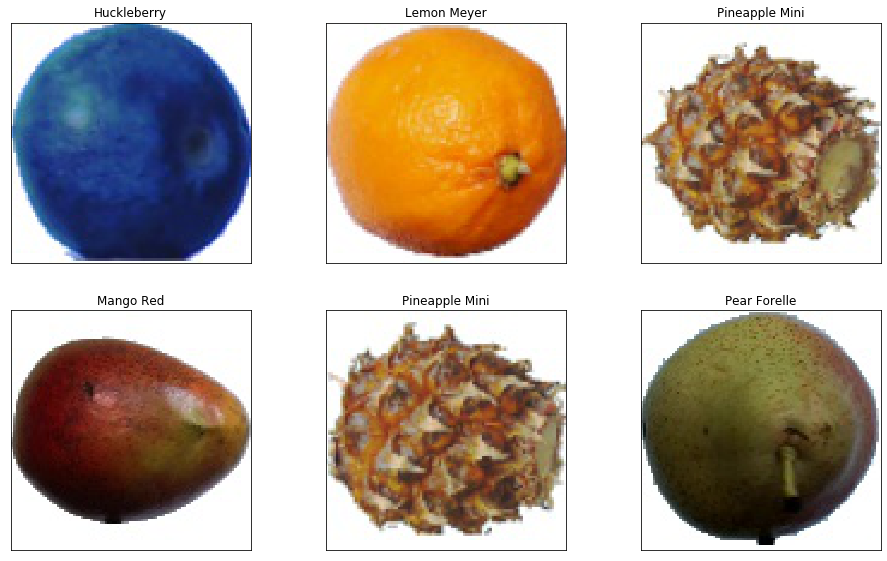

In [4]:
trainImgTbl.show(6,ncol=3,randomize=True)

### 2.2 Summary On  the Training and Test Images
- Number of images
- Image size
- Means of each channel

In [5]:
# summary information on the train image data
trainImgTbl.image_summary

jpg                 61488
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel     126.52
min1stChannel           0
max1stChannel         255
mean2ndChannel    146.276
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    174.217
min3rdChannel           0
max3rdChannel         255
dtype: object

Note: The summary table above shows that there are 61488 images with image size (100*100) in the training data set.
Here the channel means will be used as the offsets to normalize image inputs when we define CNN models later.

In [6]:
# summary on the test image data
testImgTbl.image_summary

jpg                 20622
minWidth              100
maxWidth              100
minHeight             100
maxHeight             100
meanWidth             100
meanHeight            100
mean1stChannel    129.699
min1stChannel           0
max1stChannel         255
mean2ndChannel    149.208
min2ndChannel           0
max2ndChannel         255
mean3rdChannel     176.08
min3rdChannel           0
max3rdChannel         255
dtype: object

### 2.3 Distribution of the Image Classes/Labels in the Training Data

In [7]:
freq= trainImgTbl.label_freq
print("The minimum number of images among each class: ", np.min(freq["Frequency"]))
print("The maximum number of images among each class: ", np.max(freq["Frequency"]))
print(freq)

The minimum number of images among each class:  297
The maximum number of images among each class:  984
Frequency for TRAIN

                    Level  Frequency
Apple Braeburn          1        492
Apple Crimson Snow      2        444
Apple Golden 1          3        492
Apple Golden 2          4        492
Apple Golden 3          5        481
...                   ...        ...
Tomato 4              116        479
Tomato Cherry Red     117        492
Tomato Maroon         118        367
Tomato Yellow         119        459
Walnut                120        735

[120 rows x 2 columns]


The frequency table above shows that the training table contains 120 fruits and vegetables, and the number of images in each class ranges from 297 to 984.

### 2.4 Split Images Data for Training and Validation

In [8]:
# Split training image data into train and validation
train_data, validation_data = two_way_split(trainImgTbl, test_rate=15, seed=12345)

In [9]:
print("Number of images for training:", train_data.numrows()["numrows"])
print("Number of images for validation:", validation_data.numrows()["numrows"])

Number of images for training: 52233
Number of images for validation: 9255


## 3. Image Classification with EfficientNet <a name="image-classification-efficientnet">
The EfficientNet models contains a family of CNN models. The EfficientNet-B0 model is an efficient baseline network, which is used to scale up to obtain other EfficientNets models (B1 to B7). We can build and apply these EfficientNets by DLPy APIs easily. From the [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) paper, we can see that the EfficientNet-B0 model is 4 times smaller than ResNet50, while it can achieves slightly better accuracy than ReseNet50. In this example, we will use the EfficientNet-B0 model for our fruits and vegatables classification task.  

### 3.1 Build an EfficientNet Model <a name="build-effb0"></a>
Next, you can build an EfficientNet model through DLPy API EfficientNetB0:
- We specify n_classes=120, which is the number of fruits and vegatables in the data set.
- Normalizing inputs can often improve model convergence during training. Here the input images are normalized with  offsets and norm_stds, where the offsets are set as the channel means from the training images. 
- Augmenting images (e.g. random flip, random crop,  random mutation) can often help train models with better generazation, which can potentially improve model accuracy on test images.

In [10]:
## Instantiate an EfficientNetB0 model
offsets = [126.519793, 146.276162,174.217395]
norm_stds = [255/2.,255/2.,255/2.]
effnetb0 = EfficientNetB0(conn=s, 
                          n_classes=120, 
                          offsets=offsets, norm_stds=norm_stds,
                          random_flip="hv", random_crop="resizethencrop", random_mutation="random"
                         )     

NOTE: Model compiled successfully.


### Summary on the model architecture
- It is a good start to verify the input and output layers. Since the input layer is 224*224*3 for the EfficientNetB0 model, we need resize the images in the data set, which can be conveniently done by specifying random_crop option. The output layer is for classification with 120 classes, which is the same as the number of classes in the data set.
- The model has around 4.2 millions parameters, which is much smaller than the popular resnet50 model with around 23 millions parameters.

In [11]:
effnetb0.print_summary()

Layer Id                        Layer        Type Kernel Size  Stride  \
0          0                         data       input                       
1          1                        Conv1       convo      (3, 3)  (2, 2)   
2          2                     bn_Conv1   batchnorm                       
3          3     stage_1_block_0depthwise  groupconvo      (3, 3)  (1, 1)   
4          4  stage_1_block_0depthwise_BN   batchnorm                       
..       ...                          ...         ...         ...     ...   
178      178                  Conv_top_bn   batchnorm                       
179      179              Global_avg_pool        pool      (7, 7)  (1, 1)   
180      180                OutputLayer_1      output                       
181                                                                         
182  Summary                                                                

    Activation     Output Size        Number of Parameters FLOPS(forward pass)  
0         None   (224, 224, 3)                      (0, 0)                   0  
1     Identity  (112, 112, 32)                    (864, 0)            10838016  
2         Relu  (112, 112, 32)                     (0, 64)                   0  
3     Identity  (112, 112, 32)                    (288, 0)             3612672  
4         Relu  (112, 112, 32)                     (0, 64)                   0  
..         ...             ...                         ...                 ...  
178       Relu    (7, 7, 1280)                   (0, 2560)                   0  
179       Mean    (1, 1, 1280)                      (0, 0)                   0  
180    Softmax             120               (153600, 120)                   0  
181                             Total number of parameters         Total FLOPS  
182                                              4,161,268         384,534,752  

[183 rows x 9 columns]

### 3.2 Train the EfficientNet Model<a name="train-effb0"></a>

### Set up optimizer for training  model

In [12]:
# set up varibles with number of epoches, number of threads, batch size
nEpoch=80
nThread=4
batchSize = 128
miniBatch= math.ceil(batchSize/nThread)


# set up optimizer with learning rate scheduler
lr_scheduler = ReduceLROnPlateau(conn=s, cool_down_iters=3, gamma=0.8, 
                                 learning_rate=0.001, patience=5)


solver = MomentumSolver(lr_scheduler=lr_scheduler,
                        clip_grad_max = 100, clip_grad_min = -100)
                       
optimizer = Optimizer(seed=12345, algorithm=solver, mini_batch_size = miniBatch, 
                      log_level=3, max_epochs=nEpoch, reg_l2=0.0005)
## run on two gpus
gpu = Gpu(devices=[0,1])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


### Start training model

In [18]:
# start training
model= effnetb0
print(model.model_name)
print(dict(batchSize=batchSize, nThread=nThread, nEpoch=nEpoch))
train_history = model.fit(data = train_data,
                      valid_table = validation_data,
                      n_threads=nThread, record_seed=13309, optimizer=optimizer,
                      inputs = ['_image_'], 
                      gpu = gpu,train_from_scratch =True)


EfficientNetB0
{'batchSize': 128, 'nThread': 4, 'nEpoch': 80}
NOTE: Training from scratch.
NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 4161268.
NOTE:  The approximate memory cost is 411.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.96 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level      6: Apple P

NOTE:     32   128    0.001            4.674     0.9609      10.76     0.12
NOTE:     33   128    0.001            4.693     0.9766      10.76     0.12
NOTE:     34   128    0.001            4.721          1      10.76     0.12
NOTE:     35   128    0.001            4.705     0.9609      10.76     0.12
NOTE:     36   128    0.001            4.676     0.9531      10.76     0.12
NOTE:     37   128    0.001            4.671     0.9688      10.76     0.12
NOTE:     38   128    0.001            4.654     0.9766      10.76     0.12
NOTE:     39   128    0.001             4.63     0.9766      10.76     0.12
NOTE:     40   128    0.001            4.706     0.9766      10.76     0.12
NOTE:     41   128    0.001             4.76     0.9766      10.76     0.12
NOTE:     42   128    0.001            4.659     0.9844      10.76     0.12
NOTE:     43   128    0.001            4.616     0.9531      10.76     0.12
NOTE:     44   128    0.001            4.626     0.9688      10.76     0.12
NOTE:     45

NOTE:    141   128    0.001            4.036     0.8906      10.74     0.12
NOTE:    142   128    0.001            4.132     0.8906      10.74     0.12
NOTE:    143   128    0.001             4.12     0.8672      10.74     0.12
NOTE:    144   128    0.001            4.088     0.8906      10.74     0.12
NOTE:    145   128    0.001            4.076     0.8828      10.74     0.12
NOTE:    146   128    0.001             4.16     0.9063      10.74     0.12
NOTE:    147   128    0.001            4.099      0.875      10.74     0.12
NOTE:    148   128    0.001            3.993     0.8828      10.74     0.12
NOTE:    149   128    0.001            4.165     0.9219      10.73     0.12
NOTE:    150   128    0.001            4.022     0.8672      10.73     0.12
NOTE:    151   128    0.001            3.939      0.875      10.73     0.12
NOTE:    152   128    0.001            4.008     0.8672      10.73     0.15
NOTE:    153   128    0.001            3.985      0.875      10.73     0.13
NOTE:    154

NOTE:    257   128    0.001            3.301     0.8125      10.71     0.12
NOTE:    258   128    0.001             3.34     0.7734      10.71     0.12
NOTE:    259   128    0.001            3.138       0.75      10.71     0.12
NOTE:    260   128    0.001            3.293     0.7891      10.71     0.12
NOTE:    261   128    0.001            3.296     0.7109      10.71     0.12
NOTE:    262   128    0.001             3.46     0.8203      10.71     0.12
NOTE:    263   128    0.001            3.311     0.7734      10.71     0.12
NOTE:    264   128    0.001            3.221       0.75      10.71     0.12
NOTE:    265   128    0.001            3.126     0.7109      10.71     0.12
NOTE:    266   128    0.001            3.407     0.7813      10.71     0.12
NOTE:    267   128    0.001            3.355     0.7188      10.71     0.12
NOTE:    268   128    0.001            3.472     0.8359      10.71     0.12
NOTE:    269   128    0.001              3.3     0.7422      10.71     0.12
NOTE:    270

NOTE:    370   128    0.001            2.807     0.7031      10.69     0.12
NOTE:    371   128    0.001            2.945     0.7109      10.69     0.12
NOTE:    372   128    0.001            2.705     0.6172      10.69     0.12
NOTE:    373   128    0.001            2.698     0.6797      10.69     0.12
NOTE:    374   128    0.001            2.853     0.6719      10.69     0.12
NOTE:    375   128    0.001            2.795     0.6875      10.69     0.12
NOTE:    376   128    0.001            2.814     0.6797      10.69     0.12
NOTE:    377   128    0.001            2.693     0.6563      10.69     0.12
NOTE:    378   128    0.001            2.672     0.6016      10.69     0.12
NOTE:    379   128    0.001            2.658     0.6406      10.69     0.12
NOTE:    380   128    0.001            2.419     0.5469      10.69     0.12
NOTE:    381   128    0.001            2.621      0.625      10.69     0.12
NOTE:    382   128    0.001            2.472     0.6016      10.69     0.12
NOTE:    383

NOTE:      8   128    0.001            2.594     0.6563      10.68     0.12
NOTE:      9   128    0.001            2.378     0.5391      10.68     0.12
NOTE:     10   128    0.001            2.379     0.5234      10.68     0.12
NOTE:     11   128    0.001            2.763     0.7188      10.68     0.12
NOTE:     12   128    0.001            2.434     0.5625      10.68     0.12
NOTE:     13   128    0.001            2.594     0.6484      10.68     0.12
NOTE:     14   128    0.001            2.468     0.6641      10.68     0.12
NOTE:     15   128    0.001            2.355     0.5703      10.68     0.12
NOTE:     16   128    0.001            2.622     0.6641      10.68     0.12
NOTE:     17   128    0.001            2.487     0.6328      10.68     0.12
NOTE:     18   128    0.001            2.801     0.6953      10.68     0.12
NOTE:     19   128    0.001              2.4     0.5859      10.68     0.12
NOTE:     20   128    0.001            2.642     0.6016      10.68     0.12
NOTE:     21

NOTE:    116   128    0.001            2.035     0.5078      10.66     0.12
NOTE:    117   128    0.001            2.041        0.5      10.66     0.12
NOTE:    118   128    0.001            2.044     0.4922      10.66     0.12
NOTE:    119   128    0.001            2.113     0.5078      10.66     0.12
NOTE:    120   128    0.001            1.966     0.4453      10.66     0.12
NOTE:    121   128    0.001            2.139     0.5156      10.66     0.12
NOTE:    122   128    0.001            1.965     0.4297      10.66     0.12
NOTE:    123   128    0.001            2.124     0.5391      10.66     0.12
NOTE:    124   128    0.001            2.141     0.6328      10.66     0.12
NOTE:    125   128    0.001            2.075     0.5469      10.66     0.12
NOTE:    126   128    0.001            1.954     0.4375      10.66     0.12
NOTE:    127   128    0.001            2.087     0.5313      10.66     0.12
NOTE:    128   128    0.001            2.104     0.5078      10.66     0.12
NOTE:    129

NOTE:    228   128    0.001            1.877     0.4219      10.64     0.12
NOTE:    229   128    0.001            1.722     0.3516      10.64     0.12
NOTE:    230   128    0.001            1.918     0.4609      10.64     0.12
NOTE:    231   128    0.001            1.584     0.3203      10.64     0.12
NOTE:    232   128    0.001            1.736     0.4141      10.64     0.12
NOTE:    233   128    0.001             1.67     0.4219      10.64     0.12
NOTE:    234   128    0.001            1.534     0.2813      10.64     0.12
NOTE:    235   128    0.001            2.089     0.5625      10.64     0.12
NOTE:    236   128    0.001            1.717     0.3906      10.64     0.12
NOTE:    237   128    0.001            1.619      0.375      10.64     0.12
NOTE:    238   128    0.001            1.652     0.3828      10.64     0.12
NOTE:    239   128    0.001            1.752     0.4375      10.64     0.12
NOTE:    240   128    0.001              1.5     0.3516      10.64     0.12
NOTE:    241

NOTE:    337   128    0.001            1.498     0.3203      10.62     0.12
NOTE:    338   128    0.001            1.628     0.4219      10.62     0.12
NOTE:    339   128    0.001            1.564     0.4375      10.62     0.12
NOTE:    340   128    0.001            1.586     0.4766      10.62     0.12
NOTE:    341   128    0.001            1.659        0.5      10.62     0.12
NOTE:    342   128    0.001            1.463     0.3516      10.62     0.12
NOTE:    343   128    0.001            1.564     0.3984      10.62     0.12
NOTE:    344   128    0.001            1.576     0.4609      10.62     0.12
NOTE:    345   128    0.001            1.535     0.4063      10.62     0.12
NOTE:    346   128    0.001            1.538     0.3906      10.62     0.12
NOTE:    347   128    0.001            1.409     0.3047      10.62     0.12
NOTE:    348   128    0.001            1.352     0.3125      10.62     0.12
NOTE:    349   128    0.001            1.275     0.2813      10.62     0.12
NOTE:    350

NOTE:     42   128    0.001            8.194     0.9375     0.12
NOTE:     43   128    0.001            8.481     0.9375     0.12
NOTE:     44   128    0.001            8.417     0.9141     0.12
NOTE:     45   128    0.001            8.247     0.9688     0.12
NOTE:     46   128    0.001            8.091     0.9141     0.12
NOTE:     47   128    0.001            8.868     0.9531     0.12
NOTE:     48   128    0.001            8.492     0.9688     0.12
NOTE:     49   128    0.001            7.808     0.9063     0.12
NOTE:     50   128    0.001            7.378     0.9766     0.12
NOTE:     51   128    0.001            8.453     0.9531     0.12
NOTE:     52   128    0.001            8.124     0.9297     0.12
NOTE:     53   128    0.001            8.561     0.9609     0.12
NOTE:     54   128    0.001            8.728     0.9531     0.12
NOTE:     55   128    0.001            8.334     0.9375     0.12
NOTE:     56   128    0.001             7.81     0.8984     0.12
NOTE:     57   128    0.0

NOTE:     79   128    0.001            1.084       0.25      10.59     0.12
NOTE:     80   128    0.001            1.187     0.3203      10.59     0.12
NOTE:     81   128    0.001            1.047     0.1875      10.59     0.12
NOTE:     82   128    0.001            1.164     0.2578      10.59     0.12
NOTE:     83   128    0.001            1.415      0.375      10.59     0.12
NOTE:     84   128    0.001            1.194     0.2734      10.59     0.12
NOTE:     85   128    0.001            1.064     0.2656      10.59     0.12
NOTE:     86   128    0.001            1.105     0.2344      10.59     0.12
NOTE:     87   128    0.001            1.118     0.2969      10.59     0.12
NOTE:     88   128    0.001            1.356     0.3672      10.59     0.12
NOTE:     89   128    0.001             1.19     0.2734      10.59     0.12
NOTE:     90   128    0.001           0.9253     0.2266      10.59     0.12
NOTE:     91   128    0.001            1.073     0.3047      10.59     0.12
NOTE:     92

NOTE:    192   128    0.001            1.055     0.2891      10.57     0.12
NOTE:    193   128    0.001           0.9263     0.1953      10.57     0.12
NOTE:    194   128    0.001           0.8553     0.2188      10.57     0.12
NOTE:    195   128    0.001           0.9868     0.2422      10.57     0.12
NOTE:    196   128    0.001            1.069     0.2891      10.57     0.12
NOTE:    197   128    0.001           0.8046     0.1406      10.57     0.12
NOTE:    198   128    0.001            1.026     0.2578      10.57     0.12
NOTE:    199   128    0.001           0.9633     0.2109      10.57     0.12
NOTE:    200   128    0.001            1.116     0.3281      10.57     0.12
NOTE:    201   128    0.001            0.761     0.1641      10.57     0.12
NOTE:    202   128    0.001            0.905     0.2109      10.57     0.12
NOTE:    203   128    0.001           0.9566       0.25      10.57     0.12
NOTE:    204   128    0.001            1.006     0.2734      10.57     0.12
NOTE:    205

NOTE:    307   128    0.001           0.8269     0.2188      10.55     0.12
NOTE:    308   128    0.001           0.9345     0.2031      10.55     0.12
NOTE:    309   128    0.001           0.9737     0.2422      10.55     0.12
NOTE:    310   128    0.001           0.7807     0.1641      10.55     0.12
NOTE:    311   128    0.001           0.9259     0.2031      10.55     0.12
NOTE:    312   128    0.001            0.835     0.1953      10.55     0.16
NOTE:    313   128    0.001           0.6572     0.1641      10.55     0.12
NOTE:    314   128    0.001           0.7781     0.1953      10.55     0.12
NOTE:    315   128    0.001           0.8991     0.2188      10.55     0.12
NOTE:    316   128    0.001           0.8668     0.1953      10.54     0.12
NOTE:    317   128    0.001            1.032     0.2578      10.54     0.12
NOTE:    318   128    0.001           0.8013     0.1719      10.54     0.12
NOTE:    319   128    0.001           0.7591     0.2109      10.54     0.12
NOTE:    320

NOTE:     10   128    0.001            2.067     0.5391     0.12
NOTE:     11   128    0.001            1.924     0.5234     0.12
NOTE:     12   128    0.001            2.391     0.6563     0.12
NOTE:     13   128    0.001            2.046     0.5391     0.12
NOTE:     14   128    0.001            2.136     0.6016     0.12
NOTE:     15   128    0.001            1.969     0.5938     0.12
NOTE:     16   128    0.001            1.755        0.5     0.12
NOTE:     17   128    0.001            2.176     0.5469     0.12
NOTE:     18   128    0.001            1.912     0.5391     0.12
NOTE:     19   128    0.001            1.921     0.4844     0.12
NOTE:     20   128    0.001            2.023     0.5469     0.12
NOTE:     21   128    0.001            1.813     0.5313     0.12
NOTE:     22   128    0.001            2.441      0.625     0.12
NOTE:     23   128    0.001            2.224      0.625     0.12
NOTE:     24   128    0.001            2.232     0.5859     0.12
NOTE:     25   128    0.0

NOTE:     60   128    0.001           0.5505     0.1094      10.52     0.12
NOTE:     61   128    0.001           0.5817     0.1484      10.52     0.12
NOTE:     62   128    0.001           0.7424     0.1641      10.52     0.12
NOTE:     63   128    0.001           0.5566     0.1172      10.51     0.12
NOTE:     64   128    0.001            0.766     0.1953      10.51     0.12
NOTE:     65   128    0.001           0.7112     0.1563      10.51     0.12
NOTE:     66   128    0.001           0.6737     0.1641      10.51     0.12
NOTE:     67   128    0.001           0.7212     0.2344      10.51     0.12
NOTE:     68   128    0.001           0.7029     0.1484      10.51     0.12
NOTE:     69   128    0.001           0.7137     0.1563      10.51     0.12
NOTE:     70   128    0.001           0.6504     0.1406      10.51     0.12
NOTE:     71   128    0.001           0.6386     0.1484      10.51     0.12
NOTE:     72   128    0.001            0.561     0.1172      10.51     0.12
NOTE:     73

NOTE:    173   128    0.001           0.6739     0.1719      10.49     0.12
NOTE:    174   128    0.001           0.5259     0.1172      10.49     0.12
NOTE:    175   128    0.001           0.6112     0.1328      10.49     0.12
NOTE:    176   128    0.001           0.5653     0.1875      10.49     0.12
NOTE:    177   128    0.001           0.5894     0.1563      10.49     0.12
NOTE:    178   128    0.001           0.5845      0.125      10.49     0.12
NOTE:    179   128    0.001           0.6895     0.2031      10.49     0.12
NOTE:    180   128    0.001           0.5552     0.1484      10.49     0.12
NOTE:    181   128    0.001           0.6643     0.1563      10.49     0.12
NOTE:    182   128    0.001           0.5363     0.1172      10.49     0.12
NOTE:    183   128    0.001           0.5932     0.1641      10.49     0.12
NOTE:    184   128    0.001           0.5585     0.1406      10.49     0.12
NOTE:    185   128    0.001           0.6665     0.1875      10.49     0.12
NOTE:    186

NOTE:    281   128    0.001            0.626     0.1797      10.47     0.12
NOTE:    282   128    0.001           0.5592     0.1328      10.47     0.12
NOTE:    283   128    0.001           0.5751     0.1563      10.47     0.12
NOTE:    284   128    0.001             0.57     0.1563      10.47     0.12
NOTE:    285   128    0.001              0.6     0.1641      10.47     0.12
NOTE:    286   128    0.001           0.5068     0.1172      10.47     0.12
NOTE:    287   128    0.001           0.7473     0.1953      10.47     0.13
NOTE:    288   128    0.001           0.5234     0.1406      10.47     0.15
NOTE:    289   128    0.001           0.4774     0.1094      10.47     0.12
NOTE:    290   128    0.001           0.5124      0.125      10.47     0.12
NOTE:    291   128    0.001           0.5554     0.1328      10.47     0.12
NOTE:    292   128    0.001           0.5532     0.1406      10.47     0.12
NOTE:    293   128    0.001           0.5427     0.1016      10.47     0.12
NOTE:    294

NOTE:    390   128    0.001           0.3994    0.07813      10.45     0.12
NOTE:    391   128    0.001           0.4616     0.1094      10.45     0.12
NOTE:    392   128    0.001           0.4952     0.1094      10.45     0.12
NOTE:    393   128    0.001           0.4228     0.1016      10.45     0.12
NOTE:    394   128    0.001           0.6238     0.1563      10.45     0.12
NOTE:    395   128    0.001            0.424    0.07813      10.45     0.12
NOTE:    396   128    0.001           0.3857    0.07813      10.45     0.12
NOTE:    397   128    0.001           0.3863     0.1016      10.45     0.12
NOTE:    398   128    0.001            0.437     0.1016      10.45     0.12
NOTE:    399   128    0.001           0.4483    0.07813      10.45     0.12
NOTE:    400   128    0.001            0.544      0.125      10.45     0.12
NOTE:    401   128    0.001            0.378    0.08594      10.45     0.12
NOTE:    402   128    0.001           0.4069     0.0625      10.45     0.12
NOTE:    403

NOTE:     22   128    0.001           0.4747     0.1094      10.44     0.12
NOTE:     23   128    0.001           0.3935     0.0625      10.44     0.12
NOTE:     24   128    0.001           0.5123    0.08594      10.44     0.12
NOTE:     25   128    0.001           0.6063     0.1328      10.44     0.12
NOTE:     26   128    0.001           0.4556     0.1094      10.44     0.12
NOTE:     27   128    0.001           0.3835    0.07031      10.44     0.12
NOTE:     28   128    0.001           0.3378    0.05469      10.44     0.12
NOTE:     29   128    0.001           0.4161    0.08594      10.44     0.12
NOTE:     30   128    0.001           0.6322     0.1563      10.44     0.12
NOTE:     31   128    0.001           0.4164     0.1016      10.44     0.12
NOTE:     32   128    0.001           0.2937    0.07031      10.44     0.12
NOTE:     33   128    0.001           0.4276    0.08594      10.44     0.12
NOTE:     34   128    0.001           0.3802    0.07813      10.44     0.12
NOTE:     35

NOTE:    131   128    0.001            0.356    0.07813      10.42     0.12
NOTE:    132   128    0.001           0.4336    0.08594      10.42     0.12
NOTE:    133   128    0.001           0.2479    0.05469      10.42     0.12
NOTE:    134   128    0.001           0.4375      0.125      10.42     0.12
NOTE:    135   128    0.001           0.3771    0.08594      10.42     0.12
NOTE:    136   128    0.001           0.3644    0.08594      10.42     0.12
NOTE:    137   128    0.001           0.3868    0.09375      10.42     0.12
NOTE:    138   128    0.001           0.3871    0.09375      10.42     0.12
NOTE:    139   128    0.001           0.3784    0.07031      10.42     0.12
NOTE:    140   128    0.001           0.4403    0.08594      10.42     0.12
NOTE:    141   128    0.001           0.3115    0.05469      10.42     0.12
NOTE:    142   128    0.001            0.515     0.1328      10.42     0.12
NOTE:    143   128    0.001           0.4433     0.1328      10.42     0.12
NOTE:    144

NOTE:    243   128    0.001           0.4698    0.08594       10.4     0.12
NOTE:    244   128    0.001           0.3567    0.07031       10.4     0.12
NOTE:    245   128    0.001           0.4816      0.125       10.4     0.12
NOTE:    246   128    0.001           0.2918    0.04688       10.4     0.12
NOTE:    247   128    0.001           0.3374    0.07031       10.4     0.12
NOTE:    248   128    0.001           0.2987    0.07031       10.4     0.12
NOTE:    249   128    0.001           0.3336     0.0625       10.4     0.12
NOTE:    250   128    0.001           0.3333    0.08594       10.4     0.12
NOTE:    251   128    0.001           0.3009    0.07813       10.4     0.12
NOTE:    252   128    0.001           0.4046     0.1094       10.4     0.12
NOTE:    253   128    0.001           0.4078     0.0625       10.4     0.12
NOTE:    254   128    0.001           0.2783    0.07031       10.4     0.12
NOTE:    255   128    0.001           0.4769     0.1094       10.4     0.12
NOTE:    256

NOTE:    354   128    0.001            0.344     0.0625      10.38     0.12
NOTE:    355   128    0.001           0.3557     0.1094      10.38     0.12
NOTE:    356   128    0.001            0.169    0.01563      10.38     0.12
NOTE:    357   128    0.001           0.2182    0.02344      10.38     0.12
NOTE:    358   128    0.001           0.3283    0.07031      10.38     0.12
NOTE:    359   128    0.001           0.2768    0.05469      10.38     0.12
NOTE:    360   128    0.001           0.2574    0.03906      10.38     0.12
NOTE:    361   128    0.001            0.327     0.1172      10.38     0.12
NOTE:    362   128    0.001            0.242    0.04688      10.38     0.12
NOTE:    363   128    0.001            0.301    0.05469      10.38     0.12
NOTE:    364   128    0.001           0.4129     0.1094      10.38     0.12
NOTE:    365   128    0.001           0.2777    0.05469      10.38     0.12
NOTE:    366   128    0.001            0.271    0.05469      10.38     0.12
NOTE:    367

NOTE:     62   128    0.001           0.4299     0.1094     0.12
NOTE:     63   128    0.001           0.5422     0.1797     0.12
NOTE:     64   128    0.001           0.5608      0.125     0.12
NOTE:     65   128    0.001            0.764     0.1953     0.12
NOTE:     66   128    0.001           0.6307     0.1563     0.12
NOTE:     67   128    0.001           0.5222     0.1016     0.12
NOTE:     68   128    0.001           0.5448     0.1484     0.12
NOTE:     69   128    0.001           0.6235     0.2109     0.11
NOTE:     70   128    0.001           0.5604     0.1719     0.12
NOTE:     71   128    0.001           0.5486     0.1406     0.12
NOTE:     72    39    0.001           0.5011     0.1795     0.03
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  4         0.001          0.3772    0.08731           0.5528           0.1493    57.63
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:     

NOTE:     96   128    0.001           0.2283    0.03906      10.35     0.12
NOTE:     97   128    0.001           0.2716     0.0625      10.35     0.12
NOTE:     98   128    0.001           0.2817    0.04688      10.35     0.12
NOTE:     99   128    0.001           0.3033    0.07031      10.35     0.13
NOTE:    100   128    0.001           0.3078    0.08594      10.35     0.12
NOTE:    101   128    0.001           0.2208    0.05469      10.35     0.12
NOTE:    102   128    0.001            0.297    0.07813      10.35     0.13
NOTE:    103   128    0.001           0.2234    0.04688      10.35     0.14
NOTE:    104   128    0.001            0.283    0.09375      10.35     0.12
NOTE:    105   128    0.001           0.1722    0.01563      10.35     0.12
NOTE:    106   128    0.001           0.2728     0.0625      10.35     0.12
NOTE:    107   128    0.001           0.2962    0.07031      10.35     0.12
NOTE:    108   128    0.001             0.26     0.0625      10.35     0.12
NOTE:    109

NOTE:    205   128    0.001           0.2364    0.04688      10.33     0.12
NOTE:    206   128    0.001           0.2302    0.04688      10.33     0.12
NOTE:    207   128    0.001           0.2438     0.0625      10.33     0.12
NOTE:    208   128    0.001           0.2475    0.03906      10.33     0.12
NOTE:    209   128    0.001           0.2099    0.03906      10.33     0.12
NOTE:    210   128    0.001           0.4534     0.1563      10.33     0.12
NOTE:    211   128    0.001           0.2322    0.03125      10.33     0.12
NOTE:    212   128    0.001           0.3254    0.07031      10.33     0.12
NOTE:    213   128    0.001           0.2269    0.04688      10.33     0.12
NOTE:    214   128    0.001           0.1965    0.03125      10.33     0.12
NOTE:    215   128    0.001           0.2615    0.05469      10.33     0.12
NOTE:    216   128    0.001           0.3115    0.07813      10.33     0.12
NOTE:    217   128    0.001           0.2837    0.07813      10.33     0.13
NOTE:    218

NOTE:    314   128    0.001           0.1988    0.03906      10.31     0.12
NOTE:    315   128    0.001           0.2776    0.08594      10.31     0.12
NOTE:    316   128    0.001           0.2039    0.05469      10.31     0.12
NOTE:    317   128    0.001           0.1837    0.04688      10.31     0.12
NOTE:    318   128    0.001           0.1569    0.02344      10.31     0.12
NOTE:    319   128    0.001           0.2987    0.08594       10.3     0.12
NOTE:    320   128    0.001           0.2619    0.05469       10.3     0.12
NOTE:    321   128    0.001           0.2742    0.08594       10.3     0.12
NOTE:    322   128    0.001           0.2074    0.05469       10.3     0.12
NOTE:    323   128    0.001            0.291    0.07813       10.3     0.12
NOTE:    324   128    0.001           0.2552    0.07031       10.3     0.12
NOTE:    325   128    0.001           0.2369     0.0625       10.3     0.12
NOTE:    326   128    0.001           0.2265    0.07031       10.3     0.12
NOTE:    327

NOTE:     15   128    0.001            0.513     0.1484     0.12
NOTE:     16   128    0.001           0.4824     0.1016     0.12
NOTE:     17   128    0.001           0.4819     0.1016     0.12
NOTE:     18   128    0.001           0.5186     0.1328     0.12
NOTE:     19   128    0.001           0.4572     0.1328     0.12
NOTE:     20   128    0.001           0.4278     0.1172     0.12
NOTE:     21   128    0.001           0.3696    0.08594     0.12
NOTE:     22   128    0.001           0.5267      0.125     0.12
NOTE:     23   128    0.001            0.626     0.1797     0.12
NOTE:     24   128    0.001           0.5552     0.1328     0.12
NOTE:     25   128    0.001             0.45     0.1172     0.12
NOTE:     26   128    0.001           0.4511     0.1328     0.12
NOTE:     27   128    0.001           0.5033     0.1484     0.12
NOTE:     28   128    0.001            0.426     0.1406     0.12
NOTE:     29   128    0.001           0.5276     0.1406     0.12
NOTE:     30   128    0.0

NOTE:     57   128    0.001            0.138   0.007813      10.28     0.12
NOTE:     58   128    0.001           0.1626    0.03125      10.28     0.12
NOTE:     59   128    0.001           0.2143    0.03906      10.28     0.12
NOTE:     60   128    0.001           0.1917    0.02344      10.28     0.12
NOTE:     61   128    0.001           0.2191    0.04688      10.28     0.12
NOTE:     62   128    0.001           0.2424     0.0625      10.28     0.12
NOTE:     63   128    0.001           0.2302    0.05469      10.27     0.12
NOTE:     64   128    0.001           0.2385    0.05469      10.27     0.12
NOTE:     65   128    0.001           0.2065    0.02344      10.27     0.12
NOTE:     66   128    0.001           0.1574    0.03125      10.27     0.12
NOTE:     67   128    0.001           0.1565    0.02344      10.27     0.12
NOTE:     68   128    0.001           0.1837    0.02344      10.27     0.12
NOTE:     69   128    0.001           0.3263    0.07031      10.27     0.12
NOTE:     70

NOTE:    165   128    0.001           0.2214    0.03906      10.25     0.12
NOTE:    166   128    0.001           0.2066     0.0625      10.25     0.12
NOTE:    167   128    0.001           0.1646    0.03906      10.25     0.12
NOTE:    168   128    0.001           0.1827    0.05469      10.25     0.12
NOTE:    169   128    0.001           0.2635    0.05469      10.25     0.12
NOTE:    170   128    0.001           0.1773    0.03125      10.25     0.12
NOTE:    171   128    0.001           0.1745    0.02344      10.25     0.12
NOTE:    172   128    0.001           0.2112    0.05469      10.25     0.12
NOTE:    173   128    0.001           0.1734    0.04688      10.25     0.12
NOTE:    174   128    0.001           0.1685    0.03906      10.25     0.12
NOTE:    175   128    0.001           0.3535     0.1016      10.25     0.12
NOTE:    176   128    0.001            0.137    0.01563      10.25     0.12
NOTE:    177   128    0.001           0.2128    0.07031      10.25     0.12
NOTE:    178

NOTE:    280   128    0.001           0.1956    0.05469      10.23     0.12
NOTE:    281   128    0.001           0.2018    0.04688      10.23     0.12
NOTE:    282   128    0.001           0.1783    0.03906      10.23     0.12
NOTE:    283   128    0.001           0.2122     0.0625      10.23     0.12
NOTE:    284   128    0.001           0.1849    0.03906      10.23     0.12
NOTE:    285   128    0.001           0.1993    0.03906      10.23     0.12
NOTE:    286   128    0.001           0.2095     0.0625      10.23     0.12
NOTE:    287   128    0.001           0.1656    0.03125      10.23     0.12
NOTE:    288   128    0.001           0.1935    0.03906      10.23     0.12
NOTE:    289   128    0.001           0.1362    0.03125      10.23     0.12
NOTE:    290   128    0.001           0.1573    0.03906      10.23     0.12
NOTE:    291   128    0.001           0.1454    0.02344      10.23     0.12
NOTE:    292   128    0.001           0.1812    0.04688      10.23     0.12
NOTE:    293

NOTE:    391   128    0.001           0.1229    0.01563      10.21     0.12
NOTE:    392   128    0.001           0.2354     0.0625      10.21     0.12
NOTE:    393   128    0.001           0.2253    0.07031      10.21     0.12
NOTE:    394   128    0.001           0.1167          0      10.21     0.12
NOTE:    395   128    0.001           0.1964    0.05469      10.21     0.12
NOTE:    396   128    0.001           0.1854    0.03906      10.21     0.12
NOTE:    397   128    0.001            0.185    0.07031      10.21     0.12
NOTE:    398   128    0.001           0.1313    0.02344      10.21     0.12
NOTE:    399   128    0.001           0.2476    0.05469      10.21     0.12
NOTE:    400   128    0.001           0.1815    0.04688      10.21     0.12
NOTE:    401   128    0.001           0.1529    0.03125      10.21     0.12
NOTE:    402   128    0.001           0.2579    0.05469      10.21     0.12
NOTE:    403   128    0.001           0.1137    0.03125      10.21     0.12
NOTE:    404

NOTE:     26   128    0.001           0.1472    0.03125       10.2     0.12
NOTE:     27   128    0.001           0.1946    0.04688       10.2     0.12
NOTE:     28   128    0.001           0.1167    0.02344       10.2     0.12
NOTE:     29   128    0.001           0.1179   0.007813       10.2     0.12
NOTE:     30   128    0.001           0.1641    0.03125       10.2     0.12
NOTE:     31   128    0.001           0.1541    0.05469       10.2     0.12
NOTE:     32   128    0.001           0.2086    0.02344       10.2     0.12
NOTE:     33   128    0.001           0.2322    0.05469       10.2     0.12
NOTE:     34   128    0.001           0.1559    0.04688       10.2     0.12
NOTE:     35   128    0.001           0.1157    0.01563       10.2     0.12
NOTE:     36   128    0.001           0.1866    0.04688       10.2     0.12
NOTE:     37   128    0.001           0.1668    0.04688       10.2     0.12
NOTE:     38   128    0.001           0.1641    0.05469       10.2     0.12
NOTE:     39

NOTE:    136   128    0.001           0.1224    0.01563      10.18     0.12
NOTE:    137   128    0.001           0.1761    0.03125      10.18     0.12
NOTE:    138   128    0.001           0.1322   0.007813      10.18     0.12
NOTE:    139   128    0.001           0.1186    0.01563      10.18     0.12
NOTE:    140   128    0.001           0.1661    0.02344      10.18     0.12
NOTE:    141   128    0.001           0.1697    0.04688      10.18     0.12
NOTE:    142   128    0.001           0.1581    0.03125      10.18     0.12
NOTE:    143   128    0.001           0.1893    0.05469      10.18     0.12
NOTE:    144   128    0.001           0.2419    0.09375      10.18     0.12
NOTE:    145   128    0.001           0.2437    0.03125      10.18     0.12
NOTE:    146   128    0.001           0.1002    0.01563      10.18     0.12
NOTE:    147   128    0.001           0.1507    0.03906      10.18     0.12
NOTE:    148   128    0.001           0.1228    0.02344      10.18     0.12
NOTE:    149

NOTE:    246   128    0.001           0.1303   0.007813      10.16     0.12
NOTE:    247   128    0.001            0.151    0.01563      10.16     0.12
NOTE:    248   128    0.001           0.1588    0.04688      10.16     0.12
NOTE:    249   128    0.001           0.1642    0.03906      10.16     0.12
NOTE:    250   128    0.001           0.1243    0.03906      10.16     0.12
NOTE:    251   128    0.001           0.1998     0.0625      10.16     0.12
NOTE:    252   128    0.001           0.2586     0.0625      10.16     0.12
NOTE:    253   128    0.001           0.1613    0.04688      10.16     0.12
NOTE:    254   128    0.001           0.2078    0.05469      10.16     0.12
NOTE:    255   128    0.001           0.1253    0.03125      10.16     0.12
NOTE:    256   128    0.001           0.1689     0.0625      10.16     0.12
NOTE:    257   128    0.001           0.2654    0.07031      10.16     0.12
NOTE:    258   128    0.001           0.1104   0.007813      10.16     0.12
NOTE:    259

NOTE:    356   128    0.001           0.1113    0.01563      10.14     0.12
NOTE:    357   128    0.001           0.2271    0.04688      10.14     0.12
NOTE:    358   128    0.001           0.1654    0.02344      10.14     0.12
NOTE:    359   128    0.001           0.1236    0.03125      10.14     0.12
NOTE:    360   128    0.001           0.1132    0.02344      10.14     0.12
NOTE:    361   128    0.001           0.1453    0.01563      10.14     0.12
NOTE:    362   128    0.001          0.09554   0.007813      10.14     0.12
NOTE:    363   128    0.001            0.106    0.01563      10.14     0.12
NOTE:    364   128    0.001           0.2497    0.04688      10.14     0.12
NOTE:    365   128    0.001           0.1823    0.01563      10.14     0.12
NOTE:    366   128    0.001          0.07829   0.007813      10.13     0.12
NOTE:    367   128    0.001           0.1715    0.02344      10.13     0.12
NOTE:    368   128    0.001          0.09668    0.02344      10.13     0.12
NOTE:    369

NOTE:     64   128    0.001           0.5478     0.1641     0.12
NOTE:     65   128    0.001           0.4181     0.1172     0.12
NOTE:     66   128    0.001            0.502     0.1172     0.12
NOTE:     67   128    0.001           0.4453     0.1328     0.12
NOTE:     68   128    0.001           0.7888     0.2188     0.12
NOTE:     69   128    0.001           0.7081     0.1797     0.12
NOTE:     70   128    0.001           0.4692      0.125     0.12
NOTE:     71   128    0.001           0.5669     0.1094     0.12
NOTE:     72    39    0.001           0.3909     0.1026     0.03
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  7         0.001          0.1578    0.03408           0.6312           0.1556    57.70
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001            0.127    0.01563      10.13     0.22
NOTE:      1   128    0.001           0.1267    0.02344      10.

NOTE:     99   128    0.001           0.1206    0.01563      10.11     0.12
NOTE:    100   128    0.001          0.09426    0.02344      10.11     0.12
NOTE:    101   128    0.001           0.2448     0.0625      10.11     0.12
NOTE:    102   128    0.001           0.1117    0.01563      10.11     0.12
NOTE:    103   128    0.001           0.1035    0.01563      10.11     0.12
NOTE:    104   128    0.001           0.1008    0.01563      10.11     0.12
NOTE:    105   128    0.001            0.154    0.03906      10.11     0.12
NOTE:    106   128    0.001           0.1404    0.02344      10.11     0.12
NOTE:    107   128    0.001            0.173    0.05469      10.11     0.12
NOTE:    108   128    0.001           0.1206    0.02344      10.11     0.12
NOTE:    109   128    0.001           0.1256    0.02344      10.11     0.12
NOTE:    110   128    0.001           0.1468    0.04688       10.1     0.12
NOTE:    111   128    0.001           0.1865    0.04688       10.1     0.12
NOTE:    112

NOTE:    215   128    0.001          0.08707          0      10.08     0.12
NOTE:    216   128    0.001            0.107    0.01563      10.08     0.12
NOTE:    217   128    0.001          0.06505          0      10.08     0.12
NOTE:    218   128    0.001           0.1335    0.02344      10.08     0.12
NOTE:    219   128    0.001            0.182    0.03906      10.08     0.12
NOTE:    220   128    0.001           0.1054   0.007813      10.08     0.12
NOTE:    221   128    0.001           0.1094    0.02344      10.08     0.12
NOTE:    222   128    0.001          0.08844    0.02344      10.08     0.12
NOTE:    223   128    0.001           0.1339    0.03125      10.08     0.12
NOTE:    224   128    0.001          0.07621          0      10.08     0.12
NOTE:    225   128    0.001           0.0834   0.007813      10.08     0.12
NOTE:    226   128    0.001           0.1092   0.007813      10.08     0.12
NOTE:    227   128    0.001          0.08689    0.01563      10.08     0.12
NOTE:    228

NOTE:    324   128    0.001          0.09036   0.007813      10.06     0.12
NOTE:    325   128    0.001           0.1238    0.01563      10.06     0.12
NOTE:    326   128    0.001           0.2572    0.08594      10.06     0.12
NOTE:    327   128    0.001           0.1073    0.01563      10.06     0.12
NOTE:    328   128    0.001           0.1003    0.03125      10.06     0.12
NOTE:    329   128    0.001           0.1092    0.01563      10.06     0.12
NOTE:    330   128    0.001           0.1239    0.03125      10.06     0.12
NOTE:    331   128    0.001           0.0569   0.007813      10.06     0.12
NOTE:    332   128    0.001          0.07356   0.007813      10.06     0.12
NOTE:    333   128    0.001           0.1613    0.04688      10.06     0.12
NOTE:    334   128    0.001          0.07565          0      10.06     0.12
NOTE:    335   128    0.001          0.07558    0.01563      10.06     0.12
NOTE:    336   128    0.001           0.1292    0.01563      10.06     0.12
NOTE:    337

NOTE:     29   128    0.001           0.0458   0.007813     0.12
NOTE:     30   128    0.001          0.09359    0.01563     0.12
NOTE:     31   128    0.001           0.1121    0.03125     0.12
NOTE:     32   128    0.001          0.08201    0.01563     0.12
NOTE:     33   128    0.001          0.07126    0.02344     0.12
NOTE:     34   128    0.001          0.08693    0.01563     0.12
NOTE:     35   128    0.001           0.1158    0.02344     0.12
NOTE:     36   128    0.001          0.07374    0.01563     0.12
NOTE:     37   128    0.001            0.154    0.03125     0.12
NOTE:     38   128    0.001          0.08504    0.01563     0.12
NOTE:     39   128    0.001          0.09804    0.02344     0.12
NOTE:     40   128    0.001           0.0889    0.02344     0.12
NOTE:     41   128    0.001           0.0636   0.007813     0.12
NOTE:     42   128    0.001           0.1282    0.02344     0.12
NOTE:     43   128    0.001           0.1037    0.03125     0.12
NOTE:     44   128    0.0

NOTE:     71   128    0.001           0.1579    0.04688      10.03     0.12
NOTE:     72   128    0.001          0.09042    0.01563      10.03     0.12
NOTE:     73   128    0.001          0.08023    0.01563      10.03     0.12
NOTE:     74   128    0.001           0.1295    0.01563      10.03     0.12
NOTE:     75   128    0.001            0.125    0.02344      10.03     0.12
NOTE:     76   128    0.001           0.1659    0.03906      10.03     0.12
NOTE:     77   128    0.001           0.1662    0.05469      10.03     0.12
NOTE:     78   128    0.001           0.1267    0.02344      10.03     0.12
NOTE:     79   128    0.001           0.1408    0.04688      10.03     0.12
NOTE:     80   128    0.001           0.1263    0.02344      10.03     0.12
NOTE:     81   128    0.001           0.1397    0.03125      10.03     0.12
NOTE:     82   128    0.001           0.1028   0.007813      10.03     0.12
NOTE:     83   128    0.001            0.172    0.02344      10.03     0.12
NOTE:     84

NOTE:    182   128    0.001          0.04728          0      10.01     0.12
NOTE:    183   128    0.001           0.1035    0.01563      10.01     0.12
NOTE:    184   128    0.001          0.05952          0      10.01     0.12
NOTE:    185   128    0.001          0.08792   0.007813      10.01     0.12
NOTE:    186   128    0.001           0.1864    0.04688      10.01     0.12
NOTE:    187   128    0.001           0.1638    0.04688      10.01     0.12
NOTE:    188   128    0.001           0.1159    0.03906      10.01     0.12
NOTE:    189   128    0.001           0.1108    0.01563      10.01     0.12
NOTE:    190   128    0.001          0.09997    0.01563      10.01     0.12
NOTE:    191   128    0.001           0.1322    0.03125      10.01     0.12
NOTE:    192   128    0.001           0.1165    0.01563      10.01     0.12
NOTE:    193   128    0.001          0.09281   0.007813      10.01     0.12
NOTE:    194   128    0.001          0.08253          0      10.01     0.12
NOTE:    195

NOTE:    292   128    0.001          0.08599   0.007813      9.989     0.12
NOTE:    293   128    0.001          0.05407          0      9.989     0.12
NOTE:    294   128    0.001          0.07311          0      9.989     0.12
NOTE:    295   128    0.001           0.1305    0.03125      9.989     0.12
NOTE:    296   128    0.001          0.06824   0.007813      9.989     0.12
NOTE:    297   128    0.001           0.1105    0.03125      9.988     0.12
NOTE:    298   128    0.001           0.0974    0.01563      9.988     0.12
NOTE:    299   128    0.001          0.09874    0.01563      9.988     0.12
NOTE:    300   128    0.001          0.08878    0.01563      9.988     0.12
NOTE:    301   128    0.001          0.09507    0.02344      9.988     0.12
NOTE:    302   128    0.001          0.07692    0.01563      9.987     0.12
NOTE:    303   128    0.001          0.09102    0.01563      9.987     0.12
NOTE:    304   128    0.001          0.06367          0      9.987     0.12
NOTE:    305

NOTE:    403   128    0.001           0.1177    0.02344      9.968     0.12
NOTE:    404   128    0.001             0.11    0.02344      9.968     0.12
NOTE:    405   128    0.001          0.06417    0.01563      9.967     0.12
NOTE:    406   128    0.001          0.09018    0.01563      9.967     0.12
NOTE:    407   128    0.001          0.06658    0.02344      9.967     0.12
NOTE:    408   128    0.001           0.1048    0.03125      9.967     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.09558    0.02344     0.14
NOTE:      1   128    0.001            0.147    0.02344     0.12
NOTE:      2   128    0.001          0.07561   0.007813     0.12
NOTE:      3   128    0.001           0.1019    0.02344     0.12
NOTE:      4   128    0.001           0.1053    0.01563     0.12
NOTE:      5   128    0.001            0.119    0.04688     0.12
NOTE:      6   128    0.001           0.1645    0.04688     0.12
NOTE:     

NOTE:     37   128    0.001           0.1589    0.04688      9.959     0.12
NOTE:     38   128    0.001           0.1226    0.03906      9.959     0.12
NOTE:     39   128    0.001           0.1164    0.02344      9.959     0.12
NOTE:     40   128    0.001          0.08022    0.01563      9.959     0.12
NOTE:     41   128    0.001          0.07526   0.007813      9.959     0.12
NOTE:     42   128    0.001          0.08695    0.02344      9.958     0.13
NOTE:     43   128    0.001          0.08972    0.01563      9.958     0.12
NOTE:     44   128    0.001          0.08595   0.007813      9.958     0.12
NOTE:     45   128    0.001          0.09762    0.01563      9.958     0.12
NOTE:     46   128    0.001            0.115    0.02344      9.958     0.12
NOTE:     47   128    0.001           0.1556    0.04688      9.957     0.12
NOTE:     48   128    0.001          0.06951   0.007813      9.957     0.12
NOTE:     49   128    0.001           0.0795   0.007813      9.957     0.12
NOTE:     50

NOTE:    149   128    0.001          0.06078   0.007813      9.938     0.12
NOTE:    150   128    0.001          0.05004   0.007813      9.937     0.12
NOTE:    151   128    0.001          0.08002    0.01563      9.937     0.12
NOTE:    152   128    0.001           0.1136    0.03125      9.937     0.12
NOTE:    153   128    0.001          0.08202   0.007813      9.937     0.12
NOTE:    154   128    0.001            0.112    0.02344      9.937     0.12
NOTE:    155   128    0.001           0.1226    0.03906      9.937     0.12
NOTE:    156   128    0.001          0.05882   0.007813      9.936     0.12
NOTE:    157   128    0.001           0.1162    0.03125      9.936     0.12
NOTE:    158   128    0.001           0.1067    0.01563      9.936     0.12
NOTE:    159   128    0.001           0.1349    0.03125      9.936     0.12
NOTE:    160   128    0.001          0.05518          0      9.936     0.12
NOTE:    161   128    0.001          0.03708          0      9.935     0.12
NOTE:    162

NOTE:    258   128    0.001           0.0556    0.01563      9.917     0.12
NOTE:    259   128    0.001           0.0842    0.01563      9.916     0.12
NOTE:    260   128    0.001           0.0637    0.01563      9.916     0.12
NOTE:    261   128    0.001          0.05389   0.007813      9.916     0.12
NOTE:    262   128    0.001           0.0838    0.01563      9.916     0.12
NOTE:    263   128    0.001          0.07281    0.01563      9.916     0.12
NOTE:    264   128    0.001           0.1327    0.01563      9.915     0.12
NOTE:    265   128    0.001          0.08016    0.01563      9.915     0.12
NOTE:    266   128    0.001          0.07661    0.02344      9.915     0.12
NOTE:    267   128    0.001          0.06279   0.007813      9.915     0.12
NOTE:    268   128    0.001          0.04279          0      9.915     0.12
NOTE:    269   128    0.001          0.05827    0.01563      9.914     0.12
NOTE:    270   128    0.001           0.1213    0.02344      9.914     0.12
NOTE:    271

NOTE:    367   128    0.001          0.08175    0.01563      9.895     0.12
NOTE:    368   128    0.001          0.06815    0.02344      9.895     0.12
NOTE:    369   128    0.001          0.09104    0.02344      9.895     0.12
NOTE:    370   128    0.001           0.0717   0.007813      9.895     0.12
NOTE:    371   128    0.001          0.06376          0      9.895     0.12
NOTE:    372   128    0.001           0.1457    0.05469      9.894     0.12
NOTE:    373   128    0.001          0.07588   0.007813      9.894     0.12
NOTE:    374   128    0.001          0.08219    0.02344      9.894     0.12
NOTE:    375   128    0.001           0.1056    0.03125      9.894     0.12
NOTE:    376   128    0.001           0.1179    0.03125      9.894     0.12
NOTE:    377   128    0.001          0.05076    0.01563      9.893     0.12
NOTE:    378   128    0.001          0.03899          0      9.893     0.12
NOTE:    379   128    0.001          0.04315          0      9.893     0.12
NOTE:    380

NOTE:      2   128    0.001          0.05628          0      9.887     0.13
NOTE:      3   128    0.001            0.071    0.01563      9.887     0.12
NOTE:      4   128    0.001          0.07327   0.007813      9.886     0.13
NOTE:      5   128    0.001          0.04755          0      9.886     0.16
NOTE:      6   128    0.001          0.06679    0.03125      9.886     0.16
NOTE:      7   128    0.001           0.1111    0.02344      9.886     0.15
NOTE:      8   128    0.001          0.05697    0.01563      9.886     0.12
NOTE:      9   128    0.001          0.09783    0.02344      9.886     0.12
NOTE:     10   128    0.001          0.07015    0.01563      9.885     0.12
NOTE:     11   128    0.001           0.1094    0.03125      9.885     0.12
NOTE:     12   128    0.001           0.0873    0.01563      9.885     0.16
NOTE:     13   128    0.001            0.117    0.03906      9.885     0.16
NOTE:     14   128    0.001           0.1024    0.02344      9.885     0.16
NOTE:     15

NOTE:    117   128    0.001          0.09697    0.01563      9.865     0.12
NOTE:    118   128    0.001           0.1167    0.02344      9.864     0.12
NOTE:    119   128    0.001          0.05828          0      9.864     0.12
NOTE:    120   128    0.001          0.09762    0.01563      9.864     0.12
NOTE:    121   128    0.001           0.1067    0.01563      9.864     0.12
NOTE:    122   128    0.001          0.04568          0      9.864     0.12
NOTE:    123   128    0.001            0.053   0.007813      9.864     0.12
NOTE:    124   128    0.001           0.0548          0      9.863     0.12
NOTE:    125   128    0.001           0.1429    0.01563      9.863     0.12
NOTE:    126   128    0.001          0.05535          0      9.863     0.12
NOTE:    127   128    0.001          0.07164    0.02344      9.863     0.12
NOTE:    128   128    0.001           0.0758    0.01563      9.863     0.12
NOTE:    129   128    0.001          0.05993   0.007813      9.862     0.12
NOTE:    130

NOTE:    225   128    0.001          0.06719    0.02344      9.844     0.12
NOTE:    226   128    0.001           0.1002    0.03125      9.844     0.12
NOTE:    227   128    0.001          0.06891   0.007813      9.843     0.12
NOTE:    228   128    0.001          0.04041          0      9.843     0.12
NOTE:    229   128    0.001          0.05421    0.01563      9.843     0.12
NOTE:    230   128    0.001          0.07303    0.01563      9.843     0.12
NOTE:    231   128    0.001          0.09635   0.007813      9.843     0.12
NOTE:    232   128    0.001           0.1377    0.04688      9.842     0.12
NOTE:    233   128    0.001          0.07491    0.03125      9.842     0.12
NOTE:    234   128    0.001           0.1314    0.03125      9.842     0.12
NOTE:    235   128    0.001          0.08025    0.01563      9.842     0.12
NOTE:    236   128    0.001          0.09792    0.02344      9.842     0.12
NOTE:    237   128    0.001          0.06211    0.02344      9.842     0.12
NOTE:    238

NOTE:    333   128    0.001           0.1205    0.03125      9.823     0.12
NOTE:    334   128    0.001          0.04856   0.007813      9.823     0.12
NOTE:    335   128    0.001          0.08396    0.03906      9.823     0.12
NOTE:    336   128    0.001          0.06911    0.01563      9.822     0.12
NOTE:    337   128    0.001          0.05407   0.007813      9.822     0.12
NOTE:    338   128    0.001          0.06645    0.01563      9.822     0.12
NOTE:    339   128    0.001          0.07321    0.02344      9.822     0.12
NOTE:    340   128    0.001           0.0472   0.007813      9.822     0.12
NOTE:    341   128    0.001          0.05513   0.007813      9.822     0.12
NOTE:    342   128    0.001          0.07135    0.01563      9.821     0.12
NOTE:    343   128    0.001           0.0474          0      9.821     0.12
NOTE:    344   128    0.001          0.05831   0.007813      9.821     0.12
NOTE:    345   128    0.001          0.03585   0.007813      9.821     0.12
NOTE:    346

NOTE:     36   128    0.001          0.05468   0.007813     0.12
NOTE:     37   128    0.001          0.08275    0.02344     0.13
NOTE:     38   128    0.001          0.05836    0.02344     0.13
NOTE:     39   128    0.001           0.1414    0.04688     0.12
NOTE:     40   128    0.001          0.06968    0.01563     0.13
NOTE:     41   128    0.001          0.07229   0.007813     0.13
NOTE:     42   128    0.001          0.06712    0.01563     0.13
NOTE:     43   128    0.001          0.07047    0.01563     0.13
NOTE:     44   128    0.001           0.1079    0.03125     0.13
NOTE:     45   128    0.001          0.05351    0.01563     0.13
NOTE:     46   128    0.001          0.06799    0.02344     0.13
NOTE:     47   128    0.001          0.04854          0     0.13
NOTE:     48   128    0.001          0.08035    0.01563     0.13
NOTE:     49   128    0.001          0.06321    0.01563     0.13
NOTE:     50   128    0.001           0.0401   0.007813     0.13
NOTE:     51   128    0.0

NOTE:     81   128    0.001            0.119    0.03125      9.793     0.12
NOTE:     82   128    0.001           0.0359          0      9.793     0.12
NOTE:     83   128    0.001          0.03494   0.007813      9.792     0.12
NOTE:     84   128    0.001          0.03613          0      9.792     0.12
NOTE:     85   128    0.001           0.0441          0      9.792     0.12
NOTE:     86   128    0.001          0.06724    0.02344      9.792     0.12
NOTE:     87   128    0.001          0.05666   0.007813      9.792     0.12
NOTE:     88   128    0.001           0.1081    0.03125      9.792     0.12
NOTE:     89   128    0.001          0.08424    0.02344      9.791     0.12
NOTE:     90   128    0.001          0.09493    0.02344      9.791     0.12
NOTE:     91   128    0.001          0.03474          0      9.791     0.12
NOTE:     92   128    0.001          0.03512   0.007813      9.791     0.12
NOTE:     93   128    0.001          0.04172   0.007813      9.791     0.12
NOTE:     94

NOTE:    190   128    0.001            0.124    0.02344      9.772     0.12
NOTE:    191   128    0.001          0.04654   0.007813      9.772     0.12
NOTE:    192   128    0.001          0.04239   0.007813      9.772     0.12
NOTE:    193   128    0.001           0.1068    0.01563      9.771     0.12
NOTE:    194   128    0.001          0.08269    0.01563      9.771     0.12
NOTE:    195   128    0.001          0.04481   0.007813      9.771     0.12
NOTE:    196   128    0.001           0.0652    0.02344      9.771     0.12
NOTE:    197   128    0.001          0.07496    0.02344      9.771     0.12
NOTE:    198   128    0.001          0.05057          0       9.77     0.12
NOTE:    199   128    0.001          0.04942   0.007813       9.77     0.12
NOTE:    200   128    0.001           0.0464          0       9.77     0.12
NOTE:    201   128    0.001          0.05348   0.007813       9.77     0.12
NOTE:    202   128    0.001          0.06344   0.007813       9.77     0.12
NOTE:    203

NOTE:    300   128    0.001           0.0447   0.007813      9.751     0.12
NOTE:    301   128    0.001          0.05155   0.007813      9.751     0.12
NOTE:    302   128    0.001          0.06154   0.007813      9.751     0.12
NOTE:    303   128    0.001           0.1143    0.03906       9.75     0.12
NOTE:    304   128    0.001          0.04843    0.01563       9.75     0.12
NOTE:    305   128    0.001          0.03111          0       9.75     0.12
NOTE:    306   128    0.001          0.05333   0.007813       9.75     0.12
NOTE:    307   128    0.001          0.06373    0.02344       9.75     0.12
NOTE:    308   128    0.001          0.05767    0.01563      9.749     0.12
NOTE:    309   128    0.001          0.05808   0.007813      9.749     0.12
NOTE:    310   128    0.001          0.05284   0.007813      9.749     0.12
NOTE:    311   128    0.001          0.02967          0      9.749     0.12
NOTE:    312   128    0.001          0.04888   0.007813      9.749     0.12
NOTE:    313

NOTE:    408   128    0.001          0.03063          0       9.73     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001           0.1042    0.03906     0.14
NOTE:      1   128    0.001           0.1394    0.04688     0.12
NOTE:      2   128    0.001           0.1176    0.01563     0.12
NOTE:      3   128    0.001          0.09855    0.02344     0.12
NOTE:      4   128    0.001           0.1104    0.03906     0.12
NOTE:      5   128    0.001           0.1198    0.03906     0.12
NOTE:      6   128    0.001           0.1712    0.04688     0.12
NOTE:      7   128    0.001           0.1643    0.04688     0.12
NOTE:      8   128    0.001           0.1953    0.05469     0.12
NOTE:      9   128    0.001          0.09642    0.01563     0.12
NOTE:     10   128    0.001           0.1193    0.02344     0.12
NOTE:     11   128    0.001           0.1317    0.03125     0.12
NOTE:     12   128    0.001           0.1506    0.04688     0.12


NOTE:     44   128    0.001           0.1029    0.03125      9.722     0.12
NOTE:     45   128    0.001          0.06233   0.007813      9.721     0.12
NOTE:     46   128    0.001          0.09606    0.02344      9.721     0.12
NOTE:     47   128    0.001          0.02872          0      9.721     0.12
NOTE:     48   128    0.001          0.04674   0.007813      9.721     0.12
NOTE:     49   128    0.001          0.04437    0.01563      9.721     0.12
NOTE:     50   128    0.001          0.04415   0.007813       9.72     0.12
NOTE:     51   128    0.001          0.02873          0       9.72     0.12
NOTE:     52   128    0.001          0.06395    0.01563       9.72     0.12
NOTE:     53   128    0.001          0.06058    0.01563       9.72     0.12
NOTE:     54   128    0.001          0.03366          0       9.72     0.12
NOTE:     55   128    0.001          0.07193    0.01563       9.72     0.12
NOTE:     56   128    0.001          0.02788          0      9.719     0.12
NOTE:     57

NOTE:    153   128    0.001          0.02731          0      9.701     0.12
NOTE:    154   128    0.001          0.03775          0      9.701     0.12
NOTE:    155   128    0.001          0.04992   0.007813        9.7     0.12
NOTE:    156   128    0.001          0.06702    0.01563        9.7     0.12
NOTE:    157   128    0.001          0.06798   0.007813        9.7     0.12
NOTE:    158   128    0.001          0.06129   0.007813        9.7     0.13
NOTE:    159   128    0.001           0.0378   0.007813        9.7     0.14
NOTE:    160   128    0.001          0.05698   0.007813      9.699     0.12
NOTE:    161   128    0.001           0.0276          0      9.699     0.12
NOTE:    162   128    0.001          0.05568    0.01563      9.699     0.12
NOTE:    163   128    0.001           0.0618    0.02344      9.699     0.12
NOTE:    164   128    0.001          0.06711   0.007813      9.699     0.12
NOTE:    165   128    0.001          0.02541          0      9.699     0.12
NOTE:    166

NOTE:    262   128    0.001          0.03634   0.007813       9.68     0.12
NOTE:    263   128    0.001          0.05775    0.01563       9.68     0.12
NOTE:    264   128    0.001          0.03517          0       9.68     0.12
NOTE:    265   128    0.001           0.0832    0.01563      9.679     0.12
NOTE:    266   128    0.001          0.05977   0.007813      9.679     0.12
NOTE:    267   128    0.001          0.06542   0.007813      9.679     0.13
NOTE:    268   128    0.001          0.02858          0      9.679     0.12
NOTE:    269   128    0.001          0.02775   0.007813      9.679     0.12
NOTE:    270   128    0.001          0.04094   0.007813      9.679     0.12
NOTE:    271   128    0.001          0.03304   0.007813      9.678     0.12
NOTE:    272   128    0.001          0.02623          0      9.678     0.12
NOTE:    273   128    0.001           0.1258    0.01563      9.678     0.12
NOTE:    274   128    0.001           0.1301    0.03906      9.678     0.12
NOTE:    275

NOTE:    372   128    0.001           0.0384   0.007813      9.659     0.12
NOTE:    373   128    0.001          0.08521    0.03906      9.659     0.12
NOTE:    374   128    0.001          0.04047   0.007813      9.659     0.12
NOTE:    375   128    0.001          0.04626   0.007813      9.659     0.12
NOTE:    376   128    0.001          0.05416    0.01563      9.658     0.12
NOTE:    377   128    0.001          0.07116   0.007813      9.658     0.12
NOTE:    378   128    0.001           0.0683   0.007813      9.658     0.12
NOTE:    379   128    0.001          0.06647    0.02344      9.658     0.12
NOTE:    380   128    0.001           0.0346   0.007813      9.658     0.12
NOTE:    381   128    0.001           0.0476          0      9.657     0.12
NOTE:    382   128    0.001           0.0773    0.03125      9.657     0.12
NOTE:    383   128    0.001          0.05238          0      9.657     0.12
NOTE:    384   128    0.001          0.05953    0.01563      9.657     0.12
NOTE:    385

NOTE:      7   128    0.001          0.08059    0.01563      9.651     0.12
NOTE:      8   128    0.001          0.03889    0.01563      9.651     0.12
NOTE:      9   128    0.001          0.04109   0.007813       9.65     0.12
NOTE:     10   128    0.001           0.1082    0.01563       9.65     0.12
NOTE:     11   128    0.001          0.05331    0.01563       9.65     0.12
NOTE:     12   128    0.001           0.0495   0.007813       9.65     0.12
NOTE:     13   128    0.001           0.0345          0       9.65     0.12
NOTE:     14   128    0.001           0.0472   0.007813      9.649     0.12
NOTE:     15   128    0.001           0.0395   0.007813      9.649     0.12
NOTE:     16   128    0.001          0.05329    0.01563      9.649     0.12
NOTE:     17   128    0.001          0.04913   0.007813      9.649     0.12
NOTE:     18   128    0.001           0.1023    0.02344      9.649     0.12
NOTE:     19   128    0.001          0.03444   0.007813      9.649     0.12
NOTE:     20

NOTE:    118   128    0.001          0.06527    0.01563       9.63     0.12
NOTE:    119   128    0.001          0.03619          0       9.63     0.12
NOTE:    120   128    0.001          0.06849   0.007813      9.629     0.12
NOTE:    121   128    0.001          0.06919    0.01563      9.629     0.12
NOTE:    122   128    0.001          0.05773    0.02344      9.629     0.12
NOTE:    123   128    0.001          0.03904    0.01563      9.629     0.12
NOTE:    124   128    0.001          0.02061          0      9.629     0.12
NOTE:    125   128    0.001            0.049   0.007813      9.628     0.12
NOTE:    126   128    0.001          0.04794          0      9.628     0.12
NOTE:    127   128    0.001          0.06257   0.007813      9.628     0.12
NOTE:    128   128    0.001          0.02693          0      9.628     0.12
NOTE:    129   128    0.001          0.05784   0.007813      9.628     0.12
NOTE:    130   128    0.001          0.02029          0      9.627     0.12
NOTE:    131

NOTE:    227   128    0.001          0.04148          0      9.609     0.12
NOTE:    228   128    0.001          0.04423   0.007813      9.609     0.12
NOTE:    229   128    0.001          0.02894          0      9.609     0.12
NOTE:    230   128    0.001          0.02735          0      9.608     0.12
NOTE:    231   128    0.001          0.03688          0      9.608     0.12
NOTE:    232   128    0.001          0.02738          0      9.608     0.12
NOTE:    233   128    0.001          0.08991    0.01563      9.608     0.12
NOTE:    234   128    0.001          0.04355   0.007813      9.608     0.12
NOTE:    235   128    0.001           0.0771    0.01563      9.608     0.12
NOTE:    236   128    0.001           0.1537     0.0625      9.607     0.16
NOTE:    237   128    0.001          0.02939          0      9.607     0.12
NOTE:    238   128    0.001          0.05986   0.007813      9.607     0.12
NOTE:    239   128    0.001          0.04516   0.007813      9.607     0.12
NOTE:    240

NOTE:    338   128    0.001          0.05667    0.01563      9.588     0.12
NOTE:    339   128    0.001          0.05147   0.007813      9.588     0.12
NOTE:    340   128    0.001          0.02741          0      9.588     0.12
NOTE:    341   128    0.001          0.05514          0      9.588     0.12
NOTE:    342   128    0.001          0.04431   0.007813      9.587     0.12
NOTE:    343   128    0.001          0.04992   0.007813      9.587     0.12
NOTE:    344   128    0.001          0.05759    0.01563      9.587     0.12
NOTE:    345   128    0.001          0.01868          0      9.587     0.12
NOTE:    346   128    0.001          0.02637   0.007813      9.587     0.12
NOTE:    347   128    0.001          0.07582    0.01563      9.586     0.12
NOTE:    348   128    0.001          0.05392          0      9.586     0.12
NOTE:    349   128    0.001          0.06676    0.01563      9.586     0.12
NOTE:    350   128    0.001          0.02515          0      9.586     0.12
NOTE:    351

NOTE:     49   128    0.001           0.1506    0.02344     0.12
NOTE:     50   128    0.001           0.1754    0.03906     0.12
NOTE:     51   128    0.001           0.1085    0.02344     0.12
NOTE:     52   128    0.001           0.1133    0.02344     0.12
NOTE:     53   128    0.001          0.09446    0.02344     0.12
NOTE:     54   128    0.001            0.133    0.03125     0.12
NOTE:     55   128    0.001          0.09707    0.03125     0.12
NOTE:     56   128    0.001           0.1233    0.03906     0.12
NOTE:     57   128    0.001            0.134    0.02344     0.12
NOTE:     58   128    0.001           0.1668    0.04688     0.12
NOTE:     59   128    0.001           0.1217    0.03125     0.12
NOTE:     60   128    0.001           0.1555    0.03906     0.12
NOTE:     61   128    0.001           0.1208    0.03125     0.12
NOTE:     62   128    0.001           0.1317    0.03125     0.12
NOTE:     63   128    0.001           0.1297    0.04688     0.12
NOTE:     64   128    0.0

NOTE:     85   128    0.001          0.04512    0.01563      9.559     0.12
NOTE:     86   128    0.001           0.1075    0.03906      9.558     0.12
NOTE:     87   128    0.001          0.04911   0.007813      9.558     0.12
NOTE:     88   128    0.001          0.04157    0.01563      9.558     0.12
NOTE:     89   128    0.001           0.0463   0.007813      9.558     0.12
NOTE:     90   128    0.001           0.0233          0      9.558     0.12
NOTE:     91   128    0.001           0.1389    0.03906      9.558     0.12
NOTE:     92   128    0.001           0.0797    0.02344      9.557     0.12
NOTE:     93   128    0.001          0.04692   0.007813      9.557     0.12
NOTE:     94   128    0.001          0.09891    0.02344      9.557     0.12
NOTE:     95   128    0.001          0.02374          0      9.557     0.12
NOTE:     96   128    0.001          0.05694    0.01563      9.557     0.12
NOTE:     97   128    0.001           0.0483   0.007813      9.556     0.12
NOTE:     98

NOTE:    193   128    0.001          0.05919   0.007813      9.538     0.12
NOTE:    194   128    0.001          0.02393          0      9.538     0.12
NOTE:    195   128    0.001          0.06302    0.02344      9.538     0.12
NOTE:    196   128    0.001          0.02918          0      9.538     0.12
NOTE:    197   128    0.001          0.03591          0      9.538     0.12
NOTE:    198   128    0.001          0.04251    0.01563      9.537     0.12
NOTE:    199   128    0.001          0.03335          0      9.537     0.12
NOTE:    200   128    0.001          0.08179    0.01563      9.537     0.12
NOTE:    201   128    0.001          0.05185    0.01563      9.537     0.12
NOTE:    202   128    0.001           0.0747   0.007813      9.537     0.12
NOTE:    203   128    0.001           0.0837    0.01563      9.536     0.12
NOTE:    204   128    0.001          0.04847   0.007813      9.536     0.12
NOTE:    205   128    0.001          0.02247          0      9.536     0.12
NOTE:    206

NOTE:    307   128    0.001          0.03593   0.007813      9.517     0.12
NOTE:    308   128    0.001          0.03663   0.007813      9.517     0.12
NOTE:    309   128    0.001          0.02823          0      9.517     0.12
NOTE:    310   128    0.001          0.02139          0      9.516     0.12
NOTE:    311   128    0.001           0.1049    0.01563      9.516     0.12
NOTE:    312   128    0.001          0.02722          0      9.516     0.12
NOTE:    313   128    0.001          0.06004    0.01563      9.516     0.12
NOTE:    314   128    0.001           0.1171    0.04688      9.516     0.12
NOTE:    315   128    0.001          0.01804          0      9.515     0.12
NOTE:    316   128    0.001           0.0334          0      9.515     0.12
NOTE:    317   128    0.001          0.06064    0.02344      9.515     0.12
NOTE:    318   128    0.001          0.03848          0      9.515     0.12
NOTE:    319   128    0.001           0.1015    0.02344      9.515     0.12
NOTE:    320

NOTE:      9   128    0.001          0.04757          0     0.12
NOTE:     10   128    0.001          0.07858    0.01563     0.12
NOTE:     11   128    0.001          0.06255    0.02344     0.12
NOTE:     12   128    0.001          0.05356    0.02344     0.11
NOTE:     13   128    0.001          0.03756   0.007813     0.12
NOTE:     14   128    0.001           0.0441    0.01563     0.12
NOTE:     15   128    0.001          0.03287   0.007813     0.12
NOTE:     16   128    0.001           0.0605    0.02344     0.12
NOTE:     17   128    0.001          0.03761   0.007813     0.12
NOTE:     18   128    0.001          0.05553    0.01563     0.12
NOTE:     19   128    0.001          0.06357    0.01563     0.12
NOTE:     20   128    0.001           0.0495   0.007813     0.12
NOTE:     21   128    0.001          0.02263   0.007813     0.12
NOTE:     22   128    0.001          0.02766          0     0.12
NOTE:     23   128    0.001          0.06206    0.01563     0.12
NOTE:     24   128    0.0

NOTE:     50   128    0.001          0.04743          0      9.488     0.12
NOTE:     51   128    0.001          0.04293          0      9.488     0.12
NOTE:     52   128    0.001          0.03125   0.007813      9.488     0.12
NOTE:     53   128    0.001          0.04354   0.007813      9.488     0.12
NOTE:     54   128    0.001          0.03794          0      9.488     0.12
NOTE:     55   128    0.001          0.03068          0      9.488     0.12
NOTE:     56   128    0.001          0.02306          0      9.487     0.12
NOTE:     57   128    0.001          0.02962          0      9.487     0.12
NOTE:     58   128    0.001           0.0446          0      9.487     0.12
NOTE:     59   128    0.001           0.0209          0      9.487     0.12
NOTE:     60   128    0.001          0.02064          0      9.487     0.12
NOTE:     61   128    0.001          0.03061          0      9.486     0.12
NOTE:     62   128    0.001          0.03934   0.007813      9.486     0.12
NOTE:     63

NOTE:    162   128    0.001          0.03002          0      9.468     0.12
NOTE:    163   128    0.001          0.02228          0      9.467     0.12
NOTE:    164   128    0.001          0.06894    0.01563      9.467     0.12
NOTE:    165   128    0.001           0.0214          0      9.467     0.12
NOTE:    166   128    0.001          0.04277   0.007813      9.467     0.12
NOTE:    167   128    0.001          0.06133    0.02344      9.467     0.12
NOTE:    168   128    0.001          0.03665   0.007813      9.466     0.12
NOTE:    169   128    0.001          0.05995    0.01563      9.466     0.12
NOTE:    170   128    0.001          0.02401          0      9.466     0.12
NOTE:    171   128    0.001          0.03921   0.007813      9.466     0.12
NOTE:    172   128    0.001          0.03813          0      9.466     0.12
NOTE:    173   128    0.001          0.02507          0      9.465     0.12
NOTE:    174   128    0.001          0.02775          0      9.465     0.12
NOTE:    175

NOTE:    272   128    0.001          0.02691          0      9.447     0.12
NOTE:    273   128    0.001          0.02668          0      9.447     0.12
NOTE:    274   128    0.001          0.03767   0.007813      9.447     0.12
NOTE:    275   128    0.001          0.05991   0.007813      9.446     0.12
NOTE:    276   128    0.001          0.02226          0      9.446     0.12
NOTE:    277   128    0.001          0.01896          0      9.446     0.12
NOTE:    278   128    0.001          0.05814   0.007813      9.446     0.12
NOTE:    279   128    0.001          0.03741          0      9.446     0.12
NOTE:    280   128    0.001          0.04132    0.01563      9.446     0.12
NOTE:    281   128    0.001          0.06226    0.02344      9.445     0.12
NOTE:    282   128    0.001          0.04538   0.007813      9.445     0.12
NOTE:    283   128    0.001          0.04405   0.007813      9.445     0.12
NOTE:    284   128    0.001          0.06845    0.01563      9.445     0.12
NOTE:    285

NOTE:    380   128    0.001          0.02894          0      9.427     0.12
NOTE:    381   128    0.001           0.0318          0      9.427     0.12
NOTE:    382   128    0.001          0.03495   0.007813      9.427     0.12
NOTE:    383   128    0.001          0.03069   0.007813      9.426     0.13
NOTE:    384   128    0.001          0.03183          0      9.426     0.14
NOTE:    385   128    0.001          0.02187          0      9.426     0.12
NOTE:    386   128    0.001          0.07025    0.01563      9.426     0.16
NOTE:    387   128    0.001           0.0482    0.01563      9.426     0.15
NOTE:    388   128    0.001           0.0323   0.007813      9.425     0.15
NOTE:    389   128    0.001          0.01945          0      9.425     0.15
NOTE:    390   128    0.001          0.04385   0.007813      9.425     0.13
NOTE:    391   128    0.001          0.04134          0      9.425     0.12
NOTE:    392   128    0.001          0.04795    0.01563      9.425     0.12
NOTE:    393

NOTE:     12   128    0.001          0.04871   0.007813      9.419     0.12
NOTE:     13   128    0.001          0.06109    0.01563      9.419     0.12
NOTE:     14   128    0.001          0.08059    0.03906      9.419     0.12
NOTE:     15   128    0.001          0.01535          0      9.419     0.12
NOTE:     16   128    0.001          0.02529          0      9.419     0.14
NOTE:     17   128    0.001           0.0238          0      9.418     0.12
NOTE:     18   128    0.001          0.02303          0      9.418     0.12
NOTE:     19   128    0.001           0.0745    0.02344      9.418     0.12
NOTE:     20   128    0.001          0.03469    0.01563      9.418     0.12
NOTE:     21   128    0.001          0.02822          0      9.418     0.12
NOTE:     22   128    0.001          0.08744    0.03125      9.417     0.12
NOTE:     23   128    0.001          0.03799   0.007813      9.417     0.12
NOTE:     24   128    0.001          0.02375          0      9.417     0.12
NOTE:     25

NOTE:    122   128    0.001          0.04992    0.02344      9.399     0.12
NOTE:    123   128    0.001          0.04549   0.007813      9.399     0.12
NOTE:    124   128    0.001          0.03455   0.007813      9.398     0.12
NOTE:    125   128    0.001          0.03872          0      9.398     0.12
NOTE:    126   128    0.001           0.0183          0      9.398     0.12
NOTE:    127   128    0.001          0.03044          0      9.398     0.12
NOTE:    128   128    0.001           0.0396   0.007813      9.398     0.12
NOTE:    129   128    0.001          0.04307   0.007813      9.398     0.12
NOTE:    130   128    0.001          0.04437   0.007813      9.397     0.12
NOTE:    131   128    0.001           0.0315          0      9.397     0.12
NOTE:    132   128    0.001          0.02471          0      9.397     0.12
NOTE:    133   128    0.001          0.04542   0.007813      9.397     0.12
NOTE:    134   128    0.001          0.03869   0.007813      9.397     0.12
NOTE:    135

NOTE:    231   128    0.001          0.07804    0.01563      9.379     0.12
NOTE:    232   128    0.001          0.08734    0.03906      9.378     0.12
NOTE:    233   128    0.001          0.01887          0      9.378     0.12
NOTE:    234   128    0.001           0.0639    0.02344      9.378     0.12
NOTE:    235   128    0.001           0.0393   0.007813      9.378     0.12
NOTE:    236   128    0.001           0.0256          0      9.378     0.12
NOTE:    237   128    0.001          0.03153   0.007813      9.378     0.12
NOTE:    238   128    0.001          0.01578          0      9.377     0.12
NOTE:    239   128    0.001          0.04035   0.007813      9.377     0.12
NOTE:    240   128    0.001          0.04998    0.01563      9.377     0.12
NOTE:    241   128    0.001          0.03857          0      9.377     0.12
NOTE:    242   128    0.001          0.03311          0      9.377     0.12
NOTE:    243   128    0.001          0.06339    0.01563      9.376     0.12
NOTE:    244

NOTE:    339   128    0.001          0.03474   0.007813      9.359     0.12
NOTE:    340   128    0.001          0.05132          0      9.359     0.12
NOTE:    341   128    0.001          0.05499   0.007813      9.358     0.12
NOTE:    342   128    0.001          0.02226          0      9.358     0.12
NOTE:    343   128    0.001          0.02368          0      9.358     0.12
NOTE:    344   128    0.001          0.06611   0.007813      9.358     0.12
NOTE:    345   128    0.001          0.01728          0      9.358     0.12
NOTE:    346   128    0.001          0.02859          0      9.357     0.12
NOTE:    347   128    0.001          0.02061          0      9.357     0.12
NOTE:    348   128    0.001          0.04932   0.007813      9.357     0.12
NOTE:    349   128    0.001          0.04161    0.01563      9.357     0.12
NOTE:    350   128    0.001          0.05088   0.007813      9.357     0.12
NOTE:    351   128    0.001          0.06293    0.01563      9.356     0.12
NOTE:    352

NOTE:     44   128    0.001          0.03609    0.01563     0.12
NOTE:     45   128    0.001          0.03092    0.01563     0.12
NOTE:     46   128    0.001           0.1242    0.01563     0.12
NOTE:     47   128    0.001          0.09644    0.02344     0.12
NOTE:     48   128    0.001          0.04716    0.02344     0.12
NOTE:     49   128    0.001          0.05069   0.007813     0.12
NOTE:     50   128    0.001          0.06224    0.01563     0.12
NOTE:     51   128    0.001          0.06563    0.01563     0.12
NOTE:     52   128    0.001          0.02853          0     0.12
NOTE:     53   128    0.001          0.05575   0.007813     0.12
NOTE:     54   128    0.001          0.02522   0.007813     0.12
NOTE:     55   128    0.001          0.08617    0.01563     0.12
NOTE:     56   128    0.001           0.1068    0.03125     0.12
NOTE:     57   128    0.001          0.02531          0     0.12
NOTE:     58   128    0.001          0.06963    0.02344     0.12
NOTE:     59   128    0.0

NOTE:     82   128    0.001          0.07128    0.01563      9.331     0.12
NOTE:     83   128    0.001          0.03485          0       9.33     0.12
NOTE:     84   128    0.001          0.03009          0       9.33     0.12
NOTE:     85   128    0.001          0.03839   0.007813       9.33     0.12
NOTE:     86   128    0.001          0.03188   0.007813       9.33     0.12
NOTE:     87   128    0.001          0.06477    0.01563       9.33     0.12
NOTE:     88   128    0.001          0.06922   0.007813       9.33     0.12
NOTE:     89   128    0.001          0.04728    0.01563      9.329     0.12
NOTE:     90   128    0.001          0.03949   0.007813      9.329     0.12
NOTE:     91   128    0.001          0.01576          0      9.329     0.12
NOTE:     92   128    0.001          0.04017   0.007813      9.329     0.12
NOTE:     93   128    0.001          0.04027    0.01563      9.329     0.12
NOTE:     94   128    0.001          0.04875    0.01563      9.328     0.12
NOTE:     95

NOTE:    194   128    0.001          0.02253          0       9.31     0.12
NOTE:    195   128    0.001          0.03017          0       9.31     0.12
NOTE:    196   128    0.001          0.01187          0       9.31     0.12
NOTE:    197   128    0.001          0.06476    0.01563       9.31     0.12
NOTE:    198   128    0.001          0.02962   0.007813      9.309     0.12
NOTE:    199   128    0.001          0.03548   0.007813      9.309     0.12
NOTE:    200   128    0.001          0.02551          0      9.309     0.12
NOTE:    201   128    0.001          0.01973          0      9.309     0.12
NOTE:    202   128    0.001          0.04957    0.01563      9.309     0.12
NOTE:    203   128    0.001          0.05867    0.01563      9.308     0.12
NOTE:    204   128    0.001           0.0248          0      9.308     0.12
NOTE:    205   128    0.001          0.04051    0.01563      9.308     0.12
NOTE:    206   128    0.001          0.02891          0      9.308     0.12
NOTE:    207

NOTE:    304   128    0.001          0.01429          0       9.29     0.12
NOTE:    305   128    0.001          0.04204   0.007813       9.29     0.12
NOTE:    306   128    0.001          0.07525    0.03125       9.29     0.12
NOTE:    307   128    0.001          0.01658          0      9.289     0.12
NOTE:    308   128    0.001          0.03055   0.007813      9.289     0.12
NOTE:    309   128    0.001          0.05689    0.01563      9.289     0.12
NOTE:    310   128    0.001          0.02764          0      9.289     0.12
NOTE:    311   128    0.001           0.0223          0      9.289     0.12
NOTE:    312   128    0.001          0.02234   0.007813      9.288     0.12
NOTE:    313   128    0.001          0.02369          0      9.288     0.12
NOTE:    314   128    0.001          0.02226          0      9.288     0.12
NOTE:    315   128    0.001          0.06905    0.02344      9.288     0.12
NOTE:    316   128    0.001          0.02475   0.007813      9.288     0.12
NOTE:    317

NOTE:      5   128    0.001          0.05552    0.01563     0.12
NOTE:      6   128    0.001          0.04626   0.007813     0.12
NOTE:      7   128    0.001          0.03203   0.007813     0.12
NOTE:      8   128    0.001          0.05678    0.01563     0.12
NOTE:      9   128    0.001          0.04086    0.02344     0.12
NOTE:     10   128    0.001             0.02          0     0.12
NOTE:     11   128    0.001          0.03007          0     0.12
NOTE:     12   128    0.001          0.02356          0     0.12
NOTE:     13   128    0.001          0.02723          0     0.12
NOTE:     14   128    0.001          0.09091    0.01563     0.12
NOTE:     15   128    0.001          0.02417   0.007813     0.12
NOTE:     16   128    0.001          0.02587          0     0.12
NOTE:     17   128    0.001          0.02149          0     0.12
NOTE:     18   128    0.001          0.01695          0     0.12
NOTE:     19   128    0.001          0.03245   0.007813     0.12
NOTE:     20   128    0.0

NOTE:     55   128    0.001           0.0261          0      9.261     0.12
NOTE:     56   128    0.001          0.01831          0       9.26     0.12
NOTE:     57   128    0.001          0.03237   0.007813       9.26     0.12
NOTE:     58   128    0.001          0.03211   0.007813       9.26     0.12
NOTE:     59   128    0.001          0.03968   0.007813       9.26     0.12
NOTE:     60   128    0.001           0.0385   0.007813       9.26     0.12
NOTE:     61   128    0.001          0.01263          0      9.259     0.12
NOTE:     62   128    0.001          0.02864          0      9.259     0.12
NOTE:     63   128    0.001          0.02761          0      9.259     0.12
NOTE:     64   128    0.001          0.01404          0      9.259     0.12
NOTE:     65   128    0.001          0.05128    0.01563      9.259     0.12
NOTE:     66   128    0.001          0.02359   0.007813      9.259     0.12
NOTE:     67   128    0.001           0.0228          0      9.258     0.12
NOTE:     68

NOTE:    169   128    0.001          0.04192   0.007813       9.24     0.12
NOTE:    170   128    0.001          0.03728   0.007813       9.24     0.12
NOTE:    171   128    0.001          0.01116          0      9.239     0.12
NOTE:    172   128    0.001          0.02497   0.007813      9.239     0.12
NOTE:    173   128    0.001          0.02942          0      9.239     0.12
NOTE:    174   128    0.001          0.02378          0      9.239     0.12
NOTE:    175   128    0.001          0.07043    0.02344      9.239     0.12
NOTE:    176   128    0.001          0.03072   0.007813      9.238     0.12
NOTE:    177   128    0.001          0.02983   0.007813      9.238     0.12
NOTE:    178   128    0.001          0.06121   0.007813      9.238     0.12
NOTE:    179   128    0.001          0.01366          0      9.238     0.12
NOTE:    180   128    0.001          0.05738    0.01563      9.238     0.12
NOTE:    181   128    0.001          0.02535          0      9.238     0.12
NOTE:    182

NOTE:    284   128    0.001           0.0226          0      9.219     0.12
NOTE:    285   128    0.001          0.01718          0      9.219     0.12
NOTE:    286   128    0.001           0.0209          0      9.218     0.12
NOTE:    287   128    0.001          0.04343   0.007813      9.218     0.12
NOTE:    288   128    0.001          0.07763    0.01563      9.218     0.12
NOTE:    289   128    0.001          0.02378          0      9.218     0.12
NOTE:    290   128    0.001          0.04757    0.01563      9.218     0.12
NOTE:    291   128    0.001          0.03082   0.007813      9.217     0.12
NOTE:    292   128    0.001          0.01489          0      9.217     0.12
NOTE:    293   128    0.001          0.06614    0.03125      9.217     0.12
NOTE:    294   128    0.001          0.01286          0      9.217     0.12
NOTE:    295   128    0.001          0.04487   0.007813      9.217     0.12
NOTE:    296   128    0.001          0.02009          0      9.217     0.12
NOTE:    297

NOTE:    394   128    0.001          0.02397          0      9.199     0.12
NOTE:    395   128    0.001          0.04878   0.007813      9.199     0.12
NOTE:    396   128    0.001          0.01081          0      9.198     0.12
NOTE:    397   128    0.001          0.06184    0.02344      9.198     0.12
NOTE:    398   128    0.001          0.01517          0      9.198     0.12
NOTE:    399   128    0.001          0.04574   0.007813      9.198     0.12
NOTE:    400   128    0.001          0.02127   0.007813      9.198     0.12
NOTE:    401   128    0.001          0.03928   0.007813      9.197     0.12
NOTE:    402   128    0.001          0.03627   0.007813      9.197     0.12
NOTE:    403   128    0.001          0.01767          0      9.197     0.12
NOTE:    404   128    0.001          0.06077    0.01563      9.197     0.12
NOTE:    405   128    0.001          0.02636          0      9.197     0.12
NOTE:    406   128    0.001            0.032          0      9.197     0.12
NOTE:    407

NOTE:     29   128    0.001          0.02982          0      9.191     0.12
NOTE:     30   128    0.001          0.02699   0.007813      9.191     0.12
NOTE:     31   128    0.001           0.0385    0.01563       9.19     0.12
NOTE:     32   128    0.001           0.0237          0       9.19     0.12
NOTE:     33   128    0.001          0.02097          0       9.19     0.12
NOTE:     34   128    0.001          0.05907    0.01563       9.19     0.12
NOTE:     35   128    0.001          0.02287          0       9.19     0.12
NOTE:     36   128    0.001          0.02238          0      9.189     0.12
NOTE:     37   128    0.001          0.01705          0      9.189     0.12
NOTE:     38   128    0.001          0.01572          0      9.189     0.12
NOTE:     39   128    0.001           0.0507   0.007813      9.189     0.12
NOTE:     40   128    0.001          0.03272          0      9.189     0.12
NOTE:     41   128    0.001          0.05438    0.01563      9.189     0.12
NOTE:     42

NOTE:    138   128    0.001            0.019          0      9.171     0.12
NOTE:    139   128    0.001          0.02695   0.007813      9.171     0.12
NOTE:    140   128    0.001          0.03346    0.01563      9.171     0.12
NOTE:    141   128    0.001          0.03602    0.01563       9.17     0.12
NOTE:    142   128    0.001          0.03099   0.007813       9.17     0.12
NOTE:    143   128    0.001          0.01956          0       9.17     0.12
NOTE:    144   128    0.001          0.01467          0       9.17     0.12
NOTE:    145   128    0.001          0.01527          0       9.17     0.12
NOTE:    146   128    0.001          0.03867    0.01563       9.17     0.12
NOTE:    147   128    0.001          0.03375          0      9.169     0.12
NOTE:    148   128    0.001          0.02353   0.007813      9.169     0.12
NOTE:    149   128    0.001          0.01344          0      9.169     0.12
NOTE:    150   128    0.001          0.04304   0.007813      9.169     0.12
NOTE:    151

NOTE:    250   128    0.001          0.02845   0.007813      9.151     0.12
NOTE:    251   128    0.001          0.02422          0       9.15     0.12
NOTE:    252   128    0.001          0.01633          0       9.15     0.12
NOTE:    253   128    0.001          0.01605          0       9.15     0.12
NOTE:    254   128    0.001          0.01398          0       9.15     0.12
NOTE:    255   128    0.001         0.009174          0       9.15     0.12
NOTE:    256   128    0.001          0.02858   0.007813       9.15     0.12
NOTE:    257   128    0.001          0.02773          0      9.149     0.12
NOTE:    258   128    0.001          0.04705   0.007813      9.149     0.12
NOTE:    259   128    0.001          0.03532          0      9.149     0.12
NOTE:    260   128    0.001          0.01034          0      9.149     0.12
NOTE:    261   128    0.001          0.03611    0.01563      9.149     0.12
NOTE:    262   128    0.001          0.01446          0      9.148     0.12
NOTE:    263

NOTE:    362   128    0.001          0.03751    0.01563       9.13     0.12
NOTE:    363   128    0.001          0.01098          0       9.13     0.12
NOTE:    364   128    0.001          0.03831   0.007813       9.13     0.12
NOTE:    365   128    0.001          0.05541    0.01563       9.13     0.12
NOTE:    366   128    0.001           0.0415   0.007813       9.13     0.12
NOTE:    367   128    0.001          0.04608    0.01563      9.129     0.12
NOTE:    368   128    0.001          0.01472          0      9.129     0.12
NOTE:    369   128    0.001          0.02238          0      9.129     0.12
NOTE:    370   128    0.001           0.0474   0.007813      9.129     0.12
NOTE:    371   128    0.001          0.01752          0      9.129     0.12
NOTE:    372   128    0.001          0.01204          0      9.129     0.12
NOTE:    373   128    0.001          0.02969   0.007813      9.128     0.12
NOTE:    374   128    0.001          0.01488          0      9.128     0.12
NOTE:    375

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001           0.0146          0      9.122     0.22
NOTE:      1   128    0.001          0.01554          0      9.122     0.11
NOTE:      2   128    0.001          0.02703   0.007813      9.122     0.12
NOTE:      3   128    0.001          0.01824          0      9.121     0.12
NOTE:      4   128    0.001          0.01586          0      9.121     0.12
NOTE:      5   128    0.001          0.02187          0      9.121     0.12
NOTE:      6   128    0.001          0.03276   0.007813      9.121     0.12
NOTE:      7   128    0.001           0.0131          0      9.121     0.12
NOTE:      8   128    0.001          0.01396          0       9.12     0.12
NOTE:      9   128    0.001           0.0113          0       9.12     0.12
NOTE:     10   128    0.001          0.04053          0       9.12     0.12
NOTE:     11   128    0.001          0.01621          0       9.12     0.12


NOTE:    109   128    0.001          0.05877    0.01563      9.102     0.12
NOTE:    110   128    0.001          0.02976   0.007813      9.102     0.12
NOTE:    111   128    0.001          0.01862          0      9.102     0.12
NOTE:    112   128    0.001          0.02475          0      9.102     0.12
NOTE:    113   128    0.001          0.04064          0      9.102     0.12
NOTE:    114   128    0.001          0.02214          0      9.101     0.12
NOTE:    115   128    0.001          0.03939   0.007813      9.101     0.12
NOTE:    116   128    0.001          0.02296          0      9.101     0.12
NOTE:    117   128    0.001          0.01068          0      9.101     0.12
NOTE:    118   128    0.001          0.01785          0      9.101     0.12
NOTE:    119   128    0.001           0.0332    0.01563        9.1     0.12
NOTE:    120   128    0.001          0.07735    0.01563        9.1     0.12
NOTE:    121   128    0.001           0.0222   0.007813        9.1     0.12
NOTE:    122

NOTE:    218   128    0.001          0.01368          0      9.083     0.12
NOTE:    219   128    0.001          0.01851          0      9.083     0.12
NOTE:    220   128    0.001          0.05349   0.007813      9.082     0.12
NOTE:    221   128    0.001          0.06284    0.02344      9.082     0.12
NOTE:    222   128    0.001          0.03193          0      9.082     0.12
NOTE:    223   128    0.001          0.03412    0.01563      9.082     0.12
NOTE:    224   128    0.001          0.03555   0.007813      9.082     0.12
NOTE:    225   128    0.001          0.02414   0.007813      9.081     0.12
NOTE:    226   128    0.001          0.03731   0.007813      9.081     0.12
NOTE:    227   128    0.001          0.05107    0.01563      9.081     0.12
NOTE:    228   128    0.001          0.02202          0      9.081     0.12
NOTE:    229   128    0.001          0.05396   0.007813      9.081     0.12
NOTE:    230   128    0.001          0.02681   0.007813      9.081     0.12
NOTE:    231

NOTE:    327   128    0.001          0.01119          0      9.063     0.12
NOTE:    328   128    0.001          0.01174          0      9.063     0.12
NOTE:    329   128    0.001          0.02792   0.007813      9.063     0.13
NOTE:    330   128    0.001          0.02283          0      9.063     0.12
NOTE:    331   128    0.001          0.02522          0      9.062     0.12
NOTE:    332   128    0.001          0.01291          0      9.062     0.12
NOTE:    333   128    0.001          0.01268          0      9.062     0.12
NOTE:    334   128    0.001          0.01784          0      9.062     0.12
NOTE:    335   128    0.001          0.02339          0      9.062     0.12
NOTE:    336   128    0.001          0.01802          0      9.062     0.12
NOTE:    337   128    0.001          0.06743    0.01563      9.061     0.12
NOTE:    338   128    0.001          0.01824          0      9.061     0.12
NOTE:    339   128    0.001          0.04448   0.007813      9.061     0.12
NOTE:    340

NOTE:     32   128    0.001          0.01265          0     0.12
NOTE:     33   128    0.001         0.009826          0     0.12
NOTE:     34   128    0.001          0.01364   0.007813     0.12
NOTE:     35   128    0.001          0.02154   0.007813     0.12
NOTE:     36   128    0.001           0.0243    0.01563     0.12
NOTE:     37   128    0.001          0.03795   0.007813     0.12
NOTE:     38   128    0.001          0.01113          0     0.12
NOTE:     39   128    0.001          0.01024          0     0.12
NOTE:     40   128    0.001          0.00597          0     0.12
NOTE:     41   128    0.001          0.01261          0     0.12
NOTE:     42   128    0.001          0.01127   0.007813     0.12
NOTE:     43   128    0.001          0.01023          0     0.12
NOTE:     44   128    0.001         0.005814          0     0.12
NOTE:     45   128    0.001          0.01148          0     0.12
NOTE:     46   128    0.001          0.01122          0     0.12
NOTE:     47   128    0.0

NOTE:     72   128    0.001         0.008238          0      9.036     0.12
NOTE:     73   128    0.001          0.01654          0      9.035     0.12
NOTE:     74   128    0.001          0.01078          0      9.035     0.12
NOTE:     75   128    0.001          0.01388          0      9.035     0.12
NOTE:     76   128    0.001           0.0554   0.007813      9.035     0.12
NOTE:     77   128    0.001          0.03441   0.007813      9.035     0.12
NOTE:     78   128    0.001          0.02105          0      9.034     0.12
NOTE:     79   128    0.001         0.008798          0      9.034     0.12
NOTE:     80   128    0.001          0.04034   0.007813      9.034     0.12
NOTE:     81   128    0.001          0.01389          0      9.034     0.12
NOTE:     82   128    0.001          0.02626   0.007813      9.034     0.12
NOTE:     83   128    0.001          0.04611   0.007813      9.034     0.12
NOTE:     84   128    0.001           0.0132          0      9.033     0.12
NOTE:     85

NOTE:    182   128    0.001          0.03595   0.007813      9.016     0.12
NOTE:    183   128    0.001          0.03087    0.01563      9.016     0.12
NOTE:    184   128    0.001          0.02444   0.007813      9.016     0.12
NOTE:    185   128    0.001          0.02283          0      9.015     0.12
NOTE:    186   128    0.001          0.03713    0.01563      9.015     0.12
NOTE:    187   128    0.001          0.02286          0      9.015     0.12
NOTE:    188   128    0.001           0.0201   0.007813      9.015     0.12
NOTE:    189   128    0.001          0.01338          0      9.015     0.12
NOTE:    190   128    0.001          0.01644          0      9.014     0.12
NOTE:    191   128    0.001           0.0325   0.007813      9.014     0.12
NOTE:    192   128    0.001          0.05461   0.007813      9.014     0.12
NOTE:    193   128    0.001          0.01475          0      9.014     0.12
NOTE:    194   128    0.001          0.02698   0.007813      9.014     0.12
NOTE:    195

NOTE:    292   128    0.001          0.04877    0.01563      8.996     0.16
NOTE:    293   128    0.001         0.009316          0      8.996     0.15
NOTE:    294   128    0.001          0.02718          0      8.996     0.16
NOTE:    295   128    0.001           0.0262          0      8.996     0.16
NOTE:    296   128    0.001          0.01329          0      8.996     0.13
NOTE:    297   128    0.001          0.01427          0      8.995     0.12
NOTE:    298   128    0.001          0.01191          0      8.995     0.12
NOTE:    299   128    0.001          0.01917          0      8.995     0.12
NOTE:    300   128    0.001          0.04362    0.01563      8.995     0.12
NOTE:    301   128    0.001          0.01796          0      8.995     0.12
NOTE:    302   128    0.001          0.02163          0      8.994     0.12
NOTE:    303   128    0.001          0.01209          0      8.994     0.14
NOTE:    304   128    0.001          0.04325    0.01563      8.994     0.16
NOTE:    305

NOTE:    403   128    0.001          0.03157    0.01563      8.976     0.12
NOTE:    404   128    0.001          0.01125          0      8.976     0.12
NOTE:    405   128    0.001          0.01935          0      8.976     0.12
NOTE:    406   128    0.001          0.01319          0      8.976     0.12
NOTE:    407   128    0.001          0.01097          0      8.976     0.12
NOTE:    408   128    0.001          0.01168          0      8.976     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.03972   0.007813     0.15
NOTE:      1   128    0.001          0.01646   0.007813     0.12
NOTE:      2   128    0.001          0.01043          0     0.12
NOTE:      3   128    0.001          0.04364          0     0.12
NOTE:      4   128    0.001          0.03047   0.007813     0.12
NOTE:      5   128    0.001          0.02297          0     0.12
NOTE:      6   128    0.001          0.01975          0     0.12
NOTE:     

NOTE:     36   128    0.001          0.01721          0      8.969     0.12
NOTE:     37   128    0.001          0.02931          0      8.969     0.12
NOTE:     38   128    0.001          0.06612   0.007813      8.969     0.12
NOTE:     39   128    0.001           0.0136          0      8.969     0.12
NOTE:     40   128    0.001          0.03594    0.01563      8.968     0.12
NOTE:     41   128    0.001          0.04159   0.007813      8.968     0.12
NOTE:     42   128    0.001          0.02257          0      8.968     0.12
NOTE:     43   128    0.001          0.01513          0      8.968     0.12
NOTE:     44   128    0.001          0.04032   0.007813      8.968     0.12
NOTE:     45   128    0.001          0.05221   0.007813      8.967     0.12
NOTE:     46   128    0.001          0.03198    0.01563      8.967     0.12
NOTE:     47   128    0.001          0.01522          0      8.967     0.12
NOTE:     48   128    0.001          0.01055          0      8.967     0.12
NOTE:     49

NOTE:    148   128    0.001          0.04785   0.007813      8.949     0.12
NOTE:    149   128    0.001         0.009231          0      8.949     0.12
NOTE:    150   128    0.001          0.01244          0      8.949     0.12
NOTE:    151   128    0.001         0.009597          0      8.949     0.12
NOTE:    152   128    0.001          0.02345          0      8.948     0.12
NOTE:    153   128    0.001          0.02073          0      8.948     0.12
NOTE:    154   128    0.001          0.02251   0.007813      8.948     0.12
NOTE:    155   128    0.001          0.05721    0.01563      8.948     0.12
NOTE:    156   128    0.001         0.008559          0      8.948     0.12
NOTE:    157   128    0.001          0.01094          0      8.948     0.12
NOTE:    158   128    0.001          0.01424          0      8.947     0.12
NOTE:    159   128    0.001          0.02542          0      8.947     0.12
NOTE:    160   128    0.001          0.02587          0      8.947     0.12
NOTE:    161

NOTE:    263   128    0.001          0.01731          0      8.929     0.12
NOTE:    264   128    0.001            0.045   0.007813      8.929     0.12
NOTE:    265   128    0.001          0.09561    0.02344      8.928     0.12
NOTE:    266   128    0.001          0.06253    0.02344      8.928     0.12
NOTE:    267   128    0.001          0.01398          0      8.928     0.12
NOTE:    268   128    0.001           0.0113          0      8.928     0.12
NOTE:    269   128    0.001          0.01724          0      8.928     0.12
NOTE:    270   128    0.001           0.0314   0.007813      8.928     0.12
NOTE:    271   128    0.001          0.06012    0.01563      8.927     0.12
NOTE:    272   128    0.001          0.05411    0.01563      8.927     0.12
NOTE:    273   128    0.001          0.02722   0.007813      8.927     0.12
NOTE:    274   128    0.001          0.03843   0.007813      8.927     0.12
NOTE:    275   128    0.001          0.07513    0.02344      8.927     0.12
NOTE:    276

NOTE:    372   128    0.001          0.01757          0       8.91     0.12
NOTE:    373   128    0.001         0.008857          0      8.909     0.12
NOTE:    374   128    0.001           0.0277   0.007813      8.909     0.12
NOTE:    375   128    0.001          0.02906   0.007813      8.909     0.12
NOTE:    376   128    0.001          0.01292          0      8.909     0.12
NOTE:    377   128    0.001          0.01427          0      8.909     0.12
NOTE:    378   128    0.001          0.03047   0.007813      8.908     0.12
NOTE:    379   128    0.001          0.01674          0      8.908     0.12
NOTE:    380   128    0.001          0.01266          0      8.908     0.12
NOTE:    381   128    0.001           0.0115          0      8.908     0.12
NOTE:    382   128    0.001          0.02869   0.007813      8.908     0.12
NOTE:    383   128    0.001          0.01117          0      8.908     0.12
NOTE:    384   128    0.001          0.02996   0.007813      8.907     0.12
NOTE:    385

NOTE:      4   128    0.001           0.0208   0.007813      8.902     0.12
NOTE:      5   128    0.001          0.01753          0      8.902     0.12
NOTE:      6   128    0.001          0.02402          0      8.902     0.12
NOTE:      7   128    0.001          0.02586   0.007813      8.902     0.12
NOTE:      8   128    0.001          0.01736          0      8.902     0.12
NOTE:      9   128    0.001          0.01364          0      8.901     0.12
NOTE:     10   128    0.001          0.01064          0      8.901     0.12
NOTE:     11   128    0.001          0.01069          0      8.901     0.12
NOTE:     12   128    0.001          0.01423          0      8.901     0.12
NOTE:     13   128    0.001          0.02698   0.007813      8.901     0.12
NOTE:     14   128    0.001          0.04556   0.007813      8.901     0.12
NOTE:     15   128    0.001            0.015          0        8.9     0.12
NOTE:     16   128    0.001          0.01166          0        8.9     0.12
NOTE:     17

NOTE:    115   128    0.001          0.01025          0      8.883     0.12
NOTE:    116   128    0.001          0.01793          0      8.883     0.12
NOTE:    117   128    0.001          0.03172          0      8.882     0.12
NOTE:    118   128    0.001           0.0191   0.007813      8.882     0.12
NOTE:    119   128    0.001          0.02295          0      8.882     0.12
NOTE:    120   128    0.001          0.02569   0.007813      8.882     0.12
NOTE:    121   128    0.001          0.02907   0.007813      8.882     0.12
NOTE:    122   128    0.001          0.01455          0      8.881     0.12
NOTE:    123   128    0.001          0.01349          0      8.881     0.12
NOTE:    124   128    0.001          0.01129          0      8.881     0.12
NOTE:    125   128    0.001         0.007495          0      8.881     0.12
NOTE:    126   128    0.001          0.05273    0.02344      8.881     0.12
NOTE:    127   128    0.001          0.02342          0      8.881     0.12
NOTE:    128

NOTE:    223   128    0.001          0.01216          0      8.864     0.12
NOTE:    224   128    0.001          0.01545          0      8.864     0.12
NOTE:    225   128    0.001          0.05837    0.03125      8.863     0.12
NOTE:    226   128    0.001          0.01734          0      8.863     0.12
NOTE:    227   128    0.001           0.0217          0      8.863     0.12
NOTE:    228   128    0.001          0.01674   0.007813      8.863     0.12
NOTE:    229   128    0.001          0.06261    0.01563      8.863     0.12
NOTE:    230   128    0.001          0.04797   0.007813      8.862     0.12
NOTE:    231   128    0.001          0.04191   0.007813      8.862     0.12
NOTE:    232   128    0.001          0.02335          0      8.862     0.12
NOTE:    233   128    0.001          0.01461          0      8.862     0.12
NOTE:    234   128    0.001          0.02168          0      8.862     0.12
NOTE:    235   128    0.001          0.04066   0.007813      8.862     0.12
NOTE:    236

NOTE:    334   128    0.001          0.01298          0      8.844     0.12
NOTE:    335   128    0.001          0.01008          0      8.844     0.12
NOTE:    336   128    0.001           0.0097          0      8.844     0.12
NOTE:    337   128    0.001          0.01567          0      8.844     0.12
NOTE:    338   128    0.001          0.02436   0.007813      8.844     0.12
NOTE:    339   128    0.001          0.02171          0      8.843     0.12
NOTE:    340   128    0.001          0.01663          0      8.843     0.12
NOTE:    341   128    0.001           0.1094    0.02344      8.843     0.12
NOTE:    342   128    0.001          0.01952          0      8.843     0.12
NOTE:    343   128    0.001         0.008533          0      8.843     0.12
NOTE:    344   128    0.001         0.007466          0      8.842     0.12
NOTE:    345   128    0.001          0.03302   0.007813      8.842     0.12
NOTE:    346   128    0.001          0.04683    0.01563      8.842     0.12
NOTE:    347

NOTE:     41   128    0.001         0.005911          0     0.12
NOTE:     42   128    0.001         0.006465          0     0.12
NOTE:     43   128    0.001         0.008241          0     0.12
NOTE:     44   128    0.001         0.007236          0     0.12
NOTE:     45   128    0.001         0.004492          0     0.12
NOTE:     46   128    0.001         0.007321          0     0.12
NOTE:     47   128    0.001          0.01041          0     0.12
NOTE:     48   128    0.001         0.005895          0     0.12
NOTE:     49   128    0.001         0.005168          0     0.12
NOTE:     50   128    0.001          0.00455          0     0.12
NOTE:     51   128    0.001         0.004599          0     0.12
NOTE:     52   128    0.001         0.009693          0     0.12
NOTE:     53   128    0.001         0.006011          0     0.12
NOTE:     54   128    0.001          0.00424          0     0.12
NOTE:     55   128    0.001         0.007355          0     0.12
NOTE:     56   128    0.0

NOTE:     78   128    0.001          0.01006          0      8.817     0.12
NOTE:     79   128    0.001           0.0385   0.007813      8.817     0.12
NOTE:     80   128    0.001           0.0241   0.007813      8.817     0.12
NOTE:     81   128    0.001          0.02795   0.007813      8.817     0.12
NOTE:     82   128    0.001           0.0117          0      8.817     0.12
NOTE:     83   128    0.001          0.01978          0      8.817     0.12
NOTE:     84   128    0.001          0.01169          0      8.816     0.12
NOTE:     85   128    0.001          0.03254   0.007813      8.816     0.12
NOTE:     86   128    0.001          0.01073          0      8.816     0.12
NOTE:     87   128    0.001          0.02386          0      8.816     0.12
NOTE:     88   128    0.001          0.04266   0.007813      8.816     0.12
NOTE:     89   128    0.001           0.0168          0      8.815     0.12
NOTE:     90   128    0.001          0.04337    0.01563      8.815     0.12
NOTE:     91

NOTE:    186   128    0.001          0.02171          0      8.799     0.12
NOTE:    187   128    0.001           0.0382   0.007813      8.798     0.12
NOTE:    188   128    0.001          0.01067          0      8.798     0.12
NOTE:    189   128    0.001          0.03625   0.007813      8.798     0.12
NOTE:    190   128    0.001          0.02304          0      8.798     0.12
NOTE:    191   128    0.001          0.01443          0      8.798     0.12
NOTE:    192   128    0.001          0.01719          0      8.798     0.12
NOTE:    193   128    0.001          0.02623   0.007813      8.797     0.12
NOTE:    194   128    0.001          0.01211          0      8.797     0.12
NOTE:    195   128    0.001          0.01924          0      8.797     0.12
NOTE:    196   128    0.001          0.03736   0.007813      8.797     0.12
NOTE:    197   128    0.001          0.01953   0.007813      8.797     0.12
NOTE:    198   128    0.001          0.03508   0.007813      8.796     0.12
NOTE:    199

NOTE:    294   128    0.001         0.008538          0       8.78     0.12
NOTE:    295   128    0.001          0.01243          0       8.78     0.12
NOTE:    296   128    0.001          0.02397   0.007813      8.779     0.12
NOTE:    297   128    0.001          0.03761   0.007813      8.779     0.12
NOTE:    298   128    0.001          0.01503          0      8.779     0.12
NOTE:    299   128    0.001          0.01662   0.007813      8.779     0.12
NOTE:    300   128    0.001          0.03117          0      8.779     0.12
NOTE:    301   128    0.001          0.01063          0      8.779     0.12
NOTE:    302   128    0.001          0.01465          0      8.778     0.12
NOTE:    303   128    0.001          0.02134          0      8.778     0.12
NOTE:    304   128    0.001          0.01561          0      8.778     0.12
NOTE:    305   128    0.001          0.01327          0      8.778     0.12
NOTE:    306   128    0.001          0.01103          0      8.778     0.12
NOTE:    307

NOTE:    403   128    0.001           0.0135          0      8.761     0.12
NOTE:    404   128    0.001          0.01793          0      8.761     0.12
NOTE:    405   128    0.001          0.02608   0.007813       8.76     0.12
NOTE:    406   128    0.001          0.01515          0       8.76     0.12
NOTE:    407   128    0.001          0.02328          0       8.76     0.12
NOTE:    408   128    0.001          0.01307          0       8.76     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001           0.1726    0.04688     0.14
NOTE:      1   128    0.001           0.2025    0.04688     0.12
NOTE:      2   128    0.001           0.2374     0.0625     0.12
NOTE:      3   128    0.001           0.2334     0.0625     0.12
NOTE:      4   128    0.001           0.1477    0.02344     0.12
NOTE:      5   128    0.001           0.1723    0.03906     0.12
NOTE:      6   128    0.001           0.3009    0.07813     0.12
NOTE:     

NOTE:     39   128    0.001          0.02557   0.007813      8.753     0.12
NOTE:     40   128    0.001          0.01251          0      8.753     0.12
NOTE:     41   128    0.001          0.03173   0.007813      8.753     0.12
NOTE:     42   128    0.001          0.01465          0      8.753     0.12
NOTE:     43   128    0.001          0.01785          0      8.752     0.12
NOTE:     44   128    0.001          0.02101          0      8.752     0.12
NOTE:     45   128    0.001          0.01593          0      8.752     0.12
NOTE:     46   128    0.001         0.007439          0      8.752     0.12
NOTE:     47   128    0.001          0.03038   0.007813      8.752     0.12
NOTE:     48   128    0.001          0.02505          0      8.751     0.12
NOTE:     49   128    0.001          0.02817   0.007813      8.751     0.12
NOTE:     50   128    0.001          0.01286          0      8.751     0.12
NOTE:     51   128    0.001          0.03138          0      8.751     0.12
NOTE:     52

NOTE:    150   128    0.001          0.02421   0.007813      8.734     0.12
NOTE:    151   128    0.001          0.02037          0      8.734     0.12
NOTE:    152   128    0.001          0.02104          0      8.733     0.12
NOTE:    153   128    0.001          0.02183          0      8.733     0.13
NOTE:    154   128    0.001          0.02865   0.007813      8.733     0.12
NOTE:    155   128    0.001           0.0168          0      8.733     0.12
NOTE:    156   128    0.001          0.02765    0.01563      8.733     0.12
NOTE:    157   128    0.001          0.01073          0      8.733     0.12
NOTE:    158   128    0.001          0.02215          0      8.732     0.12
NOTE:    159   128    0.001          0.01148          0      8.732     0.12
NOTE:    160   128    0.001          0.02216          0      8.732     0.12
NOTE:    161   128    0.001          0.01245          0      8.732     0.12
NOTE:    162   128    0.001          0.01675          0      8.732     0.12
NOTE:    163

NOTE:    259   128    0.001          0.03101   0.007813      8.715     0.12
NOTE:    260   128    0.001          0.07228    0.02344      8.715     0.12
NOTE:    261   128    0.001          0.01986          0      8.715     0.12
NOTE:    262   128    0.001          0.01064          0      8.714     0.12
NOTE:    263   128    0.001          0.03366    0.01563      8.714     0.12
NOTE:    264   128    0.001          0.01395          0      8.714     0.12
NOTE:    265   128    0.001          0.02224   0.007813      8.714     0.12
NOTE:    266   128    0.001          0.02261          0      8.714     0.12
NOTE:    267   128    0.001         0.009979          0      8.714     0.12
NOTE:    268   128    0.001          0.01728          0      8.713     0.12
NOTE:    269   128    0.001          0.03159          0      8.713     0.13
NOTE:    270   128    0.001           0.0245          0      8.713     0.12
NOTE:    271   128    0.001          0.01544   0.007813      8.713     0.14
NOTE:    272

NOTE:    369   128    0.001          0.01509   0.007813      8.696     0.12
NOTE:    370   128    0.001          0.04133          0      8.696     0.12
NOTE:    371   128    0.001          0.03911    0.01563      8.696     0.12
NOTE:    372   128    0.001          0.01678          0      8.695     0.12
NOTE:    373   128    0.001          0.01882          0      8.695     0.12
NOTE:    374   128    0.001          0.04787    0.01563      8.695     0.12
NOTE:    375   128    0.001          0.01242          0      8.695     0.12
NOTE:    376   128    0.001          0.01737          0      8.695     0.12
NOTE:    377   128    0.001          0.01642          0      8.695     0.12
NOTE:    378   128    0.001          0.01713          0      8.694     0.12
NOTE:    379   128    0.001           0.0124          0      8.694     0.12
NOTE:    380   128    0.001          0.01428          0      8.694     0.12
NOTE:    381   128    0.001          0.01341          0      8.694     0.12
NOTE:    382

NOTE:      3   128    0.001          0.03207   0.007813      8.689     0.12
NOTE:      4   128    0.001          0.03995   0.007813      8.688     0.12
NOTE:      5   128    0.001          0.02259          0      8.688     0.12
NOTE:      6   128    0.001          0.01644          0      8.688     0.12
NOTE:      7   128    0.001         0.008544          0      8.688     0.12
NOTE:      8   128    0.001          0.01932          0      8.688     0.12
NOTE:      9   128    0.001          0.01315          0      8.688     0.12
NOTE:     10   128    0.001          0.01266          0      8.687     0.12
NOTE:     11   128    0.001          0.02196   0.007813      8.687     0.12
NOTE:     12   128    0.001          0.01004          0      8.687     0.12
NOTE:     13   128    0.001          0.01876          0      8.687     0.12
NOTE:     14   128    0.001          0.02529   0.007813      8.687     0.12
NOTE:     15   128    0.001          0.01654          0      8.686     0.12
NOTE:     16

NOTE:    113   128    0.001          0.02838          0       8.67     0.12
NOTE:    114   128    0.001          0.01737          0      8.669     0.12
NOTE:    115   128    0.001         0.008323          0      8.669     0.12
NOTE:    116   128    0.001          0.02065   0.007813      8.669     0.12
NOTE:    117   128    0.001          0.01029          0      8.669     0.12
NOTE:    118   128    0.001           0.0278   0.007813      8.669     0.12
NOTE:    119   128    0.001         0.008426          0      8.669     0.12
NOTE:    120   128    0.001           0.0392   0.007813      8.668     0.12
NOTE:    121   128    0.001          0.03834   0.007813      8.668     0.12
NOTE:    122   128    0.001          0.01692   0.007813      8.668     0.12
NOTE:    123   128    0.001          0.07373    0.01563      8.668     0.12
NOTE:    124   128    0.001          0.01561          0      8.668     0.12
NOTE:    125   128    0.001          0.02143   0.007813      8.668     0.12
NOTE:    126

NOTE:    221   128    0.001          0.01787          0      8.651     0.12
NOTE:    222   128    0.001          0.01021          0      8.651     0.12
NOTE:    223   128    0.001         0.008123          0      8.651     0.12
NOTE:    224   128    0.001         0.009796          0      8.651     0.12
NOTE:    225   128    0.001           0.0325   0.007813       8.65     0.12
NOTE:    226   128    0.001          0.00759          0       8.65     0.12
NOTE:    227   128    0.001          0.05591    0.01563       8.65     0.12
NOTE:    228   128    0.001          0.02383   0.007813       8.65     0.12
NOTE:    229   128    0.001          0.01031          0       8.65     0.12
NOTE:    230   128    0.001         0.006847          0       8.65     0.12
NOTE:    231   128    0.001          0.01255          0      8.649     0.12
NOTE:    232   128    0.001          0.01198          0      8.649     0.12
NOTE:    233   128    0.001         0.009738          0      8.649     0.12
NOTE:    234

NOTE:    331   128    0.001          0.01231          0      8.632     0.12
NOTE:    332   128    0.001          0.04732    0.01563      8.632     0.12
NOTE:    333   128    0.001          0.03392   0.007813      8.632     0.12
NOTE:    334   128    0.001          0.01165          0      8.632     0.12
NOTE:    335   128    0.001          0.02102          0      8.632     0.12
NOTE:    336   128    0.001          0.01686          0      8.631     0.12
NOTE:    337   128    0.001          0.01892          0      8.631     0.12
NOTE:    338   128    0.001          0.03489   0.007813      8.631     0.12
NOTE:    339   128    0.001           0.0521   0.007813      8.631     0.12
NOTE:    340   128    0.001          0.02594   0.007813      8.631     0.12
NOTE:    341   128    0.001          0.01012          0      8.631     0.12
NOTE:    342   128    0.001          0.01641          0       8.63     0.12
NOTE:    343   128    0.001          0.02106          0       8.63     0.12
NOTE:    344

NOTE:     35   128    0.001          0.02547          0     0.12
NOTE:     36   128    0.001          0.01785          0     0.12
NOTE:     37   128    0.001          0.04364   0.007813     0.12
NOTE:     38   128    0.001          0.02499   0.007813     0.12
NOTE:     39   128    0.001          0.02951          0     0.12
NOTE:     40   128    0.001           0.0473    0.01563     0.12
NOTE:     41   128    0.001          0.03723    0.01563     0.12
NOTE:     42   128    0.001           0.0367    0.01563     0.12
NOTE:     43   128    0.001          0.01705          0     0.12
NOTE:     44   128    0.001           0.0499    0.02344     0.12
NOTE:     45   128    0.001          0.03831   0.007813     0.12
NOTE:     46   128    0.001          0.08106    0.02344     0.14
NOTE:     47   128    0.001          0.03212   0.007813     0.12
NOTE:     48   128    0.001          0.03919   0.007813     0.14
NOTE:     49   128    0.001          0.03421    0.01563     0.12
NOTE:     50   128    0.0

NOTE:     75   128    0.001         0.008035          0      8.606     0.12
NOTE:     76   128    0.001          0.01555          0      8.606     0.12
NOTE:     77   128    0.001          0.01227          0      8.606     0.12
NOTE:     78   128    0.001          0.01868   0.007813      8.606     0.12
NOTE:     79   128    0.001         0.009403          0      8.605     0.12
NOTE:     80   128    0.001         0.009713          0      8.605     0.14
NOTE:     81   128    0.001         0.009994          0      8.605     0.14
NOTE:     82   128    0.001          0.01492   0.007813      8.605     0.12
NOTE:     83   128    0.001          0.01341          0      8.605     0.12
NOTE:     84   128    0.001         0.009408          0      8.605     0.12
NOTE:     85   128    0.001          0.01619          0      8.604     0.12
NOTE:     86   128    0.001          0.00938          0      8.604     0.12
NOTE:     87   128    0.001          0.02355   0.007813      8.604     0.12
NOTE:     88

NOTE:    183   128    0.001          0.01704          0      8.588     0.12
NOTE:    184   128    0.001          0.04998   0.007813      8.588     0.12
NOTE:    185   128    0.001         0.009647          0      8.587     0.13
NOTE:    186   128    0.001         0.008038          0      8.587     0.12
NOTE:    187   128    0.001           0.0299          0      8.587     0.13
NOTE:    188   128    0.001          0.01188          0      8.587     0.12
NOTE:    189   128    0.001           0.0163          0      8.587     0.12
NOTE:    190   128    0.001          0.01373          0      8.586     0.14
NOTE:    191   128    0.001         0.008454          0      8.586     0.12
NOTE:    192   128    0.001          0.01415   0.007813      8.586     0.12
NOTE:    193   128    0.001          0.01298          0      8.586     0.15
NOTE:    194   128    0.001          0.02007   0.007813      8.586     0.16
NOTE:    195   128    0.001          0.02548    0.01563      8.586     0.16
NOTE:    196

NOTE:    292   128    0.001          0.03602   0.007813      8.569     0.12
NOTE:    293   128    0.001          0.03078   0.007813      8.569     0.12
NOTE:    294   128    0.001           0.0275   0.007813      8.569     0.12
NOTE:    295   128    0.001         0.007327          0      8.569     0.12
NOTE:    296   128    0.001         0.009963          0      8.568     0.12
NOTE:    297   128    0.001          0.03169   0.007813      8.568     0.12
NOTE:    298   128    0.001          0.09097    0.01563      8.568     0.12
NOTE:    299   128    0.001          0.02815   0.007813      8.568     0.12
NOTE:    300   128    0.001           0.0102          0      8.568     0.12
NOTE:    301   128    0.001          0.03388   0.007813      8.568     0.12
NOTE:    302   128    0.001          0.01268          0      8.567     0.12
NOTE:    303   128    0.001          0.01326          0      8.567     0.12
NOTE:    304   128    0.001           0.0154          0      8.567     0.12
NOTE:    305

NOTE:    401   128    0.001         0.008943          0      8.551     0.12
NOTE:    402   128    0.001          0.01959          0       8.55     0.12
NOTE:    403   128    0.001          0.01409          0       8.55     0.12
NOTE:    404   128    0.001          0.04212    0.01563       8.55     0.12
NOTE:    405   128    0.001          0.01218          0       8.55     0.12
NOTE:    406   128    0.001          0.01138          0       8.55     0.12
NOTE:    407   128    0.001          0.00977          0       8.55     0.12
NOTE:    408   128    0.001          0.02266          0      8.549     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.01407          0     0.14
NOTE:      1   128    0.001          0.02023   0.007813     0.12
NOTE:      2   128    0.001         0.007598          0     0.12
NOTE:      3   128    0.001          0.04896    0.01563     0.12
NOTE:      4   128    0.001          0.01204         

NOTE:     35   128    0.001          0.02283   0.007813      8.543     0.12
NOTE:     36   128    0.001          0.02836    0.01563      8.543     0.12
NOTE:     37   128    0.001          0.01937          0      8.543     0.12
NOTE:     38   128    0.001          0.02181          0      8.543     0.12
NOTE:     39   128    0.001          0.01632          0      8.543     0.12
NOTE:     40   128    0.001          0.03213   0.007813      8.542     0.12
NOTE:     41   128    0.001          0.04472    0.02344      8.542     0.12
NOTE:     42   128    0.001          0.01619          0      8.542     0.12
NOTE:     43   128    0.001            0.016          0      8.542     0.12
NOTE:     44   128    0.001          0.02859   0.007813      8.542     0.12
NOTE:     45   128    0.001          0.03388   0.007813      8.542     0.12
NOTE:     46   128    0.001          0.01797   0.007813      8.541     0.12
NOTE:     47   128    0.001         0.009597          0      8.541     0.12
NOTE:     48

NOTE:    145   128    0.001          0.04234   0.007813      8.525     0.12
NOTE:    146   128    0.001         0.009995          0      8.525     0.12
NOTE:    147   128    0.001          0.01336          0      8.524     0.12
NOTE:    148   128    0.001          0.01658          0      8.524     0.12
NOTE:    149   128    0.001           0.0126          0      8.524     0.12
NOTE:    150   128    0.001          0.02161   0.007813      8.524     0.12
NOTE:    151   128    0.001          0.01847          0      8.524     0.12
NOTE:    152   128    0.001          0.01967          0      8.524     0.12
NOTE:    153   128    0.001          0.01453          0      8.523     0.12
NOTE:    154   128    0.001           0.0134          0      8.523     0.12
NOTE:    155   128    0.001          0.02597   0.007813      8.523     0.12
NOTE:    156   128    0.001          0.01311          0      8.523     0.12
NOTE:    157   128    0.001          0.07145   0.007813      8.523     0.12
NOTE:    158

NOTE:    253   128    0.001          0.05683    0.01563      8.507     0.12
NOTE:    254   128    0.001          0.01118          0      8.506     0.12
NOTE:    255   128    0.001          0.01122          0      8.506     0.12
NOTE:    256   128    0.001          0.01438          0      8.506     0.13
NOTE:    257   128    0.001          0.02315          0      8.506     0.12
NOTE:    258   128    0.001          0.06099   0.007813      8.506     0.12
NOTE:    259   128    0.001         0.009807          0      8.506     0.12
NOTE:    260   128    0.001          0.02623   0.007813      8.505     0.12
NOTE:    261   128    0.001          0.03573   0.007813      8.505     0.12
NOTE:    262   128    0.001          0.01822          0      8.505     0.13
NOTE:    263   128    0.001          0.02017          0      8.505     0.12
NOTE:    264   128    0.001          0.02919   0.007813      8.505     0.12
NOTE:    265   128    0.001          0.01378          0      8.505     0.12
NOTE:    266

NOTE:    363   128    0.001          0.01969          0      8.488     0.12
NOTE:    364   128    0.001          0.01615          0      8.488     0.12
NOTE:    365   128    0.001           0.0235          0      8.488     0.12
NOTE:    366   128    0.001          0.01259          0      8.487     0.12
NOTE:    367   128    0.001          0.06761    0.02344      8.487     0.12
NOTE:    368   128    0.001           0.0166          0      8.487     0.12
NOTE:    369   128    0.001          0.01843   0.007813      8.487     0.12
NOTE:    370   128    0.001          0.01554          0      8.487     0.12
NOTE:    371   128    0.001          0.01335          0      8.487     0.12
NOTE:    372   128    0.001          0.01425          0      8.486     0.12
NOTE:    373   128    0.001         0.006433          0      8.486     0.12
NOTE:    374   128    0.001          0.03658   0.007813      8.486     0.12
NOTE:    375   128    0.001          0.01274          0      8.486     0.12
NOTE:    376

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.009518          0       8.48     0.22
NOTE:      1   128    0.001          0.02623   0.007813       8.48     0.12
NOTE:      2   128    0.001         0.007313          0       8.48     0.12
NOTE:      3   128    0.001          0.01065          0       8.48     0.12
NOTE:      4   128    0.001          0.01219          0       8.48     0.12
NOTE:      5   128    0.001          0.03516    0.01563      8.479     0.12
NOTE:      6   128    0.001          0.02605          0      8.479     0.12
NOTE:      7   128    0.001          0.02552    0.01563      8.479     0.12
NOTE:      8   128    0.001          0.01073          0      8.479     0.12
NOTE:      9   128    0.001          0.02874   0.007813      8.479     0.12
NOTE:     10   128    0.001          0.02738   0.007813      8.479     0.12
NOTE:     11   128    0.001         0.006695          0      8.478     0.12


NOTE:    112   128    0.001          0.03492   0.007813      8.461     0.12
NOTE:    113   128    0.001          0.01202          0      8.461     0.12
NOTE:    114   128    0.001         0.008704          0      8.461     0.12
NOTE:    115   128    0.001         0.007138          0      8.461     0.12
NOTE:    116   128    0.001           0.0248          0      8.461     0.12
NOTE:    117   128    0.001         0.009308          0      8.461     0.12
NOTE:    118   128    0.001          0.01996   0.007813       8.46     0.12
NOTE:    119   128    0.001         0.009411          0       8.46     0.12
NOTE:    120   128    0.001          0.00655          0       8.46     0.12
NOTE:    121   128    0.001            0.013          0       8.46     0.12
NOTE:    122   128    0.001          0.02078          0       8.46     0.12
NOTE:    123   128    0.001          0.02626          0       8.46     0.12
NOTE:    124   128    0.001         0.007893          0      8.459     0.12
NOTE:    125

NOTE:    221   128    0.001          0.01543          0      8.443     0.12
NOTE:    222   128    0.001          0.01443          0      8.443     0.12
NOTE:    223   128    0.001         0.009364          0      8.443     0.12
NOTE:    224   128    0.001          0.00639          0      8.443     0.12
NOTE:    225   128    0.001           0.0071          0      8.442     0.12
NOTE:    226   128    0.001          0.01205   0.007813      8.442     0.12
NOTE:    227   128    0.001          0.01939   0.007813      8.442     0.12
NOTE:    228   128    0.001         0.009142          0      8.442     0.12
NOTE:    229   128    0.001         0.008453          0      8.442     0.12
NOTE:    230   128    0.001          0.01031          0      8.442     0.12
NOTE:    231   128    0.001          0.02585   0.007813      8.441     0.12
NOTE:    232   128    0.001          0.04975    0.01563      8.441     0.12
NOTE:    233   128    0.001          0.01301          0      8.441     0.12
NOTE:    234

NOTE:    332   128    0.001          0.01832          0      8.425     0.12
NOTE:    333   128    0.001          0.01442          0      8.424     0.12
NOTE:    334   128    0.001          0.02889   0.007813      8.424     0.12
NOTE:    335   128    0.001          0.03603    0.01563      8.424     0.12
NOTE:    336   128    0.001             0.01          0      8.424     0.12
NOTE:    337   128    0.001          0.02792          0      8.424     0.12
NOTE:    338   128    0.001          0.01649          0      8.424     0.12
NOTE:    339   128    0.001          0.02423          0      8.423     0.12
NOTE:    340   128    0.001          0.01683          0      8.423     0.12
NOTE:    341   128    0.001          0.01332          0      8.423     0.12
NOTE:    342   128    0.001          0.04659   0.007813      8.423     0.12
NOTE:    343   128    0.001          0.03242   0.007813      8.423     0.12
NOTE:    344   128    0.001          0.02003   0.007813      8.423     0.12
NOTE:    345

NOTE:     39   128    0.001          0.05041   0.007813     0.13
NOTE:     40   128    0.001          0.05364   0.007813     0.13
NOTE:     41   128    0.001          0.05588    0.01563     0.12
NOTE:     42   128    0.001          0.06673    0.02344     0.12
NOTE:     43   128    0.001          0.07025    0.01563     0.12
NOTE:     44   128    0.001           0.0855    0.01563     0.12
NOTE:     45   128    0.001          0.07853    0.01563     0.12
NOTE:     46   128    0.001           0.1158    0.03125     0.12
NOTE:     47   128    0.001          0.08871    0.02344     0.12
NOTE:     48   128    0.001           0.1186    0.03906     0.12
NOTE:     49   128    0.001           0.0247          0     0.12
NOTE:     50   128    0.001          0.02494          0     0.12
NOTE:     51   128    0.001          0.06203    0.01563     0.12
NOTE:     52   128    0.001          0.04796    0.01563     0.12
NOTE:     53   128    0.001          0.08673    0.02344     0.12
NOTE:     54   128    0.0

NOTE:     76   128    0.001          0.04207   0.007813      8.399     0.12
NOTE:     77   128    0.001          0.04761   0.007813      8.399     0.12
NOTE:     78   128    0.001         0.008166          0      8.399     0.12
NOTE:     79   128    0.001          0.03024   0.007813      8.399     0.12
NOTE:     80   128    0.001         0.006221          0      8.398     0.12
NOTE:     81   128    0.001          0.01119          0      8.398     0.12
NOTE:     82   128    0.001         0.009976          0      8.398     0.12
NOTE:     83   128    0.001           0.0202   0.007813      8.398     0.12
NOTE:     84   128    0.001         0.008652          0      8.398     0.12
NOTE:     85   128    0.001         0.009949          0      8.398     0.12
NOTE:     86   128    0.001         0.008512          0      8.397     0.12
NOTE:     87   128    0.001          0.01237          0      8.397     0.12
NOTE:     88   128    0.001            0.014          0      8.397     0.12
NOTE:     89

NOTE:    187   128    0.001           0.0231          0      8.381     0.12
NOTE:    188   128    0.001          0.01246          0       8.38     0.12
NOTE:    189   128    0.001           0.0327   0.007813       8.38     0.12
NOTE:    190   128    0.001          0.02116          0       8.38     0.12
NOTE:    191   128    0.001          0.03775   0.007813       8.38     0.12
NOTE:    192   128    0.001          0.01139          0       8.38     0.12
NOTE:    193   128    0.001          0.01197          0       8.38     0.12
NOTE:    194   128    0.001          0.02819   0.007813      8.379     0.12
NOTE:    195   128    0.001         0.006787          0      8.379     0.12
NOTE:    196   128    0.001          0.01383          0      8.379     0.12
NOTE:    197   128    0.001          0.01993          0      8.379     0.12
NOTE:    198   128    0.001          0.01535          0      8.379     0.12
NOTE:    199   128    0.001          0.04419   0.007813      8.379     0.12
NOTE:    200

NOTE:    296   128    0.001          0.01287   0.007813      8.362     0.12
NOTE:    297   128    0.001          0.01186          0      8.362     0.12
NOTE:    298   128    0.001          0.02471   0.007813      8.362     0.12
NOTE:    299   128    0.001          0.00883          0      8.362     0.12
NOTE:    300   128    0.001           0.0082          0      8.362     0.12
NOTE:    301   128    0.001          0.01484          0      8.362     0.12
NOTE:    302   128    0.001         0.009889          0      8.361     0.12
NOTE:    303   128    0.001         0.008022          0      8.361     0.12
NOTE:    304   128    0.001          0.01837   0.007813      8.361     0.12
NOTE:    305   128    0.001         0.007715          0      8.361     0.12
NOTE:    306   128    0.001          0.02135          0      8.361     0.12
NOTE:    307   128    0.001          0.01579          0      8.361     0.12
NOTE:    308   128    0.001          0.01913          0       8.36     0.12
NOTE:    309

NOTE:      1   128    0.001         0.003008          0     0.12
NOTE:      2   128    0.001          0.00698          0     0.12
NOTE:      3   128    0.001          0.01225   0.007813     0.12
NOTE:      4   128    0.001         0.002196          0     0.12
NOTE:      5   128    0.001         0.007084          0     0.12
NOTE:      6   128    0.001          0.00365          0     0.12
NOTE:      7   128    0.001         0.002888          0     0.11
NOTE:      8   128    0.001          0.01466   0.007813     0.12
NOTE:      9   128    0.001         0.003884          0     0.12
NOTE:     10   128    0.001         0.003152          0     0.12
NOTE:     11   128    0.001         0.003555          0     0.12
NOTE:     12   128    0.001         0.003255          0     0.12
NOTE:     13   128    0.001         0.002947          0     0.12
NOTE:     14   128    0.001          0.01286   0.007813     0.12
NOTE:     15   128    0.001         0.003194          0     0.12
NOTE:     16   128    0.0

NOTE:     45   128    0.001          0.01054          0      8.336     0.12
NOTE:     46   128    0.001          0.01043          0      8.336     0.12
NOTE:     47   128    0.001         0.008833          0      8.336     0.12
NOTE:     48   128    0.001          0.01429          0      8.336     0.12
NOTE:     49   128    0.001          0.01339          0      8.336     0.12
NOTE:     50   128    0.001         0.007781          0      8.335     0.12
NOTE:     51   128    0.001         0.005888          0      8.335     0.12
NOTE:     52   128    0.001          0.00968          0      8.335     0.12
NOTE:     53   128    0.001          0.01129          0      8.335     0.12
NOTE:     54   128    0.001          0.01454          0      8.335     0.12
NOTE:     55   128    0.001          0.01224          0      8.335     0.12
NOTE:     56   128    0.001         0.008915          0      8.334     0.12
NOTE:     57   128    0.001          0.01223   0.007813      8.334     0.12
NOTE:     58

NOTE:    153   128    0.001           0.0306   0.007813      8.318     0.12
NOTE:    154   128    0.001          0.00762          0      8.318     0.12
NOTE:    155   128    0.001          0.01193          0      8.318     0.12
NOTE:    156   128    0.001          0.01276          0      8.318     0.12
NOTE:    157   128    0.001          0.02694   0.007813      8.318     0.12
NOTE:    158   128    0.001         0.007283          0      8.318     0.12
NOTE:    159   128    0.001          0.02128   0.007813      8.317     0.12
NOTE:    160   128    0.001          0.01262   0.007813      8.317     0.12
NOTE:    161   128    0.001          0.01149          0      8.317     0.12
NOTE:    162   128    0.001          0.01019          0      8.317     0.12
NOTE:    163   128    0.001          0.04572    0.01563      8.317     0.12
NOTE:    164   128    0.001          0.01815   0.007813      8.317     0.12
NOTE:    165   128    0.001          0.05619    0.01563      8.316     0.12
NOTE:    166

NOTE:    263   128    0.001         0.006303          0        8.3     0.12
NOTE:    264   128    0.001         0.009867          0        8.3     0.12
NOTE:    265   128    0.001          0.01752          0        8.3     0.12
NOTE:    266   128    0.001         0.006553          0        8.3     0.12
NOTE:    267   128    0.001          0.02458   0.007813        8.3     0.12
NOTE:    268   128    0.001         0.005856          0      8.299     0.12
NOTE:    269   128    0.001         0.008611          0      8.299     0.12
NOTE:    270   128    0.001          0.01164          0      8.299     0.12
NOTE:    271   128    0.001          0.01543          0      8.299     0.12
NOTE:    272   128    0.001           0.0101          0      8.299     0.12
NOTE:    273   128    0.001         0.009348          0      8.299     0.12
NOTE:    274   128    0.001          0.02248   0.007813      8.298     0.12
NOTE:    275   128    0.001          0.02621   0.007813      8.298     0.12
NOTE:    276

NOTE:    374   128    0.001          0.01001          0      8.282     0.12
NOTE:    375   128    0.001          0.01301   0.007813      8.282     0.12
NOTE:    376   128    0.001         0.006491          0      8.282     0.12
NOTE:    377   128    0.001          0.03918   0.007813      8.281     0.12
NOTE:    378   128    0.001         0.005831          0      8.281     0.12
NOTE:    379   128    0.001         0.006322          0      8.281     0.12
NOTE:    380   128    0.001         0.006838          0      8.281     0.12
NOTE:    381   128    0.001          0.01175          0      8.281     0.12
NOTE:    382   128    0.001         0.008768          0      8.281     0.12
NOTE:    383   128    0.001          0.02997    0.01563       8.28     0.12
NOTE:    384   128    0.001          0.01549          0       8.28     0.12
NOTE:    385   128    0.001         0.009437          0       8.28     0.12
NOTE:    386   128    0.001         0.006059          0       8.28     0.12
NOTE:    387

NOTE:      7   128    0.001         0.009545          0      8.275     0.12
NOTE:      8   128    0.001          0.02029   0.007813      8.275     0.12
NOTE:      9   128    0.001          0.01594   0.007813      8.275     0.12
NOTE:     10   128    0.001          0.02446   0.007813      8.274     0.12
NOTE:     11   128    0.001          0.01532          0      8.274     0.12
NOTE:     12   128    0.001          0.02029          0      8.274     0.12
NOTE:     13   128    0.001         0.008935          0      8.274     0.12
NOTE:     14   128    0.001          0.01833   0.007813      8.274     0.12
NOTE:     15   128    0.001          0.01292          0      8.274     0.13
NOTE:     16   128    0.001          0.01156          0      8.274     0.12
NOTE:     17   128    0.001           0.0177   0.007813      8.273     0.12
NOTE:     18   128    0.001          0.04879   0.007813      8.273     0.12
NOTE:     19   128    0.001         0.006375          0      8.273     0.12
NOTE:     20

NOTE:    117   128    0.001         0.006917          0      8.257     0.12
NOTE:    118   128    0.001          0.02146   0.007813      8.257     0.12
NOTE:    119   128    0.001          0.02011          0      8.257     0.12
NOTE:    120   128    0.001         0.005993          0      8.256     0.12
NOTE:    121   128    0.001           0.0169          0      8.256     0.12
NOTE:    122   128    0.001          0.01661          0      8.256     0.12
NOTE:    123   128    0.001         0.007798          0      8.256     0.12
NOTE:    124   128    0.001         0.005467          0      8.256     0.12
NOTE:    125   128    0.001          0.02297   0.007813      8.256     0.12
NOTE:    126   128    0.001         0.007673          0      8.255     0.12
NOTE:    127   128    0.001          0.01301          0      8.255     0.12
NOTE:    128   128    0.001          0.01214          0      8.255     0.12
NOTE:    129   128    0.001          0.01757          0      8.255     0.12
NOTE:    130

NOTE:    225   128    0.001           0.0156          0      8.239     0.12
NOTE:    226   128    0.001          0.00685          0      8.239     0.12
NOTE:    227   128    0.001          0.01136          0      8.239     0.12
NOTE:    228   128    0.001           0.0148   0.007813      8.239     0.12
NOTE:    229   128    0.001          0.01033          0      8.239     0.12
NOTE:    230   128    0.001          0.00721          0      8.238     0.12
NOTE:    231   128    0.001          0.03701    0.01563      8.238     0.12
NOTE:    232   128    0.001         0.007086          0      8.238     0.12
NOTE:    233   128    0.001         0.009243          0      8.238     0.12
NOTE:    234   128    0.001          0.02941   0.007813      8.238     0.12
NOTE:    235   128    0.001          0.01879   0.007813      8.238     0.12
NOTE:    236   128    0.001         0.008303          0      8.237     0.12
NOTE:    237   128    0.001          0.01417          0      8.237     0.12
NOTE:    238

NOTE:    337   128    0.001         0.007524          0      8.221     0.12
NOTE:    338   128    0.001          0.01601   0.007813      8.221     0.12
NOTE:    339   128    0.001         0.007506          0      8.221     0.12
NOTE:    340   128    0.001          0.01751          0       8.22     0.12
NOTE:    341   128    0.001           0.0125          0       8.22     0.12
NOTE:    342   128    0.001         0.009714          0       8.22     0.12
NOTE:    343   128    0.001          0.01187          0       8.22     0.12
NOTE:    344   128    0.001          0.01501          0       8.22     0.12
NOTE:    345   128    0.001         0.006355          0       8.22     0.12
NOTE:    346   128    0.001          0.00951          0      8.219     0.12
NOTE:    347   128    0.001          0.03483    0.01563      8.219     0.12
NOTE:    348   128    0.001         0.005593          0      8.219     0.12
NOTE:    349   128    0.001         0.006756          0      8.219     0.12
NOTE:    350

NOTE:     43   128    0.001         0.003795          0     0.12
NOTE:     44   128    0.001         0.008687          0     0.12
NOTE:     45   128    0.001           0.0106          0     0.12
NOTE:     46   128    0.001         0.007019          0     0.15
NOTE:     47   128    0.001          0.01512   0.007813     0.12
NOTE:     48   128    0.001         0.008078          0     0.12
NOTE:     49   128    0.001          0.00606          0     0.12
NOTE:     50   128    0.001         0.007522          0     0.12
NOTE:     51   128    0.001          0.01348          0     0.12
NOTE:     52   128    0.001          0.01043          0     0.16
NOTE:     53   128    0.001          0.02393          0     0.16
NOTE:     54   128    0.001         0.004798          0     0.14
NOTE:     55   128    0.001         0.009192          0     0.14
NOTE:     56   128    0.001         0.009634          0     0.15
NOTE:     57   128    0.001          0.00835          0     0.15
NOTE:     58   128    0.0

NOTE:     80   128    0.001          0.04395   0.007813      8.196     0.12
NOTE:     81   128    0.001          0.01606          0      8.196     0.12
NOTE:     82   128    0.001          0.01939   0.007813      8.196     0.12
NOTE:     83   128    0.001          0.01948          0      8.196     0.12
NOTE:     84   128    0.001          0.01218   0.007813      8.195     0.12
NOTE:     85   128    0.001          0.03473   0.007813      8.195     0.12
NOTE:     86   128    0.001          0.01591          0      8.195     0.12
NOTE:     87   128    0.001          0.01071          0      8.195     0.12
NOTE:     88   128    0.001          0.01273          0      8.195     0.12
NOTE:     89   128    0.001         0.007659          0      8.195     0.13
NOTE:     90   128    0.001          0.01326          0      8.194     0.12
NOTE:     91   128    0.001          0.01628          0      8.194     0.12
NOTE:     92   128    0.001          0.01123          0      8.194     0.12
NOTE:     93

NOTE:    189   128    0.001          0.01314          0      8.178     0.12
NOTE:    190   128    0.001         0.009876          0      8.178     0.12
NOTE:    191   128    0.001         0.007536          0      8.178     0.12
NOTE:    192   128    0.001          0.01135          0      8.178     0.12
NOTE:    193   128    0.001          0.01715   0.007813      8.178     0.12
NOTE:    194   128    0.001         0.007034          0      8.178     0.12
NOTE:    195   128    0.001           0.0159   0.007813      8.177     0.12
NOTE:    196   128    0.001          0.01042          0      8.177     0.12
NOTE:    197   128    0.001          0.01307          0      8.177     0.12
NOTE:    198   128    0.001         0.009196          0      8.177     0.12
NOTE:    199   128    0.001         0.009967          0      8.177     0.12
NOTE:    200   128    0.001         0.007867          0      8.177     0.16
NOTE:    201   128    0.001          0.02442   0.007813      8.176     0.12
NOTE:    202

NOTE:    299   128    0.001         0.008384          0      8.161     0.12
NOTE:    300   128    0.001         0.007484          0       8.16     0.12
NOTE:    301   128    0.001         0.005606          0       8.16     0.12
NOTE:    302   128    0.001           0.0131          0       8.16     0.12
NOTE:    303   128    0.001         0.006933          0       8.16     0.12
NOTE:    304   128    0.001         0.006374          0       8.16     0.12
NOTE:    305   128    0.001          0.01505          0       8.16     0.12
NOTE:    306   128    0.001         0.006217          0      8.159     0.12
NOTE:    307   128    0.001          0.03993   0.007813      8.159     0.12
NOTE:    308   128    0.001          0.02022   0.007813      8.159     0.12
NOTE:    309   128    0.001          0.01733   0.007813      8.159     0.12
NOTE:    310   128    0.001         0.008607          0      8.159     0.12
NOTE:    311   128    0.001         0.009375          0      8.159     0.12
NOTE:    312

NOTE:      1   128    0.001          0.02851   0.007813     0.12
NOTE:      2   128    0.001          0.02812   0.007813     0.12
NOTE:      3   128    0.001          0.01716          0     0.12
NOTE:      4   128    0.001           0.0313    0.01563     0.12
NOTE:      5   128    0.001          0.02062          0     0.12
NOTE:      6   128    0.001          0.02298          0     0.12
NOTE:      7   128    0.001          0.01301          0     0.12
NOTE:      8   128    0.001          0.01979   0.007813     0.12
NOTE:      9   128    0.001          0.01061          0     0.12
NOTE:     10   128    0.001          0.02822   0.007813     0.12
NOTE:     11   128    0.001          0.01775          0     0.12
NOTE:     12   128    0.001         0.009111          0     0.12
NOTE:     13   128    0.001          0.01594          0     0.12
NOTE:     14   128    0.001          0.01252          0     0.12
NOTE:     15   128    0.001          0.02186          0     0.12
NOTE:     16   128    0.0

NOTE:     46   128    0.001          0.01765          0      8.135     0.12
NOTE:     47   128    0.001            0.011          0      8.135     0.12
NOTE:     48   128    0.001          0.01399          0      8.135     0.12
NOTE:     49   128    0.001          0.02125          0      8.135     0.12
NOTE:     50   128    0.001         0.005312          0      8.135     0.12
NOTE:     51   128    0.001         0.009191          0      8.135     0.12
NOTE:     52   128    0.001         0.006838          0      8.134     0.12
NOTE:     53   128    0.001          0.01463          0      8.134     0.12
NOTE:     54   128    0.001          0.01971          0      8.134     0.12
NOTE:     55   128    0.001           0.0165   0.007813      8.134     0.12
NOTE:     56   128    0.001          0.01117          0      8.134     0.12
NOTE:     57   128    0.001          0.01985          0      8.134     0.12
NOTE:     58   128    0.001           0.0109          0      8.133     0.12
NOTE:     59

NOTE:    157   128    0.001          0.03473   0.007813      8.117     0.12
NOTE:    158   128    0.001           0.0239          0      8.117     0.12
NOTE:    159   128    0.001          0.01205   0.007813      8.117     0.12
NOTE:    160   128    0.001           0.0113          0      8.117     0.12
NOTE:    161   128    0.001          0.00898          0      8.117     0.12
NOTE:    162   128    0.001         0.009349          0      8.117     0.12
NOTE:    163   128    0.001          0.03102   0.007813      8.116     0.12
NOTE:    164   128    0.001          0.01377          0      8.116     0.12
NOTE:    165   128    0.001          0.01064          0      8.116     0.12
NOTE:    166   128    0.001         0.008456          0      8.116     0.12
NOTE:    167   128    0.001         0.004362          0      8.116     0.12
NOTE:    168   128    0.001         0.007396          0      8.116     0.12
NOTE:    169   128    0.001         0.009491          0      8.115     0.12
NOTE:    170

NOTE:    268   128    0.001         0.006953          0        8.1     0.12
NOTE:    269   128    0.001         0.008158          0      8.099     0.12
NOTE:    270   128    0.001         0.007504          0      8.099     0.12
NOTE:    271   128    0.001          0.01296          0      8.099     0.12
NOTE:    272   128    0.001         0.009302          0      8.099     0.12
NOTE:    273   128    0.001          0.01336          0      8.099     0.12
NOTE:    274   128    0.001          0.01502          0      8.099     0.12
NOTE:    275   128    0.001          0.05909    0.01563      8.098     0.12
NOTE:    276   128    0.001          0.01423          0      8.098     0.12
NOTE:    277   128    0.001         0.006611          0      8.098     0.12
NOTE:    278   128    0.001           0.0441    0.01563      8.098     0.12
NOTE:    279   128    0.001          0.03505   0.007813      8.098     0.12
NOTE:    280   128    0.001          0.01999          0      8.098     0.12
NOTE:    281

NOTE:    377   128    0.001         0.008085          0      8.082     0.12
NOTE:    378   128    0.001          0.01152          0      8.082     0.12
NOTE:    379   128    0.001         0.009141          0      8.082     0.12
NOTE:    380   128    0.001          0.01098          0      8.082     0.12
NOTE:    381   128    0.001          0.06451    0.01563      8.081     0.12
NOTE:    382   128    0.001          0.01567   0.007813      8.081     0.12
NOTE:    383   128    0.001         0.004621          0      8.081     0.12
NOTE:    384   128    0.001          0.02145          0      8.081     0.12
NOTE:    385   128    0.001          0.04108   0.007813      8.081     0.12
NOTE:    386   128    0.001           0.0661    0.02344      8.081     0.12
NOTE:    387   128    0.001         0.007882          0       8.08     0.12
NOTE:    388   128    0.001         0.006214          0       8.08     0.12
NOTE:    389   128    0.001          0.02539   0.007813       8.08     0.12
NOTE:    390

NOTE:     12   128    0.001         0.009743          0      8.075     0.12
NOTE:     13   128    0.001          0.01098          0      8.075     0.12
NOTE:     14   128    0.001          0.01555          0      8.075     0.12
NOTE:     15   128    0.001          0.01215          0      8.074     0.12
NOTE:     16   128    0.001          0.01512          0      8.074     0.12
NOTE:     17   128    0.001           0.0345   0.007813      8.074     0.12
NOTE:     18   128    0.001          0.03709   0.007813      8.074     0.12
NOTE:     19   128    0.001          0.01173          0      8.074     0.12
NOTE:     20   128    0.001         0.008818          0      8.074     0.12
NOTE:     21   128    0.001           0.0114          0      8.074     0.12
NOTE:     22   128    0.001          0.01699   0.007813      8.073     0.12
NOTE:     23   128    0.001          0.01157          0      8.073     0.12
NOTE:     24   128    0.001          0.01047          0      8.073     0.12
NOTE:     25

NOTE:    121   128    0.001          0.01196          0      8.057     0.12
NOTE:    122   128    0.001         0.006218          0      8.057     0.12
NOTE:    123   128    0.001          0.01206          0      8.057     0.12
NOTE:    124   128    0.001          0.00771          0      8.057     0.12
NOTE:    125   128    0.001           0.0838    0.03125      8.057     0.12
NOTE:    126   128    0.001         0.007785          0      8.057     0.12
NOTE:    127   128    0.001         0.008628          0      8.057     0.12
NOTE:    128   128    0.001         0.009335          0      8.056     0.12
NOTE:    129   128    0.001          0.00652          0      8.056     0.12
NOTE:    130   128    0.001          0.01558          0      8.056     0.12
NOTE:    131   128    0.001          0.00515          0      8.056     0.12
NOTE:    132   128    0.001          0.01603          0      8.056     0.12
NOTE:    133   128    0.001          0.01103          0      8.056     0.12
NOTE:    134

NOTE:    230   128    0.001         0.006762          0       8.04     0.12
NOTE:    231   128    0.001         0.008312          0       8.04     0.12
NOTE:    232   128    0.001          0.02069   0.007813       8.04     0.12
NOTE:    233   128    0.001          0.01136          0       8.04     0.12
NOTE:    234   128    0.001          0.03148   0.007813      8.039     0.12
NOTE:    235   128    0.001          0.01255          0      8.039     0.12
NOTE:    236   128    0.001          0.01461   0.007813      8.039     0.12
NOTE:    237   128    0.001          0.02912   0.007813      8.039     0.12
NOTE:    238   128    0.001          0.03063   0.007813      8.039     0.12
NOTE:    239   128    0.001          0.00871          0      8.039     0.12
NOTE:    240   128    0.001          0.01013          0      8.038     0.12
NOTE:    241   128    0.001         0.008741          0      8.038     0.12
NOTE:    242   128    0.001          0.01068          0      8.038     0.12
NOTE:    243

NOTE:    338   128    0.001          0.02616   0.007813      8.023     0.12
NOTE:    339   128    0.001          0.03421   0.007813      8.023     0.12
NOTE:    340   128    0.001          0.02087          0      8.023     0.12
NOTE:    341   128    0.001         0.009105          0      8.022     0.13
NOTE:    342   128    0.001         0.006784          0      8.022     0.12
NOTE:    343   128    0.001          0.02104   0.007813      8.022     0.12
NOTE:    344   128    0.001          0.03638   0.007813      8.022     0.12
NOTE:    345   128    0.001          0.06886    0.01563      8.022     0.13
NOTE:    346   128    0.001          0.01373   0.007813      8.022     0.12
NOTE:    347   128    0.001         0.009212          0      8.021     0.12
NOTE:    348   128    0.001           0.0161          0      8.021     0.12
NOTE:    349   128    0.001         0.009076          0      8.021     0.12
NOTE:    350   128    0.001         0.009932          0      8.021     0.12
NOTE:    351

NOTE:     43   128    0.001         0.002945          0     0.12
NOTE:     44   128    0.001          0.01147   0.007813     0.12
NOTE:     45   128    0.001         0.003741          0     0.12
NOTE:     46   128    0.001         0.005147          0     0.12
NOTE:     47   128    0.001         0.004731          0     0.12
NOTE:     48   128    0.001         0.003934          0     0.12
NOTE:     49   128    0.001         0.003851          0     0.12
NOTE:     50   128    0.001         0.002668          0     0.12
NOTE:     51   128    0.001         0.003409          0     0.12
NOTE:     52   128    0.001         0.004245          0     0.12
NOTE:     53   128    0.001          0.00238          0     0.12
NOTE:     54   128    0.001         0.002674          0     0.12
NOTE:     55   128    0.001          0.00551          0     0.12
NOTE:     56   128    0.001         0.005588          0     0.12
NOTE:     57   128    0.001         0.008483   0.007813     0.12
NOTE:     58   128    0.0

NOTE:     80   128    0.001          0.01101          0      7.999     0.12
NOTE:     81   128    0.001          0.03795   0.007813      7.999     0.12
NOTE:     82   128    0.001          0.00897          0      7.998     0.12
NOTE:     83   128    0.001          0.01012          0      7.998     0.12
NOTE:     84   128    0.001          0.02034          0      7.998     0.12
NOTE:     85   128    0.001         0.009149          0      7.998     0.12
NOTE:     86   128    0.001         0.009656          0      7.998     0.12
NOTE:     87   128    0.001         0.008687          0      7.998     0.12
NOTE:     88   128    0.001          0.02448   0.007813      7.998     0.12
NOTE:     89   128    0.001          0.01138          0      7.997     0.12
NOTE:     90   128    0.001         0.005331          0      7.997     0.12
NOTE:     91   128    0.001         0.008055          0      7.997     0.12
NOTE:     92   128    0.001         0.006749          0      7.997     0.12
NOTE:     93

NOTE:    190   128    0.001         0.005282          0      7.981     0.12
NOTE:    191   128    0.001          0.02871   0.007813      7.981     0.12
NOTE:    192   128    0.001         0.006055          0      7.981     0.12
NOTE:    193   128    0.001          0.01745          0      7.981     0.12
NOTE:    194   128    0.001          0.01745          0      7.981     0.12
NOTE:    195   128    0.001         0.007293          0      7.981     0.12
NOTE:    196   128    0.001          0.02811   0.007813       7.98     0.12
NOTE:    197   128    0.001         0.008265          0       7.98     0.12
NOTE:    198   128    0.001          0.01211          0       7.98     0.12
NOTE:    199   128    0.001           0.0111          0       7.98     0.12
NOTE:    200   128    0.001          0.01171          0       7.98     0.16
NOTE:    201   128    0.001           0.0147          0       7.98     0.12
NOTE:    202   128    0.001          0.01104          0      7.979     0.12
NOTE:    203

NOTE:    298   128    0.001         0.006194          0      7.964     0.12
NOTE:    299   128    0.001          0.02216   0.007813      7.964     0.12
NOTE:    300   128    0.001         0.005409          0      7.964     0.12
NOTE:    301   128    0.001         0.005017          0      7.964     0.12
NOTE:    302   128    0.001         0.009244          0      7.964     0.12
NOTE:    303   128    0.001         0.006424          0      7.963     0.12
NOTE:    304   128    0.001         0.009161          0      7.963     0.12
NOTE:    305   128    0.001          0.01414          0      7.963     0.12
NOTE:    306   128    0.001         0.005924          0      7.963     0.12
NOTE:    307   128    0.001          0.01678          0      7.963     0.12
NOTE:    308   128    0.001         0.005073          0      7.963     0.12
NOTE:    309   128    0.001          0.01157          0      7.962     0.12
NOTE:    310   128    0.001         0.007521          0      7.962     0.12
NOTE:    311

NOTE:      2   128    0.001         0.002776          0     0.12
NOTE:      3   128    0.001         0.003672          0     0.12
NOTE:      4   128    0.001         0.002854          0     0.12
NOTE:      5   128    0.001         0.007344          0     0.12
NOTE:      6   128    0.001         0.005067          0     0.12
NOTE:      7   128    0.001         0.005278          0     0.12
NOTE:      8   128    0.001         0.003186          0     0.12
NOTE:      9   128    0.001         0.003372          0     0.12
NOTE:     10   128    0.001         0.003337          0     0.12
NOTE:     11   128    0.001         0.007016          0     0.12
NOTE:     12   128    0.001         0.002144          0     0.12
NOTE:     13   128    0.001         0.003207          0     0.12
NOTE:     14   128    0.001         0.002954          0     0.12
NOTE:     15   128    0.001         0.003374          0     0.12
NOTE:     16   128    0.001         0.002781          0     0.12
NOTE:     17   128    0.0

NOTE:     48   128    0.001         0.005409          0      7.939     0.12
NOTE:     49   128    0.001          0.01785          0      7.939     0.12
NOTE:     50   128    0.001          0.00699          0      7.939     0.12
NOTE:     51   128    0.001         0.006879          0      7.939     0.12
NOTE:     52   128    0.001          0.00669          0      7.938     0.12
NOTE:     53   128    0.001          0.01963          0      7.938     0.12
NOTE:     54   128    0.001         0.008607          0      7.938     0.12
NOTE:     55   128    0.001         0.006773          0      7.938     0.12
NOTE:     56   128    0.001         0.007272          0      7.938     0.12
NOTE:     57   128    0.001         0.004908          0      7.938     0.12
NOTE:     58   128    0.001         0.008003          0      7.938     0.12
NOTE:     59   128    0.001           0.0086          0      7.937     0.12
NOTE:     60   128    0.001         0.006717          0      7.937     0.12
NOTE:     61

NOTE:    157   128    0.001          0.01177          0      7.922     0.12
NOTE:    158   128    0.001         0.006056          0      7.922     0.12
NOTE:    159   128    0.001         0.005744          0      7.922     0.12
NOTE:    160   128    0.001          0.02482   0.007813      7.921     0.12
NOTE:    161   128    0.001          0.01483          0      7.921     0.12
NOTE:    162   128    0.001          0.04606    0.01563      7.921     0.12
NOTE:    163   128    0.001          0.00615          0      7.921     0.12
NOTE:    164   128    0.001          0.01121          0      7.921     0.12
NOTE:    165   128    0.001          0.01517          0      7.921     0.12
NOTE:    166   128    0.001          0.01519          0       7.92     0.12
NOTE:    167   128    0.001         0.006193          0       7.92     0.12
NOTE:    168   128    0.001          0.02322   0.007813       7.92     0.12
NOTE:    169   128    0.001         0.007097          0       7.92     0.12
NOTE:    170

NOTE:    266   128    0.001         0.006303          0      7.905     0.12
NOTE:    267   128    0.001          0.02266   0.007813      7.905     0.12
NOTE:    268   128    0.001          0.06118   0.007813      7.904     0.12
NOTE:    269   128    0.001          0.01087          0      7.904     0.12
NOTE:    270   128    0.001          0.01183          0      7.904     0.12
NOTE:    271   128    0.001          0.01721          0      7.904     0.12
NOTE:    272   128    0.001          0.01609          0      7.904     0.12
NOTE:    273   128    0.001         0.007406          0      7.904     0.12
NOTE:    274   128    0.001          0.01151          0      7.904     0.12
NOTE:    275   128    0.001         0.009777          0      7.903     0.12
NOTE:    276   128    0.001          0.02499   0.007813      7.903     0.12
NOTE:    277   128    0.001          0.03118   0.007813      7.903     0.12
NOTE:    278   128    0.001          0.03817   0.007813      7.903     0.12
NOTE:    279

NOTE:    376   128    0.001          0.01542   0.007813      7.888     0.12
NOTE:    377   128    0.001          0.01301          0      7.887     0.12
NOTE:    378   128    0.001         0.005719          0      7.887     0.12
NOTE:    379   128    0.001          0.02471   0.007813      7.887     0.12
NOTE:    380   128    0.001          0.01202          0      7.887     0.12
NOTE:    381   128    0.001          0.01334          0      7.887     0.12
NOTE:    382   128    0.001         0.005769          0      7.887     0.12
NOTE:    383   128    0.001         0.009546          0      7.886     0.12
NOTE:    384   128    0.001         0.006034          0      7.886     0.12
NOTE:    385   128    0.001          0.02392          0      7.886     0.12
NOTE:    386   128    0.001         0.008209          0      7.886     0.12
NOTE:    387   128    0.001           0.0252   0.007813      7.886     0.12
NOTE:    388   128    0.001          0.01564   0.007813      7.886     0.12
NOTE:    389

NOTE:     13   128    0.001          0.01817          0       7.88     0.12
NOTE:     14   128    0.001          0.01594          0       7.88     0.12
NOTE:     15   128    0.001           0.0116          0       7.88     0.12
NOTE:     16   128    0.001          0.01135          0       7.88     0.12
NOTE:     17   128    0.001          0.03467   0.007813       7.88     0.12
NOTE:     18   128    0.001          0.05939    0.01563       7.88     0.12
NOTE:     19   128    0.001          0.00868          0      7.879     0.12
NOTE:     20   128    0.001         0.008327          0      7.879     0.12
NOTE:     21   128    0.001         0.006253          0      7.879     0.12
NOTE:     22   128    0.001         0.005486          0      7.879     0.12
NOTE:     23   128    0.001          0.01236          0      7.879     0.12
NOTE:     24   128    0.001          0.02596   0.007813      7.879     0.12
NOTE:     25   128    0.001         0.005791          0      7.878     0.12
NOTE:     26

NOTE:    123   128    0.001          0.01216          0      7.863     0.12
NOTE:    124   128    0.001         0.006825          0      7.863     0.12
NOTE:    125   128    0.001          0.03113   0.007813      7.863     0.12
NOTE:    126   128    0.001          0.04476    0.01563      7.863     0.12
NOTE:    127   128    0.001          0.01161          0      7.863     0.12
NOTE:    128   128    0.001         0.008472          0      7.862     0.12
NOTE:    129   128    0.001          0.03132   0.007813      7.862     0.12
NOTE:    130   128    0.001          0.01933          0      7.862     0.12
NOTE:    131   128    0.001         0.006631          0      7.862     0.12
NOTE:    132   128    0.001         0.006402          0      7.862     0.12
NOTE:    133   128    0.001         0.007067          0      7.862     0.12
NOTE:    134   128    0.001         0.009627          0      7.861     0.12
NOTE:    135   128    0.001         0.006246          0      7.861     0.12
NOTE:    136

NOTE:    231   128    0.001         0.005893          0      7.846     0.12
NOTE:    232   128    0.001          0.01385   0.007813      7.846     0.12
NOTE:    233   128    0.001         0.006103          0      7.846     0.12
NOTE:    234   128    0.001         0.007626          0      7.846     0.12
NOTE:    235   128    0.001           0.0123          0      7.846     0.12
NOTE:    236   128    0.001         0.005157          0      7.846     0.12
NOTE:    237   128    0.001          0.00673          0      7.845     0.12
NOTE:    238   128    0.001          0.01016          0      7.845     0.12
NOTE:    239   128    0.001          0.01268          0      7.845     0.12
NOTE:    240   128    0.001           0.0125          0      7.845     0.12
NOTE:    241   128    0.001         0.007308          0      7.845     0.12
NOTE:    242   128    0.001         0.008464          0      7.845     0.12
NOTE:    243   128    0.001         0.005152          0      7.844     0.12
NOTE:    244

NOTE:    340   128    0.001         0.009768          0      7.829     0.12
NOTE:    341   128    0.001          0.01207          0      7.829     0.12
NOTE:    342   128    0.001         0.006653          0      7.829     0.12
NOTE:    343   128    0.001          0.01588          0      7.829     0.12
NOTE:    344   128    0.001          0.01094          0      7.829     0.12
NOTE:    345   128    0.001          0.01665   0.007813      7.829     0.12
NOTE:    346   128    0.001         0.006829          0      7.828     0.12
NOTE:    347   128    0.001         0.009416          0      7.828     0.12
NOTE:    348   128    0.001         0.008113          0      7.828     0.12
NOTE:    349   128    0.001          0.04082    0.01563      7.828     0.13
NOTE:    350   128    0.001         0.007318          0      7.828     0.12
NOTE:    351   128    0.001         0.008032          0      7.828     0.12
NOTE:    352   128    0.001         0.006596          0      7.827     0.12
NOTE:    353

NOTE:     47   128    0.001           0.1899    0.03906     0.12
NOTE:     48   128    0.001           0.1127    0.03125     0.12
NOTE:     49   128    0.001           0.1638    0.04688     0.12
NOTE:     50   128    0.001          0.06377   0.007813     0.12
NOTE:     51   128    0.001           0.2496    0.03906     0.12
NOTE:     52   128    0.001           0.2645     0.0625     0.12
NOTE:     53   128    0.001           0.1442    0.04688     0.12
NOTE:     54   128    0.001           0.1666    0.03125     0.12
NOTE:     55   128    0.001           0.1686    0.05469     0.12
NOTE:     56   128    0.001           0.1572    0.04688     0.12
NOTE:     57   128    0.001           0.1759    0.05469     0.12
NOTE:     58   128    0.001           0.1473    0.04688     0.12
NOTE:     59   128    0.001           0.1029    0.03125     0.12
NOTE:     60   128    0.001          0.05995    0.01563     0.12
NOTE:     61   128    0.001          0.08677    0.02344     0.12
NOTE:     62   128    0.0

NOTE:     86   128    0.001          0.01765   0.007813      7.805     0.12
NOTE:     87   128    0.001         0.008356          0      7.805     0.12
NOTE:     88   128    0.001         0.007016          0      7.805     0.12
NOTE:     89   128    0.001          0.01571   0.007813      7.805     0.12
NOTE:     90   128    0.001          0.01088          0      7.805     0.12
NOTE:     91   128    0.001          0.02075   0.007813      7.804     0.12
NOTE:     92   128    0.001          0.03766   0.007813      7.804     0.12
NOTE:     93   128    0.001          0.02613          0      7.804     0.12
NOTE:     94   128    0.001          0.02088          0      7.804     0.12
NOTE:     95   128    0.001         0.008986          0      7.804     0.12
NOTE:     96   128    0.001          0.03389   0.007813      7.804     0.12
NOTE:     97   128    0.001         0.008156          0      7.804     0.12
NOTE:     98   128    0.001          0.01663          0      7.803     0.12
NOTE:     99

NOTE:    195   128    0.001          0.01153          0      7.788     0.12
NOTE:    196   128    0.001          0.02217          0      7.788     0.12
NOTE:    197   128    0.001          0.02542    0.01563      7.788     0.12
NOTE:    198   128    0.001          0.02643   0.007813      7.788     0.12
NOTE:    199   128    0.001         0.006291          0      7.788     0.12
NOTE:    200   128    0.001             0.01          0      7.788     0.12
NOTE:    201   128    0.001          0.06875   0.007813      7.787     0.12
NOTE:    202   128    0.001          0.02169   0.007813      7.787     0.12
NOTE:    203   128    0.001          0.01245          0      7.787     0.12
NOTE:    204   128    0.001          0.01744          0      7.787     0.12
NOTE:    205   128    0.001         0.008473          0      7.787     0.12
NOTE:    206   128    0.001          0.01013          0      7.787     0.12
NOTE:    207   128    0.001         0.005163          0      7.787     0.12
NOTE:    208

NOTE:    304   128    0.001         0.007047          0      7.772     0.12
NOTE:    305   128    0.001         0.008825          0      7.771     0.12
NOTE:    306   128    0.001          0.02135          0      7.771     0.12
NOTE:    307   128    0.001          0.02088          0      7.771     0.12
NOTE:    308   128    0.001         0.006992          0      7.771     0.12
NOTE:    309   128    0.001         0.006767          0      7.771     0.12
NOTE:    310   128    0.001          0.01276   0.007813      7.771     0.12
NOTE:    311   128    0.001         0.009864          0       7.77     0.12
NOTE:    312   128    0.001          0.01189          0       7.77     0.12
NOTE:    313   128    0.001         0.004982          0       7.77     0.12
NOTE:    314   128    0.001         0.008773          0       7.77     0.12
NOTE:    315   128    0.001          0.01329          0       7.77     0.12
NOTE:    316   128    0.001          0.01942   0.007813       7.77     0.12
NOTE:    317

NOTE:      3   128    0.001          0.01359   0.007813     0.12
NOTE:      4   128    0.001          0.00816          0     0.12
NOTE:      5   128    0.001         0.006031          0     0.12
NOTE:      6   128    0.001         0.007895          0     0.12
NOTE:      7   128    0.001          0.00638          0     0.12
NOTE:      8   128    0.001         0.004186          0     0.12
NOTE:      9   128    0.001         0.003978          0     0.12
NOTE:     10   128    0.001         0.004985          0     0.12
NOTE:     11   128    0.001          0.01996   0.007813     0.12
NOTE:     12   128    0.001         0.003313          0     0.12
NOTE:     13   128    0.001           0.0197   0.007813     0.12
NOTE:     14   128    0.001         0.007733          0     0.12
NOTE:     15   128    0.001          0.01383          0     0.12
NOTE:     16   128    0.001          0.02159   0.007813     0.12
NOTE:     17   128    0.001         0.007066          0     0.12
NOTE:     18   128    0.0

NOTE:     46   128    0.001         0.007326          0      7.748     0.12
NOTE:     47   128    0.001          0.01066          0      7.748     0.12
NOTE:     48   128    0.001          0.01067          0      7.748     0.12
NOTE:     49   128    0.001          0.01472          0      7.748     0.12
NOTE:     50   128    0.001          0.01186          0      7.748     0.12
NOTE:     51   128    0.001         0.008139          0      7.747     0.12
NOTE:     52   128    0.001          0.01254   0.007813      7.747     0.12
NOTE:     53   128    0.001         0.004304          0      7.747     0.12
NOTE:     54   128    0.001         0.005892          0      7.747     0.12
NOTE:     55   128    0.001          0.01273          0      7.747     0.12
NOTE:     56   128    0.001         0.008863          0      7.747     0.12
NOTE:     57   128    0.001         0.008675          0      7.747     0.12
NOTE:     58   128    0.001         0.006967          0      7.746     0.12
NOTE:     59

NOTE:    156   128    0.001         0.009702          0      7.731     0.12
NOTE:    157   128    0.001          0.01753   0.007813      7.731     0.12
NOTE:    158   128    0.001          0.01376          0      7.731     0.12
NOTE:    159   128    0.001         0.008682          0      7.731     0.12
NOTE:    160   128    0.001         0.007019          0      7.731     0.12
NOTE:    161   128    0.001          0.01217          0      7.731     0.12
NOTE:    162   128    0.001          0.01419          0       7.73     0.12
NOTE:    163   128    0.001         0.009497          0       7.73     0.12
NOTE:    164   128    0.001          0.01606          0       7.73     0.12
NOTE:    165   128    0.001          0.01215          0       7.73     0.12
NOTE:    166   128    0.001          0.01258          0       7.73     0.12
NOTE:    167   128    0.001          0.01902   0.007813       7.73     0.12
NOTE:    168   128    0.001         0.008175          0      7.729     0.12
NOTE:    169

NOTE:    264   128    0.001         0.007518          0      7.715     0.12
NOTE:    265   128    0.001         0.007709          0      7.715     0.12
NOTE:    266   128    0.001          0.02079          0      7.714     0.12
NOTE:    267   128    0.001          0.01158          0      7.714     0.12
NOTE:    268   128    0.001         0.007912          0      7.714     0.12
NOTE:    269   128    0.001         0.008168          0      7.714     0.12
NOTE:    270   128    0.001          0.01129          0      7.714     0.12
NOTE:    271   128    0.001         0.005666          0      7.714     0.12
NOTE:    272   128    0.001         0.009649          0      7.714     0.12
NOTE:    273   128    0.001           0.0064          0      7.713     0.12
NOTE:    274   128    0.001         0.008688          0      7.713     0.12
NOTE:    275   128    0.001           0.0105          0      7.713     0.12
NOTE:    276   128    0.001          0.01107          0      7.713     0.12
NOTE:    277

NOTE:    373   128    0.001          0.01591          0      7.698     0.12
NOTE:    374   128    0.001         0.009022          0      7.698     0.12
NOTE:    375   128    0.001         0.009896          0      7.698     0.12
NOTE:    376   128    0.001         0.009458          0      7.698     0.12
NOTE:    377   128    0.001         0.005283          0      7.697     0.12
NOTE:    378   128    0.001         0.006245          0      7.697     0.12
NOTE:    379   128    0.001         0.008194          0      7.697     0.12
NOTE:    380   128    0.001          0.01849          0      7.697     0.12
NOTE:    381   128    0.001          0.01353          0      7.697     0.12
NOTE:    382   128    0.001          0.01451          0      7.697     0.12
NOTE:    383   128    0.001         0.007288          0      7.697     0.12
NOTE:    384   128    0.001         0.007439          0      7.696     0.12
NOTE:    385   128    0.001          0.01539          0      7.696     0.12
NOTE:    386

NOTE:      7   128    0.001         0.006718          0      7.691     0.12
NOTE:      8   128    0.001          0.01098          0      7.691     0.12
NOTE:      9   128    0.001          0.02793   0.007813      7.691     0.12
NOTE:     10   128    0.001           0.0161          0      7.691     0.12
NOTE:     11   128    0.001         0.004621          0      7.691     0.12
NOTE:     12   128    0.001           0.0128          0      7.691     0.12
NOTE:     13   128    0.001         0.004469          0      7.691     0.12
NOTE:     14   128    0.001          0.01339          0       7.69     0.12
NOTE:     15   128    0.001          0.01362          0       7.69     0.12
NOTE:     16   128    0.001         0.008471          0       7.69     0.12
NOTE:     17   128    0.001          0.04538   0.007813       7.69     0.12
NOTE:     18   128    0.001         0.008684          0       7.69     0.12
NOTE:     19   128    0.001         0.005412          0       7.69     0.12
NOTE:     20

NOTE:    115   128    0.001         0.007044          0      7.675     0.12
NOTE:    116   128    0.001         0.008483          0      7.675     0.12
NOTE:    117   128    0.001          0.00609          0      7.675     0.12
NOTE:    118   128    0.001          0.01364          0      7.675     0.12
NOTE:    119   128    0.001         0.003671          0      7.674     0.12
NOTE:    120   128    0.001          0.01389   0.007813      7.674     0.12
NOTE:    121   128    0.001          0.02466   0.007813      7.674     0.12
NOTE:    122   128    0.001          0.01706   0.007813      7.674     0.12
NOTE:    123   128    0.001          0.01111          0      7.674     0.12
NOTE:    124   128    0.001         0.004591          0      7.674     0.12
NOTE:    125   128    0.001          0.03249   0.007813      7.673     0.12
NOTE:    126   128    0.001          0.02209   0.007813      7.673     0.12
NOTE:    127   128    0.001         0.004663          0      7.673     0.12
NOTE:    128

NOTE:    227   128    0.001         0.005322          0      7.658     0.12
NOTE:    228   128    0.001         0.007405          0      7.658     0.12
NOTE:    229   128    0.001         0.009371          0      7.658     0.12
NOTE:    230   128    0.001         0.004661          0      7.657     0.12
NOTE:    231   128    0.001         0.005505          0      7.657     0.12
NOTE:    232   128    0.001         0.007881          0      7.657     0.12
NOTE:    233   128    0.001         0.007639          0      7.657     0.12
NOTE:    234   128    0.001          0.04375    0.02344      7.657     0.12
NOTE:    235   128    0.001         0.006087          0      7.657     0.12
NOTE:    236   128    0.001         0.005474          0      7.657     0.12
NOTE:    237   128    0.001         0.007755          0      7.656     0.12
NOTE:    238   128    0.001         0.007892          0      7.656     0.12
NOTE:    239   128    0.001          0.01004          0      7.656     0.12
NOTE:    240

NOTE:    336   128    0.001         0.005596          0      7.641     0.12
NOTE:    337   128    0.001         0.004487          0      7.641     0.12
NOTE:    338   128    0.001         0.007483          0      7.641     0.12
NOTE:    339   128    0.001         0.005472          0      7.641     0.12
NOTE:    340   128    0.001         0.006537          0      7.641     0.12
NOTE:    341   128    0.001         0.004646          0      7.641     0.12
NOTE:    342   128    0.001          0.01488          0       7.64     0.12
NOTE:    343   128    0.001          0.02104          0       7.64     0.12
NOTE:    344   128    0.001          0.01353          0       7.64     0.12
NOTE:    345   128    0.001         0.009287          0       7.64     0.12
NOTE:    346   128    0.001          0.00567          0       7.64     0.12
NOTE:    347   128    0.001         0.005596          0       7.64     0.12
NOTE:    348   128    0.001          0.01273          0       7.64     0.12
NOTE:    349

NOTE:     40   128    0.001         0.003518          0     0.12
NOTE:     41   128    0.001          0.01226   0.007813     0.12
NOTE:     42   128    0.001          0.02364   0.007813     0.12
NOTE:     43   128    0.001         0.008942          0     0.12
NOTE:     44   128    0.001         0.007447          0     0.12
NOTE:     45   128    0.001         0.003139          0     0.12
NOTE:     46   128    0.001          0.02735   0.007813     0.12
NOTE:     47   128    0.001         0.004737          0     0.12
NOTE:     48   128    0.001         0.004021          0     0.12
NOTE:     49   128    0.001          0.01683   0.007813     0.12
NOTE:     50   128    0.001         0.002592          0     0.12
NOTE:     51   128    0.001         0.005853          0     0.12
NOTE:     52   128    0.001         0.003842          0     0.12
NOTE:     53   128    0.001         0.006749          0     0.12
NOTE:     54   128    0.001         0.003241          0     0.12
NOTE:     55   128    0.0

NOTE:     76   128    0.001          0.02755   0.007813      7.619     0.12
NOTE:     77   128    0.001           0.0102          0      7.619     0.12
NOTE:     78   128    0.001         0.006836          0      7.618     0.12
NOTE:     79   128    0.001          0.01578          0      7.618     0.12
NOTE:     80   128    0.001          0.01493          0      7.618     0.12
NOTE:     81   128    0.001         0.005788          0      7.618     0.12
NOTE:     82   128    0.001          0.01194          0      7.618     0.12
NOTE:     83   128    0.001          0.01183          0      7.618     0.12
NOTE:     84   128    0.001         0.004559          0      7.618     0.12
NOTE:     85   128    0.001          0.01787          0      7.617     0.12
NOTE:     86   128    0.001          0.05724    0.02344      7.617     0.12
NOTE:     87   128    0.001         0.008453          0      7.617     0.12
NOTE:     88   128    0.001         0.009899          0      7.617     0.12
NOTE:     89

NOTE:    187   128    0.001         0.007923          0      7.602     0.12
NOTE:    188   128    0.001         0.008176          0      7.602     0.12
NOTE:    189   128    0.001          0.05114   0.007813      7.602     0.12
NOTE:    190   128    0.001         0.004838          0      7.602     0.12
NOTE:    191   128    0.001          0.01345          0      7.601     0.12
NOTE:    192   128    0.001          0.01167          0      7.601     0.12
NOTE:    193   128    0.001         0.005837          0      7.601     0.12
NOTE:    194   128    0.001         0.009421          0      7.601     0.12
NOTE:    195   128    0.001         0.007727          0      7.601     0.12
NOTE:    196   128    0.001         0.007083          0      7.601     0.12
NOTE:    197   128    0.001          0.01049          0        7.6     0.12
NOTE:    198   128    0.001           0.0088          0        7.6     0.12
NOTE:    199   128    0.001         0.004949          0        7.6     0.12
NOTE:    200

NOTE:    299   128    0.001         0.003748          0      7.585     0.12
NOTE:    300   128    0.001         0.006221          0      7.585     0.12
NOTE:    301   128    0.001          0.01003          0      7.585     0.12
NOTE:    302   128    0.001          0.00585          0      7.585     0.12
NOTE:    303   128    0.001         0.005602          0      7.584     0.12
NOTE:    304   128    0.001          0.01664          0      7.584     0.12
NOTE:    305   128    0.001         0.008445          0      7.584     0.12
NOTE:    306   128    0.001          0.01084          0      7.584     0.12
NOTE:    307   128    0.001          0.01857   0.007813      7.584     0.12
NOTE:    308   128    0.001          0.00459          0      7.584     0.12
NOTE:    309   128    0.001         0.004136          0      7.584     0.12
NOTE:    310   128    0.001            0.012   0.007813      7.583     0.12
NOTE:    311   128    0.001         0.005341          0      7.583     0.12
NOTE:    312

NOTE:    407   128    0.001         0.008015          0      7.569     0.12
NOTE:    408   128    0.001         0.006096          0      7.569     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.002505          0     0.14
NOTE:      1   128    0.001          0.01159          0     0.12
NOTE:      2   128    0.001         0.002497          0     0.12
NOTE:      3   128    0.001         0.002814          0     0.12
NOTE:      4   128    0.001         0.002354          0     0.12
NOTE:      5   128    0.001         0.005879          0     0.12
NOTE:      6   128    0.001         0.004324          0     0.12
NOTE:      7   128    0.001          0.00208          0     0.12
NOTE:      8   128    0.001          0.00299          0     0.12
NOTE:      9   128    0.001         0.003385          0     0.12
NOTE:     10   128    0.001         0.004131          0     0.12
NOTE:     11   128    0.001         0.002825          

NOTE:     41   128    0.001         0.005057          0      7.562     0.12
NOTE:     42   128    0.001         0.009533          0      7.562     0.12
NOTE:     43   128    0.001          0.01708          0      7.562     0.12
NOTE:     44   128    0.001         0.006494          0      7.562     0.12
NOTE:     45   128    0.001         0.006101          0      7.562     0.12
NOTE:     46   128    0.001         0.009341          0      7.562     0.12
NOTE:     47   128    0.001          0.01174          0      7.561     0.13
NOTE:     48   128    0.001          0.01539   0.007813      7.561     0.12
NOTE:     49   128    0.001          0.01753          0      7.561     0.12
NOTE:     50   128    0.001         0.006732          0      7.561     0.13
NOTE:     51   128    0.001          0.07371    0.01563      7.561     0.12
NOTE:     52   128    0.001          0.03159   0.007813      7.561     0.12
NOTE:     53   128    0.001         0.006919          0      7.561     0.12
NOTE:     54

NOTE:    151   128    0.001           0.0208   0.007813      7.546     0.12
NOTE:    152   128    0.001         0.004497          0      7.546     0.12
NOTE:    153   128    0.001         0.004597          0      7.546     0.12
NOTE:    154   128    0.001         0.005936          0      7.545     0.12
NOTE:    155   128    0.001          0.02732   0.007813      7.545     0.12
NOTE:    156   128    0.001         0.007513          0      7.545     0.12
NOTE:    157   128    0.001         0.008884          0      7.545     0.12
NOTE:    158   128    0.001         0.006758          0      7.545     0.12
NOTE:    159   128    0.001          0.02129   0.007813      7.545     0.12
NOTE:    160   128    0.001         0.009423          0      7.545     0.12
NOTE:    161   128    0.001         0.006636          0      7.544     0.12
NOTE:    162   128    0.001         0.007635          0      7.544     0.12
NOTE:    163   128    0.001         0.006671          0      7.544     0.12
NOTE:    164

NOTE:    263   128    0.001         0.003793          0      7.529     0.12
NOTE:    264   128    0.001         0.006011          0      7.529     0.12
NOTE:    265   128    0.001         0.005654          0      7.529     0.12
NOTE:    266   128    0.001         0.004044          0      7.529     0.12
NOTE:    267   128    0.001          0.01451   0.007813      7.528     0.12
NOTE:    268   128    0.001         0.005979          0      7.528     0.12
NOTE:    269   128    0.001         0.009353          0      7.528     0.12
NOTE:    270   128    0.001         0.007747          0      7.528     0.12
NOTE:    271   128    0.001         0.006049          0      7.528     0.12
NOTE:    272   128    0.001         0.006449          0      7.528     0.12
NOTE:    273   128    0.001         0.007938          0      7.528     0.12
NOTE:    274   128    0.001            0.011          0      7.527     0.12
NOTE:    275   128    0.001          0.04016   0.007813      7.527     0.12
NOTE:    276

NOTE:    377   128    0.001         0.009901          0      7.512     0.12
NOTE:    378   128    0.001          0.01634   0.007813      7.512     0.12
NOTE:    379   128    0.001         0.009572          0      7.512     0.12
NOTE:    380   128    0.001          0.01852   0.007813      7.512     0.12
NOTE:    381   128    0.001           0.0136          0      7.511     0.12
NOTE:    382   128    0.001         0.005572          0      7.511     0.12
NOTE:    383   128    0.001          0.01353          0      7.511     0.12
NOTE:    384   128    0.001          0.01261          0      7.511     0.12
NOTE:    385   128    0.001         0.009048          0      7.511     0.12
NOTE:    386   128    0.001         0.006284          0      7.511     0.12
NOTE:    387   128    0.001         0.008109          0      7.511     0.12
NOTE:    388   128    0.001          0.01319          0       7.51     0.12
NOTE:    389   128    0.001         0.004111          0       7.51     0.12
NOTE:    390

NOTE:     10   128    0.001         0.008336          0      7.506     0.12
NOTE:     11   128    0.001          0.02546   0.007813      7.506     0.12
NOTE:     12   128    0.001          0.01043          0      7.505     0.12
NOTE:     13   128    0.001         0.008589          0      7.505     0.12
NOTE:     14   128    0.001         0.006673          0      7.505     0.12
NOTE:     15   128    0.001         0.006616          0      7.505     0.12
NOTE:     16   128    0.001         0.004555          0      7.505     0.12
NOTE:     17   128    0.001         0.003352          0      7.505     0.12
NOTE:     18   128    0.001         0.006384          0      7.505     0.12
NOTE:     19   128    0.001         0.004019          0      7.504     0.12
NOTE:     20   128    0.001         0.005306          0      7.504     0.12
NOTE:     21   128    0.001         0.009366          0      7.504     0.12
NOTE:     22   128    0.001         0.004002          0      7.504     0.12
NOTE:     23

NOTE:    121   128    0.001         0.003733          0      7.489     0.12
NOTE:    122   128    0.001         0.004857          0      7.489     0.12
NOTE:    123   128    0.001         0.005565          0      7.489     0.12
NOTE:    124   128    0.001         0.005754          0      7.489     0.12
NOTE:    125   128    0.001         0.006651          0      7.489     0.12
NOTE:    126   128    0.001         0.004203          0      7.488     0.12
NOTE:    127   128    0.001         0.006155          0      7.488     0.12
NOTE:    128   128    0.001         0.005771          0      7.488     0.12
NOTE:    129   128    0.001         0.009781          0      7.488     0.12
NOTE:    130   128    0.001          0.01703   0.007813      7.488     0.13
NOTE:    131   128    0.001         0.006768          0      7.488     0.12
NOTE:    132   128    0.001         0.005838          0      7.488     0.12
NOTE:    133   128    0.001         0.006777          0      7.487     0.12
NOTE:    134

NOTE:    230   128    0.001         0.005527          0      7.473     0.12
NOTE:    231   128    0.001          0.01101          0      7.473     0.12
NOTE:    232   128    0.001          0.01408          0      7.473     0.12
NOTE:    233   128    0.001         0.008301          0      7.472     0.12
NOTE:    234   128    0.001         0.009786          0      7.472     0.12
NOTE:    235   128    0.001          0.01192          0      7.472     0.12
NOTE:    236   128    0.001          0.00877          0      7.472     0.12
NOTE:    237   128    0.001         0.008599          0      7.472     0.12
NOTE:    238   128    0.001         0.006141          0      7.472     0.12
NOTE:    239   128    0.001         0.003785          0      7.472     0.12
NOTE:    240   128    0.001          0.01323          0      7.471     0.12
NOTE:    241   128    0.001         0.006879          0      7.471     0.12
NOTE:    242   128    0.001         0.009847          0      7.471     0.12
NOTE:    243

NOTE:    342   128    0.001         0.009576          0      7.456     0.12
NOTE:    343   128    0.001         0.005029          0      7.456     0.12
NOTE:    344   128    0.001         0.005213          0      7.456     0.12
NOTE:    345   128    0.001           0.0091          0      7.456     0.12
NOTE:    346   128    0.001           0.0113          0      7.456     0.12
NOTE:    347   128    0.001         0.005614          0      7.456     0.12
NOTE:    348   128    0.001         0.005179          0      7.455     0.12
NOTE:    349   128    0.001         0.009469          0      7.455     0.12
NOTE:    350   128    0.001         0.004732          0      7.455     0.12
NOTE:    351   128    0.001          0.01552          0      7.455     0.12
NOTE:    352   128    0.001         0.008528          0      7.455     0.12
NOTE:    353   128    0.001          0.01471          0      7.455     0.12
NOTE:    354   128    0.001          0.02347          0      7.455     0.12
NOTE:    355

NOTE:     48   128    0.001         0.001683          0     0.12
NOTE:     49   128    0.001         0.001837          0     0.12
NOTE:     50   128    0.001         0.001644          0     0.12
NOTE:     51   128    0.001          0.00229          0     0.12
NOTE:     52   128    0.001         0.002277          0     0.12
NOTE:     53   128    0.001          0.00167          0     0.12
NOTE:     54   128    0.001         0.001774          0     0.12
NOTE:     55   128    0.001         0.002227          0     0.12
NOTE:     56   128    0.001         0.005828          0     0.12
NOTE:     57   128    0.001         0.002577          0     0.12
NOTE:     58   128    0.001         0.001857          0     0.12
NOTE:     59   128    0.001         0.001624          0     0.12
NOTE:     60   128    0.001         0.005611          0     0.12
NOTE:     61   128    0.001         0.002941          0     0.12
NOTE:     62   128    0.001         0.001933          0     0.12
NOTE:     63   128    0.0

NOTE:     84   128    0.001          0.01321   0.007813      7.434     0.12
NOTE:     85   128    0.001         0.005089          0      7.434     0.12
NOTE:     86   128    0.001         0.004779          0      7.434     0.12
NOTE:     87   128    0.001         0.007205          0      7.434     0.12
NOTE:     88   128    0.001          0.01072          0      7.433     0.12
NOTE:     89   128    0.001         0.003374          0      7.433     0.12
NOTE:     90   128    0.001          0.00695          0      7.433     0.12
NOTE:     91   128    0.001         0.006275          0      7.433     0.12
NOTE:     92   128    0.001          0.00851          0      7.433     0.12
NOTE:     93   128    0.001         0.004235          0      7.433     0.12
NOTE:     94   128    0.001          0.01209          0      7.432     0.12
NOTE:     95   128    0.001         0.006857          0      7.432     0.12
NOTE:     96   128    0.001          0.01969   0.007813      7.432     0.12
NOTE:     97

NOTE:    194   128    0.001          0.01289          0      7.418     0.12
NOTE:    195   128    0.001         0.006416          0      7.418     0.12
NOTE:    196   128    0.001         0.008375          0      7.417     0.12
NOTE:    197   128    0.001         0.005416          0      7.417     0.12
NOTE:    198   128    0.001         0.005384          0      7.417     0.12
NOTE:    199   128    0.001         0.004603          0      7.417     0.12
NOTE:    200   128    0.001         0.007274          0      7.417     0.12
NOTE:    201   128    0.001          0.01021          0      7.417     0.12
NOTE:    202   128    0.001         0.005242          0      7.417     0.12
NOTE:    203   128    0.001         0.005088          0      7.416     0.12
NOTE:    204   128    0.001          0.01338          0      7.416     0.12
NOTE:    205   128    0.001          0.01034          0      7.416     0.12
NOTE:    206   128    0.001         0.004502          0      7.416     0.12
NOTE:    207

NOTE:    303   128    0.001          0.02111   0.007813      7.402     0.12
NOTE:    304   128    0.001          0.02004          0      7.402     0.12
NOTE:    305   128    0.001         0.005186          0      7.401     0.12
NOTE:    306   128    0.001         0.009194          0      7.401     0.12
NOTE:    307   128    0.001          0.01184          0      7.401     0.12
NOTE:    308   128    0.001         0.005253          0      7.401     0.12
NOTE:    309   128    0.001          0.05305   0.007813      7.401     0.12
NOTE:    310   128    0.001         0.008107          0      7.401     0.12
NOTE:    311   128    0.001         0.009463          0        7.4     0.12
NOTE:    312   128    0.001         0.005485          0        7.4     0.12
NOTE:    313   128    0.001          0.02003   0.007813        7.4     0.12
NOTE:    314   128    0.001         0.009427          0        7.4     0.12
NOTE:    315   128    0.001         0.006167          0        7.4     0.12
NOTE:    316

NOTE:      1   128    0.001         0.005772          0     0.12
NOTE:      2   128    0.001         0.005926          0     0.12
NOTE:      3   128    0.001         0.003634          0     0.12
NOTE:      4   128    0.001         0.005247          0     0.12
NOTE:      5   128    0.001          0.02461   0.007813     0.12
NOTE:      6   128    0.001         0.008911          0     0.12
NOTE:      7   128    0.001         0.006554          0     0.12
NOTE:      8   128    0.001         0.004415          0     0.12
NOTE:      9   128    0.001         0.004491          0     0.12
NOTE:     10   128    0.001         0.003904          0     0.12
NOTE:     11   128    0.001         0.004492          0     0.12
NOTE:     12   128    0.001          0.01267          0     0.12
NOTE:     13   128    0.001         0.005084          0     0.12
NOTE:     14   128    0.001           0.0101          0     0.12
NOTE:     15   128    0.001         0.003415          0     0.12
NOTE:     16   128    0.0

NOTE:     45   128    0.001         0.006896          0      7.379     0.12
NOTE:     46   128    0.001         0.004147          0      7.379     0.12
NOTE:     47   128    0.001          0.01187          0      7.379     0.12
NOTE:     48   128    0.001         0.007211          0      7.379     0.12
NOTE:     49   128    0.001         0.008645          0      7.379     0.12
NOTE:     50   128    0.001          0.01149          0      7.379     0.12
NOTE:     51   128    0.001         0.005103          0      7.379     0.12
NOTE:     52   128    0.001         0.007448          0      7.378     0.12
NOTE:     53   128    0.001          0.00536          0      7.378     0.12
NOTE:     54   128    0.001         0.009341          0      7.378     0.12
NOTE:     55   128    0.001         0.005542          0      7.378     0.12
NOTE:     56   128    0.001         0.008977          0      7.378     0.12
NOTE:     57   128    0.001         0.005017          0      7.378     0.12
NOTE:     58

NOTE:    154   128    0.001          0.01293          0      7.363     0.12
NOTE:    155   128    0.001         0.005688          0      7.363     0.12
NOTE:    156   128    0.001          0.01918   0.007813      7.363     0.12
NOTE:    157   128    0.001          0.01342          0      7.363     0.12
NOTE:    158   128    0.001          0.01834   0.007813      7.363     0.12
NOTE:    159   128    0.001         0.004111          0      7.363     0.12
NOTE:    160   128    0.001         0.008981          0      7.363     0.12
NOTE:    161   128    0.001         0.008838          0      7.362     0.12
NOTE:    162   128    0.001         0.006232          0      7.362     0.12
NOTE:    163   128    0.001          0.01101          0      7.362     0.12
NOTE:    164   128    0.001          0.00973          0      7.362     0.12
NOTE:    165   128    0.001         0.007832          0      7.362     0.12
NOTE:    166   128    0.001          0.01443          0      7.362     0.12
NOTE:    167

NOTE:    262   128    0.001         0.006056          0      7.348     0.12
NOTE:    263   128    0.001         0.006338          0      7.348     0.12
NOTE:    264   128    0.001          0.00653          0      7.347     0.12
NOTE:    265   128    0.001         0.005719          0      7.347     0.12
NOTE:    266   128    0.001           0.0106          0      7.347     0.12
NOTE:    267   128    0.001          0.01426   0.007813      7.347     0.12
NOTE:    268   128    0.001         0.005656          0      7.347     0.12
NOTE:    269   128    0.001         0.005884          0      7.347     0.12
NOTE:    270   128    0.001         0.004929          0      7.347     0.12
NOTE:    271   128    0.001          0.01182          0      7.346     0.12
NOTE:    272   128    0.001          0.01146          0      7.346     0.12
NOTE:    273   128    0.001           0.0115          0      7.346     0.12
NOTE:    274   128    0.001          0.01499          0      7.346     0.12
NOTE:    275

NOTE:    374   128    0.001         0.009956          0      7.331     0.12
NOTE:    375   128    0.001         0.009837          0      7.331     0.12
NOTE:    376   128    0.001           0.0187   0.007813      7.331     0.12
NOTE:    377   128    0.001         0.006858          0      7.331     0.12
NOTE:    378   128    0.001         0.008574          0      7.331     0.12
NOTE:    379   128    0.001          0.01898          0      7.331     0.12
NOTE:    380   128    0.001          0.01201   0.007813       7.33     0.12
NOTE:    381   128    0.001          0.01979   0.007813       7.33     0.12
NOTE:    382   128    0.001          0.00748          0       7.33     0.12
NOTE:    383   128    0.001           0.0102          0       7.33     0.12
NOTE:    384   128    0.001          0.01368          0       7.33     0.12
NOTE:    385   128    0.001         0.006324          0       7.33     0.12
NOTE:    386   128    0.001         0.006694          0       7.33     0.12
NOTE:    387

NOTE:      6   128    0.001         0.009215          0      7.325     0.12
NOTE:      7   128    0.001          0.01337   0.007813      7.325     0.12
NOTE:      8   128    0.001         0.009362          0      7.325     0.12
NOTE:      9   128    0.001          0.00516          0      7.325     0.12
NOTE:     10   128    0.001         0.009195          0      7.325     0.12
NOTE:     11   128    0.001         0.007196          0      7.325     0.12
NOTE:     12   128    0.001         0.006201          0      7.325     0.12
NOTE:     13   128    0.001          0.03006   0.007813      7.324     0.12
NOTE:     14   128    0.001          0.01676   0.007813      7.324     0.12
NOTE:     15   128    0.001         0.005643          0      7.324     0.12
NOTE:     16   128    0.001         0.003646          0      7.324     0.12
NOTE:     17   128    0.001         0.007252          0      7.324     0.12
NOTE:     18   128    0.001         0.008525          0      7.324     0.12
NOTE:     19

NOTE:    119   128    0.001          0.03664    0.01563      7.309     0.12
NOTE:    120   128    0.001         0.005109          0      7.309     0.12
NOTE:    121   128    0.001          0.00613          0      7.309     0.12
NOTE:    122   128    0.001         0.004542          0      7.309     0.12
NOTE:    123   128    0.001         0.006004          0      7.308     0.12
NOTE:    124   128    0.001          0.01206          0      7.308     0.12
NOTE:    125   128    0.001         0.005994          0      7.308     0.12
NOTE:    126   128    0.001         0.004064          0      7.308     0.12
NOTE:    127   128    0.001         0.005972          0      7.308     0.12
NOTE:    128   128    0.001         0.008786          0      7.308     0.12
NOTE:    129   128    0.001          0.01082          0      7.308     0.12
NOTE:    130   128    0.001         0.008749          0      7.307     0.12
NOTE:    131   128    0.001         0.009829          0      7.307     0.12
NOTE:    132

NOTE:    229   128    0.001         0.006928          0      7.293     0.12
NOTE:    230   128    0.001         0.006902          0      7.293     0.12
NOTE:    231   128    0.001          0.00626          0      7.293     0.12
NOTE:    232   128    0.001          0.02697   0.007813      7.293     0.12
NOTE:    233   128    0.001         0.003981          0      7.292     0.12
NOTE:    234   128    0.001          0.01494          0      7.292     0.12
NOTE:    235   128    0.001         0.008165          0      7.292     0.12
NOTE:    236   128    0.001         0.006635          0      7.292     0.12
NOTE:    237   128    0.001          0.01414          0      7.292     0.12
NOTE:    238   128    0.001          0.01366   0.007813      7.292     0.12
NOTE:    239   128    0.001           0.0127   0.007813      7.292     0.12
NOTE:    240   128    0.001         0.008561          0      7.291     0.12
NOTE:    241   128    0.001         0.007555          0      7.291     0.12
NOTE:    242

NOTE:    340   128    0.001          0.01671          0      7.277     0.12
NOTE:    341   128    0.001         0.007112          0      7.277     0.12
NOTE:    342   128    0.001         0.005477          0      7.277     0.12
NOTE:    343   128    0.001         0.007348          0      7.277     0.12
NOTE:    344   128    0.001         0.007806          0      7.276     0.12
NOTE:    345   128    0.001         0.003679          0      7.276     0.12
NOTE:    346   128    0.001          0.01918   0.007813      7.276     0.12
NOTE:    347   128    0.001         0.006118          0      7.276     0.12
NOTE:    348   128    0.001           0.0138          0      7.276     0.12
NOTE:    349   128    0.001         0.004786          0      7.276     0.12
NOTE:    350   128    0.001         0.007584          0      7.276     0.12
NOTE:    351   128    0.001          0.01351          0      7.275     0.12
NOTE:    352   128    0.001         0.005025          0      7.275     0.12
NOTE:    353

NOTE:     49   128    0.001          0.01571   0.007813     0.12
NOTE:     50   128    0.001         0.008702          0     0.15
NOTE:     51   128    0.001          0.05312   0.007813     0.12
NOTE:     52   128    0.001          0.02296          0     0.12
NOTE:     53   128    0.001          0.03323   0.007813     0.12
NOTE:     54   128    0.001          0.03129   0.007813     0.12
NOTE:     55   128    0.001          0.01839          0     0.12
NOTE:     56   128    0.001          0.05124    0.01563     0.12
NOTE:     57   128    0.001          0.01759          0     0.12
NOTE:     58   128    0.001          0.01538          0     0.12
NOTE:     59   128    0.001           0.0133          0     0.12
NOTE:     60   128    0.001          0.02468          0     0.12
NOTE:     61   128    0.001           0.0566    0.01563     0.12
NOTE:     62   128    0.001         0.007151          0     0.12
NOTE:     63   128    0.001          0.04371   0.007813     0.12
NOTE:     64   128    0.0

NOTE:     87   128    0.001         0.004997          0      7.254     0.12
NOTE:     88   128    0.001         0.007135          0      7.254     0.12
NOTE:     89   128    0.001          0.01826   0.007813      7.254     0.12
NOTE:     90   128    0.001          0.01055   0.007813      7.254     0.12
NOTE:     91   128    0.001         0.007859          0      7.254     0.12
NOTE:     92   128    0.001         0.006797          0      7.254     0.12
NOTE:     93   128    0.001         0.006101          0      7.254     0.12
NOTE:     94   128    0.001         0.004849          0      7.253     0.12
NOTE:     95   128    0.001         0.004015          0      7.253     0.12
NOTE:     96   128    0.001          0.00669          0      7.253     0.12
NOTE:     97   128    0.001         0.008842          0      7.253     0.12
NOTE:     98   128    0.001         0.009348          0      7.253     0.12
NOTE:     99   128    0.001         0.005367          0      7.253     0.12
NOTE:    100

NOTE:    198   128    0.001         0.004702          0      7.238     0.12
NOTE:    199   128    0.001         0.006765          0      7.238     0.12
NOTE:    200   128    0.001         0.005525          0      7.238     0.12
NOTE:    201   128    0.001         0.005173          0      7.238     0.12
NOTE:    202   128    0.001         0.008136          0      7.238     0.12
NOTE:    203   128    0.001         0.008086          0      7.238     0.12
NOTE:    204   128    0.001         0.007581          0      7.238     0.12
NOTE:    205   128    0.001         0.005266          0      7.237     0.12
NOTE:    206   128    0.001         0.008245          0      7.237     0.12
NOTE:    207   128    0.001         0.009565          0      7.237     0.12
NOTE:    208   128    0.001         0.005363          0      7.237     0.12
NOTE:    209   128    0.001          0.03396   0.007813      7.237     0.12
NOTE:    210   128    0.001         0.005479          0      7.237     0.12
NOTE:    211

NOTE:    308   128    0.001         0.007974          0      7.223     0.12
NOTE:    309   128    0.001          0.01009          0      7.222     0.12
NOTE:    310   128    0.001          0.01951   0.007813      7.222     0.12
NOTE:    311   128    0.001          0.00807          0      7.222     0.12
NOTE:    312   128    0.001          0.01055          0      7.222     0.12
NOTE:    313   128    0.001         0.006091          0      7.222     0.12
NOTE:    314   128    0.001         0.004317          0      7.222     0.12
NOTE:    315   128    0.001          0.01615   0.007813      7.222     0.12
NOTE:    316   128    0.001         0.006343          0      7.221     0.15
NOTE:    317   128    0.001          0.01205          0      7.221     0.12
NOTE:    318   128    0.001         0.003934          0      7.221     0.12
NOTE:    319   128    0.001         0.009615          0      7.221     0.12
NOTE:    320   128    0.001           0.0159   0.007813      7.221     0.12
NOTE:    321

NOTE:      9   128    0.001          0.01873   0.007813     0.12
NOTE:     10   128    0.001          0.01729   0.007813     0.12
NOTE:     11   128    0.001         0.003305          0     0.12
NOTE:     12   128    0.001         0.003909          0     0.12
NOTE:     13   128    0.001         0.002951          0     0.12
NOTE:     14   128    0.001         0.002569          0     0.12
NOTE:     15   128    0.001         0.004098          0     0.12
NOTE:     16   128    0.001         0.003092          0     0.12
NOTE:     17   128    0.001          0.00339          0     0.12
NOTE:     18   128    0.001         0.004283          0     0.12
NOTE:     19   128    0.001          0.02405    0.01563     0.12
NOTE:     20   128    0.001         0.002104          0     0.12
NOTE:     21   128    0.001         0.004009          0     0.12
NOTE:     22   128    0.001         0.004129          0     0.12
NOTE:     23   128    0.001         0.004646          0     0.12
NOTE:     24   128    0.0

NOTE:     50   128    0.001         0.007274          0      7.201     0.12
NOTE:     51   128    0.001          0.00462          0      7.201     0.12
NOTE:     52   128    0.001         0.009082          0      7.201     0.12
NOTE:     53   128    0.001         0.006529          0      7.201     0.12
NOTE:     54   128    0.001         0.003432          0        7.2     0.12
NOTE:     55   128    0.001         0.007514          0        7.2     0.12
NOTE:     56   128    0.001         0.003317          0        7.2     0.12
NOTE:     57   128    0.001         0.006591          0        7.2     0.12
NOTE:     58   128    0.001         0.003797          0        7.2     0.12
NOTE:     59   128    0.001         0.006361          0        7.2     0.12
NOTE:     60   128    0.001         0.005396          0        7.2     0.12
NOTE:     61   128    0.001         0.006476          0      7.199     0.12
NOTE:     62   128    0.001         0.004049          0      7.199     0.12
NOTE:     63

NOTE:    158   128    0.001          0.01132          0      7.185     0.12
NOTE:    159   128    0.001          0.01136          0      7.185     0.12
NOTE:    160   128    0.001         0.005179          0      7.185     0.12
NOTE:    161   128    0.001         0.004229          0      7.185     0.12
NOTE:    162   128    0.001         0.007792          0      7.185     0.12
NOTE:    163   128    0.001         0.009904          0      7.185     0.12
NOTE:    164   128    0.001         0.004343          0      7.185     0.12
NOTE:    165   128    0.001         0.004784          0      7.184     0.12
NOTE:    166   128    0.001         0.006255          0      7.184     0.12
NOTE:    167   128    0.001          0.00718          0      7.184     0.12
NOTE:    168   128    0.001         0.004637          0      7.184     0.12
NOTE:    169   128    0.001         0.005445          0      7.184     0.12
NOTE:    170   128    0.001          0.01086          0      7.184     0.12
NOTE:    171

NOTE:    268   128    0.001           0.0278    0.01563       7.17     0.12
NOTE:    269   128    0.001          0.00718          0       7.17     0.12
NOTE:    270   128    0.001          0.01089          0      7.169     0.12
NOTE:    271   128    0.001          0.01381          0      7.169     0.12
NOTE:    272   128    0.001         0.004231          0      7.169     0.12
NOTE:    273   128    0.001         0.005111          0      7.169     0.12
NOTE:    274   128    0.001         0.006658          0      7.169     0.12
NOTE:    275   128    0.001         0.005265          0      7.169     0.12
NOTE:    276   128    0.001         0.005412          0      7.169     0.12
NOTE:    277   128    0.001         0.007122          0      7.168     0.12
NOTE:    278   128    0.001         0.009277          0      7.168     0.12
NOTE:    279   128    0.001         0.003609          0      7.168     0.12
NOTE:    280   128    0.001         0.008544          0      7.168     0.12
NOTE:    281

NOTE:    377   128    0.001          0.01032          0      7.154     0.18
NOTE:    378   128    0.001          0.01757   0.007813      7.154     0.20
NOTE:    379   128    0.001           0.0071          0      7.154     0.19
NOTE:    380   128    0.001         0.006298          0      7.154     0.18
NOTE:    381   128    0.001         0.008121          0      7.154     0.19
NOTE:    382   128    0.001         0.009808          0      7.154     0.21
NOTE:    383   128    0.001         0.008979          0      7.153     0.18
NOTE:    384   128    0.001         0.007543          0      7.153     0.14
NOTE:    385   128    0.001         0.008278          0      7.153     0.12
NOTE:    386   128    0.001          0.01191          0      7.153     0.12
NOTE:    387   128    0.001         0.003472          0      7.153     0.12
NOTE:    388   128    0.001         0.004259          0      7.153     0.12
NOTE:    389   128    0.001         0.007404          0      7.153     0.12
NOTE:    390

NOTE:      9   128    0.001          0.01751          0      7.148     0.12
NOTE:     10   128    0.001         0.005621          0      7.148     0.12
NOTE:     11   128    0.001          0.01273   0.007813      7.148     0.12
NOTE:     12   128    0.001          0.01739          0      7.148     0.12
NOTE:     13   128    0.001         0.008972          0      7.148     0.12
NOTE:     14   128    0.001         0.006733          0      7.148     0.12
NOTE:     15   128    0.001         0.004219          0      7.148     0.12
NOTE:     16   128    0.001         0.007419          0      7.147     0.12
NOTE:     17   128    0.001         0.005474          0      7.147     0.12
NOTE:     18   128    0.001         0.006065          0      7.147     0.12
NOTE:     19   128    0.001          0.01516          0      7.147     0.12
NOTE:     20   128    0.001         0.008363          0      7.147     0.12
NOTE:     21   128    0.001         0.004992          0      7.147     0.12
NOTE:     22

NOTE:    117   128    0.001          0.00797          0      7.133     0.12
NOTE:    118   128    0.001          0.01018          0      7.133     0.12
NOTE:    119   128    0.001         0.005545          0      7.133     0.12
NOTE:    120   128    0.001         0.007898          0      7.133     0.12
NOTE:    121   128    0.001         0.008997          0      7.133     0.12
NOTE:    122   128    0.001          0.01986          0      7.132     0.12
NOTE:    123   128    0.001         0.005098          0      7.132     0.12
NOTE:    124   128    0.001         0.004863          0      7.132     0.12
NOTE:    125   128    0.001          0.02641   0.007813      7.132     0.12
NOTE:    126   128    0.001         0.007583          0      7.132     0.12
NOTE:    127   128    0.001         0.004682          0      7.132     0.12
NOTE:    128   128    0.001          0.02051   0.007813      7.132     0.12
NOTE:    129   128    0.001         0.004996          0      7.131     0.12
NOTE:    130

NOTE:    229   128    0.001         0.006953          0      7.117     0.12
NOTE:    230   128    0.001         0.009276          0      7.117     0.12
NOTE:    231   128    0.001         0.005817          0      7.117     0.12
NOTE:    232   128    0.001          0.01449          0      7.117     0.12
NOTE:    233   128    0.001         0.008703          0      7.117     0.12
NOTE:    234   128    0.001         0.005053          0      7.117     0.12
NOTE:    235   128    0.001          0.01242          0      7.116     0.12
NOTE:    236   128    0.001          0.02202   0.007813      7.116     0.12
NOTE:    237   128    0.001          0.01341          0      7.116     0.12
NOTE:    238   128    0.001          0.01339          0      7.116     0.12
NOTE:    239   128    0.001         0.007026          0      7.116     0.12
NOTE:    240   128    0.001          0.01888   0.007813      7.116     0.12
NOTE:    241   128    0.001          0.04135    0.01563      7.116     0.12
NOTE:    242

NOTE:    338   128    0.001         0.004836          0      7.102     0.12
NOTE:    339   128    0.001         0.005133          0      7.102     0.12
NOTE:    340   128    0.001         0.005962          0      7.102     0.12
NOTE:    341   128    0.001          0.04029   0.007813      7.101     0.12
NOTE:    342   128    0.001         0.005492          0      7.101     0.12
NOTE:    343   128    0.001         0.007979          0      7.101     0.12
NOTE:    344   128    0.001          0.01293          0      7.101     0.12
NOTE:    345   128    0.001         0.007518          0      7.101     0.12
NOTE:    346   128    0.001         0.007246          0      7.101     0.12
NOTE:    347   128    0.001         0.007086          0      7.101     0.12
NOTE:    348   128    0.001          0.01132          0        7.1     0.12
NOTE:    349   128    0.001          0.01731          0        7.1     0.12
NOTE:    350   128    0.001         0.005609          0        7.1     0.12
NOTE:    351

NOTE:     46   128    0.001          0.00235          0     0.12
NOTE:     47   128    0.001         0.002139          0     0.12
NOTE:     48   128    0.001         0.006403          0     0.12
NOTE:     49   128    0.001         0.004415          0     0.12
NOTE:     50   128    0.001         0.002004          0     0.12
NOTE:     51   128    0.001         0.002813          0     0.12
NOTE:     52   128    0.001         0.003406          0     0.12
NOTE:     53   128    0.001          0.01233   0.007813     0.12
NOTE:     54   128    0.001         0.003147          0     0.12
NOTE:     55   128    0.001         0.002677          0     0.12
NOTE:     56   128    0.001         0.003816          0     0.12
NOTE:     57   128    0.001         0.003497          0     0.12
NOTE:     58   128    0.001          0.00174          0     0.12
NOTE:     59   128    0.001         0.002186          0     0.12
NOTE:     60   128    0.001          0.03482   0.007813     0.12
NOTE:     61   128    0.0

NOTE:     82   128    0.001          0.01594          0       7.08     0.12
NOTE:     83   128    0.001         0.006958          0       7.08     0.12
NOTE:     84   128    0.001          0.01114          0       7.08     0.12
NOTE:     85   128    0.001         0.009178          0       7.08     0.12
NOTE:     86   128    0.001         0.004042          0       7.08     0.12
NOTE:     87   128    0.001         0.007552          0       7.08     0.12
NOTE:     88   128    0.001          0.00517          0      7.079     0.12
NOTE:     89   128    0.001           0.0068          0      7.079     0.12
NOTE:     90   128    0.001         0.005331          0      7.079     0.12
NOTE:     91   128    0.001          0.01166   0.007813      7.079     0.12
NOTE:     92   128    0.001         0.005019          0      7.079     0.12
NOTE:     93   128    0.001         0.006905          0      7.079     0.12
NOTE:     94   128    0.001          0.01151          0      7.079     0.12
NOTE:     95

NOTE:    192   128    0.001         0.008804          0      7.065     0.12
NOTE:    193   128    0.001          0.00978          0      7.065     0.12
NOTE:    194   128    0.001          0.03144   0.007813      7.065     0.12
NOTE:    195   128    0.001         0.008482          0      7.064     0.12
NOTE:    196   128    0.001         0.008755          0      7.064     0.12
NOTE:    197   128    0.001          0.02037    0.01563      7.064     0.12
NOTE:    198   128    0.001          0.01076          0      7.064     0.12
NOTE:    199   128    0.001          0.01071          0      7.064     0.12
NOTE:    200   128    0.001          0.01453          0      7.064     0.12
NOTE:    201   128    0.001          0.01981          0      7.064     0.12
NOTE:    202   128    0.001          0.00475          0      7.063     0.12
NOTE:    203   128    0.001          0.01076          0      7.063     0.12
NOTE:    204   128    0.001          0.01376          0      7.063     0.12
NOTE:    205

NOTE:    303   128    0.001         0.007464          0      7.049     0.12
NOTE:    304   128    0.001         0.008163          0      7.049     0.12
NOTE:    305   128    0.001           0.0133          0      7.049     0.12
NOTE:    306   128    0.001          0.01523          0      7.049     0.12
NOTE:    307   128    0.001         0.005051          0      7.049     0.12
NOTE:    308   128    0.001          0.01138          0      7.049     0.12
NOTE:    309   128    0.001          0.00489          0      7.048     0.12
NOTE:    310   128    0.001         0.007044          0      7.048     0.12
NOTE:    311   128    0.001          0.01428   0.007813      7.048     0.12
NOTE:    312   128    0.001          0.01415   0.007813      7.048     0.12
NOTE:    313   128    0.001         0.008446          0      7.048     0.12
NOTE:    314   128    0.001          0.01643   0.007813      7.048     0.12
NOTE:    315   128    0.001          0.01829   0.007813      7.048     0.12
NOTE:    316

NOTE:      4   128    0.001         0.001926          0     0.12
NOTE:      5   128    0.001         0.005254          0     0.12
NOTE:      6   128    0.001         0.004509          0     0.12
NOTE:      7   128    0.001         0.003339          0     0.12
NOTE:      8   128    0.001         0.001536          0     0.12
NOTE:      9   128    0.001         0.002301          0     0.12
NOTE:     10   128    0.001         0.002841          0     0.12
NOTE:     11   128    0.001         0.001972          0     0.12
NOTE:     12   128    0.001         0.003756          0     0.12
NOTE:     13   128    0.001         0.001613          0     0.12
NOTE:     14   128    0.001         0.002495          0     0.11
NOTE:     15   128    0.001         0.001369          0     0.12
NOTE:     16   128    0.001         0.001866          0     0.12
NOTE:     17   128    0.001         0.002164          0     0.12
NOTE:     18   128    0.001         0.002261          0     0.12
NOTE:     19   128    0.0

NOTE:     46   128    0.001         0.009549          0      7.028     0.12
NOTE:     47   128    0.001          0.01001          0      7.028     0.12
NOTE:     48   128    0.001         0.005825          0      7.028     0.12
NOTE:     49   128    0.001         0.006116          0      7.028     0.12
NOTE:     50   128    0.001          0.01487          0      7.027     0.12
NOTE:     51   128    0.001         0.008167          0      7.027     0.12
NOTE:     52   128    0.001         0.007833          0      7.027     0.12
NOTE:     53   128    0.001         0.006498          0      7.027     0.12
NOTE:     54   128    0.001         0.009228          0      7.027     0.12
NOTE:     55   128    0.001         0.008049          0      7.027     0.12
NOTE:     56   128    0.001         0.006873          0      7.027     0.12
NOTE:     57   128    0.001         0.006615          0      7.026     0.12
NOTE:     58   128    0.001         0.007232          0      7.026     0.12
NOTE:     59

NOTE:    154   128    0.001         0.006939          0      7.013     0.12
NOTE:    155   128    0.001          0.01378   0.007813      7.013     0.12
NOTE:    156   128    0.001         0.006091          0      7.013     0.12
NOTE:    157   128    0.001         0.005456          0      7.012     0.12
NOTE:    158   128    0.001           0.0107          0      7.012     0.12
NOTE:    159   128    0.001          0.01368          0      7.012     0.12
NOTE:    160   128    0.001         0.004957          0      7.012     0.12
NOTE:    161   128    0.001         0.005832          0      7.012     0.12
NOTE:    162   128    0.001         0.005541          0      7.012     0.12
NOTE:    163   128    0.001         0.006027          0      7.012     0.12
NOTE:    164   128    0.001          0.01015          0      7.012     0.12
NOTE:    165   128    0.001         0.004519          0      7.011     0.12
NOTE:    166   128    0.001         0.009967          0      7.011     0.12
NOTE:    167

NOTE:    264   128    0.001         0.008847          0      6.998     0.12
NOTE:    265   128    0.001          0.01962   0.007813      6.997     0.12
NOTE:    266   128    0.001         0.008215          0      6.997     0.12
NOTE:    267   128    0.001          0.01317          0      6.997     0.12
NOTE:    268   128    0.001         0.004706          0      6.997     0.12
NOTE:    269   128    0.001         0.004291          0      6.997     0.12
NOTE:    270   128    0.001          0.01594   0.007813      6.997     0.12
NOTE:    271   128    0.001          0.00643          0      6.997     0.12
NOTE:    272   128    0.001          0.00751          0      6.996     0.12
NOTE:    273   128    0.001          0.02875   0.007813      6.996     0.13
NOTE:    274   128    0.001            0.016   0.007813      6.996     0.12
NOTE:    275   128    0.001          0.01454   0.007813      6.996     0.12
NOTE:    276   128    0.001           0.0044          0      6.996     0.12
NOTE:    277

NOTE:    375   128    0.001          0.02124   0.007813      6.982     0.12
NOTE:    376   128    0.001         0.004204          0      6.982     0.12
NOTE:    377   128    0.001          0.01119          0      6.982     0.12
NOTE:    378   128    0.001         0.008156          0      6.982     0.12
NOTE:    379   128    0.001          0.01659          0      6.982     0.12
NOTE:    380   128    0.001         0.009809          0      6.981     0.12
NOTE:    381   128    0.001         0.003822          0      6.981     0.12
NOTE:    382   128    0.001          0.00416          0      6.981     0.12
NOTE:    383   128    0.001          0.01369          0      6.981     0.12
NOTE:    384   128    0.001         0.008787          0      6.981     0.12
NOTE:    385   128    0.001         0.009999          0      6.981     0.12
NOTE:    386   128    0.001         0.009035          0      6.981     0.12
NOTE:    387   128    0.001          0.02444   0.007813      6.981     0.12
NOTE:    388

NOTE:      7   128    0.001          0.01845   0.007813      6.976     0.12
NOTE:      8   128    0.001         0.006443          0      6.976     0.12
NOTE:      9   128    0.001         0.007533          0      6.976     0.12
NOTE:     10   128    0.001          0.01429          0      6.976     0.12
NOTE:     11   128    0.001          0.00482          0      6.976     0.12
NOTE:     12   128    0.001          0.00616          0      6.976     0.12
NOTE:     13   128    0.001         0.003258          0      6.976     0.15
NOTE:     14   128    0.001          0.01357          0      6.976     0.12
NOTE:     15   128    0.001         0.004408          0      6.975     0.12
NOTE:     16   128    0.001          0.01055          0      6.975     0.12
NOTE:     17   128    0.001          0.01191          0      6.975     0.12
NOTE:     18   128    0.001         0.004415          0      6.975     0.12
NOTE:     19   128    0.001         0.004115          0      6.975     0.12
NOTE:     20

NOTE:    118   128    0.001          0.03373   0.007813      6.961     0.12
NOTE:    119   128    0.001          0.01032          0      6.961     0.12
NOTE:    120   128    0.001         0.005526          0      6.961     0.12
NOTE:    121   128    0.001          0.00631          0      6.961     0.12
NOTE:    122   128    0.001          0.00832          0      6.961     0.12
NOTE:    123   128    0.001         0.005413          0       6.96     0.12
NOTE:    124   128    0.001          0.01246          0       6.96     0.12
NOTE:    125   128    0.001         0.005556          0       6.96     0.12
NOTE:    126   128    0.001          0.01598   0.007813       6.96     0.12
NOTE:    127   128    0.001         0.006731          0       6.96     0.12
NOTE:    128   128    0.001          0.01201          0       6.96     0.12
NOTE:    129   128    0.001         0.008657          0       6.96     0.12
NOTE:    130   128    0.001          0.02283    0.01563      6.959     0.12
NOTE:    131

NOTE:    227   128    0.001          0.00514          0      6.946     0.12
NOTE:    228   128    0.001          0.01097          0      6.946     0.12
NOTE:    229   128    0.001          0.01595   0.007813      6.946     0.12
NOTE:    230   128    0.001          0.02082   0.007813      6.946     0.12
NOTE:    231   128    0.001         0.007745          0      6.945     0.12
NOTE:    232   128    0.001         0.005921          0      6.945     0.12
NOTE:    233   128    0.001         0.003807          0      6.945     0.12
NOTE:    234   128    0.001         0.004057          0      6.945     0.12
NOTE:    235   128    0.001          0.01454   0.007813      6.945     0.12
NOTE:    236   128    0.001         0.006128          0      6.945     0.12
NOTE:    237   128    0.001         0.005059          0      6.945     0.12
NOTE:    238   128    0.001          0.02574          0      6.945     0.12
NOTE:    239   128    0.001         0.003643          0      6.944     0.12
NOTE:    240

NOTE:    335   128    0.001         0.004315          0      6.931     0.12
NOTE:    336   128    0.001         0.007178          0      6.931     0.12
NOTE:    337   128    0.001         0.008588          0      6.931     0.12
NOTE:    338   128    0.001         0.006265          0      6.931     0.12
NOTE:    339   128    0.001         0.005587          0      6.931     0.12
NOTE:    340   128    0.001         0.006745          0       6.93     0.12
NOTE:    341   128    0.001         0.004978          0       6.93     0.12
NOTE:    342   128    0.001          0.01397          0       6.93     0.12
NOTE:    343   128    0.001         0.009501          0       6.93     0.12
NOTE:    344   128    0.001         0.007502          0       6.93     0.12
NOTE:    345   128    0.001         0.004196          0       6.93     0.12
NOTE:    346   128    0.001          0.02425   0.007813       6.93     0.12
NOTE:    347   128    0.001         0.009437          0      6.929     0.12
NOTE:    348

NOTE:     40   128    0.001         0.003387          0     0.12
NOTE:     41   128    0.001         0.003613          0     0.12
NOTE:     42   128    0.001         0.006171          0     0.12
NOTE:     43   128    0.001         0.002973          0     0.12
NOTE:     44   128    0.001         0.001904          0     0.12
NOTE:     45   128    0.001         0.002996          0     0.12
NOTE:     46   128    0.001         0.009938          0     0.12
NOTE:     47   128    0.001         0.003446          0     0.12
NOTE:     48   128    0.001         0.001846          0     0.12
NOTE:     49   128    0.001         0.002333          0     0.12
NOTE:     50   128    0.001         0.001985          0     0.12
NOTE:     51   128    0.001         0.006511          0     0.12
NOTE:     52   128    0.001         0.004507          0     0.12
NOTE:     53   128    0.001         0.005347          0     0.12
NOTE:     54   128    0.001         0.002221          0     0.12
NOTE:     55   128    0.0

NOTE:     78   128    0.001         0.008059          0       6.91     0.12
NOTE:     79   128    0.001         0.006395          0       6.91     0.12
NOTE:     80   128    0.001          0.00583          0       6.91     0.12
NOTE:     81   128    0.001          0.01272   0.007813       6.91     0.12
NOTE:     82   128    0.001         0.006775          0       6.91     0.12
NOTE:     83   128    0.001         0.008299          0       6.91     0.12
NOTE:     84   128    0.001         0.004187          0      6.909     0.12
NOTE:     85   128    0.001         0.004514          0      6.909     0.12
NOTE:     86   128    0.001         0.004847          0      6.909     0.12
NOTE:     87   128    0.001         0.003802          0      6.909     0.12
NOTE:     88   128    0.001          0.01212   0.007813      6.909     0.12
NOTE:     89   128    0.001           0.0152          0      6.909     0.12
NOTE:     90   128    0.001         0.005262          0      6.909     0.12
NOTE:     91

NOTE:    186   128    0.001         0.007629          0      6.895     0.12
NOTE:    187   128    0.001         0.007715          0      6.895     0.12
NOTE:    188   128    0.001         0.006418          0      6.895     0.12
NOTE:    189   128    0.001          0.01261          0      6.895     0.12
NOTE:    190   128    0.001         0.004761          0      6.895     0.12
NOTE:    191   128    0.001         0.006464          0      6.895     0.12
NOTE:    192   128    0.001          0.01417   0.007813      6.895     0.12
NOTE:    193   128    0.001         0.006009          0      6.894     0.12
NOTE:    194   128    0.001          0.05653    0.01563      6.894     0.12
NOTE:    195   128    0.001         0.005843          0      6.894     0.12
NOTE:    196   128    0.001         0.005032          0      6.894     0.12
NOTE:    197   128    0.001         0.007124          0      6.894     0.12
NOTE:    198   128    0.001         0.006998          0      6.894     0.12
NOTE:    199

NOTE:    295   128    0.001         0.006237          0       6.88     0.12
NOTE:    296   128    0.001          0.00959          0       6.88     0.12
NOTE:    297   128    0.001          0.01495          0       6.88     0.12
NOTE:    298   128    0.001          0.01051   0.007813       6.88     0.12
NOTE:    299   128    0.001         0.005412          0       6.88     0.12
NOTE:    300   128    0.001         0.008377          0       6.88     0.12
NOTE:    301   128    0.001         0.003027          0       6.88     0.12
NOTE:    302   128    0.001         0.006241          0       6.88     0.12
NOTE:    303   128    0.001          0.00586          0      6.879     0.12
NOTE:    304   128    0.001         0.007291          0      6.879     0.12
NOTE:    305   128    0.001         0.005864          0      6.879     0.12
NOTE:    306   128    0.001          0.00532          0      6.879     0.12
NOTE:    307   128    0.001         0.002971          0      6.879     0.12
NOTE:    308

NOTE:    403   128    0.001         0.004465          0      6.866     0.12
NOTE:    404   128    0.001         0.004573          0      6.866     0.12
NOTE:    405   128    0.001         0.004537          0      6.865     0.12
NOTE:    406   128    0.001         0.004129          0      6.865     0.12
NOTE:    407   128    0.001         0.009751          0      6.865     0.12
NOTE:    408   128    0.001         0.007843          0      6.865     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.004107          0     0.14
NOTE:      1   128    0.001         0.003232          0     0.12
NOTE:      2   128    0.001         0.004175          0     0.12
NOTE:      3   128    0.001           0.0044          0     0.11
NOTE:      4   128    0.001          0.02818   0.007813     0.12
NOTE:      5   128    0.001         0.005959          0     0.12
NOTE:      6   128    0.001         0.004944          0     0.12
NOTE:     

NOTE:     39   128    0.001         0.004459          0       6.86     0.12
NOTE:     40   128    0.001         0.009264          0      6.859     0.12
NOTE:     41   128    0.001          0.01688   0.007813      6.859     0.12
NOTE:     42   128    0.001         0.007098          0      6.859     0.12
NOTE:     43   128    0.001         0.008952          0      6.859     0.12
NOTE:     44   128    0.001          0.01605   0.007813      6.859     0.12
NOTE:     45   128    0.001         0.006333          0      6.859     0.13
NOTE:     46   128    0.001         0.004489          0      6.859     0.12
NOTE:     47   128    0.001         0.007213          0      6.858     0.12
NOTE:     48   128    0.001          0.00577          0      6.858     0.12
NOTE:     49   128    0.001         0.008423          0      6.858     0.12
NOTE:     50   128    0.001         0.004114          0      6.858     0.12
NOTE:     51   128    0.001         0.007784          0      6.858     0.12
NOTE:     52

NOTE:    151   128    0.001         0.004715          0      6.844     0.12
NOTE:    152   128    0.001         0.004269          0      6.844     0.12
NOTE:    153   128    0.001         0.008775          0      6.844     0.12
NOTE:    154   128    0.001          0.01409   0.007813      6.844     0.12
NOTE:    155   128    0.001         0.006576          0      6.844     0.12
NOTE:    156   128    0.001         0.004167          0      6.844     0.12
NOTE:    157   128    0.001         0.007375          0      6.843     0.12
NOTE:    158   128    0.001         0.003533          0      6.843     0.12
NOTE:    159   128    0.001         0.008943          0      6.843     0.12
NOTE:    160   128    0.001         0.006464          0      6.843     0.12
NOTE:    161   128    0.001         0.003764          0      6.843     0.12
NOTE:    162   128    0.001         0.003765          0      6.843     0.12
NOTE:    163   128    0.001         0.009623          0      6.843     0.12
NOTE:    164

NOTE:    259   128    0.001          0.01247   0.007813       6.83     0.12
NOTE:    260   128    0.001         0.009089          0      6.829     0.12
NOTE:    261   128    0.001         0.007221          0      6.829     0.12
NOTE:    262   128    0.001         0.005493          0      6.829     0.12
NOTE:    263   128    0.001         0.004521          0      6.829     0.12
NOTE:    264   128    0.001         0.007697          0      6.829     0.12
NOTE:    265   128    0.001          0.01335   0.007813      6.829     0.12
NOTE:    266   128    0.001         0.005662          0      6.829     0.12
NOTE:    267   128    0.001          0.01054          0      6.829     0.15
NOTE:    268   128    0.001          0.01077          0      6.828     0.15
NOTE:    269   128    0.001         0.006137          0      6.828     0.15
NOTE:    270   128    0.001          0.01227          0      6.828     0.16
NOTE:    271   128    0.001         0.009552          0      6.828     0.15
NOTE:    272

NOTE:    367   128    0.001          0.01184          0      6.815     0.12
NOTE:    368   128    0.001          0.02049   0.007813      6.815     0.12
NOTE:    369   128    0.001          0.00507          0      6.815     0.12
NOTE:    370   128    0.001         0.005439          0      6.815     0.12
NOTE:    371   128    0.001          0.02475   0.007813      6.814     0.12
NOTE:    372   128    0.001         0.006722          0      6.814     0.12
NOTE:    373   128    0.001         0.003446          0      6.814     0.12
NOTE:    374   128    0.001         0.005265          0      6.814     0.12
NOTE:    375   128    0.001         0.005471          0      6.814     0.12
NOTE:    376   128    0.001         0.005921          0      6.814     0.12
NOTE:    377   128    0.001         0.007393          0      6.814     0.13
NOTE:    378   128    0.001         0.008047          0      6.813     0.12
NOTE:    379   128    0.001          0.03244    0.01563      6.813     0.12
NOTE:    380

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.006351          0      6.809     0.22
NOTE:      1   128    0.001          0.00493          0      6.809     0.12
NOTE:      2   128    0.001          0.00524          0      6.809     0.12
NOTE:      3   128    0.001         0.004783          0      6.809     0.12
NOTE:      4   128    0.001         0.008333          0      6.809     0.12
NOTE:      5   128    0.001          0.01272          0      6.809     0.12
NOTE:      6   128    0.001          0.01529          0      6.808     0.12
NOTE:      7   128    0.001         0.006516          0      6.808     0.12
NOTE:      8   128    0.001          0.00375          0      6.808     0.12
NOTE:      9   128    0.001          0.02379   0.007813      6.808     0.12
NOTE:     10   128    0.001         0.007803          0      6.808     0.12
NOTE:     11   128    0.001         0.005528          0      6.808     0.12


NOTE:    108   128    0.001         0.007023          0      6.795     0.12
NOTE:    109   128    0.001          0.01717          0      6.795     0.12
NOTE:    110   128    0.001          0.01278   0.007813      6.794     0.15
NOTE:    111   128    0.001          0.01151          0      6.794     0.12
NOTE:    112   128    0.001           0.0111          0      6.794     0.12
NOTE:    113   128    0.001         0.009046          0      6.794     0.16
NOTE:    114   128    0.001          0.00571          0      6.794     0.12
NOTE:    115   128    0.001         0.003848          0      6.794     0.12
NOTE:    116   128    0.001         0.008475          0      6.794     0.12
NOTE:    117   128    0.001         0.003845          0      6.793     0.12
NOTE:    118   128    0.001          0.01522   0.007813      6.793     0.12
NOTE:    119   128    0.001         0.006895          0      6.793     0.12
NOTE:    120   128    0.001         0.007485          0      6.793     0.12
NOTE:    121

NOTE:    220   128    0.001         0.006857          0       6.78     0.12
NOTE:    221   128    0.001         0.009525          0      6.779     0.12
NOTE:    222   128    0.001          0.01126   0.007813      6.779     0.12
NOTE:    223   128    0.001         0.008187          0      6.779     0.12
NOTE:    224   128    0.001          0.01596   0.007813      6.779     0.12
NOTE:    225   128    0.001         0.003702          0      6.779     0.12
NOTE:    226   128    0.001         0.006058          0      6.779     0.12
NOTE:    227   128    0.001         0.005026          0      6.779     0.12
NOTE:    228   128    0.001         0.005291          0      6.778     0.12
NOTE:    229   128    0.001         0.005691          0      6.778     0.12
NOTE:    230   128    0.001         0.004681          0      6.778     0.12
NOTE:    231   128    0.001         0.008651          0      6.778     0.12
NOTE:    232   128    0.001         0.009996   0.007813      6.778     0.12
NOTE:    233

NOTE:    329   128    0.001         0.005667          0      6.765     0.12
NOTE:    330   128    0.001         0.006206          0      6.765     0.12
NOTE:    331   128    0.001         0.003092          0      6.765     0.12
NOTE:    332   128    0.001         0.006989          0      6.764     0.12
NOTE:    333   128    0.001         0.004464          0      6.764     0.12
NOTE:    334   128    0.001         0.004154          0      6.764     0.12
NOTE:    335   128    0.001         0.007976          0      6.764     0.12
NOTE:    336   128    0.001         0.006714          0      6.764     0.12
NOTE:    337   128    0.001         0.005995          0      6.764     0.12
NOTE:    338   128    0.001         0.006173          0      6.764     0.12
NOTE:    339   128    0.001          0.00728          0      6.764     0.12
NOTE:    340   128    0.001         0.005174          0      6.763     0.12
NOTE:    341   128    0.001         0.003528          0      6.763     0.12
NOTE:    342

NOTE:     32   128    0.001          0.01936   0.007813     0.12
NOTE:     33   128    0.001         0.006129          0     0.12
NOTE:     34   128    0.001          0.03584    0.01563     0.12
NOTE:     35   128    0.001          0.03827    0.01563     0.12
NOTE:     36   128    0.001          0.01064          0     0.12
NOTE:     37   128    0.001         0.009498   0.007813     0.12
NOTE:     38   128    0.001          0.01331   0.007813     0.12
NOTE:     39   128    0.001          0.01222          0     0.12
NOTE:     40   128    0.001          0.00355          0     0.12
NOTE:     41   128    0.001         0.008625          0     0.12
NOTE:     42   128    0.001          0.01576   0.007813     0.12
NOTE:     43   128    0.001          0.01633   0.007813     0.12
NOTE:     44   128    0.001         0.006643          0     0.12
NOTE:     45   128    0.001          0.01525   0.007813     0.12
NOTE:     46   128    0.001          0.01425   0.007813     0.12
NOTE:     47   128    0.0

NOTE:     70   128    0.001         0.004414          0      6.745     0.12
NOTE:     71   128    0.001         0.003805          0      6.745     0.12
NOTE:     72   128    0.001         0.004842          0      6.744     0.12
NOTE:     73   128    0.001         0.004868          0      6.744     0.12
NOTE:     74   128    0.001         0.006961          0      6.744     0.12
NOTE:     75   128    0.001         0.004476          0      6.744     0.12
NOTE:     76   128    0.001         0.003476          0      6.744     0.14
NOTE:     77   128    0.001          0.02245   0.007813      6.744     0.13
NOTE:     78   128    0.001          0.00627          0      6.744     0.12
NOTE:     79   128    0.001          0.01066          0      6.743     0.12
NOTE:     80   128    0.001          0.01147          0      6.743     0.12
NOTE:     81   128    0.001          0.01583          0      6.743     0.12
NOTE:     82   128    0.001           0.0139          0      6.743     0.12
NOTE:     83

NOTE:    180   128    0.001         0.004283          0       6.73     0.12
NOTE:    181   128    0.001         0.006361          0       6.73     0.12
NOTE:    182   128    0.001          0.01168          0       6.73     0.12
NOTE:    183   128    0.001          0.00314          0       6.73     0.12
NOTE:    184   128    0.001          0.01535   0.007813      6.729     0.12
NOTE:    185   128    0.001           0.0056          0      6.729     0.12
NOTE:    186   128    0.001         0.006156          0      6.729     0.12
NOTE:    187   128    0.001         0.007109          0      6.729     0.12
NOTE:    188   128    0.001         0.004289          0      6.729     0.12
NOTE:    189   128    0.001         0.004388          0      6.729     0.12
NOTE:    190   128    0.001          0.00682          0      6.729     0.12
NOTE:    191   128    0.001         0.005462          0      6.728     0.12
NOTE:    192   128    0.001         0.003409          0      6.728     0.12
NOTE:    193

NOTE:    289   128    0.001         0.003985          0      6.715     0.12
NOTE:    290   128    0.001         0.005017          0      6.715     0.12
NOTE:    291   128    0.001          0.00641          0      6.715     0.12
NOTE:    292   128    0.001         0.009176          0      6.715     0.12
NOTE:    293   128    0.001         0.004628          0      6.715     0.12
NOTE:    294   128    0.001         0.007611          0      6.715     0.12
NOTE:    295   128    0.001         0.003628          0      6.715     0.12
NOTE:    296   128    0.001         0.009834          0      6.714     0.12
NOTE:    297   128    0.001         0.005384          0      6.714     0.12
NOTE:    298   128    0.001         0.003283          0      6.714     0.12
NOTE:    299   128    0.001         0.003923          0      6.714     0.12
NOTE:    300   128    0.001         0.006722          0      6.714     0.12
NOTE:    301   128    0.001          0.00713          0      6.714     0.12
NOTE:    302

NOTE:    400   128    0.001         0.006905          0      6.701     0.12
NOTE:    401   128    0.001          0.01155          0        6.7     0.12
NOTE:    402   128    0.001         0.003666          0        6.7     0.12
NOTE:    403   128    0.001         0.003702          0        6.7     0.12
NOTE:    404   128    0.001          0.01214          0        6.7     0.12
NOTE:    405   128    0.001          0.01054          0        6.7     0.12
NOTE:    406   128    0.001         0.005853          0        6.7     0.12
NOTE:    407   128    0.001         0.008946          0        6.7     0.12
NOTE:    408   128    0.001         0.005179          0      6.699     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.002879          0     0.14
NOTE:      1   128    0.001         0.001521          0     0.12
NOTE:      2   128    0.001         0.001808          0     0.12
NOTE:      3   128    0.001          0.001

NOTE:     32   128    0.001         0.004197          0      6.695     0.12
NOTE:     33   128    0.001         0.003767          0      6.695     0.12
NOTE:     34   128    0.001         0.005831          0      6.695     0.12
NOTE:     35   128    0.001         0.003449          0      6.695     0.12
NOTE:     36   128    0.001         0.005239          0      6.695     0.12
NOTE:     37   128    0.001          0.01223          0      6.694     0.12
NOTE:     38   128    0.001          0.01345          0      6.694     0.12
NOTE:     39   128    0.001         0.006945          0      6.694     0.12
NOTE:     40   128    0.001          0.01516   0.007813      6.694     0.12
NOTE:     41   128    0.001         0.004826          0      6.694     0.12
NOTE:     42   128    0.001         0.005091          0      6.694     0.12
NOTE:     43   128    0.001         0.008886          0      6.694     0.12
NOTE:     44   128    0.001         0.004631          0      6.693     0.12
NOTE:     45

NOTE:    143   128    0.001          0.00546          0       6.68     0.12
NOTE:    144   128    0.001          0.00299          0       6.68     0.12
NOTE:    145   128    0.001         0.007038          0       6.68     0.12
NOTE:    146   128    0.001         0.006534          0       6.68     0.12
NOTE:    147   128    0.001         0.004299          0       6.68     0.12
NOTE:    148   128    0.001         0.005874          0       6.68     0.12
NOTE:    149   128    0.001         0.003186          0       6.68     0.12
NOTE:    150   128    0.001         0.004777          0      6.679     0.12
NOTE:    151   128    0.001         0.003669          0      6.679     0.12
NOTE:    152   128    0.001         0.007423          0      6.679     0.12
NOTE:    153   128    0.001         0.003501          0      6.679     0.12
NOTE:    154   128    0.001         0.005516          0      6.679     0.12
NOTE:    155   128    0.001         0.005464          0      6.679     0.12
NOTE:    156

NOTE:    253   128    0.001          0.02417          0      6.666     0.12
NOTE:    254   128    0.001           0.0065          0      6.666     0.12
NOTE:    255   128    0.001         0.006579          0      6.665     0.12
NOTE:    256   128    0.001           0.0254   0.007813      6.665     0.12
NOTE:    257   128    0.001         0.005078          0      6.665     0.12
NOTE:    258   128    0.001         0.004826          0      6.665     0.12
NOTE:    259   128    0.001         0.006935          0      6.665     0.12
NOTE:    260   128    0.001         0.005792          0      6.665     0.12
NOTE:    261   128    0.001         0.005128          0      6.665     0.12
NOTE:    262   128    0.001         0.004655          0      6.664     0.12
NOTE:    263   128    0.001          0.01331          0      6.664     0.12
NOTE:    264   128    0.001         0.008608          0      6.664     0.12
NOTE:    265   128    0.001          0.00319          0      6.664     0.12
NOTE:    266

NOTE:    361   128    0.001         0.005754          0      6.651     0.12
NOTE:    362   128    0.001         0.007623          0      6.651     0.12
NOTE:    363   128    0.001         0.003346          0      6.651     0.12
NOTE:    364   128    0.001         0.005151          0      6.651     0.12
NOTE:    365   128    0.001         0.005645          0      6.651     0.12
NOTE:    366   128    0.001          0.01514   0.007813      6.651     0.12
NOTE:    367   128    0.001         0.003527          0      6.651     0.12
NOTE:    368   128    0.001           0.0037          0       6.65     0.12
NOTE:    369   128    0.001         0.004252          0       6.65     0.12
NOTE:    370   128    0.001         0.003189          0       6.65     0.12
NOTE:    371   128    0.001         0.009645          0       6.65     0.12
NOTE:    372   128    0.001         0.003377          0       6.65     0.12
NOTE:    373   128    0.001         0.006831          0       6.65     0.12
NOTE:    374

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.003954          0      6.645     0.22
NOTE:      1   128    0.001         0.005483          0      6.645     0.11
NOTE:      2   128    0.001         0.005439          0      6.645     0.12
NOTE:      3   128    0.001          0.01983   0.007813      6.645     0.12
NOTE:      4   128    0.001         0.005411          0      6.644     0.12
NOTE:      5   128    0.001         0.007436          0      6.644     0.12
NOTE:      6   128    0.001         0.004533          0      6.644     0.12
NOTE:      7   128    0.001         0.004274          0      6.644     0.12
NOTE:      8   128    0.001         0.004418          0      6.644     0.12
NOTE:      9   128    0.001           0.0232   0.007813      6.644     0.12
NOTE:     10   128    0.001         0.003761          0      6.644     0.12
NOTE:     11   128    0.001         0.007164          0      6.644     0.12


NOTE:    108   128    0.001         0.004943          0      6.631     0.12
NOTE:    109   128    0.001         0.003997          0      6.631     0.12
NOTE:    110   128    0.001         0.007196          0       6.63     0.12
NOTE:    111   128    0.001         0.004603          0       6.63     0.12
NOTE:    112   128    0.001         0.004202          0       6.63     0.12
NOTE:    113   128    0.001         0.006023          0       6.63     0.12
NOTE:    114   128    0.001         0.008053          0       6.63     0.12
NOTE:    115   128    0.001         0.003334          0       6.63     0.12
NOTE:    116   128    0.001          0.01228   0.007813       6.63     0.12
NOTE:    117   128    0.001          0.01021          0       6.63     0.12
NOTE:    118   128    0.001          0.00335          0      6.629     0.12
NOTE:    119   128    0.001          0.01749   0.007813      6.629     0.12
NOTE:    120   128    0.001          0.00627          0      6.629     0.12
NOTE:    121

NOTE:    216   128    0.001          0.03234    0.01563      6.617     0.12
NOTE:    217   128    0.001         0.004125          0      6.616     0.12
NOTE:    218   128    0.001         0.004758          0      6.616     0.12
NOTE:    219   128    0.001         0.006916          0      6.616     0.12
NOTE:    220   128    0.001         0.008364          0      6.616     0.12
NOTE:    221   128    0.001         0.005124          0      6.616     0.12
NOTE:    222   128    0.001         0.005306          0      6.616     0.12
NOTE:    223   128    0.001         0.005334          0      6.616     0.12
NOTE:    224   128    0.001         0.005808          0      6.615     0.12
NOTE:    225   128    0.001         0.004778          0      6.615     0.12
NOTE:    226   128    0.001         0.006563          0      6.615     0.12
NOTE:    227   128    0.001          0.01043          0      6.615     0.12
NOTE:    228   128    0.001          0.01058          0      6.615     0.12
NOTE:    229

NOTE:    324   128    0.001         0.006177          0      6.602     0.12
NOTE:    325   128    0.001           0.0054          0      6.602     0.12
NOTE:    326   128    0.001         0.004798          0      6.602     0.12
NOTE:    327   128    0.001         0.007596          0      6.602     0.12
NOTE:    328   128    0.001          0.01409   0.007813      6.602     0.12
NOTE:    329   128    0.001         0.007574          0      6.602     0.12
NOTE:    330   128    0.001          0.01067          0      6.602     0.12
NOTE:    331   128    0.001         0.009402          0      6.601     0.12
NOTE:    332   128    0.001          0.01772   0.007813      6.601     0.12
NOTE:    333   128    0.001         0.008393          0      6.601     0.12
NOTE:    334   128    0.001         0.006703          0      6.601     0.12
NOTE:    335   128    0.001         0.004932          0      6.601     0.12
NOTE:    336   128    0.001           0.0199   0.007813      6.601     0.12
NOTE:    337

NOTE:     29   128    0.001         0.002634          0     0.12
NOTE:     30   128    0.001          0.01989   0.007813     0.12
NOTE:     31   128    0.001         0.004235          0     0.12
NOTE:     32   128    0.001          0.01816   0.007813     0.12
NOTE:     33   128    0.001          0.01392   0.007813     0.12
NOTE:     34   128    0.001         0.004354          0     0.12
NOTE:     35   128    0.001         0.005494          0     0.12
NOTE:     36   128    0.001          0.03796    0.01563     0.12
NOTE:     37   128    0.001          0.02849   0.007813     0.12
NOTE:     38   128    0.001          0.06001   0.007813     0.12
NOTE:     39   128    0.001         0.004023          0     0.12
NOTE:     40   128    0.001          0.01322   0.007813     0.12
NOTE:     41   128    0.001         0.003545          0     0.12
NOTE:     42   128    0.001         0.003589          0     0.12
NOTE:     43   128    0.001          0.00614          0     0.12
NOTE:     44   128    0.0

NOTE:     69   128    0.001         0.004653          0      6.582     0.12
NOTE:     70   128    0.001         0.005149          0      6.582     0.12
NOTE:     71   128    0.001         0.003875          0      6.582     0.12
NOTE:     72   128    0.001         0.003817          0      6.582     0.12
NOTE:     73   128    0.001         0.003969          0      6.582     0.12
NOTE:     74   128    0.001         0.009883          0      6.581     0.12
NOTE:     75   128    0.001          0.01398   0.007813      6.581     0.12
NOTE:     76   128    0.001          0.00451          0      6.581     0.12
NOTE:     77   128    0.001         0.003601          0      6.581     0.12
NOTE:     78   128    0.001         0.006399          0      6.581     0.12
NOTE:     79   128    0.001          0.00397          0      6.581     0.12
NOTE:     80   128    0.001         0.003129          0      6.581     0.12
NOTE:     81   128    0.001         0.004618          0      6.581     0.12
NOTE:     82

NOTE:    179   128    0.001          0.01345   0.007813      6.568     0.12
NOTE:    180   128    0.001         0.004334          0      6.568     0.12
NOTE:    181   128    0.001         0.003532          0      6.567     0.12
NOTE:    182   128    0.001         0.003993          0      6.567     0.12
NOTE:    183   128    0.001          0.00567          0      6.567     0.12
NOTE:    184   128    0.001         0.004452          0      6.567     0.12
NOTE:    185   128    0.001         0.009196          0      6.567     0.12
NOTE:    186   128    0.001          0.00439          0      6.567     0.12
NOTE:    187   128    0.001         0.005809          0      6.567     0.12
NOTE:    188   128    0.001         0.004483          0      6.567     0.12
NOTE:    189   128    0.001         0.005809          0      6.566     0.12
NOTE:    190   128    0.001          0.01927          0      6.566     0.12
NOTE:    191   128    0.001         0.003101          0      6.566     0.12
NOTE:    192

NOTE:    288   128    0.001          0.02834   0.007813      6.554     0.12
NOTE:    289   128    0.001         0.003572          0      6.553     0.12
NOTE:    290   128    0.001         0.004283          0      6.553     0.12
NOTE:    291   128    0.001          0.00356          0      6.553     0.12
NOTE:    292   128    0.001         0.005295          0      6.553     0.12
NOTE:    293   128    0.001          0.01285          0      6.553     0.12
NOTE:    294   128    0.001         0.003898          0      6.553     0.12
NOTE:    295   128    0.001         0.004641          0      6.553     0.12
NOTE:    296   128    0.001          0.00369          0      6.552     0.12
NOTE:    297   128    0.001         0.003749          0      6.552     0.12
NOTE:    298   128    0.001         0.007132          0      6.552     0.12
NOTE:    299   128    0.001          0.01087          0      6.552     0.12
NOTE:    300   128    0.001         0.004117          0      6.552     0.12
NOTE:    301

NOTE:    401   128    0.001          0.00491          0      6.539     0.12
NOTE:    402   128    0.001         0.004037          0      6.539     0.12
NOTE:    403   128    0.001         0.005077          0      6.539     0.12
NOTE:    404   128    0.001         0.003635          0      6.538     0.12
NOTE:    405   128    0.001         0.009405          0      6.538     0.12
NOTE:    406   128    0.001         0.007952          0      6.538     0.12
NOTE:    407   128    0.001         0.003925          0      6.538     0.12
NOTE:    408   128    0.001          0.01604   0.007813      6.538     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.004041          0     0.14
NOTE:      1   128    0.001         0.001706          0     0.12
NOTE:      2   128    0.001         0.002247          0     0.12
NOTE:      3   128    0.001         0.005532          0     0.12
NOTE:      4   128    0.001         0.001886         

NOTE:     37   128    0.001         0.004474          0      6.533     0.12
NOTE:     38   128    0.001         0.006741          0      6.533     0.12
NOTE:     39   128    0.001         0.007876          0      6.533     0.12
NOTE:     40   128    0.001         0.005936          0      6.533     0.12
NOTE:     41   128    0.001         0.007897          0      6.532     0.12
NOTE:     42   128    0.001         0.009936          0      6.532     0.12
NOTE:     43   128    0.001         0.005179          0      6.532     0.12
NOTE:     44   128    0.001         0.009002          0      6.532     0.12
NOTE:     45   128    0.001          0.01064          0      6.532     0.12
NOTE:     46   128    0.001         0.004063          0      6.532     0.12
NOTE:     47   128    0.001         0.004166          0      6.532     0.12
NOTE:     48   128    0.001          0.01427          0      6.532     0.12
NOTE:     49   128    0.001         0.004048          0      6.531     0.12
NOTE:     50

NOTE:    145   128    0.001         0.003851          0      6.519     0.12
NOTE:    146   128    0.001          0.01155          0      6.519     0.12
NOTE:    147   128    0.001           0.0141   0.007813      6.519     0.12
NOTE:    148   128    0.001         0.004229          0      6.519     0.12
NOTE:    149   128    0.001          0.01758   0.007813      6.518     0.12
NOTE:    150   128    0.001         0.005935          0      6.518     0.12
NOTE:    151   128    0.001         0.007396          0      6.518     0.16
NOTE:    152   128    0.001         0.005538          0      6.518     0.15
NOTE:    153   128    0.001         0.005614          0      6.518     0.14
NOTE:    154   128    0.001          0.02571   0.007813      6.518     0.13
NOTE:    155   128    0.001         0.005718          0      6.518     0.12
NOTE:    156   128    0.001         0.004192          0      6.518     0.12
NOTE:    157   128    0.001         0.008139          0      6.517     0.12
NOTE:    158

NOTE:    256   128    0.001          0.01101          0      6.505     0.12
NOTE:    257   128    0.001         0.005414          0      6.504     0.12
NOTE:    258   128    0.001           0.0352   0.007813      6.504     0.12
NOTE:    259   128    0.001         0.008403          0      6.504     0.12
NOTE:    260   128    0.001         0.007162          0      6.504     0.12
NOTE:    261   128    0.001           0.0062          0      6.504     0.12
NOTE:    262   128    0.001         0.005693          0      6.504     0.14
NOTE:    263   128    0.001         0.004232          0      6.504     0.15
NOTE:    264   128    0.001          0.00521          0      6.504     0.12
NOTE:    265   128    0.001         0.006034          0      6.503     0.12
NOTE:    266   128    0.001          0.02713   0.007813      6.503     0.12
NOTE:    267   128    0.001         0.004528          0      6.503     0.12
NOTE:    268   128    0.001         0.005363          0      6.503     0.12
NOTE:    269

NOTE:    366   128    0.001          0.01186   0.007813       6.49     0.12
NOTE:    367   128    0.001          0.01693   0.007813       6.49     0.12
NOTE:    368   128    0.001         0.007622          0       6.49     0.12
NOTE:    369   128    0.001         0.005218          0       6.49     0.12
NOTE:    370   128    0.001          0.00583          0       6.49     0.12
NOTE:    371   128    0.001         0.004074          0       6.49     0.12
NOTE:    372   128    0.001         0.006905          0       6.49     0.12
NOTE:    373   128    0.001          0.00855          0      6.489     0.12
NOTE:    374   128    0.001         0.005931          0      6.489     0.12
NOTE:    375   128    0.001          0.02178   0.007813      6.489     0.12
NOTE:    376   128    0.001         0.006297          0      6.489     0.12
NOTE:    377   128    0.001         0.006372          0      6.489     0.12
NOTE:    378   128    0.001          0.00917          0      6.489     0.12
NOTE:    379

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.007485          0      6.485     0.22
NOTE:      1   128    0.001         0.005295          0      6.485     0.11
NOTE:      2   128    0.001         0.005452          0      6.485     0.12
NOTE:      3   128    0.001         0.004673          0      6.484     0.12
NOTE:      4   128    0.001          0.01073          0      6.484     0.12
NOTE:      5   128    0.001         0.008205          0      6.484     0.12
NOTE:      6   128    0.001         0.004458          0      6.484     0.12
NOTE:      7   128    0.001         0.005923          0      6.484     0.12
NOTE:      8   128    0.001         0.005809          0      6.484     0.12
NOTE:      9   128    0.001         0.005718          0      6.484     0.12
NOTE:     10   128    0.001         0.003724          0      6.484     0.12
NOTE:     11   128    0.001         0.003707          0      6.483     0.12


NOTE:    111   128    0.001         0.007819          0      6.471     0.12
NOTE:    112   128    0.001         0.007402          0       6.47     0.12
NOTE:    113   128    0.001         0.003901          0       6.47     0.12
NOTE:    114   128    0.001         0.006094          0       6.47     0.12
NOTE:    115   128    0.001         0.005965          0       6.47     0.12
NOTE:    116   128    0.001         0.004326          0       6.47     0.12
NOTE:    117   128    0.001         0.007324          0       6.47     0.12
NOTE:    118   128    0.001         0.004507          0       6.47     0.12
NOTE:    119   128    0.001         0.003525          0       6.47     0.12
NOTE:    120   128    0.001         0.007548          0      6.469     0.12
NOTE:    121   128    0.001         0.005607          0      6.469     0.12
NOTE:    122   128    0.001          0.01704   0.007813      6.469     0.12
NOTE:    123   128    0.001          0.01009          0      6.469     0.12
NOTE:    124

NOTE:    221   128    0.001          0.01869          0      6.456     0.12
NOTE:    222   128    0.001         0.005184          0      6.456     0.12
NOTE:    223   128    0.001         0.004566          0      6.456     0.12
NOTE:    224   128    0.001         0.009855          0      6.456     0.12
NOTE:    225   128    0.001         0.005361          0      6.456     0.12
NOTE:    226   128    0.001         0.004082          0      6.456     0.12
NOTE:    227   128    0.001         0.006279          0      6.456     0.12
NOTE:    228   128    0.001         0.003533          0      6.456     0.12
NOTE:    229   128    0.001         0.003629          0      6.455     0.12
NOTE:    230   128    0.001         0.004914          0      6.455     0.12
NOTE:    231   128    0.001          0.02376    0.01563      6.455     0.12
NOTE:    232   128    0.001         0.004892          0      6.455     0.12
NOTE:    233   128    0.001         0.006857          0      6.455     0.12
NOTE:    234

NOTE:    331   128    0.001         0.007804          0      6.442     0.12
NOTE:    332   128    0.001         0.006378          0      6.442     0.12
NOTE:    333   128    0.001         0.006053          0      6.442     0.12
NOTE:    334   128    0.001          0.01382   0.007813      6.442     0.12
NOTE:    335   128    0.001          0.02119   0.007813      6.442     0.12
NOTE:    336   128    0.001         0.007859          0      6.442     0.12
NOTE:    337   128    0.001         0.005157          0      6.442     0.12
NOTE:    338   128    0.001         0.004124          0      6.441     0.12
NOTE:    339   128    0.001          0.00761          0      6.441     0.12
NOTE:    340   128    0.001          0.02487   0.007813      6.441     0.12
NOTE:    341   128    0.001          0.01098          0      6.441     0.12
NOTE:    342   128    0.001         0.003803          0      6.441     0.12
NOTE:    343   128    0.001         0.004718          0      6.441     0.12
NOTE:    344

NOTE:     37   128    0.001         0.002006          0     0.12
NOTE:     38   128    0.001         0.001772          0     0.12
NOTE:     39   128    0.001         0.002081          0     0.12
NOTE:     40   128    0.001         0.002353          0     0.12
NOTE:     41   128    0.001         0.005153          0     0.12
NOTE:     42   128    0.001         0.001472          0     0.12
NOTE:     43   128    0.001          0.00178          0     0.12
NOTE:     44   128    0.001         0.002377          0     0.12
NOTE:     45   128    0.001         0.002573          0     0.12
NOTE:     46   128    0.001         0.001836          0     0.12
NOTE:     47   128    0.001         0.001514          0     0.12
NOTE:     48   128    0.001         0.002189          0     0.12
NOTE:     49   128    0.001         0.001873          0     0.12
NOTE:     50   128    0.001         0.002057          0     0.12
NOTE:     51   128    0.001         0.002782          0     0.12
NOTE:     52   128    0.0

NOTE:     74   128    0.001         0.005917          0      6.423     0.12
NOTE:     75   128    0.001         0.007016          0      6.423     0.12
NOTE:     76   128    0.001         0.005042          0      6.423     0.12
NOTE:     77   128    0.001         0.004729          0      6.422     0.12
NOTE:     78   128    0.001         0.003716          0      6.422     0.12
NOTE:     79   128    0.001         0.005243          0      6.422     0.12
NOTE:     80   128    0.001         0.002831          0      6.422     0.12
NOTE:     81   128    0.001         0.004105          0      6.422     0.12
NOTE:     82   128    0.001         0.008708          0      6.422     0.12
NOTE:     83   128    0.001          0.01426   0.007813      6.422     0.12
NOTE:     84   128    0.001         0.006113          0      6.422     0.12
NOTE:     85   128    0.001         0.008027          0      6.421     0.12
NOTE:     86   128    0.001         0.005453          0      6.421     0.12
NOTE:     87

NOTE:    186   128    0.001           0.0145          0      6.409     0.12
NOTE:    187   128    0.001          0.00513          0      6.408     0.12
NOTE:    188   128    0.001         0.005211          0      6.408     0.12
NOTE:    189   128    0.001         0.004392          0      6.408     0.12
NOTE:    190   128    0.001          0.04176   0.007813      6.408     0.12
NOTE:    191   128    0.001         0.008973          0      6.408     0.12
NOTE:    192   128    0.001          0.01272          0      6.408     0.12
NOTE:    193   128    0.001         0.005967          0      6.408     0.12
NOTE:    194   128    0.001          0.01347   0.007813      6.408     0.12
NOTE:    195   128    0.001          0.01198          0      6.407     0.12
NOTE:    196   128    0.001          0.00296          0      6.407     0.12
NOTE:    197   128    0.001          0.01671   0.007813      6.407     0.12
NOTE:    198   128    0.001          0.01454          0      6.407     0.12
NOTE:    199

NOTE:    294   128    0.001          0.00461          0      6.395     0.12
NOTE:    295   128    0.001         0.006336          0      6.395     0.12
NOTE:    296   128    0.001         0.004715          0      6.395     0.12
NOTE:    297   128    0.001         0.003283          0      6.394     0.12
NOTE:    298   128    0.001         0.005605          0      6.394     0.12
NOTE:    299   128    0.001         0.005766          0      6.394     0.12
NOTE:    300   128    0.001         0.006896          0      6.394     0.12
NOTE:    301   128    0.001         0.004192          0      6.394     0.12
NOTE:    302   128    0.001         0.005642          0      6.394     0.12
NOTE:    303   128    0.001         0.004121          0      6.394     0.12
NOTE:    304   128    0.001          0.01392          0      6.394     0.12
NOTE:    305   128    0.001         0.005213          0      6.393     0.12
NOTE:    306   128    0.001         0.006292          0      6.393     0.12
NOTE:    307

NOTE:    402   128    0.001         0.003656          0      6.381     0.12
NOTE:    403   128    0.001           0.0073          0      6.381     0.12
NOTE:    404   128    0.001         0.006076          0      6.381     0.12
NOTE:    405   128    0.001         0.007068          0      6.381     0.12
NOTE:    406   128    0.001          0.01524   0.007813      6.381     0.12
NOTE:    407   128    0.001         0.009288          0       6.38     0.12
NOTE:    408   128    0.001         0.006015          0       6.38     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.002065          0     0.14
NOTE:      1   128    0.001          0.00753          0     0.12
NOTE:      2   128    0.001         0.001975          0     0.12
NOTE:      3   128    0.001         0.003404          0     0.12
NOTE:      4   128    0.001         0.002152          0     0.12
NOTE:      5   128    0.001         0.008718          0     0.12

NOTE:     36   128    0.001         0.006262          0      6.376     0.12
NOTE:     37   128    0.001           0.0225   0.007813      6.375     0.12
NOTE:     38   128    0.001          0.02234   0.007813      6.375     0.12
NOTE:     39   128    0.001          0.02933    0.01563      6.375     0.12
NOTE:     40   128    0.001         0.003301          0      6.375     0.12
NOTE:     41   128    0.001         0.005139          0      6.375     0.12
NOTE:     42   128    0.001         0.005674          0      6.375     0.12
NOTE:     43   128    0.001         0.006394          0      6.375     0.12
NOTE:     44   128    0.001         0.004572          0      6.375     0.12
NOTE:     45   128    0.001         0.006562          0      6.374     0.12
NOTE:     46   128    0.001         0.006177          0      6.374     0.12
NOTE:     47   128    0.001          0.01203          0      6.374     0.12
NOTE:     48   128    0.001          0.03293   0.007813      6.374     0.12
NOTE:     49

NOTE:    146   128    0.001         0.004652          0      6.362     0.12
NOTE:    147   128    0.001         0.005188          0      6.362     0.12
NOTE:    148   128    0.001         0.004542          0      6.361     0.12
NOTE:    149   128    0.001         0.004724          0      6.361     0.12
NOTE:    150   128    0.001          0.01622          0      6.361     0.12
NOTE:    151   128    0.001         0.007051          0      6.361     0.12
NOTE:    152   128    0.001         0.003319          0      6.361     0.12
NOTE:    153   128    0.001          0.01128          0      6.361     0.12
NOTE:    154   128    0.001         0.004538          0      6.361     0.12
NOTE:    155   128    0.001         0.002817          0      6.361     0.12
NOTE:    156   128    0.001         0.005047          0       6.36     0.12
NOTE:    157   128    0.001         0.008104          0       6.36     0.12
NOTE:    158   128    0.001          0.01005          0       6.36     0.12
NOTE:    159

NOTE:    256   128    0.001          0.02666   0.007813      6.348     0.12
NOTE:    257   128    0.001         0.007494          0      6.348     0.12
NOTE:    258   128    0.001         0.009059          0      6.348     0.12
NOTE:    259   128    0.001         0.004078          0      6.347     0.12
NOTE:    260   128    0.001         0.003114          0      6.347     0.12
NOTE:    261   128    0.001         0.003805          0      6.347     0.12
NOTE:    262   128    0.001         0.003862          0      6.347     0.12
NOTE:    263   128    0.001          0.01241          0      6.347     0.12
NOTE:    264   128    0.001         0.005709          0      6.347     0.12
NOTE:    265   128    0.001          0.03559   0.007813      6.347     0.12
NOTE:    266   128    0.001         0.007631          0      6.347     0.12
NOTE:    267   128    0.001         0.004196          0      6.346     0.12
NOTE:    268   128    0.001          0.01218   0.007813      6.346     0.12
NOTE:    269

NOTE:    368   128    0.001          0.02727   0.007813      6.334     0.12
NOTE:    369   128    0.001         0.006296          0      6.334     0.12
NOTE:    370   128    0.001         0.006221          0      6.333     0.12
NOTE:    371   128    0.001          0.03482   0.007813      6.333     0.12
NOTE:    372   128    0.001         0.005175          0      6.333     0.12
NOTE:    373   128    0.001         0.003154          0      6.333     0.12
NOTE:    374   128    0.001         0.006684          0      6.333     0.12
NOTE:    375   128    0.001         0.003582          0      6.333     0.12
NOTE:    376   128    0.001          0.01074          0      6.333     0.12
NOTE:    377   128    0.001         0.006841          0      6.333     0.12
NOTE:    378   128    0.001         0.008942          0      6.332     0.12
NOTE:    379   128    0.001         0.003448          0      6.332     0.12
NOTE:    380   128    0.001         0.009011          0      6.332     0.12
NOTE:    381

NOTE:      7   128   0.0008         0.004097          0      6.328     0.12
NOTE:      8   128   0.0008          0.04895   0.007813      6.328     0.12
NOTE:      9   128   0.0008         0.006123          0      6.327     0.12
NOTE:     10   128   0.0008         0.004796          0      6.327     0.12
NOTE:     11   128   0.0008         0.005556          0      6.327     0.12
NOTE:     12   128   0.0008         0.003263          0      6.327     0.12
NOTE:     13   128   0.0008         0.003654          0      6.327     0.12
NOTE:     14   128   0.0008         0.007176          0      6.327     0.12
NOTE:     15   128   0.0008          0.01117          0      6.327     0.12
NOTE:     16   128   0.0008         0.004933          0      6.327     0.12
NOTE:     17   128   0.0008         0.004408          0      6.327     0.12
NOTE:     18   128   0.0008         0.003338          0      6.327     0.12
NOTE:     19   128   0.0008         0.004951          0      6.326     0.12
NOTE:     20

NOTE:    118   128   0.0008         0.006159          0      6.316     0.12
NOTE:    119   128   0.0008          0.00786          0      6.316     0.12
NOTE:    120   128   0.0008         0.003952          0      6.316     0.12
NOTE:    121   128   0.0008         0.004528          0      6.316     0.12
NOTE:    122   128   0.0008         0.004018          0      6.316     0.12
NOTE:    123   128   0.0008         0.003215          0      6.316     0.12
NOTE:    124   128   0.0008          0.01245          0      6.316     0.12
NOTE:    125   128   0.0008          0.01076          0      6.316     0.12
NOTE:    126   128   0.0008         0.005972          0      6.316     0.12
NOTE:    127   128   0.0008         0.004197          0      6.316     0.12
NOTE:    128   128   0.0008         0.004698          0      6.315     0.12
NOTE:    129   128   0.0008         0.003997          0      6.315     0.12
NOTE:    130   128   0.0008          0.00519          0      6.315     0.12
NOTE:    131

NOTE:    228   128   0.0008          0.00439          0      6.305     0.12
NOTE:    229   128   0.0008         0.004092          0      6.305     0.12
NOTE:    230   128   0.0008         0.005304          0      6.305     0.12
NOTE:    231   128   0.0008         0.002411          0      6.305     0.13
NOTE:    232   128   0.0008         0.006585          0      6.305     0.12
NOTE:    233   128   0.0008         0.002581          0      6.305     0.12
NOTE:    234   128   0.0008         0.005773          0      6.305     0.12
NOTE:    235   128   0.0008         0.003328          0      6.305     0.12
NOTE:    236   128   0.0008         0.006461          0      6.305     0.12
NOTE:    237   128   0.0008          0.00487          0      6.304     0.12
NOTE:    238   128   0.0008         0.002211          0      6.304     0.12
NOTE:    239   128   0.0008         0.004161          0      6.304     0.12
NOTE:    240   128   0.0008         0.005647          0      6.304     0.12
NOTE:    241

NOTE:    340   128   0.0008         0.003842          0      6.294     0.12
NOTE:    341   128   0.0008         0.003649          0      6.294     0.12
NOTE:    342   128   0.0008         0.003656          0      6.294     0.12
NOTE:    343   128   0.0008         0.004907          0      6.294     0.12
NOTE:    344   128   0.0008         0.003907          0      6.294     0.12
NOTE:    345   128   0.0008         0.003375          0      6.294     0.12
NOTE:    346   128   0.0008          0.03955   0.007813      6.294     0.12
NOTE:    347   128   0.0008         0.003147          0      6.293     0.12
NOTE:    348   128   0.0008         0.002735          0      6.293     0.12
NOTE:    349   128   0.0008          0.00758          0      6.293     0.12
NOTE:    350   128   0.0008         0.004588          0      6.293     0.12
NOTE:    351   128   0.0008         0.003638          0      6.293     0.12
NOTE:    352   128   0.0008          0.01655   0.007813      6.293     0.12
NOTE:    353

NOTE:     47   128   0.0008         0.001132          0     0.13
NOTE:     48   128   0.0008         0.001196          0     0.13
NOTE:     49   128   0.0008         0.001202          0     0.13
NOTE:     50   128   0.0008         0.001108          0     0.13
NOTE:     51   128   0.0008          0.00123          0     0.13
NOTE:     52   128   0.0008         0.001114          0     0.13
NOTE:     53   128   0.0008         0.001479          0     0.12
NOTE:     54   128   0.0008         0.001258          0     0.13
NOTE:     55   128   0.0008          0.00118          0     0.13
NOTE:     56   128   0.0008         0.001435          0     0.13
NOTE:     57   128   0.0008         0.001114          0     0.13
NOTE:     58   128   0.0008        0.0009624          0     0.13
NOTE:     59   128   0.0008         0.005361          0     0.13
NOTE:     60   128   0.0008          0.01296   0.007813     0.13
NOTE:     61   128   0.0008         0.001824          0     0.13
NOTE:     62   128   0.00

NOTE:     82   128   0.0008         0.004867          0      6.279     0.12
NOTE:     83   128   0.0008         0.003376          0      6.279     0.12
NOTE:     84   128   0.0008         0.008122          0      6.279     0.12
NOTE:     85   128   0.0008          0.00621          0      6.279     0.12
NOTE:     86   128   0.0008         0.003914          0      6.279     0.12
NOTE:     87   128   0.0008          0.00444          0      6.278     0.12
NOTE:     88   128   0.0008          0.00334          0      6.278     0.12
NOTE:     89   128   0.0008         0.004771          0      6.278     0.12
NOTE:     90   128   0.0008         0.005161          0      6.278     0.12
NOTE:     91   128   0.0008         0.004068          0      6.278     0.12
NOTE:     92   128   0.0008         0.005347          0      6.278     0.12
NOTE:     93   128   0.0008         0.004983          0      6.278     0.12
NOTE:     94   128   0.0008         0.003777          0      6.278     0.12
NOTE:     95

NOTE:    190   128   0.0008         0.009947          0      6.268     0.12
NOTE:    191   128   0.0008         0.004033          0      6.268     0.12
NOTE:    192   128   0.0008         0.008859          0      6.268     0.12
NOTE:    193   128   0.0008         0.007229          0      6.268     0.12
NOTE:    194   128   0.0008         0.008558          0      6.268     0.12
NOTE:    195   128   0.0008          0.00353          0      6.268     0.12
NOTE:    196   128   0.0008         0.005245          0      6.268     0.12
NOTE:    197   128   0.0008         0.003506          0      6.267     0.12
NOTE:    198   128   0.0008         0.004946          0      6.267     0.12
NOTE:    199   128   0.0008         0.005779          0      6.267     0.12
NOTE:    200   128   0.0008          0.00374          0      6.267     0.12
NOTE:    201   128   0.0008         0.006755          0      6.267     0.12
NOTE:    202   128   0.0008         0.009779   0.007813      6.267     0.12
NOTE:    203

NOTE:    299   128   0.0008         0.006679          0      6.257     0.12
NOTE:    300   128   0.0008         0.003872          0      6.257     0.12
NOTE:    301   128   0.0008          0.00629          0      6.257     0.12
NOTE:    302   128   0.0008         0.008672          0      6.257     0.12
NOTE:    303   128   0.0008          0.01942   0.007813      6.257     0.12
NOTE:    304   128   0.0008          0.00375          0      6.257     0.12
NOTE:    305   128   0.0008          0.03967   0.007813      6.257     0.12
NOTE:    306   128   0.0008           0.0108          0      6.257     0.12
NOTE:    307   128   0.0008         0.004525          0      6.257     0.12
NOTE:    308   128   0.0008         0.002891          0      6.256     0.12
NOTE:    309   128   0.0008         0.005873          0      6.256     0.12
NOTE:    310   128   0.0008         0.004905          0      6.256     0.12
NOTE:    311   128   0.0008          0.00269          0      6.256     0.12
NOTE:    312

NOTE:    407   128   0.0008         0.009958          0      6.247     0.12
NOTE:    408   128   0.0008         0.004495          0      6.246     0.12
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128   0.0008         0.001184          0     0.14
NOTE:      1   128   0.0008         0.001185          0     0.12
NOTE:      2   128   0.0008          0.00117          0     0.12
NOTE:      3   128   0.0008         0.001232          0     0.12
NOTE:      4   128   0.0008         0.001476          0     0.12
NOTE:      5   128   0.0008         0.001113          0     0.12
NOTE:      6   128   0.0008         0.001667          0     0.12
NOTE:      7   128   0.0008        0.0009663          0     0.12
NOTE:      8   128   0.0008         0.001041          0     0.12
NOTE:      9   128   0.0008         0.001268          0     0.12
NOTE:     10   128   0.0008         0.001067          0     0.12
NOTE:     11   128   0.0008         0.004664          

NOTE:     39   128   0.0008         0.005217          0      6.242     0.12
NOTE:     40   128   0.0008         0.004275          0      6.242     0.12
NOTE:     41   128   0.0008         0.004184          0      6.242     0.12
NOTE:     42   128   0.0008         0.004143          0      6.242     0.12
NOTE:     43   128   0.0008         0.003773          0      6.242     0.12
NOTE:     44   128   0.0008         0.005829          0      6.242     0.12
NOTE:     45   128   0.0008         0.007016          0      6.242     0.12
NOTE:     46   128   0.0008         0.006343          0      6.242     0.12
NOTE:     47   128   0.0008         0.004678          0      6.242     0.12
NOTE:     48   128   0.0008         0.004841          0      6.242     0.12
NOTE:     49   128   0.0008         0.003638          0      6.242     0.12
NOTE:     50   128   0.0008          0.01085          0      6.241     0.12
NOTE:     51   128   0.0008          0.05064   0.007813      6.241     0.12
NOTE:     52

NOTE:    150   128   0.0008          0.00458          0      6.231     0.12
NOTE:    151   128   0.0008         0.002797          0      6.231     0.12
NOTE:    152   128   0.0008         0.004295          0      6.231     0.12
NOTE:    153   128   0.0008          0.00526          0      6.231     0.12
NOTE:    154   128   0.0008         0.004046          0      6.231     0.12
NOTE:    155   128   0.0008         0.006519          0      6.231     0.12
NOTE:    156   128   0.0008         0.003187          0      6.231     0.12
NOTE:    157   128   0.0008         0.006123          0      6.231     0.12
NOTE:    158   128   0.0008         0.009552          0      6.231     0.12
NOTE:    159   128   0.0008         0.007284          0      6.231     0.12
NOTE:    160   128   0.0008         0.004437          0       6.23     0.12
NOTE:    161   128   0.0008         0.007829          0       6.23     0.12
NOTE:    162   128   0.0008         0.003779          0       6.23     0.12
NOTE:    163

NOTE:    261   128   0.0008         0.005192          0       6.22     0.12
NOTE:    262   128   0.0008         0.003171          0       6.22     0.12
NOTE:    263   128   0.0008         0.006537          0       6.22     0.12
NOTE:    264   128   0.0008         0.005497          0       6.22     0.12
NOTE:    265   128   0.0008         0.006265          0       6.22     0.12
NOTE:    266   128   0.0008         0.005205          0       6.22     0.12
NOTE:    267   128   0.0008         0.003737          0       6.22     0.12
NOTE:    268   128   0.0008         0.003624          0       6.22     0.12
NOTE:    269   128   0.0008         0.007809          0       6.22     0.12
NOTE:    270   128   0.0008         0.004087          0       6.22     0.12
NOTE:    271   128   0.0008         0.004936          0      6.219     0.12
NOTE:    272   128   0.0008         0.005294          0      6.219     0.12
NOTE:    273   128   0.0008         0.008266          0      6.219     0.12
NOTE:    274

NOTE:    370   128   0.0008         0.003351          0       6.21     0.12
NOTE:    371   128   0.0008         0.004959          0       6.21     0.12
NOTE:    372   128   0.0008         0.004036          0      6.209     0.12
NOTE:    373   128   0.0008           0.0056          0      6.209     0.12
NOTE:    374   128   0.0008          0.01595          0      6.209     0.12
NOTE:    375   128   0.0008           0.0153          0      6.209     0.12
NOTE:    376   128   0.0008         0.002514          0      6.209     0.12
NOTE:    377   128   0.0008          0.01363          0      6.209     0.12
NOTE:    378   128   0.0008            0.003          0      6.209     0.12
NOTE:    379   128   0.0008         0.003957          0      6.209     0.12
NOTE:    380   128   0.0008         0.003609          0      6.209     0.12
NOTE:    381   128   0.0008         0.003943          0      6.209     0.12
NOTE:    382   128   0.0008         0.004113          0      6.208     0.12
NOTE:    383

NOTE:      3   128   0.0008         0.007168          0      6.206     0.12
NOTE:      4   128   0.0008         0.004382          0      6.205     0.12
NOTE:      5   128   0.0008          0.00531          0      6.205     0.12
NOTE:      6   128   0.0008         0.005625          0      6.205     0.12
NOTE:      7   128   0.0008         0.005614          0      6.205     0.12
NOTE:      8   128   0.0008          0.00541          0      6.205     0.12
NOTE:      9   128   0.0008         0.007612          0      6.205     0.12
NOTE:     10   128   0.0008          0.02886   0.007813      6.205     0.12
NOTE:     11   128   0.0008         0.004849          0      6.205     0.12
NOTE:     12   128   0.0008          0.00307          0      6.205     0.12
NOTE:     13   128   0.0008         0.003347          0      6.205     0.12
NOTE:     14   128   0.0008         0.004115          0      6.204     0.12
NOTE:     15   128   0.0008         0.007271          0      6.204     0.12
NOTE:     16

NOTE:    111   128   0.0008         0.003755          0      6.195     0.12
NOTE:    112   128   0.0008         0.003161          0      6.195     0.12
NOTE:    113   128   0.0008         0.004451          0      6.195     0.12
NOTE:    114   128   0.0008         0.006831          0      6.195     0.12
NOTE:    115   128   0.0008         0.004048          0      6.194     0.12
NOTE:    116   128   0.0008         0.004208          0      6.194     0.12
NOTE:    117   128   0.0008         0.004096          0      6.194     0.12
NOTE:    118   128   0.0008          0.00226          0      6.194     0.12
NOTE:    119   128   0.0008         0.003521          0      6.194     0.12
NOTE:    120   128   0.0008         0.004715          0      6.194     0.12
NOTE:    121   128   0.0008         0.004484          0      6.194     0.12
NOTE:    122   128   0.0008         0.007536          0      6.194     0.12
NOTE:    123   128   0.0008         0.008504          0      6.194     0.12
NOTE:    124

NOTE:    224   128   0.0008         0.005595          0      6.184     0.12
NOTE:    225   128   0.0008         0.003889          0      6.184     0.12
NOTE:    226   128   0.0008         0.003245          0      6.183     0.12
NOTE:    227   128   0.0008         0.002911          0      6.183     0.12
NOTE:    228   128   0.0008         0.002456          0      6.183     0.12
NOTE:    229   128   0.0008         0.003892          0      6.183     0.12
NOTE:    230   128   0.0008         0.002976          0      6.183     0.12
NOTE:    231   128   0.0008          0.01441   0.007813      6.183     0.12
NOTE:    232   128   0.0008          0.00561          0      6.183     0.12
NOTE:    233   128   0.0008         0.005987          0      6.183     0.12
NOTE:    234   128   0.0008         0.004782          0      6.183     0.12
NOTE:    235   128   0.0008          0.00603          0      6.183     0.12
NOTE:    236   128   0.0008         0.004885          0      6.183     0.12
NOTE:    237

NOTE:    335   128   0.0008         0.006087          0      6.173     0.12
NOTE:    336   128   0.0008          0.00542          0      6.173     0.12
NOTE:    337   128   0.0008         0.003945          0      6.173     0.12
NOTE:    338   128   0.0008         0.004561          0      6.172     0.12
NOTE:    339   128   0.0008         0.006864          0      6.172     0.12
NOTE:    340   128   0.0008          0.00554          0      6.172     0.12
NOTE:    341   128   0.0008         0.009952          0      6.172     0.12
NOTE:    342   128   0.0008          0.01235          0      6.172     0.12
NOTE:    343   128   0.0008         0.005069          0      6.172     0.12
NOTE:    344   128   0.0008         0.004233          0      6.172     0.12
NOTE:    345   128   0.0008         0.004319          0      6.172     0.12
NOTE:    346   128   0.0008           0.0339   0.007813      6.172     0.12
NOTE:    347   128   0.0008         0.005984          0      6.172     0.12
NOTE:    348

NOTE:     45   128   0.0008          0.00165          0     0.12
NOTE:     46   128   0.0008          0.01438   0.007813     0.12
NOTE:     47   128   0.0008          0.06249   0.007813     0.12
NOTE:     48   128   0.0008          0.01488   0.007813     0.12
NOTE:     49   128   0.0008         0.002226          0     0.12
NOTE:     50   128   0.0008         0.001669          0     0.13
NOTE:     51   128   0.0008         0.001962          0     0.13
NOTE:     52   128   0.0008         0.004945          0     0.13
NOTE:     53   128   0.0008         0.007589          0     0.12
NOTE:     54   128   0.0008          0.00128          0     0.12
NOTE:     55   128   0.0008         0.007515          0     0.12
NOTE:     56   128   0.0008         0.002894          0     0.12
NOTE:     57   128   0.0008         0.001865          0     0.12
NOTE:     58   128   0.0008          0.01716   0.007813     0.12
NOTE:     59   128   0.0008         0.006385          0     0.12
NOTE:     60   128   0.00

NOTE:     84   128   0.0008          0.01493   0.007813      6.157     0.12
NOTE:     85   128   0.0008         0.003841          0      6.157     0.12
NOTE:     86   128   0.0008         0.008346          0      6.157     0.12
NOTE:     87   128   0.0008         0.005392          0      6.157     0.12
NOTE:     88   128   0.0008          0.01685          0      6.157     0.12
NOTE:     89   128   0.0008         0.005077          0      6.157     0.12
NOTE:     90   128   0.0008          0.01675   0.007813      6.157     0.12
NOTE:     91   128   0.0008         0.003017          0      6.157     0.12
NOTE:     92   128   0.0008          0.00404          0      6.156     0.12
NOTE:     93   128   0.0008         0.005496          0      6.156     0.12
NOTE:     94   128   0.0008         0.002413          0      6.156     0.12
NOTE:     95   128   0.0008          0.00571          0      6.156     0.12
NOTE:     96   128   0.0008         0.004326          0      6.156     0.12
NOTE:     97

NOTE:    197   128   0.0008         0.003751          0      6.146     0.12
NOTE:    198   128   0.0008         0.005307          0      6.146     0.12
NOTE:    199   128   0.0008         0.008096          0      6.146     0.12
NOTE:    200   128   0.0008         0.003257          0      6.146     0.12
NOTE:    201   128   0.0008         0.005745          0      6.146     0.12
NOTE:    202   128   0.0008         0.006602          0      6.146     0.12
NOTE:    203   128   0.0008         0.004362          0      6.146     0.12
NOTE:    204   128   0.0008         0.007547          0      6.145     0.12
NOTE:    205   128   0.0008          0.01133          0      6.145     0.12
NOTE:    206   128   0.0008         0.002657          0      6.145     0.12
NOTE:    207   128   0.0008          0.01116          0      6.145     0.12
NOTE:    208   128   0.0008         0.004289          0      6.145     0.12
NOTE:    209   128   0.0008          0.01295          0      6.145     0.12
NOTE:    210

NOTE:    307   128   0.0008         0.008992          0      6.135     0.12
NOTE:    308   128   0.0008         0.007679          0      6.135     0.12
NOTE:    309   128   0.0008         0.004481          0      6.135     0.12
NOTE:    310   128   0.0008         0.004472          0      6.135     0.12
NOTE:    311   128   0.0008         0.005248          0      6.135     0.12
NOTE:    312   128   0.0008         0.008364          0      6.135     0.12
NOTE:    313   128   0.0008         0.003387          0      6.135     0.12
NOTE:    314   128   0.0008         0.003484          0      6.135     0.12
NOTE:    315   128   0.0008          0.00281          0      6.135     0.12
NOTE:    316   128   0.0008         0.002853          0      6.135     0.12
NOTE:    317   128   0.0008         0.004901          0      6.134     0.12
NOTE:    318   128   0.0008         0.003762          0      6.134     0.12
NOTE:    319   128   0.0008          0.01645   0.007813      6.134     0.12
NOTE:    320

NOTE:      7   128   0.0008        0.0009722          0     0.12
NOTE:      8   128   0.0008         0.001099          0     0.12
NOTE:      9   128   0.0008        0.0008935          0     0.12
NOTE:     10   128   0.0008        0.0009884          0     0.12
NOTE:     11   128   0.0008        0.0008869          0     0.12
NOTE:     12   128   0.0008         0.001009          0     0.12
NOTE:     13   128   0.0008         0.001586          0     0.12
NOTE:     14   128   0.0008         0.002591          0     0.12
NOTE:     15   128   0.0008        0.0009693          0     0.12
NOTE:     16   128   0.0008         0.001085          0     0.12
NOTE:     17   128   0.0008        0.0008979          0     0.12
NOTE:     18   128   0.0008        0.0008351          0     0.12
NOTE:     19   128   0.0008         0.001233          0     0.12
NOTE:     20   128   0.0008         0.001193          0     0.12
NOTE:     21   128   0.0008         0.001094          0     0.12
NOTE:     22   128   0.00

NOTE:     48   128   0.0008          0.00281          0      6.121     0.12
NOTE:     49   128   0.0008         0.003292          0      6.121     0.12
NOTE:     50   128   0.0008          0.01591   0.007813      6.121     0.12
NOTE:     51   128   0.0008          0.01017          0       6.12     0.12
NOTE:     52   128   0.0008           0.0045          0       6.12     0.12
NOTE:     53   128   0.0008         0.003179          0       6.12     0.12
NOTE:     54   128   0.0008         0.003963          0       6.12     0.12
NOTE:     55   128   0.0008         0.005732          0       6.12     0.12
NOTE:     56   128   0.0008         0.003542          0       6.12     0.12
NOTE:     57   128   0.0008         0.002566          0       6.12     0.12
NOTE:     58   128   0.0008         0.004075          0       6.12     0.12
NOTE:     59   128   0.0008         0.004202          0       6.12     0.12
NOTE:     60   128   0.0008         0.005554          0       6.12     0.12
NOTE:     61

NOTE:    156   128   0.0008         0.004232          0       6.11     0.12
NOTE:    157   128   0.0008          0.01289          0       6.11     0.12
NOTE:    158   128   0.0008         0.003184          0       6.11     0.12
NOTE:    159   128   0.0008         0.006662          0       6.11     0.12
NOTE:    160   128   0.0008          0.00352          0       6.11     0.12
NOTE:    161   128   0.0008         0.003651          0       6.11     0.12
NOTE:    162   128   0.0008         0.003296          0       6.11     0.12
NOTE:    163   128   0.0008         0.002907          0       6.11     0.12
NOTE:    164   128   0.0008         0.004346          0      6.109     0.12
NOTE:    165   128   0.0008         0.005214          0      6.109     0.12
NOTE:    166   128   0.0008         0.005088          0      6.109     0.12
NOTE:    167   128   0.0008         0.002734          0      6.109     0.12
NOTE:    168   128   0.0008         0.003127          0      6.109     0.12
NOTE:    169

NOTE:    265   128   0.0008          0.00336          0        6.1     0.12
NOTE:    266   128   0.0008          0.01047   0.007813        6.1     0.12
NOTE:    267   128   0.0008          0.01023          0      6.099     0.12
NOTE:    268   128   0.0008         0.006411          0      6.099     0.12
NOTE:    269   128   0.0008          0.00476          0      6.099     0.12
NOTE:    270   128   0.0008         0.009786          0      6.099     0.12
NOTE:    271   128   0.0008         0.005868          0      6.099     0.12
NOTE:    272   128   0.0008         0.003299          0      6.099     0.12
NOTE:    273   128   0.0008         0.003445          0      6.099     0.12
NOTE:    274   128   0.0008         0.007806          0      6.099     0.12
NOTE:    275   128   0.0008         0.003688          0      6.099     0.12
NOTE:    276   128   0.0008         0.002266          0      6.099     0.12
NOTE:    277   128   0.0008         0.006591          0      6.098     0.12
NOTE:    278

NOTE:    374   128   0.0008         0.003401          0      6.089     0.12
NOTE:    375   128   0.0008          0.02665   0.007813      6.089     0.12
NOTE:    376   128   0.0008          0.01091          0      6.089     0.12
NOTE:    377   128   0.0008         0.004161          0      6.089     0.12
NOTE:    378   128   0.0008         0.004108          0      6.089     0.12
NOTE:    379   128   0.0008         0.003845          0      6.089     0.12
NOTE:    380   128   0.0008          0.00319          0      6.088     0.12
NOTE:    381   128   0.0008         0.004811          0      6.088     0.12
NOTE:    382   128   0.0008         0.002475          0      6.088     0.12
NOTE:    383   128   0.0008         0.004137          0      6.088     0.12
NOTE:    384   128   0.0008          0.00276          0      6.088     0.12
NOTE:    385   128   0.0008         0.003258          0      6.088     0.12
NOTE:    386   128   0.0008          0.00362          0      6.088     0.12
NOTE:    387

NOTE:      7   128   0.0008          0.01401   0.007813      6.085     0.12
NOTE:      8   128   0.0008         0.009678          0      6.085     0.12
NOTE:      9   128   0.0008         0.005692          0      6.085     0.12
NOTE:     10   128   0.0008         0.003437          0      6.085     0.12
NOTE:     11   128   0.0008          0.01232   0.007813      6.085     0.12
NOTE:     12   128   0.0008         0.004169          0      6.084     0.12
NOTE:     13   128   0.0008          0.00816          0      6.084     0.12
NOTE:     14   128   0.0008         0.004077          0      6.084     0.12
NOTE:     15   128   0.0008         0.007035          0      6.084     0.12
NOTE:     16   128   0.0008         0.004031          0      6.084     0.12
NOTE:     17   128   0.0008          0.00509          0      6.084     0.12
NOTE:     18   128   0.0008          0.01551   0.007813      6.084     0.12
NOTE:     19   128   0.0008         0.007799          0      6.084     0.12
NOTE:     20

NOTE:    115   128   0.0008         0.003819          0      6.075     0.12
NOTE:    116   128   0.0008         0.008314          0      6.074     0.12
NOTE:    117   128   0.0008         0.003313          0      6.074     0.12
NOTE:    118   128   0.0008         0.003362          0      6.074     0.12
NOTE:    119   128   0.0008         0.002854          0      6.074     0.12
NOTE:    120   128   0.0008         0.007214          0      6.074     0.12
NOTE:    121   128   0.0008          0.01303          0      6.074     0.12
NOTE:    122   128   0.0008         0.003309          0      6.074     0.12
NOTE:    123   128   0.0008         0.003426          0      6.074     0.12
NOTE:    124   128   0.0008         0.005161          0      6.074     0.12
NOTE:    125   128   0.0008         0.006382          0      6.074     0.12
NOTE:    126   128   0.0008          0.01434          0      6.073     0.12
NOTE:    127   128   0.0008         0.006981          0      6.073     0.12
NOTE:    128

NOTE:    227   128   0.0008         0.005081          0      6.064     0.12
NOTE:    228   128   0.0008         0.002939          0      6.064     0.12
NOTE:    229   128   0.0008         0.003543          0      6.064     0.12
NOTE:    230   128   0.0008          0.00759          0      6.063     0.12
NOTE:    231   128   0.0008         0.003699          0      6.063     0.12
NOTE:    232   128   0.0008         0.006006          0      6.063     0.12
NOTE:    233   128   0.0008          0.01327          0      6.063     0.12
NOTE:    234   128   0.0008         0.007472          0      6.063     0.12
NOTE:    235   128   0.0008         0.003708          0      6.063     0.12
NOTE:    236   128   0.0008         0.003527          0      6.063     0.12
NOTE:    237   128   0.0008         0.008731          0      6.063     0.12
NOTE:    238   128   0.0008         0.005039          0      6.063     0.12
NOTE:    239   128   0.0008         0.004034          0      6.063     0.12
NOTE:    240

NOTE:    338   128   0.0008         0.006215          0      6.053     0.12
NOTE:    339   128   0.0008         0.006016          0      6.053     0.12
NOTE:    340   128   0.0008         0.003952          0      6.053     0.12
NOTE:    341   128   0.0008         0.002822          0      6.053     0.12
NOTE:    342   128   0.0008         0.005137          0      6.053     0.12
NOTE:    343   128   0.0008         0.006866          0      6.053     0.12
NOTE:    344   128   0.0008          0.00396          0      6.052     0.12
NOTE:    345   128   0.0008          0.02811   0.007813      6.052     0.12
NOTE:    346   128   0.0008         0.004705          0      6.052     0.12
NOTE:    347   128   0.0008         0.003231          0      6.052     0.12
NOTE:    348   128   0.0008          0.01647          0      6.052     0.12
NOTE:    349   128   0.0008         0.003663          0      6.052     0.12
NOTE:    350   128   0.0008         0.004455          0      6.052     0.12
NOTE:    351

NOTE:     46   128   0.0008         0.002205          0     0.12
NOTE:     47   128   0.0008         0.003153          0     0.12
NOTE:     48   128   0.0008         0.001631          0     0.12
NOTE:     49   128   0.0008         0.001569          0     0.13
NOTE:     50   128   0.0008          0.01268   0.007813     0.12
NOTE:     51   128   0.0008         0.002972          0     0.12
NOTE:     52   128   0.0008         0.001434          0     0.12
NOTE:     53   128   0.0008           0.0063          0     0.12
NOTE:     54   128   0.0008         0.001505          0     0.12
NOTE:     55   128   0.0008         0.008511          0     0.12
NOTE:     56   128   0.0008         0.003112          0     0.12
NOTE:     57   128   0.0008          0.00372          0     0.12
NOTE:     58   128   0.0008         0.001153          0     0.12
NOTE:     59   128   0.0008         0.002579          0     0.12
NOTE:     60   128   0.0008         0.002135          0     0.13
NOTE:     61   128   0.00

NOTE:     84   128   0.0008         0.003627          0      6.038     0.12
NOTE:     85   128   0.0008           0.0063          0      6.038     0.12
NOTE:     86   128   0.0008         0.006257          0      6.038     0.12
NOTE:     87   128   0.0008         0.008478          0      6.038     0.12
NOTE:     88   128   0.0008         0.009088          0      6.038     0.12
NOTE:     89   128   0.0008          0.01744   0.007813      6.038     0.12
NOTE:     90   128   0.0008         0.005875          0      6.037     0.12
NOTE:     91   128   0.0008         0.003331          0      6.037     0.12
NOTE:     92   128   0.0008         0.005146          0      6.037     0.12
NOTE:     93   128   0.0008         0.005505          0      6.037     0.12
NOTE:     94   128   0.0008         0.008196          0      6.037     0.12
NOTE:     95   128   0.0008          0.01239          0      6.037     0.12
NOTE:     96   128   0.0008         0.003507          0      6.037     0.12
NOTE:     97

NOTE:    199   128   0.0008         0.003648          0      6.027     0.12
NOTE:    200   128   0.0008         0.002405          0      6.027     0.12
NOTE:    201   128   0.0008         0.002801          0      6.027     0.12
NOTE:    202   128   0.0008         0.004416          0      6.027     0.12
NOTE:    203   128   0.0008          0.01005          0      6.027     0.12
NOTE:    204   128   0.0008         0.003697          0      6.027     0.12
NOTE:    205   128   0.0008         0.002978          0      6.026     0.12
NOTE:    206   128   0.0008         0.009398          0      6.026     0.12
NOTE:    207   128   0.0008         0.003924          0      6.026     0.12
NOTE:    208   128   0.0008         0.007541          0      6.026     0.12
NOTE:    209   128   0.0008          0.01155          0      6.026     0.12
NOTE:    210   128   0.0008         0.007144          0      6.026     0.12
NOTE:    211   128   0.0008         0.003827          0      6.026     0.12
NOTE:    212

NOTE:    312   128   0.0008         0.006076          0      6.016     0.12
NOTE:    313   128   0.0008         0.003873          0      6.016     0.12
NOTE:    314   128   0.0008         0.003081          0      6.016     0.12
NOTE:    315   128   0.0008          0.01987          0      6.016     0.12
NOTE:    316   128   0.0008         0.003624          0      6.016     0.12
NOTE:    317   128   0.0008         0.002974          0      6.016     0.12
NOTE:    318   128   0.0008         0.003914          0      6.016     0.12
NOTE:    319   128   0.0008         0.003569          0      6.016     0.12
NOTE:    320   128   0.0008         0.003146          0      6.015     0.12
NOTE:    321   128   0.0008         0.005864          0      6.015     0.12
NOTE:    322   128   0.0008         0.003528          0      6.015     0.12
NOTE:    323   128   0.0008         0.006337          0      6.015     0.12
NOTE:    324   128   0.0008           0.0125          0      6.015     0.13
NOTE:    325

NOTE:     14   128   0.0008        0.0008461          0     0.12
NOTE:     15   128   0.0008         0.001655          0     0.12
NOTE:     16   128   0.0008         0.001132          0     0.12
NOTE:     17   128   0.0008         0.001385          0     0.12
NOTE:     18   128   0.0008        0.0009375          0     0.12
NOTE:     19   128   0.0008        0.0009093          0     0.12
NOTE:     20   128   0.0008         0.001141          0     0.12
NOTE:     21   128   0.0008        0.0009193          0     0.14
NOTE:     22   128   0.0008         0.001405          0     0.12
NOTE:     23   128   0.0008         0.001398          0     0.12
NOTE:     24   128   0.0008        0.0009808          0     0.12
NOTE:     25   128   0.0008         0.001508          0     0.12
NOTE:     26   128   0.0008         0.001033          0     0.12
NOTE:     27   128   0.0008        0.0009449          0     0.12
NOTE:     28   128   0.0008        0.0008657          0     0.12
NOTE:     29   128   0.00

NOTE:     59   128   0.0008         0.003291          0      6.001     0.12
NOTE:     60   128   0.0008         0.005371          0      6.001     0.12
NOTE:     61   128   0.0008         0.003957          0      6.001     0.12
NOTE:     62   128   0.0008         0.003408          0      6.001     0.12
NOTE:     63   128   0.0008         0.002881          0      6.001     0.12
NOTE:     64   128   0.0008           0.0265   0.007813      6.001     0.12
NOTE:     65   128   0.0008         0.002973          0      6.001     0.12
NOTE:     66   128   0.0008         0.005244          0      6.001     0.12
NOTE:     67   128   0.0008         0.007999          0          6     0.12
NOTE:     68   128   0.0008         0.004634          0          6     0.12
NOTE:     69   128   0.0008         0.005748          0          6     0.12
NOTE:     70   128   0.0008         0.002951          0          6     0.12
NOTE:     71   128   0.0008         0.006071          0          6     0.13
NOTE:     72

NOTE:    170   128   0.0008         0.005551          0      5.991     0.12
NOTE:    171   128   0.0008         0.004381          0      5.991     0.12
NOTE:    172   128   0.0008         0.004054          0       5.99     0.12
NOTE:    173   128   0.0008         0.006888          0       5.99     0.12
NOTE:    174   128   0.0008         0.005918          0       5.99     0.12
NOTE:    175   128   0.0008         0.004247          0       5.99     0.12
NOTE:    176   128   0.0008         0.003594          0       5.99     0.12
NOTE:    177   128   0.0008         0.003957          0       5.99     0.12
NOTE:    178   128   0.0008          0.00958          0       5.99     0.12
NOTE:    179   128   0.0008         0.004814          0       5.99     0.12
NOTE:    180   128   0.0008         0.006043          0       5.99     0.12
NOTE:    181   128   0.0008         0.008819          0       5.99     0.12
NOTE:    182   128   0.0008         0.003258          0      5.989     0.12
NOTE:    183

NOTE:    278   128   0.0008          0.00951          0       5.98     0.12
NOTE:    279   128   0.0008         0.009982          0       5.98     0.12
NOTE:    280   128   0.0008          0.02372   0.007813       5.98     0.12
NOTE:    281   128   0.0008         0.003755          0       5.98     0.12
NOTE:    282   128   0.0008         0.006453          0       5.98     0.12
NOTE:    283   128   0.0008         0.003835          0       5.98     0.12
NOTE:    284   128   0.0008         0.007665          0       5.98     0.12
NOTE:    285   128   0.0008         0.004902          0       5.98     0.12
NOTE:    286   128   0.0008         0.006277          0       5.98     0.12
NOTE:    287   128   0.0008          0.01339   0.007813      5.979     0.12
NOTE:    288   128   0.0008          0.00733          0      5.979     0.12
NOTE:    289   128   0.0008          0.00562          0      5.979     0.12
NOTE:    290   128   0.0008         0.004644          0      5.979     0.12
NOTE:    291

NOTE:    387   128   0.0008         0.003634          0       5.97     0.12
NOTE:    388   128   0.0008          0.00707          0       5.97     0.12
NOTE:    389   128   0.0008         0.004143          0       5.97     0.12
NOTE:    390   128   0.0008         0.002848          0       5.97     0.12
NOTE:    391   128   0.0008         0.003549          0       5.97     0.12
NOTE:    392   128   0.0008         0.003109          0      5.969     0.12
NOTE:    393   128   0.0008         0.005095          0      5.969     0.13
NOTE:    394   128   0.0008         0.009641          0      5.969     0.12
NOTE:    395   128   0.0008         0.006411          0      5.969     0.12
NOTE:    396   128   0.0008         0.007478          0      5.969     0.12
NOTE:    397   128   0.0008         0.003144          0      5.969     0.12
NOTE:    398   128   0.0008         0.003833          0      5.969     0.12
NOTE:    399   128   0.0008         0.005484          0      5.969     0.12
NOTE:    400

NOTE:     21   128   0.0008         0.002999          0      5.966     0.12
NOTE:     22   128   0.0008         0.004034          0      5.966     0.12
NOTE:     23   128   0.0008         0.006357          0      5.966     0.12
NOTE:     24   128   0.0008         0.004772          0      5.966     0.12
NOTE:     25   128   0.0008          0.00489          0      5.966     0.12
NOTE:     26   128   0.0008         0.004599          0      5.965     0.12
NOTE:     27   128   0.0008         0.007909          0      5.965     0.12
NOTE:     28   128   0.0008          0.00844          0      5.965     0.12
NOTE:     29   128   0.0008         0.004398          0      5.965     0.12
NOTE:     30   128   0.0008         0.006968          0      5.965     0.12
NOTE:     31   128   0.0008         0.003631          0      5.965     0.12
NOTE:     32   128   0.0008         0.002733          0      5.965     0.12
NOTE:     33   128   0.0008         0.004196          0      5.965     0.12
NOTE:     34

NOTE:    132   128   0.0008         0.005623          0      5.955     0.12
NOTE:    133   128   0.0008         0.008016          0      5.955     0.12
NOTE:    134   128   0.0008         0.005245          0      5.955     0.12
NOTE:    135   128   0.0008         0.004319          0      5.955     0.12
NOTE:    136   128   0.0008         0.003661          0      5.955     0.12
NOTE:    137   128   0.0008         0.007088          0      5.955     0.12
NOTE:    138   128   0.0008         0.006194          0      5.955     0.12
NOTE:    139   128   0.0008         0.004136          0      5.955     0.12
NOTE:    140   128   0.0008         0.004016          0      5.955     0.12
NOTE:    141   128   0.0008         0.004448          0      5.954     0.12
NOTE:    142   128   0.0008         0.009529          0      5.954     0.12
NOTE:    143   128   0.0008         0.004334          0      5.954     0.12
NOTE:    144   128   0.0008          0.00438          0      5.954     0.12
NOTE:    145

NOTE:    245   128   0.0008         0.004108          0      5.945     0.12
NOTE:    246   128   0.0008         0.005061          0      5.945     0.12
NOTE:    247   128   0.0008         0.005753          0      5.944     0.12
NOTE:    248   128   0.0008            0.016          0      5.944     0.12
NOTE:    249   128   0.0008         0.004099          0      5.944     0.12
NOTE:    250   128   0.0008         0.005586          0      5.944     0.12
NOTE:    251   128   0.0008         0.007122          0      5.944     0.12
NOTE:    252   128   0.0008         0.006531          0      5.944     0.12
NOTE:    253   128   0.0008         0.005777          0      5.944     0.12
NOTE:    254   128   0.0008         0.008698          0      5.944     0.12
NOTE:    255   128   0.0008         0.003087          0      5.944     0.12
NOTE:    256   128   0.0008         0.004292          0      5.944     0.13
NOTE:    257   128   0.0008          0.01076          0      5.944     0.12
NOTE:    258

NOTE:    353   128   0.0008         0.004309          0      5.934     0.12
NOTE:    354   128   0.0008         0.003624          0      5.934     0.12
NOTE:    355   128   0.0008          0.00497          0      5.934     0.12
NOTE:    356   128   0.0008          0.01173   0.007813      5.934     0.12
NOTE:    357   128   0.0008         0.004481          0      5.934     0.12
NOTE:    358   128   0.0008         0.003722          0      5.934     0.12
NOTE:    359   128   0.0008         0.004469          0      5.934     0.12
NOTE:    360   128   0.0008         0.005914          0      5.934     0.12
NOTE:    361   128   0.0008         0.004115          0      5.934     0.12
NOTE:    362   128   0.0008          0.00443          0      5.934     0.12
NOTE:    363   128   0.0008         0.004345          0      5.933     0.12
NOTE:    364   128   0.0008         0.008093          0      5.933     0.12
NOTE:    365   128   0.0008         0.006469          0      5.933     0.12
NOTE:    366

NOTE:     64   128   0.0008          0.00225          0     0.12
NOTE:     65   128   0.0008         0.001801          0     0.12
NOTE:     66   128   0.0008         0.001832          0     0.12
NOTE:     67   128   0.0008         0.001578          0     0.12
NOTE:     68   128   0.0008         0.002079          0     0.12
NOTE:     69   128   0.0008         0.001688          0     0.12
NOTE:     70   128   0.0008         0.001969          0     0.12
NOTE:     71   128   0.0008         0.002594          0     0.12
NOTE:     72    39   0.0008         0.001892          0     0.03
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  75       0.0008        0.005863   0.000382         0.002639        0.0004322    57.86
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128   0.0008         0.009972          0      5.929     0.22
NOTE:      1   128   0.0008         0.003724          0      5.9

NOTE:    100   128   0.0008         0.003093          0       5.92     0.12
NOTE:    101   128   0.0008         0.004165          0       5.92     0.12
NOTE:    102   128   0.0008         0.007362          0       5.92     0.12
NOTE:    103   128   0.0008          0.01684   0.007813      5.919     0.12
NOTE:    104   128   0.0008         0.005929          0      5.919     0.12
NOTE:    105   128   0.0008         0.005035          0      5.919     0.12
NOTE:    106   128   0.0008         0.008111          0      5.919     0.12
NOTE:    107   128   0.0008         0.005776          0      5.919     0.12
NOTE:    108   128   0.0008         0.004689          0      5.919     0.12
NOTE:    109   128   0.0008          0.01293          0      5.919     0.12
NOTE:    110   128   0.0008         0.007349          0      5.919     0.12
NOTE:    111   128   0.0008         0.006353          0      5.919     0.12
NOTE:    112   128   0.0008          0.03695   0.007813      5.919     0.12
NOTE:    113

NOTE:    210   128   0.0008         0.003172          0      5.909     0.12
NOTE:    211   128   0.0008         0.003167          0      5.909     0.12
NOTE:    212   128   0.0008         0.003845          0      5.909     0.12
NOTE:    213   128   0.0008         0.003903          0      5.909     0.12
NOTE:    214   128   0.0008          0.00402          0      5.909     0.12
NOTE:    215   128   0.0008         0.005702          0      5.909     0.12
NOTE:    216   128   0.0008         0.005084          0      5.909     0.12
NOTE:    217   128   0.0008         0.003276          0      5.909     0.12
NOTE:    218   128   0.0008          0.01239          0      5.909     0.12
NOTE:    219   128   0.0008         0.005634          0      5.908     0.12
NOTE:    220   128   0.0008         0.005268          0      5.908     0.12
NOTE:    221   128   0.0008         0.008027          0      5.908     0.12
NOTE:    222   128   0.0008         0.002985          0      5.908     0.12
NOTE:    223

NOTE:    322   128   0.0008         0.007322          0      5.899     0.12
NOTE:    323   128   0.0008         0.005975          0      5.899     0.12
NOTE:    324   128   0.0008         0.003044          0      5.899     0.12
NOTE:    325   128   0.0008         0.002979          0      5.899     0.12
NOTE:    326   128   0.0008         0.006047          0      5.898     0.12
NOTE:    327   128   0.0008          0.01547          0      5.898     0.12
NOTE:    328   128   0.0008         0.003489          0      5.898     0.12
NOTE:    329   128   0.0008          0.01259   0.007813      5.898     0.12
NOTE:    330   128   0.0008         0.003902          0      5.898     0.12
NOTE:    331   128   0.0008          0.04874   0.007813      5.898     0.12
NOTE:    332   128   0.0008         0.003567          0      5.898     0.12
NOTE:    333   128   0.0008         0.003864          0      5.898     0.12
NOTE:    334   128   0.0008         0.006754          0      5.898     0.12
NOTE:    335

NOTE:     24   128   0.0008         0.007157   0.007813     0.12
NOTE:     25   128   0.0008        0.0009667          0     0.12
NOTE:     26   128   0.0008        0.0009013          0     0.12
NOTE:     27   128   0.0008         0.001537          0     0.12
NOTE:     28   128   0.0008        0.0009327          0     0.12
NOTE:     29   128   0.0008        0.0008919          0     0.12
NOTE:     30   128   0.0008           0.0109   0.007813     0.12
NOTE:     31   128   0.0008         0.001142          0     0.12
NOTE:     32   128   0.0008         0.001388          0     0.12
NOTE:     33   128   0.0008         0.000937          0     0.12
NOTE:     34   128   0.0008         0.001083          0     0.12
NOTE:     35   128   0.0008         0.001534          0     0.12
NOTE:     36   128   0.0008         0.001072          0     0.12
NOTE:     37   128   0.0008           0.0011          0     0.12
NOTE:     38   128   0.0008        0.0009997          0     0.12
NOTE:     39   128   0.00

NOTE:     63   128   0.0008         0.003799          0      5.885     0.12
NOTE:     64   128   0.0008         0.003998          0      5.885     0.12
NOTE:     65   128   0.0008          0.00356          0      5.885     0.12
NOTE:     66   128   0.0008         0.003149          0      5.884     0.12
NOTE:     67   128   0.0008         0.004349          0      5.884     0.12
NOTE:     68   128   0.0008         0.002801          0      5.884     0.12
NOTE:     69   128   0.0008         0.006039          0      5.884     0.12
NOTE:     70   128   0.0008          0.01099          0      5.884     0.12
NOTE:     71   128   0.0008         0.004641          0      5.884     0.12
NOTE:     72   128   0.0008         0.004105          0      5.884     0.12
NOTE:     73   128   0.0008         0.004065          0      5.884     0.12
NOTE:     74   128   0.0008         0.003809          0      5.884     0.12
NOTE:     75   128   0.0008         0.005102          0      5.884     0.12
NOTE:     76

NOTE:    174   128   0.0008         0.005784          0      5.874     0.12
NOTE:    175   128   0.0008         0.005867          0      5.874     0.12
NOTE:    176   128   0.0008         0.007089          0      5.874     0.12
NOTE:    177   128   0.0008         0.004842          0      5.874     0.12
NOTE:    178   128   0.0008          0.00363          0      5.874     0.12
NOTE:    179   128   0.0008         0.007084          0      5.874     0.12
NOTE:    180   128   0.0008         0.003997          0      5.874     0.12
NOTE:    181   128   0.0008         0.005184          0      5.874     0.12
NOTE:    182   128   0.0008         0.008889          0      5.874     0.12
NOTE:    183   128   0.0008         0.003663          0      5.873     0.12
NOTE:    184   128   0.0008         0.003145          0      5.873     0.12
NOTE:    185   128   0.0008         0.003677          0      5.873     0.12
NOTE:    186   128   0.0008         0.007023          0      5.873     0.12
NOTE:    187

NOTE:    287   128   0.0008         0.004519          0      5.864     0.12
NOTE:    288   128   0.0008         0.007964          0      5.864     0.12
NOTE:    289   128   0.0008          0.01021   0.007813      5.864     0.12
NOTE:    290   128   0.0008         0.005058          0      5.863     0.12
NOTE:    291   128   0.0008         0.003563          0      5.863     0.12
NOTE:    292   128   0.0008         0.006869          0      5.863     0.12
NOTE:    293   128   0.0008          0.00303          0      5.863     0.12
NOTE:    294   128   0.0008         0.005388          0      5.863     0.12
NOTE:    295   128   0.0008         0.004377          0      5.863     0.12
NOTE:    296   128   0.0008         0.005112          0      5.863     0.12
NOTE:    297   128   0.0008         0.003369          0      5.863     0.12
NOTE:    298   128   0.0008            0.016   0.007813      5.863     0.12
NOTE:    299   128   0.0008         0.003001          0      5.863     0.12
NOTE:    300

NOTE:    396   128   0.0008         0.004379          0      5.854     0.12
NOTE:    397   128   0.0008         0.004377          0      5.854     0.12
NOTE:    398   128   0.0008         0.002682          0      5.853     0.12
NOTE:    399   128   0.0008         0.003875          0      5.853     0.12
NOTE:    400   128   0.0008         0.004706          0      5.853     0.12
NOTE:    401   128   0.0008          0.00407          0      5.853     0.12
NOTE:    402   128   0.0008          0.00406          0      5.853     0.12
NOTE:    403   128   0.0008          0.00381          0      5.853     0.12
NOTE:    404   128   0.0008         0.002791          0      5.853     0.12
NOTE:    405   128   0.0008         0.005235          0      5.853     0.12
NOTE:    406   128   0.0008         0.003012          0      5.853     0.12
NOTE:    407   128   0.0008         0.004162          0      5.853     0.12
NOTE:    408   128   0.0008          0.01171          0      5.852     0.12
NOTE:  Batch

NOTE:     32   128  0.00064         0.002487          0       5.85     0.12
NOTE:     33   128  0.00064         0.003436          0       5.85     0.12
NOTE:     34   128  0.00064          0.01109          0       5.85     0.12
NOTE:     35   128  0.00064         0.005102          0       5.85     0.12
NOTE:     36   128  0.00064         0.003862          0       5.85     0.12
NOTE:     37   128  0.00064         0.009788          0      5.849     0.12
NOTE:     38   128  0.00064         0.005336          0      5.849     0.12
NOTE:     39   128  0.00064         0.004543          0      5.849     0.12
NOTE:     40   128  0.00064           0.0106          0      5.849     0.12
NOTE:     41   128  0.00064         0.003493          0      5.849     0.12
NOTE:     42   128  0.00064          0.03031   0.007813      5.849     0.12
NOTE:     43   128  0.00064          0.01175          0      5.849     0.12
NOTE:     44   128  0.00064         0.006548          0      5.849     0.12
NOTE:     45

NOTE:    143   128  0.00064          0.01045          0      5.842     0.12
NOTE:    144   128  0.00064         0.004324          0      5.841     0.12
NOTE:    145   128  0.00064         0.003624          0      5.841     0.12
NOTE:    146   128  0.00064         0.005394          0      5.841     0.12
NOTE:    147   128  0.00064          0.00458          0      5.841     0.12
NOTE:    148   128  0.00064         0.007745          0      5.841     0.12
NOTE:    149   128  0.00064          0.01131   0.007813      5.841     0.12
NOTE:    150   128  0.00064         0.003453          0      5.841     0.12
NOTE:    151   128  0.00064         0.005383          0      5.841     0.12
NOTE:    152   128  0.00064         0.005129          0      5.841     0.12
NOTE:    153   128  0.00064         0.002832          0      5.841     0.12
NOTE:    154   128  0.00064         0.006041          0      5.841     0.12
NOTE:    155   128  0.00064         0.004431          0      5.841     0.12
NOTE:    156

NOTE:    252   128  0.00064          0.01551   0.007813      5.833     0.12
NOTE:    253   128  0.00064          0.00745          0      5.833     0.12
NOTE:    254   128  0.00064         0.002709          0      5.833     0.12
NOTE:    255   128  0.00064         0.003773          0      5.833     0.12
NOTE:    256   128  0.00064         0.003989          0      5.833     0.12
NOTE:    257   128  0.00064         0.003925          0      5.833     0.12
NOTE:    258   128  0.00064         0.004708          0      5.833     0.12
NOTE:    259   128  0.00064         0.006564          0      5.833     0.12
NOTE:    260   128  0.00064         0.003019          0      5.833     0.12
NOTE:    261   128  0.00064         0.004094          0      5.833     0.12
NOTE:    262   128  0.00064         0.005523          0      5.833     0.12
NOTE:    263   128  0.00064         0.003602          0      5.833     0.12
NOTE:    264   128  0.00064         0.004345          0      5.833     0.12
NOTE:    265

NOTE:    361   128  0.00064         0.003477          0      5.825     0.12
NOTE:    362   128  0.00064         0.003768          0      5.825     0.12
NOTE:    363   128  0.00064         0.004619          0      5.825     0.12
NOTE:    364   128  0.00064         0.003663          0      5.825     0.12
NOTE:    365   128  0.00064         0.005443          0      5.825     0.12
NOTE:    366   128  0.00064          0.00564          0      5.825     0.12
NOTE:    367   128  0.00064         0.002893          0      5.825     0.12
NOTE:    368   128  0.00064         0.003905          0      5.825     0.12
NOTE:    369   128  0.00064         0.002685          0      5.825     0.12
NOTE:    370   128  0.00064         0.002795          0      5.825     0.12
NOTE:    371   128  0.00064          0.00381          0      5.825     0.12
NOTE:    372   128  0.00064         0.004748          0      5.825     0.12
NOTE:    373   128  0.00064         0.007154          0      5.824     0.12
NOTE:    374

NOTE:     70   128  0.00064        0.0008497          0     0.12
NOTE:     71   128  0.00064        0.0009038          0     0.12
NOTE:     72    39  0.00064        0.0008964          0     0.03
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  78       0.0006        0.005509  0.0002865         0.001177                0    57.74
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128  0.00064         0.003668          0      5.822     0.22
NOTE:      1   128  0.00064          0.00394          0      5.822     0.12
NOTE:      2   128  0.00064          0.01031          0      5.822     0.12
NOTE:      3   128  0.00064         0.004431          0      5.822     0.12
NOTE:      4   128  0.00064         0.005104          0      5.821     0.12
NOTE:      5   128  0.00064         0.004408          0      5.821     0.12
NOTE:      6   128  0.00064         0.003772          0      5.821     0.1

NOTE:    107   128  0.00064         0.007904          0      5.814     0.12
NOTE:    108   128  0.00064         0.003784          0      5.814     0.12
NOTE:    109   128  0.00064         0.003632          0      5.814     0.12
NOTE:    110   128  0.00064         0.003285          0      5.814     0.12
NOTE:    111   128  0.00064         0.004855          0      5.814     0.12
NOTE:    112   128  0.00064          0.00694          0      5.813     0.15
NOTE:    113   128  0.00064         0.004202          0      5.813     0.15
NOTE:    114   128  0.00064          0.04512    0.01563      5.813     0.12
NOTE:    115   128  0.00064         0.003865          0      5.813     0.12
NOTE:    116   128  0.00064         0.004129          0      5.813     0.12
NOTE:    117   128  0.00064         0.005717          0      5.813     0.12
NOTE:    118   128  0.00064          0.00647          0      5.813     0.12
NOTE:    119   128  0.00064         0.006577          0      5.813     0.12
NOTE:    120

NOTE:    218   128  0.00064          0.00368          0      5.806     0.13
NOTE:    219   128  0.00064         0.004132          0      5.806     0.12
NOTE:    220   128  0.00064         0.005008          0      5.805     0.12
NOTE:    221   128  0.00064           0.0037          0      5.805     0.12
NOTE:    222   128  0.00064         0.006448          0      5.805     0.12
NOTE:    223   128  0.00064         0.009349          0      5.805     0.12
NOTE:    224   128  0.00064          0.01299          0      5.805     0.12
NOTE:    225   128  0.00064          0.00629          0      5.805     0.12
NOTE:    226   128  0.00064         0.005643          0      5.805     0.13
NOTE:    227   128  0.00064         0.008994          0      5.805     0.12
NOTE:    228   128  0.00064          0.00332          0      5.805     0.12
NOTE:    229   128  0.00064         0.002882          0      5.805     0.12
NOTE:    230   128  0.00064         0.003213          0      5.805     0.12
NOTE:    231

NOTE:    329   128  0.00064         0.004686          0      5.797     0.12
NOTE:    330   128  0.00064         0.003173          0      5.797     0.12
NOTE:    331   128  0.00064         0.004996          0      5.797     0.12
NOTE:    332   128  0.00064         0.004256          0      5.797     0.12
NOTE:    333   128  0.00064         0.003926          0      5.797     0.12
NOTE:    334   128  0.00064         0.003552          0      5.797     0.12
NOTE:    335   128  0.00064         0.005185          0      5.797     0.12
NOTE:    336   128  0.00064         0.006902          0      5.797     0.12
NOTE:    337   128  0.00064          0.00303          0      5.797     0.12
NOTE:    338   128  0.00064         0.006609          0      5.797     0.12
NOTE:    339   128  0.00064         0.003846          0      5.797     0.12
NOTE:    340   128  0.00064         0.004428          0      5.797     0.12
NOTE:    341   128  0.00064         0.004897          0      5.797     0.12
NOTE:    342

NOTE:     33   128  0.00064         0.001148          0     0.12
NOTE:     34   128  0.00064         0.002017          0     0.12
NOTE:     35   128  0.00064         0.001123          0     0.12
NOTE:     36   128  0.00064        0.0008463          0     0.12
NOTE:     37   128  0.00064         0.004216          0     0.12
NOTE:     38   128  0.00064         0.000887          0     0.12
NOTE:     39   128  0.00064        0.0009461          0     0.12
NOTE:     40   128  0.00064         0.001511          0     0.12
NOTE:     41   128  0.00064         0.001158          0     0.12
NOTE:     42   128  0.00064        0.0008995          0     0.12
NOTE:     43   128  0.00064         0.001174          0     0.12
NOTE:     44   128  0.00064        0.0009603          0     0.12
NOTE:     45   128  0.00064         0.001279          0     0.12
NOTE:     46   128  0.00064        0.0009328          0     0.12
NOTE:     47   128  0.00064         0.001213          0     0.12
NOTE:     48   128  0.000

### Learning curves for model convergence and overfitting 
- We plot the model accuracy on the training and validation data sets below. The plot shows that  the model starts to converge quickly. Since there is no much difference between training and validation accuracy, the overfitting is no a problem.

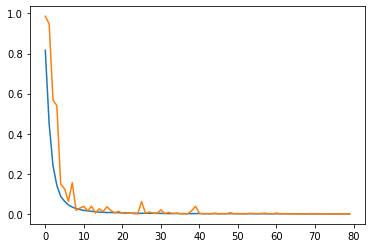

In [19]:
plt.plot(train_history["OptIterHistory"][["FitError","ValidError"]])

### 3.3 Evaluate the EfficientNet Model <a name="evaluate-effb0"></a>

In [20]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, topprobs=5)

NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.


[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read         20622
 1        Number of Observations Used         20622
 2        Misclassification Error (%)      0.935894
 3  Top 5 Misclassification Error (%)      0.145476
 4                         Loss Error       0.03825

+ Elapsed: 26.2s, user: 161s, sys: 5.56s, mem: 1.75e+03mb

After scoring on the test images, the EfficientNet model achieves over 99% accuracy.

### 3.4 Build a Smaller EfficientNet Model<a name="build-smaller-effb0"></a>
We know that EfficientNet-B0 can be scaled up to obtain EfficientNet-B1 to B7 with better accuracy. For our fruits and vegetable classification, the EfficientNet-B0 model is already quit accurate and small. However, for mobile device applications, it is desirable to have a smaller model yet accurate model. 

Next we will show how to scale down the EfficientNet-B0 model for this purpose.

In [15]:
effnetb0_smaller = EfficientNet(conn=s, model_table="EfficientNetB0_Smaller", 
                              n_classes=120,
                              width=100, height=100, 
                              width_coefficient=0.8, depth_coefficient=0.8,
                              offsets=offsets, norm_stds=norm_stds,
                              random_flip="hv", random_crop="resizethencrop", random_mutation="random"
                             )

NOTE: Model compiled successfully.


We instantiate a smaller EfficientNet model than the Efficient-B0 by scaling network's input size, width and depth. This is done by specifying both width and height = 100, which is the same as the image size in the training data set. The depth and the width are both shrinked by .8 of the EfficientB0. 

## Summary on the model architecture

In [16]:
effnetb0_smaller.print_summary()

Layer Id                        Layer        Type Kernel Size  Stride  \
0          0                         data       input                       
1          1                        Conv1       convo      (3, 3)  (2, 2)   
2          2                     bn_Conv1   batchnorm                       
3          3     stage_1_block_0depthwise  groupconvo      (3, 3)  (1, 1)   
4          4  stage_1_block_0depthwise_BN   batchnorm                       
..       ...                          ...         ...         ...     ...   
178      178                  Conv_top_bn   batchnorm                       
179      179              Global_avg_pool        pool      (4, 4)  (1, 1)   
180      180                OutputLayer_2      output                       
181                                                                         
182  Summary                                                                

    Activation    Output Size        Number of Parameters FLOPS(forward pass)  
0         None  (100, 100, 3)                      (0, 0)                   0  
1     Identity   (50, 50, 24)                    (648, 0)             1620000  
2         Relu   (50, 50, 24)                     (0, 48)                   0  
3     Identity   (50, 50, 24)                    (216, 0)              540000  
4         Relu   (50, 50, 24)                     (0, 48)                   0  
..         ...            ...                         ...                 ...  
178       Relu   (4, 4, 1024)                   (0, 2048)                   0  
179       Mean   (1, 1, 1024)                      (0, 0)                   0  
180    Softmax            120               (122880, 120)                   0  
181                            Total number of parameters         Total FLOPS  
182                                             2,689,616          69,964,672  

[183 rows x 9 columns]

### 3.5 Train the Smaller EfficientNet Model<a name="train-smaller-effb0"></a>

In [24]:
# start training
model= effnetb0_smaller
print(model.model_name)

train_history = model.fit(data = train_data,
                      valid_table = validation_data,
                      n_threads=nThread, record_seed=13309, optimizer=optimizer,
                      inputs = ['_image_'], 
                      gpu = gpu,train_from_scratch =True)


EfficientNetB0_Smaller
NOTE: Training from scratch.
NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 2689616.
NOTE:  The approximate memory cost is 103.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       3.12 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 128.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:    120
NOTE:  Levels for the target variable:
NOTE:  Level      0: Apple Braeburn     
NOTE:  Level      1: Apple Crimson Snow 
NOTE:  Level      2: Apple Golden 1     
NOTE:  Level      3: Apple Golden 2     
NOTE:  Level      4: Apple Golden 3     
NOTE:  Level      5: Apple Granny Smith 
NOTE:  Level      6: Apple Pink Lady    
NOTE:  Level      7: Apple

NOTE:     35   128    0.001            4.782     0.9609      8.637     0.03
NOTE:     36   128    0.001             4.77     0.9844      8.636     0.03
NOTE:     37   128    0.001            4.866     0.9844      8.636     0.03
NOTE:     38   128    0.001            4.815          1      8.636     0.03
NOTE:     39   128    0.001            4.825          1      8.636     0.03
NOTE:     40   128    0.001            4.775     0.9844      8.636     0.03
NOTE:     41   128    0.001            4.748     0.9922      8.636     0.03
NOTE:     42   128    0.001             4.82          1      8.636     0.03
NOTE:     43   128    0.001            4.828     0.9844      8.635     0.03
NOTE:     44   128    0.001            4.791     0.9922      8.635     0.03
NOTE:     45   128    0.001            4.791     0.9844      8.635     0.03
NOTE:     46   128    0.001            4.824     0.9922      8.635     0.03
NOTE:     47   128    0.001            4.816     0.9844      8.635     0.03
NOTE:     48

NOTE:    151   128    0.001            4.604     0.9609      8.617     0.04
NOTE:    152   128    0.001            4.629     0.9609      8.617     0.03
NOTE:    153   128    0.001            4.597     0.9453      8.617     0.03
NOTE:    154   128    0.001            4.623     0.9453      8.617     0.03
NOTE:    155   128    0.001            4.521     0.9297      8.617     0.04
NOTE:    156   128    0.001            4.632     0.9453      8.617     0.03
NOTE:    157   128    0.001            4.635     0.9453      8.616     0.03
NOTE:    158   128    0.001            4.544     0.9531      8.616     0.03
NOTE:    159   128    0.001            4.604     0.9688      8.616     0.03
NOTE:    160   128    0.001             4.63     0.9609      8.616     0.03
NOTE:    161   128    0.001            4.577     0.9766      8.616     0.03
NOTE:    162   128    0.001            4.616     0.9688      8.616     0.03
NOTE:    163   128    0.001            4.542     0.9453      8.615     0.03
NOTE:    164

NOTE:    264   128    0.001             3.94     0.8594      8.599     0.03
NOTE:    265   128    0.001            4.119     0.8984      8.599     0.03
NOTE:    266   128    0.001            4.109     0.9141      8.598     0.03
NOTE:    267   128    0.001            4.046     0.8594      8.598     0.04
NOTE:    268   128    0.001            3.995     0.8906      8.598     0.03
NOTE:    269   128    0.001            3.983     0.8828      8.598     0.03
NOTE:    270   128    0.001            3.851     0.8516      8.598     0.03
NOTE:    271   128    0.001            3.948     0.8828      8.598     0.03
NOTE:    272   128    0.001            4.052     0.9297      8.597     0.03
NOTE:    273   128    0.001            3.935     0.8594      8.597     0.03
NOTE:    274   128    0.001            3.911      0.875      8.597     0.03
NOTE:    275   128    0.001            3.912     0.8906      8.597     0.03
NOTE:    276   128    0.001            3.998     0.8984      8.597     0.03
NOTE:    277

NOTE:    373   128    0.001            3.376     0.7656      8.581     0.03
NOTE:    374   128    0.001            3.425     0.7813      8.581     0.03
NOTE:    375   128    0.001            3.499     0.8438      8.581     0.03
NOTE:    376   128    0.001            3.503     0.8047      8.581     0.03
NOTE:    377   128    0.001            3.356     0.7656      8.581     0.03
NOTE:    378   128    0.001            3.378     0.7969       8.58     0.03
NOTE:    379   128    0.001            3.328     0.7656       8.58     0.03
NOTE:    380   128    0.001            3.214     0.7109       8.58     0.04
NOTE:    381   128    0.001            3.325     0.7188       8.58     0.04
NOTE:    382   128    0.001             3.41     0.8047       8.58     0.03
NOTE:    383   128    0.001            3.249     0.7891       8.58     0.03
NOTE:    384   128    0.001            3.343     0.7656      8.579     0.03
NOTE:    385   128    0.001             3.33     0.7266      8.579     0.03
NOTE:    386

NOTE:     12   128    0.001            3.165     0.7578      8.574     0.03
NOTE:     13   128    0.001            3.221       0.75      8.574     0.03
NOTE:     14   128    0.001            3.091     0.7578      8.573     0.03
NOTE:     15   128    0.001            3.151     0.7344      8.573     0.03
NOTE:     16   128    0.001            3.317     0.7656      8.573     0.03
NOTE:     17   128    0.001            3.042     0.7109      8.573     0.03
NOTE:     18   128    0.001            3.421     0.8203      8.573     0.03
NOTE:     19   128    0.001            3.166     0.7578      8.573     0.03
NOTE:     20   128    0.001            3.322     0.7656      8.572     0.03
NOTE:     21   128    0.001            3.235       0.75      8.572     0.03
NOTE:     22   128    0.001            3.313     0.8203      8.572     0.03
NOTE:     23   128    0.001            3.327     0.8047      8.572     0.03
NOTE:     24   128    0.001            3.358     0.8516      8.572     0.03
NOTE:     25

NOTE:    123   128    0.001            2.641     0.6406      8.557     0.03
NOTE:    124   128    0.001            2.664     0.6563      8.556     0.03
NOTE:    125   128    0.001            2.752     0.7188      8.556     0.03
NOTE:    126   128    0.001            2.629      0.625      8.556     0.03
NOTE:    127   128    0.001            2.782     0.6797      8.556     0.03
NOTE:    128   128    0.001            2.725     0.6484      8.556     0.03
NOTE:    129   128    0.001            2.597     0.6094      8.556     0.03
NOTE:    130   128    0.001            2.602     0.6406      8.556     0.03
NOTE:    131   128    0.001             2.67     0.6328      8.555     0.03
NOTE:    132   128    0.001            2.545     0.6328      8.555     0.03
NOTE:    133   128    0.001            2.607     0.6563      8.555     0.03
NOTE:    134   128    0.001            2.672     0.6484      8.555     0.03
NOTE:    135   128    0.001            2.637     0.5859      8.555     0.03
NOTE:    136

NOTE:    233   128    0.001            2.195     0.5313       8.54     0.03
NOTE:    234   128    0.001            2.253     0.5625       8.54     0.03
NOTE:    235   128    0.001            2.542     0.6797       8.54     0.03
NOTE:    236   128    0.001            2.318     0.5313       8.54     0.03
NOTE:    237   128    0.001            2.221     0.5703      8.539     0.03
NOTE:    238   128    0.001            2.478     0.6328      8.539     0.03
NOTE:    239   128    0.001            2.258     0.5469      8.539     0.03
NOTE:    240   128    0.001            2.188     0.5391      8.539     0.03
NOTE:    241   128    0.001            2.548     0.6797      8.539     0.03
NOTE:    242   128    0.001             2.17     0.5078      8.539     0.03
NOTE:    243   128    0.001            2.314     0.5781      8.538     0.03
NOTE:    244   128    0.001            2.112     0.4922      8.538     0.03
NOTE:    245   128    0.001            2.328     0.5625      8.538     0.03
NOTE:    246

NOTE:    345   128    0.001                2     0.5313      8.523     0.03
NOTE:    346   128    0.001             2.17     0.5156      8.523     0.03
NOTE:    347   128    0.001            1.986     0.4297      8.523     0.03
NOTE:    348   128    0.001            1.865     0.3906      8.523     0.03
NOTE:    349   128    0.001            1.864     0.4766      8.523     0.03
NOTE:    350   128    0.001            1.989     0.4453      8.522     0.03
NOTE:    351   128    0.001            1.987     0.4766      8.522     0.03
NOTE:    352   128    0.001            2.252     0.5391      8.522     0.03
NOTE:    353   128    0.001            1.929     0.5156      8.522     0.03
NOTE:    354   128    0.001            1.818     0.4844      8.522     0.03
NOTE:    355   128    0.001            1.892     0.4375      8.522     0.03
NOTE:    356   128    0.001            2.044     0.5469      8.522     0.03
NOTE:    357   128    0.001            1.979     0.4453      8.521     0.03
NOTE:    358

NOTE:     55   128    0.001            5.374      0.875     0.03
NOTE:     56   128    0.001             5.05     0.8594     0.03
NOTE:     57   128    0.001            5.194     0.9141     0.03
NOTE:     58   128    0.001            5.005     0.8516     0.03
NOTE:     59   128    0.001            5.154     0.8828     0.03
NOTE:     60   128    0.001             5.61     0.9297     0.03
NOTE:     61   128    0.001            4.916     0.8906     0.03
NOTE:     62   128    0.001            5.331     0.8984     0.03
NOTE:     63   128    0.001            5.097     0.8984     0.03
NOTE:     64   128    0.001            5.127      0.875     0.03
NOTE:     65   128    0.001            4.679     0.8438     0.03
NOTE:     66   128    0.001            5.269     0.8828     0.03
NOTE:     67   128    0.001            5.767     0.8828     0.03
NOTE:     68   128    0.001            5.044     0.9219     0.03
NOTE:     69   128    0.001            5.087     0.8281     0.03
NOTE:     70   128    0.0

NOTE:     91   128    0.001            1.411     0.2578        8.5     0.03
NOTE:     92   128    0.001            1.553     0.3906        8.5     0.03
NOTE:     93   128    0.001            1.613     0.3906        8.5     0.03
NOTE:     94   128    0.001            1.474      0.375        8.5     0.03
NOTE:     95   128    0.001            1.563     0.3516      8.499     0.03
NOTE:     96   128    0.001            1.536     0.3984      8.499     0.03
NOTE:     97   128    0.001            1.562     0.4297      8.499     0.03
NOTE:     98   128    0.001            1.586     0.4141      8.499     0.03
NOTE:     99   128    0.001            1.377     0.2734      8.499     0.04
NOTE:    100   128    0.001             1.58     0.4141      8.499     0.03
NOTE:    101   128    0.001            1.579     0.3906      8.499     0.03
NOTE:    102   128    0.001            1.519     0.3672      8.498     0.03
NOTE:    103   128    0.001            1.578     0.3672      8.498     0.03
NOTE:    104

NOTE:    204   128    0.001            1.577     0.3516      8.483     0.03
NOTE:    205   128    0.001            1.458     0.3984      8.483     0.03
NOTE:    206   128    0.001            1.416     0.3906      8.483     0.03
NOTE:    207   128    0.001            1.469     0.3438      8.483     0.03
NOTE:    208   128    0.001              1.3     0.3438      8.483     0.03
NOTE:    209   128    0.001            1.244     0.3203      8.482     0.03
NOTE:    210   128    0.001            1.528     0.4297      8.482     0.03
NOTE:    211   128    0.001            1.553     0.4297      8.482     0.03
NOTE:    212   128    0.001            1.331     0.3359      8.482     0.03
NOTE:    213   128    0.001            1.777     0.4688      8.482     0.03
NOTE:    214   128    0.001            1.313     0.2422      8.482     0.03
NOTE:    215   128    0.001            1.305     0.2891      8.481     0.03
NOTE:    216   128    0.001            1.359     0.3594      8.481     0.03
NOTE:    217

NOTE:    314   128    0.001            1.038       0.25      8.467     0.03
NOTE:    315   128    0.001            1.341     0.3047      8.467     0.03
NOTE:    316   128    0.001            1.274     0.2891      8.466     0.03
NOTE:    317   128    0.001            1.276     0.3125      8.466     0.03
NOTE:    318   128    0.001             1.22     0.2891      8.466     0.03
NOTE:    319   128    0.001            1.182       0.25      8.466     0.03
NOTE:    320   128    0.001            1.179     0.3047      8.466     0.03
NOTE:    321   128    0.001            1.194     0.2578      8.466     0.03
NOTE:    322   128    0.001             1.11       0.25      8.465     0.03
NOTE:    323   128    0.001            1.372     0.3828      8.465     0.03
NOTE:    324   128    0.001           0.9804     0.2109      8.465     0.03
NOTE:    325   128    0.001            1.022     0.2109      8.465     0.03
NOTE:    326   128    0.001            1.124     0.2578      8.465     0.03
NOTE:    327

NOTE:     24   128    0.001             2.81     0.7031     0.03
NOTE:     25   128    0.001            2.467     0.7109     0.03
NOTE:     26   128    0.001            2.482     0.6797     0.03
NOTE:     27   128    0.001            2.433      0.625     0.03
NOTE:     28   128    0.001            2.741     0.6953     0.03
NOTE:     29   128    0.001            2.364     0.6484     0.03
NOTE:     30   128    0.001            2.733     0.6406     0.03
NOTE:     31   128    0.001            2.855     0.6797     0.03
NOTE:     32   128    0.001            2.774      0.625     0.03
NOTE:     33   128    0.001            2.714     0.6875     0.03
NOTE:     34   128    0.001             2.64     0.6484     0.03
NOTE:     35   128    0.001            2.679     0.7188     0.03
NOTE:     36   128    0.001            2.688     0.6719     0.03
NOTE:     37   128    0.001            2.691     0.6875     0.03
NOTE:     38   128    0.001            2.757     0.6797     0.03
NOTE:     39   128    0.0

NOTE:     71   128    0.001            1.129     0.3203      8.442     0.03
NOTE:     72   128    0.001           0.9862     0.1875      8.442     0.03
NOTE:     73   128    0.001            1.013     0.2813      8.442     0.03
NOTE:     74   128    0.001            1.272     0.3359      8.441     0.03
NOTE:     75   128    0.001            1.005     0.2422      8.441     0.03
NOTE:     76   128    0.001            0.816     0.1641      8.441     0.03
NOTE:     77   128    0.001            1.053     0.2656      8.441     0.03
NOTE:     78   128    0.001            1.075     0.2813      8.441     0.03
NOTE:     79   128    0.001            1.127     0.2578      8.441     0.03
NOTE:     80   128    0.001             1.35     0.3594       8.44     0.03
NOTE:     81   128    0.001            1.016       0.25       8.44     0.03
NOTE:     82   128    0.001            1.019     0.2578       8.44     0.03
NOTE:     83   128    0.001           0.8353     0.1953       8.44     0.03
NOTE:     84

NOTE:    188   128    0.001           0.9003     0.2656      8.424     0.03
NOTE:    189   128    0.001           0.8186     0.2109      8.424     0.03
NOTE:    190   128    0.001            1.073     0.3125      8.424     0.03
NOTE:    191   128    0.001            1.008     0.2891      8.424     0.03
NOTE:    192   128    0.001           0.8769     0.2344      8.424     0.03
NOTE:    193   128    0.001           0.9406     0.2344      8.423     0.03
NOTE:    194   128    0.001           0.7606     0.2109      8.423     0.03
NOTE:    195   128    0.001                1       0.25      8.423     0.03
NOTE:    196   128    0.001            1.086     0.3281      8.423     0.03
NOTE:    197   128    0.001           0.9123     0.2422      8.423     0.03
NOTE:    198   128    0.001            1.017     0.2266      8.423     0.03
NOTE:    199   128    0.001            1.084       0.25      8.423     0.03
NOTE:    200   128    0.001           0.9157     0.2031      8.422     0.03
NOTE:    201

NOTE:    306   128    0.001           0.8037     0.1953      8.406     0.03
NOTE:    307   128    0.001           0.7741     0.1953      8.406     0.03
NOTE:    308   128    0.001            0.842     0.1797      8.406     0.03
NOTE:    309   128    0.001           0.8848     0.2422      8.406     0.03
NOTE:    310   128    0.001             0.87     0.2109      8.406     0.03
NOTE:    311   128    0.001           0.6852     0.2031      8.406     0.03
NOTE:    312   128    0.001           0.8155     0.2344      8.406     0.03
NOTE:    313   128    0.001           0.6708     0.1563      8.405     0.03
NOTE:    314   128    0.001           0.7401     0.1484      8.405     0.03
NOTE:    315   128    0.001           0.9328     0.2578      8.405     0.03
NOTE:    316   128    0.001           0.7935     0.2031      8.405     0.03
NOTE:    317   128    0.001           0.9173     0.2578      8.405     0.03
NOTE:    318   128    0.001           0.8795     0.2813      8.405     0.03
NOTE:    319

NOTE:      8   128    0.001            1.172     0.2813     0.03
NOTE:      9   128    0.001            1.041     0.2656     0.03
NOTE:     10   128    0.001            1.172     0.3281     0.03
NOTE:     11   128    0.001            1.189     0.3203     0.03
NOTE:     12   128    0.001             1.27     0.3438     0.03
NOTE:     13   128    0.001            1.138     0.2969     0.03
NOTE:     14   128    0.001           0.9871     0.2813     0.03
NOTE:     15   128    0.001            1.122     0.3125     0.03
NOTE:     16   128    0.001            1.157       0.25     0.03
NOTE:     17   128    0.001                1     0.2656     0.03
NOTE:     18   128    0.001            1.096     0.3125     0.03
NOTE:     19   128    0.001            1.153     0.3047     0.03
NOTE:     20   128    0.001            1.021       0.25     0.03
NOTE:     21   128    0.001             1.05     0.3125     0.03
NOTE:     22   128    0.001            1.303     0.3047     0.03
NOTE:     23   128    0.0

NOTE:     50   128    0.001           0.6599     0.1797      8.383     0.03
NOTE:     51   128    0.001           0.7572     0.1875      8.383     0.03
NOTE:     52   128    0.001           0.5733     0.1406      8.383     0.03
NOTE:     53   128    0.001           0.6539     0.1484      8.383     0.03
NOTE:     54   128    0.001           0.6656     0.1406      8.383     0.03
NOTE:     55   128    0.001           0.6317      0.125      8.383     0.03
NOTE:     56   128    0.001           0.8361     0.1953      8.382     0.03
NOTE:     57   128    0.001           0.5446    0.09375      8.382     0.03
NOTE:     58   128    0.001            0.689      0.125      8.382     0.03
NOTE:     59   128    0.001           0.7025     0.1641      8.382     0.03
NOTE:     60   128    0.001           0.8171     0.1797      8.382     0.03
NOTE:     61   128    0.001           0.6885     0.1719      8.382     0.03
NOTE:     62   128    0.001           0.6517     0.1641      8.381     0.03
NOTE:     63

NOTE:    165   128    0.001           0.6134     0.1328      8.366     0.03
NOTE:    166   128    0.001           0.6059     0.1484      8.366     0.03
NOTE:    167   128    0.001           0.5045     0.1328      8.366     0.03
NOTE:    168   128    0.001            0.567     0.1016      8.365     0.03
NOTE:    169   128    0.001           0.6615     0.1797      8.365     0.03
NOTE:    170   128    0.001           0.5219      0.125      8.365     0.03
NOTE:    171   128    0.001           0.4816     0.1172      8.365     0.03
NOTE:    172   128    0.001           0.4251    0.08594      8.365     0.03
NOTE:    173   128    0.001           0.6899     0.1875      8.365     0.03
NOTE:    174   128    0.001           0.6015     0.1563      8.364     0.03
NOTE:    175   128    0.001           0.5271     0.1328      8.364     0.03
NOTE:    176   128    0.001           0.5929     0.1797      8.364     0.03
NOTE:    177   128    0.001           0.7055     0.1563      8.364     0.03
NOTE:    178

NOTE:    273   128    0.001            0.594     0.1328      8.349     0.03
NOTE:    274   128    0.001           0.3726    0.05469      8.349     0.03
NOTE:    275   128    0.001           0.5081     0.1406      8.349     0.03
NOTE:    276   128    0.001           0.5847     0.1328      8.349     0.03
NOTE:    277   128    0.001           0.5469     0.1641      8.349     0.03
NOTE:    278   128    0.001           0.5331     0.1406      8.349     0.03
NOTE:    279   128    0.001             0.57     0.1563      8.348     0.03
NOTE:    280   128    0.001           0.4609     0.1016      8.348     0.03
NOTE:    281   128    0.001           0.6184     0.1406      8.348     0.03
NOTE:    282   128    0.001           0.5793     0.1328      8.348     0.03
NOTE:    283   128    0.001           0.5328     0.1563      8.348     0.03
NOTE:    284   128    0.001           0.7127     0.1875      8.348     0.03
NOTE:    285   128    0.001           0.5357     0.1406      8.348     0.03
NOTE:    286

NOTE:    381   128    0.001           0.4162     0.1016      8.333     0.03
NOTE:    382   128    0.001           0.4937     0.1016      8.333     0.03
NOTE:    383   128    0.001            0.601     0.1641      8.333     0.03
NOTE:    384   128    0.001           0.5877     0.1484      8.332     0.03
NOTE:    385   128    0.001           0.4099    0.07813      8.332     0.03
NOTE:    386   128    0.001           0.5144     0.1328      8.332     0.03
NOTE:    387   128    0.001           0.4412    0.07031      8.332     0.03
NOTE:    388   128    0.001           0.6087     0.1563      8.332     0.03
NOTE:    389   128    0.001           0.5021     0.1484      8.332     0.03
NOTE:    390   128    0.001           0.4762    0.09375      8.332     0.03
NOTE:    391   128    0.001           0.5621     0.1328      8.331     0.03
NOTE:    392   128    0.001           0.3898     0.1016      8.331     0.03
NOTE:    393   128    0.001           0.5028      0.125      8.331     0.03
NOTE:    394

NOTE:     14   128    0.001           0.4899      0.125      8.326     0.03
NOTE:     15   128    0.001           0.5471     0.1328      8.326     0.03
NOTE:     16   128    0.001           0.4428     0.1094      8.326     0.03
NOTE:     17   128    0.001           0.6521      0.125      8.326     0.03
NOTE:     18   128    0.001           0.5193      0.125      8.326     0.03
NOTE:     19   128    0.001           0.3474    0.07031      8.326     0.03
NOTE:     20   128    0.001           0.5737     0.1563      8.326     0.03
NOTE:     21   128    0.001           0.5495     0.1172      8.325     0.03
NOTE:     22   128    0.001           0.4917     0.1328      8.325     0.03
NOTE:     23   128    0.001           0.4183     0.1016      8.325     0.03
NOTE:     24   128    0.001           0.5341     0.1641      8.325     0.03
NOTE:     25   128    0.001           0.4569    0.09375      8.325     0.03
NOTE:     26   128    0.001           0.5978     0.1641      8.325     0.03
NOTE:     27

NOTE:    128   128    0.001           0.4043    0.09375      8.309     0.03
NOTE:    129   128    0.001           0.3921    0.08594      8.309     0.03
NOTE:    130   128    0.001           0.4965     0.1172      8.309     0.03
NOTE:    131   128    0.001           0.7109     0.1797      8.309     0.03
NOTE:    132   128    0.001           0.5311     0.1016      8.308     0.03
NOTE:    133   128    0.001           0.5787     0.1563      8.308     0.03
NOTE:    134   128    0.001           0.4821      0.125      8.308     0.03
NOTE:    135   128    0.001           0.4748     0.1172      8.308     0.03
NOTE:    136   128    0.001           0.4625    0.09375      8.308     0.03
NOTE:    137   128    0.001           0.4867     0.1172      8.308     0.03
NOTE:    138   128    0.001           0.5388     0.1328      8.307     0.03
NOTE:    139   128    0.001           0.5972     0.1563      8.307     0.03
NOTE:    140   128    0.001           0.4151     0.1016      8.307     0.03
NOTE:    141

NOTE:    242   128    0.001           0.3556    0.07031      8.292     0.03
NOTE:    243   128    0.001           0.4843     0.1328      8.291     0.03
NOTE:    244   128    0.001            0.411     0.1172      8.291     0.03
NOTE:    245   128    0.001            0.415     0.1016      8.291     0.03
NOTE:    246   128    0.001           0.4729     0.1406      8.291     0.03
NOTE:    247   128    0.001           0.3852    0.07813      8.291     0.03
NOTE:    248   128    0.001           0.3157     0.0625      8.291     0.03
NOTE:    249   128    0.001           0.3851    0.09375      8.291     0.03
NOTE:    250   128    0.001           0.4961     0.1328       8.29     0.03
NOTE:    251   128    0.001           0.4928     0.1406       8.29     0.03
NOTE:    252   128    0.001           0.3384     0.0625       8.29     0.03
NOTE:    253   128    0.001           0.5086      0.125       8.29     0.03
NOTE:    254   128    0.001           0.3851    0.08594       8.29     0.03
NOTE:    255

NOTE:    356   128    0.001           0.3286    0.04688      8.274     0.03
NOTE:    357   128    0.001           0.3195    0.08594      8.274     0.03
NOTE:    358   128    0.001           0.2916    0.05469      8.274     0.03
NOTE:    359   128    0.001           0.4378     0.1328      8.274     0.03
NOTE:    360   128    0.001           0.3382     0.1016      8.273     0.03
NOTE:    361   128    0.001           0.3681    0.09375      8.273     0.03
NOTE:    362   128    0.001           0.2921     0.0625      8.273     0.03
NOTE:    363   128    0.001           0.4764     0.1016      8.273     0.03
NOTE:    364   128    0.001           0.3223    0.07813      8.273     0.04
NOTE:    365   128    0.001           0.4729      0.125      8.273     0.03
NOTE:    366   128    0.001           0.4257    0.08594      8.273     0.03
NOTE:    367   128    0.001           0.2857    0.05469      8.272     0.03
NOTE:    368   128    0.001           0.3803    0.08594      8.272     0.03
NOTE:    369

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001           0.3206    0.08594      8.266     0.06
NOTE:      1   128    0.001           0.4478    0.08594      8.266     0.03
NOTE:      2   128    0.001            0.489     0.1563      8.266     0.03
NOTE:      3   128    0.001           0.4195      0.125      8.265     0.03
NOTE:      4   128    0.001           0.4207    0.09375      8.265     0.03
NOTE:      5   128    0.001           0.5127      0.125      8.265     0.03
NOTE:      6   128    0.001           0.3705    0.08594      8.265     0.03
NOTE:      7   128    0.001           0.3311     0.0625      8.265     0.03
NOTE:      8   128    0.001           0.2459    0.05469      8.265     0.03
NOTE:      9   128    0.001           0.4261     0.1172      8.265     0.03
NOTE:     10   128    0.001           0.3176    0.07031      8.264     0.03
NOTE:     11   128    0.001           0.3166    0.04688      8.264     0.03


NOTE:    108   128    0.001            0.364     0.1094      8.249     0.03
NOTE:    109   128    0.001           0.4737     0.1172      8.249     0.03
NOTE:    110   128    0.001           0.4416     0.1172      8.249     0.03
NOTE:    111   128    0.001           0.2995    0.07031      8.249     0.03
NOTE:    112   128    0.001           0.3495    0.07031      8.249     0.03
NOTE:    113   128    0.001           0.3099    0.08594      8.249     0.03
NOTE:    114   128    0.001           0.2926    0.09375      8.248     0.03
NOTE:    115   128    0.001            0.386    0.09375      8.248     0.03
NOTE:    116   128    0.001           0.2867     0.0625      8.248     0.03
NOTE:    117   128    0.001           0.3385    0.09375      8.248     0.03
NOTE:    118   128    0.001           0.3297    0.07813      8.248     0.03
NOTE:    119   128    0.001           0.4205     0.1016      8.248     0.04
NOTE:    120   128    0.001            0.314    0.07031      8.248     0.03
NOTE:    121

NOTE:    223   128    0.001           0.2162    0.03125      8.232     0.03
NOTE:    224   128    0.001           0.2867    0.05469      8.232     0.03
NOTE:    225   128    0.001           0.3504    0.07813      8.231     0.03
NOTE:    226   128    0.001           0.2445    0.04688      8.231     0.03
NOTE:    227   128    0.001           0.2802     0.0625      8.231     0.03
NOTE:    228   128    0.001           0.3184    0.07031      8.231     0.03
NOTE:    229   128    0.001            0.292    0.05469      8.231     0.03
NOTE:    230   128    0.001           0.2048    0.03125      8.231     0.03
NOTE:    231   128    0.001           0.4349     0.1328       8.23     0.03
NOTE:    232   128    0.001           0.3684    0.08594       8.23     0.03
NOTE:    233   128    0.001           0.4392     0.1328       8.23     0.03
NOTE:    234   128    0.001           0.3091    0.07031       8.23     0.03
NOTE:    235   128    0.001           0.3114    0.07813       8.23     0.03
NOTE:    236

NOTE:    333   128    0.001           0.2771    0.07813      8.215     0.03
NOTE:    334   128    0.001            0.256    0.07031      8.215     0.03
NOTE:    335   128    0.001           0.2747    0.07031      8.214     0.03
NOTE:    336   128    0.001           0.3854    0.09375      8.214     0.03
NOTE:    337   128    0.001           0.4086      0.125      8.214     0.03
NOTE:    338   128    0.001           0.3252    0.09375      8.214     0.03
NOTE:    339   128    0.001           0.2325    0.05469      8.214     0.03
NOTE:    340   128    0.001           0.3679     0.0625      8.214     0.03
NOTE:    341   128    0.001           0.4527    0.08594      8.213     0.03
NOTE:    342   128    0.001           0.2558    0.05469      8.213     0.03
NOTE:    343   128    0.001             0.31    0.09375      8.213     0.03
NOTE:    344   128    0.001           0.2164    0.03906      8.213     0.03
NOTE:    345   128    0.001           0.3541     0.1094      8.213     0.03
NOTE:    346

NOTE:     37   128    0.001           0.2264    0.05469     0.03
NOTE:     38   128    0.001           0.2672    0.07031     0.03
NOTE:     39   128    0.001           0.2887     0.1094     0.03
NOTE:     40   128    0.001           0.3102    0.07031     0.03
NOTE:     41   128    0.001           0.3016    0.07031     0.03
NOTE:     42   128    0.001           0.1799    0.03906     0.03
NOTE:     43   128    0.001           0.4226     0.1406     0.03
NOTE:     44   128    0.001           0.2077    0.05469     0.03
NOTE:     45   128    0.001           0.3418    0.07813     0.03
NOTE:     46   128    0.001           0.3162    0.08594     0.03
NOTE:     47   128    0.001           0.2935    0.08594     0.03
NOTE:     48   128    0.001           0.3434     0.1016     0.03
NOTE:     49   128    0.001           0.2253    0.04688     0.03
NOTE:     50   128    0.001           0.2891     0.1016     0.03
NOTE:     51   128    0.001           0.2835    0.07813     0.03
NOTE:     52   128    0.0

NOTE:     83   128    0.001           0.2337     0.0625       8.19     0.03
NOTE:     84   128    0.001           0.2908     0.0625       8.19     0.03
NOTE:     85   128    0.001           0.3421    0.09375       8.19     0.03
NOTE:     86   128    0.001           0.3112     0.0625       8.19     0.03
NOTE:     87   128    0.001           0.3565     0.1094       8.19     0.03
NOTE:     88   128    0.001           0.3266    0.09375      8.189     0.03
NOTE:     89   128    0.001           0.2415     0.0625      8.189     0.03
NOTE:     90   128    0.001           0.2328     0.0625      8.189     0.03
NOTE:     91   128    0.001           0.5113     0.1484      8.189     0.03
NOTE:     92   128    0.001           0.3255    0.07813      8.189     0.03
NOTE:     93   128    0.001           0.2213    0.02344      8.189     0.03
NOTE:     94   128    0.001           0.3829     0.1406      8.188     0.03
NOTE:     95   128    0.001           0.2205    0.05469      8.188     0.03
NOTE:     96

NOTE:    201   128    0.001           0.2871    0.07813      8.172     0.03
NOTE:    202   128    0.001           0.3264    0.08594      8.172     0.03
NOTE:    203   128    0.001           0.2303    0.03125      8.172     0.03
NOTE:    204   128    0.001           0.2912    0.07813      8.172     0.03
NOTE:    205   128    0.001           0.2791    0.08594      8.171     0.03
NOTE:    206   128    0.001           0.1962    0.03125      8.171     0.03
NOTE:    207   128    0.001           0.1643    0.04688      8.171     0.03
NOTE:    208   128    0.001           0.2043    0.04688      8.171     0.03
NOTE:    209   128    0.001           0.2175    0.04688      8.171     0.03
NOTE:    210   128    0.001           0.2474    0.03906      8.171     0.03
NOTE:    211   128    0.001           0.3201    0.09375       8.17     0.03
NOTE:    212   128    0.001           0.2403    0.03125       8.17     0.03
NOTE:    213   128    0.001           0.2729    0.05469       8.17     0.03
NOTE:    214

NOTE:    317   128    0.001           0.2785    0.07813      8.154     0.03
NOTE:    318   128    0.001           0.2868     0.0625      8.154     0.03
NOTE:    319   128    0.001           0.2931     0.0625      8.154     0.03
NOTE:    320   128    0.001           0.2428    0.07813      8.154     0.03
NOTE:    321   128    0.001           0.2684    0.07031      8.153     0.03
NOTE:    322   128    0.001            0.187    0.03906      8.153     0.03
NOTE:    323   128    0.001            0.235    0.03906      8.153     0.03
NOTE:    324   128    0.001           0.2381     0.0625      8.153     0.03
NOTE:    325   128    0.001           0.1652    0.01563      8.153     0.03
NOTE:    326   128    0.001           0.2567    0.07031      8.153     0.03
NOTE:    327   128    0.001           0.2395    0.08594      8.153     0.03
NOTE:    328   128    0.001             0.24    0.07031      8.152     0.03
NOTE:    329   128    0.001           0.2676    0.08594      8.152     0.03
NOTE:    330

NOTE:     27   128    0.001           0.2712    0.07031     0.03
NOTE:     28   128    0.001           0.2538    0.08594     0.03
NOTE:     29   128    0.001            0.241    0.07031     0.03
NOTE:     30   128    0.001           0.2817    0.07031     0.03
NOTE:     31   128    0.001           0.2379    0.07031     0.03
NOTE:     32   128    0.001           0.2375    0.05469     0.03
NOTE:     33   128    0.001           0.2166    0.05469     0.03
NOTE:     34   128    0.001           0.1689    0.03906     0.03
NOTE:     35   128    0.001           0.3631     0.1094     0.03
NOTE:     36   128    0.001           0.3091     0.1016     0.03
NOTE:     37   128    0.001           0.2144    0.07031     0.03
NOTE:     38   128    0.001            0.251    0.07031     0.03
NOTE:     39   128    0.001           0.2133    0.08594     0.03
NOTE:     40   128    0.001           0.2222    0.05469     0.03
NOTE:     41   128    0.001           0.2416    0.07813     0.03
NOTE:     42   128    0.0

NOTE:     70   128    0.001           0.2306     0.0625      8.129     0.03
NOTE:     71   128    0.001           0.1843    0.04688      8.129     0.03
NOTE:     72   128    0.001           0.1999    0.05469      8.129     0.03
NOTE:     73   128    0.001           0.1465    0.03125      8.129     0.03
NOTE:     74   128    0.001           0.1679    0.03125      8.128     0.03
NOTE:     75   128    0.001           0.2096    0.05469      8.128     0.03
NOTE:     76   128    0.001           0.1753    0.03906      8.128     0.04
NOTE:     77   128    0.001            0.371    0.09375      8.128     0.03
NOTE:     78   128    0.001           0.2115     0.0625      8.128     0.03
NOTE:     79   128    0.001           0.1631    0.02344      8.128     0.03
NOTE:     80   128    0.001           0.1584    0.03125      8.128     0.03
NOTE:     81   128    0.001           0.1626    0.03125      8.127     0.03
NOTE:     82   128    0.001           0.2805    0.07031      8.127     0.03
NOTE:     83

NOTE:    182   128    0.001           0.1987    0.04688      8.112     0.03
NOTE:    183   128    0.001           0.2612    0.05469      8.112     0.03
NOTE:    184   128    0.001           0.2521    0.05469      8.112     0.03
NOTE:    185   128    0.001            0.167    0.03125      8.111     0.03
NOTE:    186   128    0.001           0.2533    0.05469      8.111     0.03
NOTE:    187   128    0.001           0.2634     0.0625      8.111     0.03
NOTE:    188   128    0.001           0.2674    0.07031      8.111     0.03
NOTE:    189   128    0.001           0.2533    0.05469      8.111     0.03
NOTE:    190   128    0.001           0.1637    0.02344      8.111     0.03
NOTE:    191   128    0.001           0.1743    0.03125       8.11     0.03
NOTE:    192   128    0.001            0.139    0.03125       8.11     0.03
NOTE:    193   128    0.001           0.3103    0.09375       8.11     0.03
NOTE:    194   128    0.001           0.2682     0.0625       8.11     0.03
NOTE:    195

NOTE:    302   128    0.001           0.1921    0.02344      8.093     0.03
NOTE:    303   128    0.001           0.2638    0.07813      8.093     0.03
NOTE:    304   128    0.001           0.1214   0.007813      8.093     0.03
NOTE:    305   128    0.001           0.2184    0.04688      8.093     0.03
NOTE:    306   128    0.001           0.1673    0.05469      8.093     0.03
NOTE:    307   128    0.001           0.2148     0.0625      8.093     0.03
NOTE:    308   128    0.001            0.321    0.08594      8.092     0.03
NOTE:    309   128    0.001            0.203    0.03125      8.092     0.03
NOTE:    310   128    0.001           0.1963     0.0625      8.092     0.03
NOTE:    311   128    0.001           0.2674     0.0625      8.092     0.03
NOTE:    312   128    0.001            0.196    0.07031      8.092     0.03
NOTE:    313   128    0.001           0.3545    0.07813      8.092     0.03
NOTE:    314   128    0.001           0.2622    0.07813      8.091     0.03
NOTE:    315

NOTE:      3   128    0.001           0.3611     0.1172     0.03
NOTE:      4   128    0.001           0.2407     0.0625     0.03
NOTE:      5   128    0.001           0.2254    0.07031     0.03
NOTE:      6   128    0.001           0.1802    0.04688     0.03
NOTE:      7   128    0.001            0.169    0.03125     0.03
NOTE:      8   128    0.001           0.2155    0.07031     0.03
NOTE:      9   128    0.001           0.2489    0.07813     0.03
NOTE:     10   128    0.001           0.2335     0.0625     0.03
NOTE:     11   128    0.001            0.242    0.05469     0.03
NOTE:     12   128    0.001           0.2984    0.08594     0.03
NOTE:     13   128    0.001           0.1795    0.05469     0.03
NOTE:     14   128    0.001           0.1711    0.03125     0.03
NOTE:     15   128    0.001            0.176    0.03906     0.03
NOTE:     16   128    0.001           0.1902    0.07031     0.03
NOTE:     17   128    0.001           0.2665    0.07813     0.04
NOTE:     18   128    0.0

NOTE:     45   128    0.001           0.2638    0.05469       8.07     0.03
NOTE:     46   128    0.001           0.1638    0.05469       8.07     0.03
NOTE:     47   128    0.001           0.1794    0.03906       8.07     0.03
NOTE:     48   128    0.001            0.162    0.03906       8.07     0.03
NOTE:     49   128    0.001           0.2218    0.04688      8.069     0.03
NOTE:     50   128    0.001            0.147    0.01563      8.069     0.03
NOTE:     51   128    0.001           0.1713    0.03906      8.069     0.03
NOTE:     52   128    0.001           0.1644    0.04688      8.069     0.03
NOTE:     53   128    0.001           0.1086    0.03125      8.069     0.03
NOTE:     54   128    0.001           0.1238    0.01563      8.069     0.03
NOTE:     55   128    0.001            0.263     0.0625      8.068     0.03
NOTE:     56   128    0.001           0.1447    0.02344      8.068     0.03
NOTE:     57   128    0.001           0.2428    0.04688      8.068     0.03
NOTE:     58

NOTE:    160   128    0.001           0.2583    0.07813      8.052     0.03
NOTE:    161   128    0.001           0.1365    0.02344      8.052     0.03
NOTE:    162   128    0.001           0.1665    0.05469      8.052     0.03
NOTE:    163   128    0.001           0.1288    0.03125      8.052     0.03
NOTE:    164   128    0.001           0.1104   0.007813      8.052     0.03
NOTE:    165   128    0.001           0.1621   0.007813      8.052     0.03
NOTE:    166   128    0.001           0.1714    0.04688      8.051     0.03
NOTE:    167   128    0.001           0.1419    0.01563      8.051     0.03
NOTE:    168   128    0.001           0.2914     0.0625      8.051     0.03
NOTE:    169   128    0.001            0.162    0.03906      8.051     0.03
NOTE:    170   128    0.001           0.2212     0.0625      8.051     0.03
NOTE:    171   128    0.001           0.1459    0.02344      8.051     0.03
NOTE:    172   128    0.001           0.2848    0.08594       8.05     0.03
NOTE:    173

NOTE:    268   128    0.001           0.1648    0.03906      8.036     0.03
NOTE:    269   128    0.001           0.1231    0.01563      8.036     0.03
NOTE:    270   128    0.001           0.2545    0.07813      8.035     0.03
NOTE:    271   128    0.001           0.2098    0.05469      8.035     0.03
NOTE:    272   128    0.001           0.1928     0.0625      8.035     0.03
NOTE:    273   128    0.001           0.1753    0.04688      8.035     0.03
NOTE:    274   128    0.001           0.1706     0.0625      8.035     0.03
NOTE:    275   128    0.001           0.1377    0.02344      8.035     0.03
NOTE:    276   128    0.001           0.1607    0.03906      8.034     0.03
NOTE:    277   128    0.001           0.2383    0.05469      8.034     0.03
NOTE:    278   128    0.001           0.1333    0.02344      8.034     0.04
NOTE:    279   128    0.001           0.1065    0.01563      8.034     0.03
NOTE:    280   128    0.001           0.1373    0.02344      8.034     0.03
NOTE:    281

NOTE:    381   128    0.001           0.1096    0.01563      8.018     0.03
NOTE:    382   128    0.001           0.2602    0.05469      8.018     0.03
NOTE:    383   128    0.001            0.102    0.01563      8.018     0.03
NOTE:    384   128    0.001           0.2328     0.0625      8.018     0.03
NOTE:    385   128    0.001            0.232    0.07031      8.018     0.03
NOTE:    386   128    0.001           0.1799    0.04688      8.018     0.03
NOTE:    387   128    0.001           0.1361    0.03906      8.017     0.03
NOTE:    388   128    0.001           0.1371    0.03125      8.017     0.04
NOTE:    389   128    0.001           0.2108    0.08594      8.017     0.03
NOTE:    390   128    0.001           0.1113    0.01563      8.017     0.03
NOTE:    391   128    0.001           0.1209    0.01563      8.017     0.03
NOTE:    392   128    0.001           0.1807    0.03125      8.017     0.03
NOTE:    393   128    0.001           0.1778    0.03906      8.016     0.03
NOTE:    394

NOTE:     17   128    0.001           0.1257    0.02344      8.011     0.03
NOTE:     18   128    0.001            0.241    0.05469      8.011     0.03
NOTE:     19   128    0.001           0.1197    0.02344      8.011     0.03
NOTE:     20   128    0.001           0.1826    0.03125      8.011     0.03
NOTE:     21   128    0.001           0.1637    0.03906      8.011     0.03
NOTE:     22   128    0.001           0.1244    0.02344      8.011     0.03
NOTE:     23   128    0.001           0.2139    0.04688       8.01     0.03
NOTE:     24   128    0.001           0.1367    0.02344       8.01     0.03
NOTE:     25   128    0.001           0.1854    0.04688       8.01     0.03
NOTE:     26   128    0.001           0.1014    0.01563       8.01     0.03
NOTE:     27   128    0.001            0.177    0.03906       8.01     0.03
NOTE:     28   128    0.001           0.1944    0.04688       8.01     0.03
NOTE:     29   128    0.001           0.1816    0.07813       8.01     0.03
NOTE:     30

NOTE:    136   128    0.001            0.293    0.09375      7.993     0.03
NOTE:    137   128    0.001           0.1786    0.04688      7.993     0.03
NOTE:    138   128    0.001           0.2201    0.04688      7.993     0.03
NOTE:    139   128    0.001           0.1138    0.03906      7.993     0.03
NOTE:    140   128    0.001           0.1227    0.02344      7.993     0.03
NOTE:    141   128    0.001           0.1021    0.01563      7.992     0.03
NOTE:    142   128    0.001           0.1316    0.02344      7.992     0.03
NOTE:    143   128    0.001           0.1263    0.03125      7.992     0.03
NOTE:    144   128    0.001            0.135    0.01563      7.992     0.03
NOTE:    145   128    0.001           0.1109    0.02344      7.992     0.03
NOTE:    146   128    0.001           0.1591    0.02344      7.992     0.03
NOTE:    147   128    0.001           0.1408    0.02344      7.991     0.03
NOTE:    148   128    0.001           0.1269    0.02344      7.991     0.03
NOTE:    149

NOTE:    248   128    0.001           0.1215    0.04688      7.976     0.03
NOTE:    249   128    0.001           0.1227    0.02344      7.976     0.03
NOTE:    250   128    0.001          0.08419   0.007813      7.976     0.03
NOTE:    251   128    0.001           0.1885    0.04688      7.976     0.03
NOTE:    252   128    0.001           0.2076    0.05469      7.975     0.03
NOTE:    253   128    0.001          0.07914    0.01563      7.975     0.03
NOTE:    254   128    0.001           0.1696     0.0625      7.975     0.03
NOTE:    255   128    0.001           0.1056    0.02344      7.975     0.03
NOTE:    256   128    0.001           0.1051    0.02344      7.975     0.03
NOTE:    257   128    0.001           0.1355    0.02344      7.975     0.03
NOTE:    258   128    0.001           0.1506    0.03125      7.974     0.03
NOTE:    259   128    0.001           0.1298    0.01563      7.974     0.03
NOTE:    260   128    0.001           0.1251   0.007813      7.974     0.03
NOTE:    261

NOTE:    359   128    0.001           0.1545    0.03125      7.959     0.03
NOTE:    360   128    0.001          0.09103    0.01563      7.959     0.03
NOTE:    361   128    0.001           0.1279   0.007813      7.959     0.03
NOTE:    362   128    0.001           0.1494    0.03125      7.959     0.03
NOTE:    363   128    0.001            0.181    0.04688      7.958     0.03
NOTE:    364   128    0.001           0.2046    0.03125      7.958     0.03
NOTE:    365   128    0.001           0.1866    0.03906      7.958     0.03
NOTE:    366   128    0.001           0.1192    0.03125      7.958     0.03
NOTE:    367   128    0.001           0.1689    0.05469      7.958     0.03
NOTE:    368   128    0.001           0.1208    0.03125      7.958     0.04
NOTE:    369   128    0.001           0.1104    0.02344      7.957     0.03
NOTE:    370   128    0.001           0.1129    0.02344      7.957     0.03
NOTE:    371   128    0.001            0.128    0.01563      7.957     0.03
NOTE:    372

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001           0.1636    0.04688      7.951     0.06
NOTE:      1   128    0.001           0.1111    0.02344      7.951     0.03
NOTE:      2   128    0.001           0.1819    0.03125      7.951     0.03
NOTE:      3   128    0.001            0.107    0.03125      7.951     0.03
NOTE:      4   128    0.001           0.1536    0.03906      7.951     0.03
NOTE:      5   128    0.001           0.1251    0.02344      7.951     0.03
NOTE:      6   128    0.001           0.1236    0.02344       7.95     0.03
NOTE:      7   128    0.001           0.1667     0.0625       7.95     0.03
NOTE:      8   128    0.001           0.1691     0.0625       7.95     0.03
NOTE:      9   128    0.001           0.1764    0.05469       7.95     0.03
NOTE:     10   128    0.001           0.1677    0.05469       7.95     0.03
NOTE:     11   128    0.001           0.1154    0.03125       7.95     0.03


NOTE:    118   128    0.001           0.1534    0.01563      7.933     0.03
NOTE:    119   128    0.001           0.1297    0.03125      7.933     0.03
NOTE:    120   128    0.001           0.1826    0.04688      7.933     0.03
NOTE:    121   128    0.001            0.125    0.03125      7.933     0.03
NOTE:    122   128    0.001             0.11    0.01563      7.933     0.03
NOTE:    123   128    0.001           0.1452    0.03125      7.932     0.03
NOTE:    124   128    0.001           0.1167    0.01563      7.932     0.03
NOTE:    125   128    0.001          0.09238    0.01563      7.932     0.03
NOTE:    126   128    0.001          0.08766    0.02344      7.932     0.03
NOTE:    127   128    0.001           0.1087    0.03125      7.932     0.03
NOTE:    128   128    0.001          0.09504    0.03125      7.932     0.03
NOTE:    129   128    0.001            0.135    0.03906      7.932     0.03
NOTE:    130   128    0.001           0.1144    0.03125      7.931     0.03
NOTE:    131

NOTE:    229   128    0.001          0.09382    0.02344      7.916     0.03
NOTE:    230   128    0.001           0.1694    0.04688      7.916     0.03
NOTE:    231   128    0.001           0.1408    0.03906      7.916     0.03
NOTE:    232   128    0.001            0.162    0.03906      7.916     0.03
NOTE:    233   128    0.001          0.08874   0.007813      7.916     0.03
NOTE:    234   128    0.001           0.1739    0.05469      7.915     0.03
NOTE:    235   128    0.001           0.1839    0.04688      7.915     0.03
NOTE:    236   128    0.001           0.1683    0.04688      7.915     0.03
NOTE:    237   128    0.001           0.1281    0.01563      7.915     0.03
NOTE:    238   128    0.001           0.1004    0.01563      7.915     0.03
NOTE:    239   128    0.001           0.1603    0.03125      7.915     0.03
NOTE:    240   128    0.001          0.08665   0.007813      7.915     0.03
NOTE:    241   128    0.001            0.103    0.02344      7.914     0.03
NOTE:    242

NOTE:    345   128    0.001          0.07701   0.007813      7.899     0.03
NOTE:    346   128    0.001          0.06951          0      7.898     0.03
NOTE:    347   128    0.001           0.1664     0.0625      7.898     0.03
NOTE:    348   128    0.001           0.2139    0.05469      7.898     0.03
NOTE:    349   128    0.001            0.194     0.0625      7.898     0.03
NOTE:    350   128    0.001           0.1222    0.03125      7.898     0.03
NOTE:    351   128    0.001           0.1033    0.03125      7.898     0.03
NOTE:    352   128    0.001           0.1088    0.01563      7.897     0.03
NOTE:    353   128    0.001           0.2228     0.0625      7.897     0.03
NOTE:    354   128    0.001           0.0587   0.007813      7.897     0.03
NOTE:    355   128    0.001           0.1194    0.01563      7.897     0.03
NOTE:    356   128    0.001           0.1281    0.02344      7.897     0.03
NOTE:    357   128    0.001           0.1234    0.02344      7.897     0.03
NOTE:    358

NOTE:     50   128    0.001           0.2588     0.0625     0.03
NOTE:     51   128    0.001           0.2134    0.05469     0.03
NOTE:     52   128    0.001            0.159    0.02344     0.03
NOTE:     53   128    0.001           0.1464    0.04688     0.03
NOTE:     54   128    0.001           0.1416    0.04688     0.03
NOTE:     55   128    0.001           0.1684    0.03906     0.03
NOTE:     56   128    0.001            0.156    0.02344     0.03
NOTE:     57   128    0.001           0.1619    0.03906     0.03
NOTE:     58   128    0.001            0.128    0.02344     0.03
NOTE:     59   128    0.001           0.1159    0.02344     0.03
NOTE:     60   128    0.001           0.1257    0.03125     0.03
NOTE:     61   128    0.001           0.1905    0.04688     0.03
NOTE:     62   128    0.001           0.1704    0.03906     0.03
NOTE:     63   128    0.001           0.1156    0.01563     0.03
NOTE:     64   128    0.001           0.1951    0.02344     0.03
NOTE:     65   128    0.0

NOTE:     93   128    0.001          0.05946          0      7.875     0.03
NOTE:     94   128    0.001           0.1037    0.03906      7.874     0.03
NOTE:     95   128    0.001           0.1031    0.02344      7.874     0.03
NOTE:     96   128    0.001           0.1305    0.03125      7.874     0.03
NOTE:     97   128    0.001           0.1571    0.04688      7.874     0.03
NOTE:     98   128    0.001           0.1476    0.03906      7.874     0.03
NOTE:     99   128    0.001          0.09822    0.01563      7.874     0.03
NOTE:    100   128    0.001          0.06452   0.007813      7.874     0.03
NOTE:    101   128    0.001          0.07504   0.007813      7.873     0.03
NOTE:    102   128    0.001           0.1352    0.03125      7.873     0.03
NOTE:    103   128    0.001           0.1284    0.04688      7.873     0.04
NOTE:    104   128    0.001           0.1071    0.01563      7.873     0.03
NOTE:    105   128    0.001          0.09132    0.02344      7.873     0.03
NOTE:    106

NOTE:    201   128    0.001          0.08039   0.007813      7.858     0.03
NOTE:    202   128    0.001          0.06853    0.01563      7.858     0.03
NOTE:    203   128    0.001           0.1025    0.02344      7.858     0.03
NOTE:    204   128    0.001          0.08828    0.01563      7.858     0.03
NOTE:    205   128    0.001           0.1601    0.04688      7.858     0.03
NOTE:    206   128    0.001           0.1126    0.03125      7.857     0.03
NOTE:    207   128    0.001           0.1389    0.03125      7.857     0.03
NOTE:    208   128    0.001          0.09079   0.007813      7.857     0.03
NOTE:    209   128    0.001           0.1131    0.02344      7.857     0.03
NOTE:    210   128    0.001          0.05699   0.007813      7.857     0.03
NOTE:    211   128    0.001           0.1177    0.03906      7.857     0.03
NOTE:    212   128    0.001           0.1063    0.02344      7.857     0.03
NOTE:    213   128    0.001            0.191     0.0625      7.856     0.03
NOTE:    214

NOTE:    317   128    0.001          0.08419    0.02344      7.841     0.03
NOTE:    318   128    0.001          0.06579   0.007813       7.84     0.03
NOTE:    319   128    0.001           0.1134    0.03125       7.84     0.03
NOTE:    320   128    0.001          0.09503    0.02344       7.84     0.03
NOTE:    321   128    0.001          0.09446    0.02344       7.84     0.03
NOTE:    322   128    0.001           0.1172    0.03125       7.84     0.03
NOTE:    323   128    0.001           0.1387    0.03125       7.84     0.03
NOTE:    324   128    0.001           0.1805    0.03125       7.84     0.03
NOTE:    325   128    0.001          0.08249    0.01563      7.839     0.03
NOTE:    326   128    0.001            0.141    0.03125      7.839     0.03
NOTE:    327   128    0.001          0.06448          0      7.839     0.03
NOTE:    328   128    0.001          0.08365    0.01563      7.839     0.03
NOTE:    329   128    0.001          0.09581    0.03125      7.839     0.03
NOTE:    330

NOTE:     26   128    0.001           0.1512    0.03906     0.03
NOTE:     27   128    0.001           0.1022    0.01563     0.04
NOTE:     28   128    0.001           0.1527    0.03906     0.03
NOTE:     29   128    0.001          0.05219   0.007813     0.03
NOTE:     30   128    0.001           0.1063    0.02344     0.03
NOTE:     31   128    0.001          0.07857    0.01563     0.03
NOTE:     32   128    0.001          0.09371    0.03125     0.03
NOTE:     33   128    0.001          0.04784          0     0.03
NOTE:     34   128    0.001          0.09007    0.02344     0.03
NOTE:     35   128    0.001           0.1103    0.02344     0.03
NOTE:     36   128    0.001             0.12    0.02344     0.03
NOTE:     37   128    0.001          0.05543   0.007813     0.03
NOTE:     38   128    0.001           0.1024    0.03906     0.03
NOTE:     39   128    0.001          0.07496    0.02344     0.03
NOTE:     40   128    0.001           0.1239    0.04688     0.03
NOTE:     41   128    0.0

NOTE:     64   128    0.001           0.1384    0.03125      7.817     0.03
NOTE:     65   128    0.001           0.1054    0.02344      7.817     0.03
NOTE:     66   128    0.001           0.1679    0.04688      7.817     0.03
NOTE:     67   128    0.001           0.1792     0.0625      7.816     0.03
NOTE:     68   128    0.001          0.06975    0.01563      7.816     0.03
NOTE:     69   128    0.001          0.09516    0.02344      7.816     0.03
NOTE:     70   128    0.001          0.05059    0.01563      7.816     0.03
NOTE:     71   128    0.001          0.08991    0.03906      7.816     0.03
NOTE:     72   128    0.001           0.1306    0.02344      7.816     0.03
NOTE:     73   128    0.001          0.06203          0      7.815     0.03
NOTE:     74   128    0.001          0.04958   0.007813      7.815     0.03
NOTE:     75   128    0.001          0.03867          0      7.815     0.03
NOTE:     76   128    0.001            0.164    0.05469      7.815     0.03
NOTE:     77

NOTE:    172   128    0.001           0.1222    0.03125        7.8     0.03
NOTE:    173   128    0.001           0.1355    0.03906        7.8     0.03
NOTE:    174   128    0.001          0.07919    0.01563        7.8     0.03
NOTE:    175   128    0.001          0.09673    0.01563        7.8     0.03
NOTE:    176   128    0.001          0.07161    0.01563        7.8     0.03
NOTE:    177   128    0.001          0.03687          0        7.8     0.03
NOTE:    178   128    0.001          0.09577    0.01563        7.8     0.03
NOTE:    179   128    0.001           0.1498    0.04688      7.799     0.03
NOTE:    180   128    0.001           0.1006    0.03125      7.799     0.03
NOTE:    181   128    0.001          0.09182    0.01563      7.799     0.03
NOTE:    182   128    0.001           0.2406    0.05469      7.799     0.03
NOTE:    183   128    0.001           0.1286    0.02344      7.799     0.03
NOTE:    184   128    0.001           0.1468    0.03125      7.799     0.03
NOTE:    185

NOTE:    283   128    0.001           0.1092    0.01563      7.784     0.03
NOTE:    284   128    0.001          0.09735   0.007813      7.784     0.03
NOTE:    285   128    0.001          0.07448   0.007813      7.783     0.03
NOTE:    286   128    0.001          0.07788    0.02344      7.783     0.03
NOTE:    287   128    0.001           0.1206    0.03125      7.783     0.03
NOTE:    288   128    0.001          0.07614    0.01563      7.783     0.03
NOTE:    289   128    0.001           0.1126    0.01563      7.783     0.03
NOTE:    290   128    0.001          0.05326          0      7.783     0.03
NOTE:    291   128    0.001          0.05235    0.01563      7.782     0.03
NOTE:    292   128    0.001          0.04984   0.007813      7.782     0.03
NOTE:    293   128    0.001           0.0573    0.01563      7.782     0.03
NOTE:    294   128    0.001           0.1194    0.04688      7.782     0.03
NOTE:    295   128    0.001            0.095    0.01563      7.782     0.03
NOTE:    296

NOTE:    395   128    0.001          0.06456    0.01563      7.767     0.03
NOTE:    396   128    0.001          0.09349    0.02344      7.767     0.03
NOTE:    397   128    0.001           0.1177    0.02344      7.767     0.03
NOTE:    398   128    0.001          0.07042    0.02344      7.766     0.03
NOTE:    399   128    0.001          0.06154    0.01563      7.766     0.03
NOTE:    400   128    0.001           0.1979    0.04688      7.766     0.03
NOTE:    401   128    0.001          0.09405    0.01563      7.766     0.03
NOTE:    402   128    0.001          0.08379    0.02344      7.766     0.03
NOTE:    403   128    0.001          0.04244   0.007813      7.766     0.03
NOTE:    404   128    0.001          0.03807          0      7.765     0.03
NOTE:    405   128    0.001          0.05811    0.01563      7.765     0.03
NOTE:    406   128    0.001           0.1246    0.03125      7.765     0.03
NOTE:    407   128    0.001          0.06863   0.007813      7.765     0.03
NOTE:    408

NOTE:     35   128    0.001          0.07583   0.007813      7.759     0.03
NOTE:     36   128    0.001           0.1778    0.03125      7.759     0.03
NOTE:     37   128    0.001           0.1677    0.04688      7.759     0.03
NOTE:     38   128    0.001           0.1197    0.02344      7.759     0.03
NOTE:     39   128    0.001          0.06621   0.007813      7.759     0.03
NOTE:     40   128    0.001          0.09651    0.03125      7.759     0.03
NOTE:     41   128    0.001           0.1199    0.03906      7.759     0.03
NOTE:     42   128    0.001            0.189    0.05469      7.758     0.03
NOTE:     43   128    0.001           0.1024    0.01563      7.758     0.03
NOTE:     44   128    0.001           0.1043    0.03125      7.758     0.03
NOTE:     45   128    0.001          0.07352    0.01563      7.758     0.03
NOTE:     46   128    0.001          0.07407    0.01563      7.758     0.03
NOTE:     47   128    0.001          0.07108    0.01563      7.758     0.03
NOTE:     48

NOTE:    143   128    0.001          0.03517          0      7.743     0.03
NOTE:    144   128    0.001           0.1162    0.03906      7.743     0.03
NOTE:    145   128    0.001           0.1053    0.01563      7.743     0.03
NOTE:    146   128    0.001           0.1245    0.02344      7.743     0.03
NOTE:    147   128    0.001           0.1087    0.03125      7.743     0.03
NOTE:    148   128    0.001          0.05967    0.01563      7.742     0.04
NOTE:    149   128    0.001           0.0476   0.007813      7.742     0.03
NOTE:    150   128    0.001           0.1066   0.007813      7.742     0.03
NOTE:    151   128    0.001           0.1747    0.04688      7.742     0.03
NOTE:    152   128    0.001           0.1109    0.01563      7.742     0.04
NOTE:    153   128    0.001          0.09868    0.03125      7.742     0.03
NOTE:    154   128    0.001          0.07818   0.007813      7.742     0.03
NOTE:    155   128    0.001          0.05372          0      7.741     0.03
NOTE:    156

NOTE:    253   128    0.001          0.07182    0.01563      7.727     0.03
NOTE:    254   128    0.001          0.09724    0.02344      7.727     0.03
NOTE:    255   128    0.001            0.126    0.03906      7.726     0.03
NOTE:    256   128    0.001           0.1032    0.03125      7.726     0.03
NOTE:    257   128    0.001          0.08473    0.03125      7.726     0.03
NOTE:    258   128    0.001          0.08606    0.01563      7.726     0.03
NOTE:    259   128    0.001            0.053   0.007813      7.726     0.03
NOTE:    260   128    0.001          0.04889   0.007813      7.726     0.03
NOTE:    261   128    0.001          0.04134          0      7.725     0.03
NOTE:    262   128    0.001           0.1629    0.03906      7.725     0.03
NOTE:    263   128    0.001          0.09401    0.01563      7.725     0.03
NOTE:    264   128    0.001          0.05295   0.007813      7.725     0.03
NOTE:    265   128    0.001           0.1152    0.02344      7.725     0.03
NOTE:    266

NOTE:    367   128    0.001          0.08359   0.007813       7.71     0.03
NOTE:    368   128    0.001           0.1239    0.02344      7.709     0.03
NOTE:    369   128    0.001          0.03464          0      7.709     0.03
NOTE:    370   128    0.001          0.08914    0.01563      7.709     0.03
NOTE:    371   128    0.001           0.0636    0.01563      7.709     0.03
NOTE:    372   128    0.001            0.218    0.07031      7.709     0.03
NOTE:    373   128    0.001           0.0443          0      7.709     0.03
NOTE:    374   128    0.001          0.06041   0.007813      7.708     0.03
NOTE:    375   128    0.001          0.07588    0.01563      7.708     0.03
NOTE:    376   128    0.001          0.09298    0.02344      7.708     0.03
NOTE:    377   128    0.001          0.05877   0.007813      7.708     0.03
NOTE:    378   128    0.001           0.0504          0      7.708     0.03
NOTE:    379   128    0.001          0.07813    0.01563      7.708     0.03
NOTE:    380

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.03701          0      7.703     0.06
NOTE:      1   128    0.001          0.04399          0      7.703     0.04
NOTE:      2   128    0.001           0.1006    0.03125      7.703     0.04
NOTE:      3   128    0.001           0.1021    0.01563      7.703     0.04
NOTE:      4   128    0.001           0.1097    0.02344      7.703     0.03
NOTE:      5   128    0.001          0.05615   0.007813      7.702     0.03
NOTE:      6   128    0.001          0.06483    0.01563      7.702     0.03
NOTE:      7   128    0.001          0.08054    0.02344      7.702     0.03
NOTE:      8   128    0.001           0.0812    0.03125      7.702     0.03
NOTE:      9   128    0.001           0.1087    0.03906      7.702     0.03
NOTE:     10   128    0.001           0.0544    0.01563      7.702     0.03
NOTE:     11   128    0.001          0.03651          0      7.702     0.03


NOTE:    118   128    0.001          0.08605    0.03906      7.686     0.03
NOTE:    119   128    0.001          0.04095          0      7.685     0.03
NOTE:    120   128    0.001          0.07844    0.01563      7.685     0.03
NOTE:    121   128    0.001          0.07022    0.01563      7.685     0.03
NOTE:    122   128    0.001           0.1008    0.03125      7.685     0.03
NOTE:    123   128    0.001           0.1282    0.02344      7.685     0.03
NOTE:    124   128    0.001           0.1065    0.01563      7.685     0.03
NOTE:    125   128    0.001          0.09507   0.007813      7.685     0.03
NOTE:    126   128    0.001          0.05173   0.007813      7.684     0.03
NOTE:    127   128    0.001          0.09621   0.007813      7.684     0.03
NOTE:    128   128    0.001          0.07389    0.03125      7.684     0.03
NOTE:    129   128    0.001          0.04508          0      7.684     0.03
NOTE:    130   128    0.001           0.1447    0.03906      7.684     0.03
NOTE:    131

NOTE:    230   128    0.001           0.0584          0      7.669     0.03
NOTE:    231   128    0.001          0.05256    0.01563      7.669     0.03
NOTE:    232   128    0.001           0.1127    0.01563      7.669     0.03
NOTE:    233   128    0.001           0.0369          0      7.668     0.03
NOTE:    234   128    0.001           0.1014    0.01563      7.668     0.03
NOTE:    235   128    0.001          0.09512    0.02344      7.668     0.03
NOTE:    236   128    0.001           0.1066    0.03906      7.668     0.03
NOTE:    237   128    0.001          0.07197    0.01563      7.668     0.03
NOTE:    238   128    0.001          0.07808    0.02344      7.668     0.03
NOTE:    239   128    0.001          0.05935    0.01563      7.667     0.03
NOTE:    240   128    0.001          0.04876          0      7.667     0.03
NOTE:    241   128    0.001          0.02742          0      7.667     0.03
NOTE:    242   128    0.001          0.07476   0.007813      7.667     0.03
NOTE:    243

NOTE:    345   128    0.001          0.08999    0.02344      7.652     0.03
NOTE:    346   128    0.001           0.0402          0      7.651     0.03
NOTE:    347   128    0.001          0.05044    0.01563      7.651     0.03
NOTE:    348   128    0.001          0.04148          0      7.651     0.03
NOTE:    349   128    0.001           0.0677    0.01563      7.651     0.03
NOTE:    350   128    0.001          0.09677    0.02344      7.651     0.03
NOTE:    351   128    0.001          0.09599    0.03125      7.651     0.03
NOTE:    352   128    0.001          0.05921   0.007813      7.651     0.03
NOTE:    353   128    0.001           0.0662    0.02344       7.65     0.03
NOTE:    354   128    0.001          0.08539    0.02344       7.65     0.03
NOTE:    355   128    0.001           0.1314    0.04688       7.65     0.03
NOTE:    356   128    0.001          0.07385    0.02344       7.65     0.03
NOTE:    357   128    0.001          0.03811   0.007813       7.65     0.03
NOTE:    358

NOTE:     58   128    0.001          0.02225          0     0.03
NOTE:     59   128    0.001          0.04774   0.007813     0.03
NOTE:     60   128    0.001          0.02924   0.007813     0.03
NOTE:     61   128    0.001          0.04707    0.01563     0.03
NOTE:     62   128    0.001          0.03589    0.02344     0.03
NOTE:     63   128    0.001          0.01765          0     0.03
NOTE:     64   128    0.001          0.03143          0     0.03
NOTE:     65   128    0.001          0.03503   0.007813     0.03
NOTE:     66   128    0.001          0.07275    0.03125     0.03
NOTE:     67   128    0.001          0.04089   0.007813     0.03
NOTE:     68   128    0.001           0.1121    0.03906     0.03
NOTE:     69   128    0.001           0.0801    0.02344     0.03
NOTE:     70   128    0.001           0.0453    0.01563     0.03
NOTE:     71   128    0.001          0.03981    0.01563     0.03
NOTE:     72    39    0.001          0.04013    0.02564     0.01
NOTE:  Epoch Learning Rat

NOTE:    101   128    0.001          0.06869    0.02344      7.627     0.03
NOTE:    102   128    0.001          0.09609    0.03125      7.627     0.03
NOTE:    103   128    0.001          0.03881          0      7.627     0.03
NOTE:    104   128    0.001          0.08009    0.01563      7.627     0.03
NOTE:    105   128    0.001          0.06364    0.01563      7.626     0.03
NOTE:    106   128    0.001           0.1025    0.02344      7.626     0.03
NOTE:    107   128    0.001            0.047    0.02344      7.626     0.03
NOTE:    108   128    0.001           0.1566    0.04688      7.626     0.03
NOTE:    109   128    0.001          0.08361    0.02344      7.626     0.03
NOTE:    110   128    0.001           0.0886    0.03125      7.626     0.03
NOTE:    111   128    0.001           0.1344    0.03125      7.626     0.03
NOTE:    112   128    0.001          0.05766    0.01563      7.625     0.03
NOTE:    113   128    0.001           0.0844    0.01563      7.625     0.03
NOTE:    114

NOTE:    214   128    0.001          0.05365   0.007813       7.61     0.03
NOTE:    215   128    0.001          0.08421    0.01563       7.61     0.03
NOTE:    216   128    0.001          0.03457          0       7.61     0.03
NOTE:    217   128    0.001          0.04727   0.007813       7.61     0.03
NOTE:    218   128    0.001          0.07857    0.02344       7.61     0.03
NOTE:    219   128    0.001           0.1036    0.03125      7.609     0.03
NOTE:    220   128    0.001          0.03712          0      7.609     0.03
NOTE:    221   128    0.001          0.04587          0      7.609     0.03
NOTE:    222   128    0.001           0.1599    0.03125      7.609     0.03
NOTE:    223   128    0.001          0.04824          0      7.609     0.03
NOTE:    224   128    0.001          0.05415   0.007813      7.609     0.03
NOTE:    225   128    0.001            0.136    0.03125      7.609     0.03
NOTE:    226   128    0.001          0.05478    0.01563      7.608     0.03
NOTE:    227

NOTE:    324   128    0.001          0.07127   0.007813      7.594     0.03
NOTE:    325   128    0.001          0.05374   0.007813      7.594     0.03
NOTE:    326   128    0.001          0.04254   0.007813      7.594     0.03
NOTE:    327   128    0.001          0.08598    0.01563      7.593     0.03
NOTE:    328   128    0.001          0.06036    0.02344      7.593     0.03
NOTE:    329   128    0.001          0.09044    0.03906      7.593     0.03
NOTE:    330   128    0.001          0.06075   0.007813      7.593     0.03
NOTE:    331   128    0.001          0.04561   0.007813      7.593     0.03
NOTE:    332   128    0.001          0.06606   0.007813      7.593     0.03
NOTE:    333   128    0.001          0.06069   0.007813      7.593     0.03
NOTE:    334   128    0.001          0.06609   0.007813      7.592     0.03
NOTE:    335   128    0.001           0.1043    0.03125      7.592     0.03
NOTE:    336   128    0.001          0.05359   0.007813      7.592     0.03
NOTE:    337

NOTE:     34   128    0.001          0.06055    0.01563     0.03
NOTE:     35   128    0.001            0.108    0.03125     0.03
NOTE:     36   128    0.001          0.05087   0.007813     0.03
NOTE:     37   128    0.001          0.04941          0     0.03
NOTE:     38   128    0.001          0.03915          0     0.03
NOTE:     39   128    0.001           0.1146    0.03125     0.03
NOTE:     40   128    0.001          0.09748    0.01563     0.03
NOTE:     41   128    0.001           0.1094    0.03906     0.03
NOTE:     42   128    0.001          0.06477    0.01563     0.03
NOTE:     43   128    0.001           0.1017    0.03906     0.03
NOTE:     44   128    0.001          0.08667    0.03125     0.03
NOTE:     45   128    0.001          0.05467   0.007813     0.03
NOTE:     46   128    0.001          0.05624   0.007813     0.03
NOTE:     47   128    0.001           0.1345    0.03125     0.03
NOTE:     48   128    0.001          0.08639   0.007813     0.03
NOTE:     49   128    0.0

NOTE:     74   128    0.001          0.08464   0.007813       7.57     0.03
NOTE:     75   128    0.001          0.09586    0.02344       7.57     0.03
NOTE:     76   128    0.001          0.06359    0.02344       7.57     0.03
NOTE:     77   128    0.001          0.02909          0       7.57     0.03
NOTE:     78   128    0.001           0.1683    0.05469       7.57     0.03
NOTE:     79   128    0.001          0.07273   0.007813       7.57     0.03
NOTE:     80   128    0.001          0.05836    0.02344       7.57     0.03
NOTE:     81   128    0.001          0.05123   0.007813      7.569     0.03
NOTE:     82   128    0.001          0.09022    0.03125      7.569     0.03
NOTE:     83   128    0.001          0.05272    0.01563      7.569     0.03
NOTE:     84   128    0.001          0.05581   0.007813      7.569     0.03
NOTE:     85   128    0.001          0.03498    0.01563      7.569     0.03
NOTE:     86   128    0.001          0.08597    0.02344      7.569     0.03
NOTE:     87

NOTE:    182   128    0.001           0.1078    0.02344      7.554     0.03
NOTE:    183   128    0.001          0.08986    0.02344      7.554     0.03
NOTE:    184   128    0.001           0.0878    0.02344      7.554     0.03
NOTE:    185   128    0.001          0.04638   0.007813      7.554     0.03
NOTE:    186   128    0.001          0.08832    0.01563      7.554     0.03
NOTE:    187   128    0.001          0.04696          0      7.554     0.03
NOTE:    188   128    0.001          0.06576   0.007813      7.554     0.03
NOTE:    189   128    0.001          0.06031    0.01563      7.553     0.03
NOTE:    190   128    0.001          0.05421    0.02344      7.553     0.03
NOTE:    191   128    0.001           0.0853    0.02344      7.553     0.03
NOTE:    192   128    0.001          0.04237          0      7.553     0.03
NOTE:    193   128    0.001          0.06017   0.007813      7.553     0.03
NOTE:    194   128    0.001          0.06356   0.007813      7.553     0.03
NOTE:    195

NOTE:    292   128    0.001          0.07969          0      7.538     0.03
NOTE:    293   128    0.001          0.09985    0.02344      7.538     0.03
NOTE:    294   128    0.001           0.0452    0.01563      7.538     0.03
NOTE:    295   128    0.001          0.02212          0      7.538     0.03
NOTE:    296   128    0.001           0.0667    0.01563      7.538     0.03
NOTE:    297   128    0.001          0.08826    0.01563      7.538     0.03
NOTE:    298   128    0.001           0.1085    0.01563      7.537     0.03
NOTE:    299   128    0.001          0.04733          0      7.537     0.03
NOTE:    300   128    0.001           0.1512    0.03906      7.537     0.03
NOTE:    301   128    0.001          0.07414    0.03125      7.537     0.03
NOTE:    302   128    0.001           0.0401   0.007813      7.537     0.03
NOTE:    303   128    0.001          0.02501          0      7.537     0.03
NOTE:    304   128    0.001          0.04923    0.02344      7.536     0.03
NOTE:    305

NOTE:    405   128    0.001          0.06226    0.01563      7.522     0.04
NOTE:    406   128    0.001          0.02805          0      7.521     0.03
NOTE:    407   128    0.001          0.08088    0.02344      7.521     0.03
NOTE:    408   128    0.001           0.0988    0.03125      7.521     0.03
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.04892    0.01563     0.04
NOTE:      1   128    0.001          0.03295          0     0.03
NOTE:      2   128    0.001          0.01466          0     0.03
NOTE:      3   128    0.001          0.04502          0     0.03
NOTE:      4   128    0.001          0.02069          0     0.03
NOTE:      5   128    0.001          0.02669          0     0.03
NOTE:      6   128    0.001          0.05612   0.007813     0.03
NOTE:      7   128    0.001          0.02044          0     0.03
NOTE:      8   128    0.001          0.01787          0     0.03
NOTE:      9   128    0.001     

NOTE:     41   128    0.001          0.04154   0.007813      7.515     0.03
NOTE:     42   128    0.001          0.05586    0.02344      7.515     0.03
NOTE:     43   128    0.001          0.04584   0.007813      7.515     0.03
NOTE:     44   128    0.001           0.0356          0      7.515     0.03
NOTE:     45   128    0.001           0.1455    0.04688      7.514     0.03
NOTE:     46   128    0.001          0.04994   0.007813      7.514     0.03
NOTE:     47   128    0.001          0.06332    0.01563      7.514     0.03
NOTE:     48   128    0.001          0.09056    0.02344      7.514     0.03
NOTE:     49   128    0.001           0.1468    0.03125      7.514     0.03
NOTE:     50   128    0.001          0.09857    0.02344      7.514     0.03
NOTE:     51   128    0.001          0.06019   0.007813      7.514     0.03
NOTE:     52   128    0.001           0.1959    0.05469      7.513     0.03
NOTE:     53   128    0.001          0.02498          0      7.513     0.03
NOTE:     54

NOTE:    153   128    0.001          0.07555    0.01563      7.499     0.03
NOTE:    154   128    0.001           0.1287    0.02344      7.498     0.03
NOTE:    155   128    0.001          0.08578    0.01563      7.498     0.03
NOTE:    156   128    0.001          0.06901    0.01563      7.498     0.03
NOTE:    157   128    0.001          0.08335    0.02344      7.498     0.03
NOTE:    158   128    0.001           0.0881    0.01563      7.498     0.04
NOTE:    159   128    0.001          0.07531    0.01563      7.498     0.05
NOTE:    160   128    0.001          0.05297    0.01563      7.498     0.04
NOTE:    161   128    0.001           0.0692    0.01563      7.497     0.03
NOTE:    162   128    0.001          0.03155          0      7.497     0.03
NOTE:    163   128    0.001          0.05919    0.01563      7.497     0.03
NOTE:    164   128    0.001          0.06981    0.01563      7.497     0.03
NOTE:    165   128    0.001          0.07366    0.02344      7.497     0.03
NOTE:    166

NOTE:    266   128    0.001           0.0437   0.007813      7.482     0.03
NOTE:    267   128    0.001          0.04552   0.007813      7.482     0.03
NOTE:    268   128    0.001          0.06998   0.007813      7.482     0.03
NOTE:    269   128    0.001           0.1039    0.05469      7.482     0.03
NOTE:    270   128    0.001           0.1008    0.03906      7.481     0.03
NOTE:    271   128    0.001          0.08632    0.01563      7.481     0.03
NOTE:    272   128    0.001          0.06737    0.03125      7.481     0.03
NOTE:    273   128    0.001          0.06186    0.01563      7.481     0.03
NOTE:    274   128    0.001          0.08502    0.03125      7.481     0.03
NOTE:    275   128    0.001          0.04939    0.01563      7.481     0.03
NOTE:    276   128    0.001          0.04912   0.007813      7.481     0.03
NOTE:    277   128    0.001          0.08783    0.03125       7.48     0.03
NOTE:    278   128    0.001          0.05648   0.007813       7.48     0.03
NOTE:    279

NOTE:    378   128    0.001          0.03303          0      7.466     0.03
NOTE:    379   128    0.001          0.03233          0      7.466     0.03
NOTE:    380   128    0.001          0.05361          0      7.465     0.03
NOTE:    381   128    0.001           0.0804    0.02344      7.465     0.03
NOTE:    382   128    0.001          0.04848          0      7.465     0.03
NOTE:    383   128    0.001          0.03231          0      7.465     0.03
NOTE:    384   128    0.001          0.02718          0      7.465     0.03
NOTE:    385   128    0.001          0.06331    0.01563      7.465     0.03
NOTE:    386   128    0.001          0.08396    0.02344      7.465     0.03
NOTE:    387   128    0.001          0.03592   0.007813      7.464     0.03
NOTE:    388   128    0.001          0.05533    0.02344      7.464     0.03
NOTE:    389   128    0.001          0.05578          0      7.464     0.03
NOTE:    390   128    0.001          0.02551          0      7.464     0.03
NOTE:    391

NOTE:     14   128    0.001          0.05369    0.01563      7.459     0.03
NOTE:     15   128    0.001          0.05072   0.007813      7.459     0.03
NOTE:     16   128    0.001           0.0338          0      7.459     0.03
NOTE:     17   128    0.001          0.07929    0.01563      7.459     0.03
NOTE:     18   128    0.001          0.03627          0      7.459     0.03
NOTE:     19   128    0.001          0.02616          0      7.458     0.03
NOTE:     20   128    0.001          0.02603          0      7.458     0.03
NOTE:     21   128    0.001          0.03415          0      7.458     0.03
NOTE:     22   128    0.001          0.05518    0.01563      7.458     0.03
NOTE:     23   128    0.001          0.06468    0.01563      7.458     0.03
NOTE:     24   128    0.001           0.1192    0.03125      7.458     0.03
NOTE:     25   128    0.001          0.06405   0.007813      7.458     0.03
NOTE:     26   128    0.001          0.06183   0.007813      7.457     0.03
NOTE:     27

NOTE:    124   128    0.001           0.0623    0.01563      7.443     0.03
NOTE:    125   128    0.001          0.03147   0.007813      7.443     0.03
NOTE:    126   128    0.001          0.06016    0.01563      7.443     0.03
NOTE:    127   128    0.001          0.05679    0.01563      7.443     0.03
NOTE:    128   128    0.001          0.09384    0.03125      7.442     0.03
NOTE:    129   128    0.001          0.06482    0.01563      7.442     0.03
NOTE:    130   128    0.001           0.2372    0.07031      7.442     0.03
NOTE:    131   128    0.001          0.04191   0.007813      7.442     0.03
NOTE:    132   128    0.001          0.03403          0      7.442     0.03
NOTE:    133   128    0.001           0.0841    0.03125      7.442     0.03
NOTE:    134   128    0.001          0.05925   0.007813      7.442     0.03
NOTE:    135   128    0.001          0.03236   0.007813      7.441     0.03
NOTE:    136   128    0.001          0.04011   0.007813      7.441     0.03
NOTE:    137

NOTE:    240   128    0.001          0.02275          0      7.426     0.03
NOTE:    241   128    0.001          0.07618    0.01563      7.426     0.03
NOTE:    242   128    0.001          0.04406          0      7.426     0.03
NOTE:    243   128    0.001          0.07326    0.01563      7.426     0.03
NOTE:    244   128    0.001           0.0352   0.007813      7.426     0.03
NOTE:    245   128    0.001          0.06217    0.02344      7.425     0.03
NOTE:    246   128    0.001          0.05755          0      7.425     0.03
NOTE:    247   128    0.001           0.0555    0.01563      7.425     0.03
NOTE:    248   128    0.001          0.07821    0.01563      7.425     0.03
NOTE:    249   128    0.001          0.04356   0.007813      7.425     0.03
NOTE:    250   128    0.001          0.02175          0      7.425     0.03
NOTE:    251   128    0.001          0.08893    0.01563      7.425     0.03
NOTE:    252   128    0.001          0.05475   0.007813      7.424     0.03
NOTE:    253

NOTE:    351   128    0.001          0.04369   0.007813       7.41     0.03
NOTE:    352   128    0.001           0.0382   0.007813       7.41     0.03
NOTE:    353   128    0.001          0.04036          0       7.41     0.03
NOTE:    354   128    0.001          0.03745   0.007813       7.41     0.03
NOTE:    355   128    0.001          0.05613   0.007813      7.409     0.03
NOTE:    356   128    0.001          0.05986    0.01563      7.409     0.03
NOTE:    357   128    0.001           0.1092    0.02344      7.409     0.03
NOTE:    358   128    0.001          0.05456          0      7.409     0.03
NOTE:    359   128    0.001          0.05512    0.01563      7.409     0.03
NOTE:    360   128    0.001          0.03451          0      7.409     0.03
NOTE:    361   128    0.001           0.1101    0.02344      7.409     0.03
NOTE:    362   128    0.001          0.05314    0.01563      7.408     0.03
NOTE:    363   128    0.001          0.05806    0.01563      7.408     0.03
NOTE:    364

NOTE:     65   128    0.001          0.04948    0.02344     0.03
NOTE:     66   128    0.001          0.07303    0.01563     0.03
NOTE:     67   128    0.001          0.09755    0.03125     0.03
NOTE:     68   128    0.001          0.01797          0     0.03
NOTE:     69   128    0.001           0.1148    0.03906     0.03
NOTE:     70   128    0.001          0.02925   0.007813     0.03
NOTE:     71   128    0.001          0.03063   0.007813     0.03
NOTE:     72    39    0.001         0.009837          0     0.01
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  19        0.001         0.05947    0.01276          0.04869          0.01178    15.75
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.05472    0.01563      7.402     0.06
NOTE:      1   128    0.001           0.1006    0.02344      7.401     0.03
NOTE:      2   128    0.001          0.05745   0.0078

NOTE:    109   128    0.001          0.02405          0      7.386     0.03
NOTE:    110   128    0.001          0.04911    0.01563      7.386     0.03
NOTE:    111   128    0.001          0.03461   0.007813      7.386     0.03
NOTE:    112   128    0.001          0.04064          0      7.385     0.03
NOTE:    113   128    0.001          0.07104    0.01563      7.385     0.03
NOTE:    114   128    0.001          0.07281    0.02344      7.385     0.03
NOTE:    115   128    0.001          0.04223   0.007813      7.385     0.03
NOTE:    116   128    0.001          0.06878   0.007813      7.385     0.03
NOTE:    117   128    0.001          0.03108          0      7.385     0.03
NOTE:    118   128    0.001          0.01449          0      7.384     0.03
NOTE:    119   128    0.001          0.02276          0      7.384     0.03
NOTE:    120   128    0.001          0.08703    0.03906      7.384     0.03
NOTE:    121   128    0.001           0.0267   0.007813      7.384     0.03
NOTE:    122

NOTE:    229   128    0.001           0.0683   0.007813      7.368     0.03
NOTE:    230   128    0.001          0.03607   0.007813      7.368     0.03
NOTE:    231   128    0.001          0.05015    0.01563      7.368     0.03
NOTE:    232   128    0.001          0.07182    0.01563      7.368     0.03
NOTE:    233   128    0.001          0.08805    0.03906      7.368     0.03
NOTE:    234   128    0.001          0.02363          0      7.368     0.03
NOTE:    235   128    0.001          0.02491          0      7.368     0.03
NOTE:    236   128    0.001          0.02684   0.007813      7.367     0.03
NOTE:    237   128    0.001          0.03427          0      7.367     0.03
NOTE:    238   128    0.001          0.09381    0.03125      7.367     0.03
NOTE:    239   128    0.001          0.06855    0.01563      7.367     0.03
NOTE:    240   128    0.001          0.02175          0      7.367     0.03
NOTE:    241   128    0.001          0.02389          0      7.367     0.03
NOTE:    242

NOTE:    343   128    0.001           0.1052    0.03125      7.352     0.03
NOTE:    344   128    0.001          0.07913    0.02344      7.352     0.03
NOTE:    345   128    0.001          0.03639          0      7.352     0.03
NOTE:    346   128    0.001          0.03344          0      7.352     0.03
NOTE:    347   128    0.001          0.01898          0      7.351     0.03
NOTE:    348   128    0.001          0.05441    0.01563      7.351     0.03
NOTE:    349   128    0.001          0.02619          0      7.351     0.03
NOTE:    350   128    0.001          0.02502          0      7.351     0.03
NOTE:    351   128    0.001          0.05862    0.01563      7.351     0.03
NOTE:    352   128    0.001          0.02922          0      7.351     0.03
NOTE:    353   128    0.001          0.02031          0       7.35     0.03
NOTE:    354   128    0.001           0.1155    0.03906       7.35     0.03
NOTE:    355   128    0.001          0.02495          0       7.35     0.03
NOTE:    356

NOTE:     53   128    0.001          0.05044    0.03125     0.03
NOTE:     54   128    0.001          0.01854          0     0.03
NOTE:     55   128    0.001          0.03611   0.007813     0.03
NOTE:     56   128    0.001          0.01784   0.007813     0.03
NOTE:     57   128    0.001          0.04431   0.007813     0.03
NOTE:     58   128    0.001          0.01847          0     0.03
NOTE:     59   128    0.001          0.02901   0.007813     0.03
NOTE:     60   128    0.001          0.02507          0     0.03
NOTE:     61   128    0.001          0.01846   0.007813     0.03
NOTE:     62   128    0.001          0.01192          0     0.03
NOTE:     63   128    0.001          0.02298   0.007813     0.03
NOTE:     64   128    0.001          0.05709    0.01563     0.03
NOTE:     65   128    0.001          0.01827          0     0.03
NOTE:     66   128    0.001          0.01938          0     0.03
NOTE:     67   128    0.001          0.02174          0     0.04
NOTE:     68   128    0.0

NOTE:     93   128    0.001          0.05901    0.01563      7.329     0.03
NOTE:     94   128    0.001          0.03364   0.007813      7.329     0.03
NOTE:     95   128    0.001          0.05309    0.01563      7.329     0.03
NOTE:     96   128    0.001          0.03774          0      7.329     0.03
NOTE:     97   128    0.001           0.1131    0.03125      7.328     0.03
NOTE:     98   128    0.001          0.02759          0      7.328     0.03
NOTE:     99   128    0.001          0.06138    0.02344      7.328     0.03
NOTE:    100   128    0.001          0.06459   0.007813      7.328     0.03
NOTE:    101   128    0.001          0.04369   0.007813      7.328     0.03
NOTE:    102   128    0.001          0.04901   0.007813      7.328     0.03
NOTE:    103   128    0.001           0.1379    0.03125      7.328     0.03
NOTE:    104   128    0.001          0.03066   0.007813      7.327     0.03
NOTE:    105   128    0.001          0.05343   0.007813      7.327     0.03
NOTE:    106

NOTE:    209   128    0.001          0.03058          0      7.312     0.03
NOTE:    210   128    0.001           0.1694    0.04688      7.312     0.03
NOTE:    211   128    0.001          0.06163   0.007813      7.312     0.03
NOTE:    212   128    0.001          0.03111    0.01563      7.312     0.03
NOTE:    213   128    0.001          0.06563    0.02344      7.312     0.03
NOTE:    214   128    0.001          0.06246    0.01563      7.312     0.03
NOTE:    215   128    0.001          0.03712    0.01563      7.312     0.03
NOTE:    216   128    0.001           0.0376   0.007813      7.311     0.03
NOTE:    217   128    0.001          0.09659    0.03125      7.311     0.03
NOTE:    218   128    0.001          0.03307   0.007813      7.311     0.03
NOTE:    219   128    0.001          0.03315   0.007813      7.311     0.03
NOTE:    220   128    0.001          0.05488    0.01563      7.311     0.03
NOTE:    221   128    0.001           0.1132    0.03125      7.311     0.03
NOTE:    222

NOTE:    324   128    0.001          0.08196    0.03125      7.296     0.03
NOTE:    325   128    0.001          0.04941    0.01563      7.296     0.03
NOTE:    326   128    0.001          0.02071          0      7.296     0.03
NOTE:    327   128    0.001          0.02971   0.007813      7.295     0.03
NOTE:    328   128    0.001          0.04378    0.01563      7.295     0.03
NOTE:    329   128    0.001          0.07916    0.03125      7.295     0.03
NOTE:    330   128    0.001          0.03764   0.007813      7.295     0.03
NOTE:    331   128    0.001          0.02981          0      7.295     0.03
NOTE:    332   128    0.001          0.05911    0.01563      7.295     0.03
NOTE:    333   128    0.001          0.03646          0      7.295     0.03
NOTE:    334   128    0.001          0.03367   0.007813      7.294     0.03
NOTE:    335   128    0.001          0.03087          0      7.294     0.03
NOTE:    336   128    0.001           0.0722   0.007813      7.294     0.03
NOTE:    337

NOTE:     31   128    0.001          0.01533          0     0.03
NOTE:     32   128    0.001          0.03216   0.007813     0.03
NOTE:     33   128    0.001          0.05448   0.007813     0.03
NOTE:     34   128    0.001          0.03843    0.01563     0.03
NOTE:     35   128    0.001          0.04704    0.01563     0.03
NOTE:     36   128    0.001          0.02594          0     0.03
NOTE:     37   128    0.001          0.04721    0.01563     0.03
NOTE:     38   128    0.001          0.05252    0.01563     0.03
NOTE:     39   128    0.001          0.01868   0.007813     0.03
NOTE:     40   128    0.001          0.02265          0     0.03
NOTE:     41   128    0.001          0.02561          0     0.03
NOTE:     42   128    0.001          0.02126          0     0.03
NOTE:     43   128    0.001          0.01766          0     0.03
NOTE:     44   128    0.001          0.01619          0     0.03
NOTE:     45   128    0.001          0.02239   0.007813     0.03
NOTE:     46   128    0.0

NOTE:     69   128    0.001          0.06704    0.02344      7.274     0.03
NOTE:     70   128    0.001          0.05314    0.01563      7.274     0.03
NOTE:     71   128    0.001          0.06239    0.01563      7.274     0.03
NOTE:     72   128    0.001          0.02031          0      7.273     0.03
NOTE:     73   128    0.001          0.02602          0      7.273     0.03
NOTE:     74   128    0.001          0.01987          0      7.273     0.03
NOTE:     75   128    0.001          0.08593    0.03125      7.273     0.03
NOTE:     76   128    0.001           0.0529    0.01563      7.273     0.03
NOTE:     77   128    0.001          0.04555   0.007813      7.273     0.03
NOTE:     78   128    0.001          0.01842          0      7.273     0.03
NOTE:     79   128    0.001           0.0401    0.01563      7.272     0.03
NOTE:     80   128    0.001           0.1022    0.03125      7.272     0.03
NOTE:     81   128    0.001          0.04889   0.007813      7.272     0.03
NOTE:     82

NOTE:    184   128    0.001          0.05474   0.007813      7.257     0.03
NOTE:    185   128    0.001          0.09288    0.01563      7.257     0.03
NOTE:    186   128    0.001          0.03407   0.007813      7.257     0.03
NOTE:    187   128    0.001          0.03694          0      7.257     0.03
NOTE:    188   128    0.001          0.06732    0.01563      7.257     0.03
NOTE:    189   128    0.001          0.03041    0.01563      7.257     0.03
NOTE:    190   128    0.001          0.03171          0      7.257     0.03
NOTE:    191   128    0.001          0.03984    0.01563      7.256     0.03
NOTE:    192   128    0.001           0.0518    0.01563      7.256     0.03
NOTE:    193   128    0.001           0.0308   0.007813      7.256     0.03
NOTE:    194   128    0.001          0.02252          0      7.256     0.03
NOTE:    195   128    0.001          0.06023    0.01563      7.256     0.03
NOTE:    196   128    0.001          0.03252   0.007813      7.256     0.03
NOTE:    197

NOTE:    297   128    0.001          0.05937    0.03125      7.241     0.03
NOTE:    298   128    0.001          0.02179   0.007813      7.241     0.03
NOTE:    299   128    0.001           0.0347    0.01563      7.241     0.03
NOTE:    300   128    0.001          0.02206          0      7.241     0.03
NOTE:    301   128    0.001          0.01737          0      7.241     0.03
NOTE:    302   128    0.001          0.09495    0.02344      7.241     0.03
NOTE:    303   128    0.001          0.05964    0.01563      7.241     0.03
NOTE:    304   128    0.001           0.0324   0.007813       7.24     0.03
NOTE:    305   128    0.001          0.05196    0.01563       7.24     0.03
NOTE:    306   128    0.001          0.04869    0.01563       7.24     0.03
NOTE:    307   128    0.001          0.03009   0.007813       7.24     0.03
NOTE:    308   128    0.001          0.02415          0       7.24     0.03
NOTE:    309   128    0.001          0.05817   0.007813       7.24     0.03
NOTE:    310

NOTE:    408   128    0.001          0.04174   0.007813      7.226     0.03
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.03821   0.007813     0.04
NOTE:      1   128    0.001          0.05174    0.02344     0.03
NOTE:      2   128    0.001          0.01996          0     0.03
NOTE:      3   128    0.001          0.05191    0.02344     0.03
NOTE:      4   128    0.001          0.02885          0     0.03
NOTE:      5   128    0.001          0.03124          0     0.03
NOTE:      6   128    0.001          0.05045    0.01563     0.03
NOTE:      7   128    0.001          0.02055          0     0.03
NOTE:      8   128    0.001          0.02291   0.007813     0.03
NOTE:      9   128    0.001          0.01489          0     0.03
NOTE:     10   128    0.001          0.02588          0     0.03
NOTE:     11   128    0.001          0.01899          0     0.03
NOTE:     12   128    0.001          0.02367          0     0.03


NOTE:     45   128    0.001          0.02191          0      7.219     0.03
NOTE:     46   128    0.001           0.0206          0      7.219     0.03
NOTE:     47   128    0.001          0.03523          0      7.219     0.03
NOTE:     48   128    0.001          0.03523   0.007813      7.219     0.03
NOTE:     49   128    0.001          0.05636    0.01563      7.219     0.03
NOTE:     50   128    0.001           0.1313    0.03125      7.218     0.03
NOTE:     51   128    0.001           0.0946    0.03125      7.218     0.03
NOTE:     52   128    0.001          0.06035   0.007813      7.218     0.03
NOTE:     53   128    0.001          0.03732   0.007813      7.218     0.03
NOTE:     54   128    0.001          0.05115    0.01563      7.218     0.03
NOTE:     55   128    0.001          0.03722   0.007813      7.218     0.03
NOTE:     56   128    0.001          0.01565          0      7.218     0.03
NOTE:     57   128    0.001          0.03648          0      7.217     0.03
NOTE:     58

NOTE:    159   128    0.001          0.04761   0.007813      7.203     0.03
NOTE:    160   128    0.001          0.06337    0.01563      7.203     0.03
NOTE:    161   128    0.001          0.02069          0      7.203     0.03
NOTE:    162   128    0.001          0.03092          0      7.202     0.03
NOTE:    163   128    0.001           0.0909    0.02344      7.202     0.03
NOTE:    164   128    0.001          0.04105   0.007813      7.202     0.03
NOTE:    165   128    0.001          0.03539   0.007813      7.202     0.03
NOTE:    166   128    0.001          0.03455          0      7.202     0.03
NOTE:    167   128    0.001          0.03905   0.007813      7.202     0.03
NOTE:    168   128    0.001          0.02762          0      7.202     0.03
NOTE:    169   128    0.001          0.04928    0.01563      7.201     0.03
NOTE:    170   128    0.001          0.02491          0      7.201     0.03
NOTE:    171   128    0.001           0.0394   0.007813      7.201     0.03
NOTE:    172

NOTE:    277   128    0.001            0.077    0.02344      7.186     0.03
NOTE:    278   128    0.001            0.026   0.007813      7.186     0.03
NOTE:    279   128    0.001          0.02818          0      7.186     0.03
NOTE:    280   128    0.001          0.07262   0.007813      7.186     0.03
NOTE:    281   128    0.001          0.04677    0.01563      7.186     0.03
NOTE:    282   128    0.001           0.0223          0      7.186     0.03
NOTE:    283   128    0.001          0.03289   0.007813      7.185     0.03
NOTE:    284   128    0.001          0.02911          0      7.185     0.03
NOTE:    285   128    0.001          0.03738   0.007813      7.185     0.03
NOTE:    286   128    0.001          0.02782   0.007813      7.185     0.03
NOTE:    287   128    0.001          0.01741          0      7.185     0.03
NOTE:    288   128    0.001          0.08011    0.02344      7.185     0.03
NOTE:    289   128    0.001          0.02604          0      7.185     0.03
NOTE:    290

NOTE:    386   128    0.001          0.03331   0.007813      7.171     0.03
NOTE:    387   128    0.001          0.03631   0.007813      7.171     0.03
NOTE:    388   128    0.001          0.05373    0.01563      7.171     0.03
NOTE:    389   128    0.001          0.04372   0.007813       7.17     0.03
NOTE:    390   128    0.001          0.03613   0.007813       7.17     0.03
NOTE:    391   128    0.001           0.1089    0.03906       7.17     0.03
NOTE:    392   128    0.001          0.09961    0.03125       7.17     0.03
NOTE:    393   128    0.001          0.06554    0.02344       7.17     0.03
NOTE:    394   128    0.001          0.02079          0       7.17     0.03
NOTE:    395   128    0.001          0.05093   0.007813       7.17     0.03
NOTE:    396   128    0.001          0.03249   0.007813      7.169     0.03
NOTE:    397   128    0.001          0.03241          0      7.169     0.03
NOTE:    398   128    0.001          0.02981          0      7.169     0.03
NOTE:    399

NOTE:     19   128    0.001          0.01548          0      7.165     0.03
NOTE:     20   128    0.001          0.03956    0.01563      7.165     0.03
NOTE:     21   128    0.001          0.04652    0.01563      7.165     0.03
NOTE:     22   128    0.001          0.02569   0.007813      7.164     0.03
NOTE:     23   128    0.001          0.03872   0.007813      7.164     0.03
NOTE:     24   128    0.001          0.02214          0      7.164     0.03
NOTE:     25   128    0.001          0.03925    0.01563      7.164     0.03
NOTE:     26   128    0.001          0.07859    0.01563      7.164     0.03
NOTE:     27   128    0.001          0.04792   0.007813      7.164     0.03
NOTE:     28   128    0.001          0.07063    0.01563      7.164     0.03
NOTE:     29   128    0.001          0.04941    0.01563      7.164     0.03
NOTE:     30   128    0.001          0.01746          0      7.163     0.03
NOTE:     31   128    0.001          0.03708          0      7.163     0.03
NOTE:     32

NOTE:    137   128    0.001          0.03237   0.007813      7.148     0.03
NOTE:    138   128    0.001          0.03134   0.007813      7.148     0.03
NOTE:    139   128    0.001          0.01864          0      7.148     0.03
NOTE:    140   128    0.001          0.09203    0.02344      7.148     0.03
NOTE:    141   128    0.001          0.01627          0      7.148     0.03
NOTE:    142   128    0.001          0.07147    0.01563      7.148     0.03
NOTE:    143   128    0.001          0.02918          0      7.147     0.03
NOTE:    144   128    0.001          0.02796   0.007813      7.147     0.03
NOTE:    145   128    0.001          0.05079   0.007813      7.147     0.03
NOTE:    146   128    0.001          0.03857    0.01563      7.147     0.03
NOTE:    147   128    0.001           0.0465    0.01563      7.147     0.03
NOTE:    148   128    0.001          0.04974    0.01563      7.147     0.03
NOTE:    149   128    0.001          0.09165    0.03125      7.147     0.03
NOTE:    150

NOTE:    245   128    0.001          0.02882          0      7.133     0.03
NOTE:    246   128    0.001          0.05959   0.007813      7.133     0.03
NOTE:    247   128    0.001          0.04669   0.007813      7.133     0.03
NOTE:    248   128    0.001           0.0226          0      7.133     0.03
NOTE:    249   128    0.001          0.03741    0.01563      7.133     0.03
NOTE:    250   128    0.001          0.02521          0      7.132     0.03
NOTE:    251   128    0.001          0.05411    0.01563      7.132     0.03
NOTE:    252   128    0.001          0.02266          0      7.132     0.03
NOTE:    253   128    0.001          0.08366    0.01563      7.132     0.03
NOTE:    254   128    0.001          0.03381   0.007813      7.132     0.03
NOTE:    255   128    0.001           0.1043    0.02344      7.132     0.03
NOTE:    256   128    0.001          0.05138          0      7.132     0.03
NOTE:    257   128    0.001          0.02512          0      7.131     0.03
NOTE:    258

NOTE:    357   128    0.001           0.0315   0.007813      7.117     0.03
NOTE:    358   128    0.001          0.03321   0.007813      7.117     0.03
NOTE:    359   128    0.001          0.02423          0      7.117     0.03
NOTE:    360   128    0.001          0.04215          0      7.117     0.03
NOTE:    361   128    0.001          0.03593   0.007813      7.117     0.03
NOTE:    362   128    0.001          0.04147    0.01563      7.117     0.03
NOTE:    363   128    0.001          0.05106   0.007813      7.117     0.04
NOTE:    364   128    0.001          0.04997    0.01563      7.116     0.03
NOTE:    365   128    0.001          0.03177   0.007813      7.116     0.03
NOTE:    366   128    0.001          0.07738    0.02344      7.116     0.03
NOTE:    367   128    0.001          0.02391    0.01563      7.116     0.03
NOTE:    368   128    0.001          0.01914          0      7.116     0.03
NOTE:    369   128    0.001          0.02416          0      7.116     0.03
NOTE:    370

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.04826    0.02344       7.11     0.06
NOTE:      1   128    0.001          0.01311          0       7.11     0.03
NOTE:      2   128    0.001          0.01881          0       7.11     0.03
NOTE:      3   128    0.001          0.02532          0       7.11     0.03
NOTE:      4   128    0.001          0.03358    0.01563       7.11     0.03
NOTE:      5   128    0.001          0.01626          0      7.109     0.03
NOTE:      6   128    0.001           0.1003    0.03125      7.109     0.03
NOTE:      7   128    0.001          0.01945          0      7.109     0.03
NOTE:      8   128    0.001            0.051   0.007813      7.109     0.03
NOTE:      9   128    0.001          0.02511          0      7.109     0.03
NOTE:     10   128    0.001          0.03398    0.01563      7.109     0.03
NOTE:     11   128    0.001          0.02597   0.007813      7.109     0.03


NOTE:    112   128    0.001          0.02717          0      7.095     0.03
NOTE:    113   128    0.001          0.04477    0.01563      7.094     0.03
NOTE:    114   128    0.001          0.05183   0.007813      7.094     0.03
NOTE:    115   128    0.001            0.044   0.007813      7.094     0.03
NOTE:    116   128    0.001          0.03162          0      7.094     0.04
NOTE:    117   128    0.001          0.09217    0.03125      7.094     0.03
NOTE:    118   128    0.001          0.03572   0.007813      7.094     0.03
NOTE:    119   128    0.001          0.01813          0      7.094     0.03
NOTE:    120   128    0.001          0.04628   0.007813      7.093     0.03
NOTE:    121   128    0.001          0.02982          0      7.093     0.03
NOTE:    122   128    0.001          0.02874   0.007813      7.093     0.03
NOTE:    123   128    0.001           0.0435    0.01563      7.093     0.03
NOTE:    124   128    0.001          0.05438    0.01563      7.093     0.03
NOTE:    125

NOTE:    228   128    0.001          0.01402          0      7.078     0.03
NOTE:    229   128    0.001           0.0247          0      7.078     0.03
NOTE:    230   128    0.001          0.01543          0      7.078     0.03
NOTE:    231   128    0.001          0.03124          0      7.078     0.03
NOTE:    232   128    0.001          0.04608    0.01563      7.078     0.03
NOTE:    233   128    0.001          0.02383          0      7.078     0.03
NOTE:    234   128    0.001          0.02628   0.007813      7.078     0.03
NOTE:    235   128    0.001          0.03322    0.01563      7.077     0.03
NOTE:    236   128    0.001          0.03993   0.007813      7.077     0.03
NOTE:    237   128    0.001          0.05186    0.01563      7.077     0.03
NOTE:    238   128    0.001          0.08108    0.01563      7.077     0.03
NOTE:    239   128    0.001          0.01957   0.007813      7.077     0.03
NOTE:    240   128    0.001           0.0239          0      7.077     0.03
NOTE:    241

NOTE:    338   128    0.001          0.01775          0      7.063     0.03
NOTE:    339   128    0.001          0.02329          0      7.063     0.03
NOTE:    340   128    0.001           0.0521    0.01563      7.063     0.03
NOTE:    341   128    0.001          0.02352          0      7.063     0.03
NOTE:    342   128    0.001          0.01898          0      7.063     0.03
NOTE:    343   128    0.001          0.03957          0      7.062     0.03
NOTE:    344   128    0.001          0.01952          0      7.062     0.03
NOTE:    345   128    0.001          0.05221    0.01563      7.062     0.03
NOTE:    346   128    0.001          0.02924    0.01563      7.062     0.03
NOTE:    347   128    0.001          0.02755          0      7.062     0.03
NOTE:    348   128    0.001          0.02941          0      7.062     0.03
NOTE:    349   128    0.001          0.05017    0.01563      7.062     0.03
NOTE:    350   128    0.001          0.05441    0.01563      7.061     0.03
NOTE:    351

NOTE:     44   128    0.001          0.05978   0.007813     0.03
NOTE:     45   128    0.001          0.03412          0     0.03
NOTE:     46   128    0.001          0.02579          0     0.03
NOTE:     47   128    0.001          0.05814   0.007813     0.03
NOTE:     48   128    0.001          0.07638    0.02344     0.03
NOTE:     49   128    0.001          0.04284    0.01563     0.03
NOTE:     50   128    0.001          0.04528   0.007813     0.03
NOTE:     51   128    0.001           0.0951    0.03125     0.03
NOTE:     52   128    0.001          0.02416          0     0.03
NOTE:     53   128    0.001          0.07041    0.01563     0.03
NOTE:     54   128    0.001          0.07027    0.01563     0.03
NOTE:     55   128    0.001          0.06416    0.01563     0.03
NOTE:     56   128    0.001          0.09983    0.03906     0.03
NOTE:     57   128    0.001          0.04741   0.007813     0.03
NOTE:     58   128    0.001          0.04485   0.007813     0.03
NOTE:     59   128    0.0

NOTE:     85   128    0.001          0.06319    0.01563      7.041     0.03
NOTE:     86   128    0.001          0.03346   0.007813      7.041     0.03
NOTE:     87   128    0.001          0.08267    0.03125      7.041     0.03
NOTE:     88   128    0.001          0.03333          0      7.041     0.03
NOTE:     89   128    0.001          0.04696   0.007813      7.041     0.03
NOTE:     90   128    0.001          0.03681   0.007813      7.041     0.03
NOTE:     91   128    0.001          0.02239          0      7.041     0.03
NOTE:     92   128    0.001          0.05616    0.01563       7.04     0.03
NOTE:     93   128    0.001          0.05978    0.01563       7.04     0.03
NOTE:     94   128    0.001          0.01916          0       7.04     0.03
NOTE:     95   128    0.001          0.05034    0.01563       7.04     0.03
NOTE:     96   128    0.001          0.07314    0.01563       7.04     0.03
NOTE:     97   128    0.001          0.02574   0.007813       7.04     0.03
NOTE:     98

NOTE:    196   128    0.001          0.02217          0      7.026     0.03
NOTE:    197   128    0.001          0.02255          0      7.026     0.03
NOTE:    198   128    0.001          0.02536          0      7.026     0.03
NOTE:    199   128    0.001          0.03457   0.007813      7.026     0.03
NOTE:    200   128    0.001          0.02494          0      7.026     0.03
NOTE:    201   128    0.001          0.01637          0      7.025     0.03
NOTE:    202   128    0.001          0.02462   0.007813      7.025     0.03
NOTE:    203   128    0.001          0.01322          0      7.025     0.03
NOTE:    204   128    0.001          0.04153   0.007813      7.025     0.03
NOTE:    205   128    0.001          0.03117   0.007813      7.025     0.03
NOTE:    206   128    0.001         0.009208          0      7.025     0.03
NOTE:    207   128    0.001          0.04704   0.007813      7.025     0.03
NOTE:    208   128    0.001          0.04462   0.007813      7.024     0.03
NOTE:    209

NOTE:    313   128    0.001          0.01352          0       7.01     0.03
NOTE:    314   128    0.001           0.0326   0.007813       7.01     0.03
NOTE:    315   128    0.001          0.01746          0       7.01     0.03
NOTE:    316   128    0.001          0.01834          0      7.009     0.03
NOTE:    317   128    0.001          0.01306          0      7.009     0.03
NOTE:    318   128    0.001          0.01777          0      7.009     0.03
NOTE:    319   128    0.001          0.02479   0.007813      7.009     0.03
NOTE:    320   128    0.001          0.02643          0      7.009     0.03
NOTE:    321   128    0.001          0.01344          0      7.009     0.03
NOTE:    322   128    0.001          0.02041   0.007813      7.009     0.03
NOTE:    323   128    0.001          0.02402          0      7.008     0.03
NOTE:    324   128    0.001           0.0291   0.007813      7.008     0.03
NOTE:    325   128    0.001          0.04248   0.007813      7.008     0.03
NOTE:    326

NOTE:     19   128    0.001         0.007793          0     0.03
NOTE:     20   128    0.001          0.01307   0.007813     0.03
NOTE:     21   128    0.001         0.005954          0     0.03
NOTE:     22   128    0.001          0.03437   0.007813     0.03
NOTE:     23   128    0.001          0.02868    0.01563     0.03
NOTE:     24   128    0.001          0.01194          0     0.03
NOTE:     25   128    0.001         0.008964          0     0.03
NOTE:     26   128    0.001          0.02257   0.007813     0.03
NOTE:     27   128    0.001         0.006076          0     0.03
NOTE:     28   128    0.001         0.006921          0     0.03
NOTE:     29   128    0.001         0.007581          0     0.03
NOTE:     30   128    0.001         0.008818          0     0.03
NOTE:     31   128    0.001          0.02522   0.007813     0.03
NOTE:     32   128    0.001          0.01859   0.007813     0.03
NOTE:     33   128    0.001          0.01988   0.007813     0.03
NOTE:     34   128    0.0

NOTE:     62   128    0.001          0.06077   0.007813      6.988     0.03
NOTE:     63   128    0.001          0.05526    0.01563      6.988     0.03
NOTE:     64   128    0.001          0.05119    0.01563      6.988     0.03
NOTE:     65   128    0.001           0.0238   0.007813      6.988     0.03
NOTE:     66   128    0.001          0.02779   0.007813      6.988     0.03
NOTE:     67   128    0.001          0.01834          0      6.987     0.03
NOTE:     68   128    0.001          0.02868   0.007813      6.987     0.03
NOTE:     69   128    0.001           0.0212          0      6.987     0.03
NOTE:     70   128    0.001          0.01566          0      6.987     0.03
NOTE:     71   128    0.001          0.01384          0      6.987     0.03
NOTE:     72   128    0.001          0.01816          0      6.987     0.03
NOTE:     73   128    0.001          0.01146          0      6.987     0.03
NOTE:     74   128    0.001           0.1812    0.03906      6.986     0.04
NOTE:     75

NOTE:    175   128    0.001          0.01138          0      6.973     0.03
NOTE:    176   128    0.001          0.05844   0.007813      6.972     0.03
NOTE:    177   128    0.001          0.01515          0      6.972     0.03
NOTE:    178   128    0.001          0.02533   0.007813      6.972     0.03
NOTE:    179   128    0.001          0.04335   0.007813      6.972     0.03
NOTE:    180   128    0.001          0.03678    0.01563      6.972     0.03
NOTE:    181   128    0.001          0.02314          0      6.972     0.03
NOTE:    182   128    0.001          0.04074    0.01563      6.972     0.03
NOTE:    183   128    0.001          0.02795   0.007813      6.971     0.03
NOTE:    184   128    0.001          0.02012   0.007813      6.971     0.03
NOTE:    185   128    0.001          0.04913   0.007813      6.971     0.03
NOTE:    186   128    0.001           0.0325   0.007813      6.971     0.03
NOTE:    187   128    0.001          0.06328    0.02344      6.971     0.03
NOTE:    188

NOTE:    292   128    0.001          0.02783   0.007813      6.957     0.03
NOTE:    293   128    0.001          0.03527   0.007813      6.956     0.03
NOTE:    294   128    0.001          0.03165          0      6.956     0.03
NOTE:    295   128    0.001          0.03406   0.007813      6.956     0.03
NOTE:    296   128    0.001           0.0527    0.01563      6.956     0.03
NOTE:    297   128    0.001          0.02943          0      6.956     0.03
NOTE:    298   128    0.001          0.09373    0.02344      6.956     0.03
NOTE:    299   128    0.001           0.1033    0.02344      6.956     0.03
NOTE:    300   128    0.001          0.04992   0.007813      6.955     0.03
NOTE:    301   128    0.001          0.01497          0      6.955     0.03
NOTE:    302   128    0.001          0.01397          0      6.955     0.03
NOTE:    303   128    0.001          0.07913    0.02344      6.955     0.03
NOTE:    304   128    0.001          0.03567   0.007813      6.955     0.03
NOTE:    305

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.009348          0     0.04
NOTE:      1   128    0.001          0.01736          0     0.03
NOTE:      2   128    0.001         0.009373          0     0.03
NOTE:      3   128    0.001          0.02316   0.007813     0.03
NOTE:      4   128    0.001         0.008561          0     0.03
NOTE:      5   128    0.001          0.01322          0     0.03
NOTE:      6   128    0.001         0.007432          0     0.03
NOTE:      7   128    0.001          0.00338          0     0.03
NOTE:      8   128    0.001         0.007067          0     0.03
NOTE:      9   128    0.001         0.006596          0     0.03
NOTE:     10   128    0.001          0.01499          0     0.03
NOTE:     11   128    0.001          0.01785    0.01563     0.03
NOTE:     12   128    0.001         0.009344          0     0.03
NOTE:     13   128    0.001          0.01878          0     0.03
NOTE:     1

NOTE:     46   128    0.001           0.0126          0      6.934     0.03
NOTE:     47   128    0.001          0.01888          0      6.934     0.03
NOTE:     48   128    0.001          0.02226          0      6.934     0.03
NOTE:     49   128    0.001          0.01158          0      6.934     0.03
NOTE:     50   128    0.001          0.02715   0.007813      6.934     0.03
NOTE:     51   128    0.001          0.01725          0      6.933     0.03
NOTE:     52   128    0.001          0.02067          0      6.933     0.03
NOTE:     53   128    0.001          0.02757          0      6.933     0.03
NOTE:     54   128    0.001          0.02788   0.007813      6.933     0.03
NOTE:     55   128    0.001          0.01552          0      6.933     0.03
NOTE:     56   128    0.001          0.02724   0.007813      6.933     0.03
NOTE:     57   128    0.001          0.02587          0      6.933     0.03
NOTE:     58   128    0.001          0.05117    0.01563      6.933     0.03
NOTE:     59

NOTE:    158   128    0.001          0.02645          0      6.919     0.03
NOTE:    159   128    0.001          0.06008    0.01563      6.919     0.03
NOTE:    160   128    0.001          0.01349          0      6.919     0.03
NOTE:    161   128    0.001          0.02932   0.007813      6.918     0.03
NOTE:    162   128    0.001          0.04228   0.007813      6.918     0.03
NOTE:    163   128    0.001          0.04062    0.01563      6.918     0.03
NOTE:    164   128    0.001           0.0653    0.01563      6.918     0.03
NOTE:    165   128    0.001           0.0153          0      6.918     0.03
NOTE:    166   128    0.001          0.02564   0.007813      6.918     0.03
NOTE:    167   128    0.001          0.01341          0      6.918     0.03
NOTE:    168   128    0.001          0.02445          0      6.917     0.03
NOTE:    169   128    0.001          0.05275    0.01563      6.917     0.03
NOTE:    170   128    0.001          0.01793          0      6.917     0.03
NOTE:    171

NOTE:    271   128    0.001          0.02309   0.007813      6.903     0.03
NOTE:    272   128    0.001          0.03248   0.007813      6.903     0.03
NOTE:    273   128    0.001          0.01273          0      6.903     0.03
NOTE:    274   128    0.001          0.04419   0.007813      6.903     0.03
NOTE:    275   128    0.001          0.01979          0      6.903     0.03
NOTE:    276   128    0.001           0.1514    0.04688      6.903     0.03
NOTE:    277   128    0.001          0.02859          0      6.903     0.03
NOTE:    278   128    0.001          0.02947          0      6.903     0.03
NOTE:    279   128    0.001          0.06448    0.01563      6.902     0.03
NOTE:    280   128    0.001          0.03073   0.007813      6.902     0.03
NOTE:    281   128    0.001          0.02603   0.007813      6.902     0.03
NOTE:    282   128    0.001          0.03046   0.007813      6.902     0.03
NOTE:    283   128    0.001           0.0227   0.007813      6.902     0.03
NOTE:    284

NOTE:    380   128    0.001          0.03221   0.007813      6.889     0.03
NOTE:    381   128    0.001          0.01741          0      6.889     0.03
NOTE:    382   128    0.001          0.01734   0.007813      6.888     0.03
NOTE:    383   128    0.001          0.03105   0.007813      6.888     0.03
NOTE:    384   128    0.001          0.02803   0.007813      6.888     0.03
NOTE:    385   128    0.001          0.02462   0.007813      6.888     0.03
NOTE:    386   128    0.001          0.02096          0      6.888     0.03
NOTE:    387   128    0.001          0.07517    0.01563      6.888     0.03
NOTE:    388   128    0.001          0.03108   0.007813      6.888     0.03
NOTE:    389   128    0.001          0.03828    0.01563      6.887     0.03
NOTE:    390   128    0.001          0.01848          0      6.887     0.03
NOTE:    391   128    0.001          0.02863          0      6.887     0.03
NOTE:    392   128    0.001          0.04122   0.007813      6.887     0.03
NOTE:    393

NOTE:     17   128    0.001          0.07078    0.03125      6.882     0.03
NOTE:     18   128    0.001          0.02098          0      6.882     0.03
NOTE:     19   128    0.001          0.03946   0.007813      6.882     0.03
NOTE:     20   128    0.001          0.02388   0.007813      6.882     0.03
NOTE:     21   128    0.001          0.06341    0.01563      6.882     0.03
NOTE:     22   128    0.001          0.03462    0.01563      6.882     0.03
NOTE:     23   128    0.001          0.03149   0.007813      6.882     0.03
NOTE:     24   128    0.001          0.02035          0      6.881     0.03
NOTE:     25   128    0.001          0.08262    0.03125      6.881     0.03
NOTE:     26   128    0.001          0.02624          0      6.881     0.03
NOTE:     27   128    0.001          0.01846          0      6.881     0.03
NOTE:     28   128    0.001          0.01437          0      6.881     0.03
NOTE:     29   128    0.001          0.03738          0      6.881     0.03
NOTE:     30

NOTE:    127   128    0.001          0.03743          0      6.868     0.03
NOTE:    128   128    0.001          0.02275   0.007813      6.867     0.03
NOTE:    129   128    0.001          0.02168          0      6.867     0.03
NOTE:    130   128    0.001          0.04446    0.01563      6.867     0.03
NOTE:    131   128    0.001          0.01556          0      6.867     0.03
NOTE:    132   128    0.001          0.03175          0      6.867     0.03
NOTE:    133   128    0.001          0.04545    0.01563      6.867     0.03
NOTE:    134   128    0.001           0.0348   0.007813      6.867     0.03
NOTE:    135   128    0.001          0.03245   0.007813      6.866     0.03
NOTE:    136   128    0.001          0.02035          0      6.866     0.03
NOTE:    137   128    0.001          0.04793   0.007813      6.866     0.03
NOTE:    138   128    0.001          0.02651   0.007813      6.866     0.03
NOTE:    139   128    0.001          0.01721          0      6.866     0.03
NOTE:    140

NOTE:    235   128    0.001          0.05584   0.007813      6.853     0.03
NOTE:    236   128    0.001          0.02989   0.007813      6.853     0.03
NOTE:    237   128    0.001          0.01905   0.007813      6.853     0.03
NOTE:    238   128    0.001          0.02381          0      6.853     0.03
NOTE:    239   128    0.001          0.00855          0      6.852     0.03
NOTE:    240   128    0.001          0.01706          0      6.852     0.03
NOTE:    241   128    0.001          0.01421          0      6.852     0.03
NOTE:    242   128    0.001          0.04975   0.007813      6.852     0.03
NOTE:    243   128    0.001           0.0328    0.01563      6.852     0.03
NOTE:    244   128    0.001          0.02988   0.007813      6.852     0.03
NOTE:    245   128    0.001          0.07672   0.007813      6.852     0.03
NOTE:    246   128    0.001          0.01669          0      6.851     0.03
NOTE:    247   128    0.001          0.03187   0.007813      6.851     0.03
NOTE:    248

NOTE:    352   128    0.001          0.02187          0      6.837     0.03
NOTE:    353   128    0.001          0.02585   0.007813      6.837     0.03
NOTE:    354   128    0.001          0.01812          0      6.837     0.03
NOTE:    355   128    0.001          0.01884          0      6.837     0.03
NOTE:    356   128    0.001          0.07124    0.01563      6.837     0.03
NOTE:    357   128    0.001           0.0355          0      6.836     0.03
NOTE:    358   128    0.001          0.01535          0      6.836     0.03
NOTE:    359   128    0.001          0.04803    0.01563      6.836     0.03
NOTE:    360   128    0.001          0.02556   0.007813      6.836     0.03
NOTE:    361   128    0.001           0.0383   0.007813      6.836     0.03
NOTE:    362   128    0.001          0.02818   0.007813      6.836     0.03
NOTE:    363   128    0.001          0.01739          0      6.836     0.03
NOTE:    364   128    0.001           0.0662    0.02344      6.836     0.03
NOTE:    365

NOTE:     66   128    0.001          0.03817   0.007813     0.03
NOTE:     67   128    0.001          0.02964   0.007813     0.03
NOTE:     68   128    0.001           0.1163    0.03125     0.03
NOTE:     69   128    0.001          0.07072    0.02344     0.03
NOTE:     70   128    0.001          0.02349   0.007813     0.03
NOTE:     71   128    0.001          0.02143   0.007813     0.03
NOTE:     72    39    0.001          0.01205          0     0.01
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  29        0.001         0.03465   0.007125          0.02496         0.007347    15.69
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.01689          0       6.83     0.06
NOTE:      1   128    0.001          0.01771          0      6.829     0.03
NOTE:      2   128    0.001            0.027          0      6.829     0.03
NOTE:      3   128    0.001          0.014

NOTE:    103   128    0.001          0.02043          0      6.816     0.03
NOTE:    104   128    0.001          0.05802    0.02344      6.816     0.03
NOTE:    105   128    0.001          0.01843          0      6.815     0.03
NOTE:    106   128    0.001          0.03849   0.007813      6.815     0.03
NOTE:    107   128    0.001          0.05119    0.01563      6.815     0.03
NOTE:    108   128    0.001          0.03425          0      6.815     0.03
NOTE:    109   128    0.001          0.01532          0      6.815     0.05
NOTE:    110   128    0.001          0.01857          0      6.815     0.05
NOTE:    111   128    0.001          0.02608   0.007813      6.815     0.04
NOTE:    112   128    0.001          0.05505   0.007813      6.814     0.03
NOTE:    113   128    0.001          0.02202          0      6.814     0.03
NOTE:    114   128    0.001          0.05085    0.01563      6.814     0.03
NOTE:    115   128    0.001          0.03431   0.007813      6.814     0.03
NOTE:    116

NOTE:    215   128    0.001          0.01435   0.007813      6.801     0.03
NOTE:    216   128    0.001         0.007929          0        6.8     0.03
NOTE:    217   128    0.001          0.03769   0.007813        6.8     0.03
NOTE:    218   128    0.001          0.02853          0        6.8     0.03
NOTE:    219   128    0.001         0.007963          0        6.8     0.03
NOTE:    220   128    0.001          0.02143          0        6.8     0.03
NOTE:    221   128    0.001          0.02187          0        6.8     0.03
NOTE:    222   128    0.001          0.05062   0.007813        6.8     0.03
NOTE:    223   128    0.001          0.02701   0.007813        6.8     0.03
NOTE:    224   128    0.001          0.01407          0      6.799     0.03
NOTE:    225   128    0.001         0.007971          0      6.799     0.03
NOTE:    226   128    0.001         0.008411          0      6.799     0.03
NOTE:    227   128    0.001          0.07748    0.02344      6.799     0.03
NOTE:    228

NOTE:    331   128    0.001          0.03238   0.007813      6.785     0.03
NOTE:    332   128    0.001          0.01767          0      6.785     0.03
NOTE:    333   128    0.001          0.01208          0      6.785     0.03
NOTE:    334   128    0.001          0.01951          0      6.785     0.03
NOTE:    335   128    0.001          0.02701          0      6.785     0.03
NOTE:    336   128    0.001          0.01069          0      6.784     0.03
NOTE:    337   128    0.001          0.04294   0.007813      6.784     0.03
NOTE:    338   128    0.001          0.02032          0      6.784     0.03
NOTE:    339   128    0.001          0.01911          0      6.784     0.03
NOTE:    340   128    0.001          0.02511   0.007813      6.784     0.03
NOTE:    341   128    0.001            0.022          0      6.784     0.03
NOTE:    342   128    0.001          0.03259    0.01563      6.784     0.03
NOTE:    343   128    0.001          0.01424          0      6.783     0.03
NOTE:    344

NOTE:     38   128    0.001           0.0219   0.007813     0.03
NOTE:     39   128    0.001         0.006733          0     0.03
NOTE:     40   128    0.001          0.01244          0     0.03
NOTE:     41   128    0.001          0.01942          0     0.03
NOTE:     42   128    0.001          0.01614   0.007813     0.03
NOTE:     43   128    0.001          0.01384          0     0.03
NOTE:     44   128    0.001         0.007149          0     0.03
NOTE:     45   128    0.001         0.006561          0     0.03
NOTE:     46   128    0.001         0.006012          0     0.03
NOTE:     47   128    0.001         0.009113          0     0.03
NOTE:     48   128    0.001         0.009064          0     0.03
NOTE:     49   128    0.001         0.004413          0     0.03
NOTE:     50   128    0.001           0.0148   0.007813     0.03
NOTE:     51   128    0.001         0.007145          0     0.03
NOTE:     52   128    0.001          0.02679   0.007813     0.03
NOTE:     53   128    0.0

NOTE:     75   128    0.001          0.01662          0      6.765     0.03
NOTE:     76   128    0.001          0.01962          0      6.764     0.03
NOTE:     77   128    0.001          0.02682          0      6.764     0.03
NOTE:     78   128    0.001          0.02243          0      6.764     0.03
NOTE:     79   128    0.001          0.03855   0.007813      6.764     0.03
NOTE:     80   128    0.001          0.05093   0.007813      6.764     0.03
NOTE:     81   128    0.001           0.0166          0      6.764     0.03
NOTE:     82   128    0.001          0.01937          0      6.764     0.03
NOTE:     83   128    0.001          0.03637    0.01563      6.764     0.03
NOTE:     84   128    0.001          0.01094          0      6.763     0.03
NOTE:     85   128    0.001          0.02312          0      6.763     0.03
NOTE:     86   128    0.001          0.02342   0.007813      6.763     0.03
NOTE:     87   128    0.001           0.0177          0      6.763     0.03
NOTE:     88

NOTE:    192   128    0.001          0.03433    0.01563      6.749     0.03
NOTE:    193   128    0.001           0.0226          0      6.749     0.03
NOTE:    194   128    0.001          0.03702   0.007813      6.749     0.03
NOTE:    195   128    0.001         0.008106          0      6.749     0.03
NOTE:    196   128    0.001          0.01756          0      6.748     0.03
NOTE:    197   128    0.001           0.0248   0.007813      6.748     0.03
NOTE:    198   128    0.001          0.02907   0.007813      6.748     0.03
NOTE:    199   128    0.001          0.08589    0.03125      6.748     0.03
NOTE:    200   128    0.001          0.01047          0      6.748     0.03
NOTE:    201   128    0.001          0.01491          0      6.748     0.03
NOTE:    202   128    0.001          0.01276          0      6.748     0.03
NOTE:    203   128    0.001          0.01385          0      6.748     0.03
NOTE:    204   128    0.001           0.0396          0      6.747     0.03
NOTE:    205

NOTE:    308   128    0.001          0.03989   0.007813      6.734     0.03
NOTE:    309   128    0.001          0.01311          0      6.733     0.03
NOTE:    310   128    0.001          0.01501          0      6.733     0.03
NOTE:    311   128    0.001          0.05741    0.01563      6.733     0.03
NOTE:    312   128    0.001          0.02131          0      6.733     0.03
NOTE:    313   128    0.001          0.02246          0      6.733     0.03
NOTE:    314   128    0.001          0.01926          0      6.733     0.03
NOTE:    315   128    0.001         0.007763          0      6.733     0.03
NOTE:    316   128    0.001          0.01498          0      6.733     0.03
NOTE:    317   128    0.001          0.01203          0      6.732     0.03
NOTE:    318   128    0.001          0.02107          0      6.732     0.03
NOTE:    319   128    0.001          0.01926          0      6.732     0.03
NOTE:    320   128    0.001         0.009006          0      6.732     0.03
NOTE:    321

NOTE:     11   128    0.001         0.006813          0     0.03
NOTE:     12   128    0.001          0.02535   0.007813     0.03
NOTE:     13   128    0.001           0.0088          0     0.03
NOTE:     14   128    0.001         0.005238          0     0.03
NOTE:     15   128    0.001         0.008396          0     0.03
NOTE:     16   128    0.001          0.05796    0.02344     0.03
NOTE:     17   128    0.001          0.00789          0     0.03
NOTE:     18   128    0.001            0.017   0.007813     0.03
NOTE:     19   128    0.001          0.01037          0     0.03
NOTE:     20   128    0.001          0.01584   0.007813     0.03
NOTE:     21   128    0.001          0.01495          0     0.03
NOTE:     22   128    0.001           0.0369    0.01563     0.03
NOTE:     23   128    0.001           0.0349   0.007813     0.03
NOTE:     24   128    0.001          0.01634          0     0.03
NOTE:     25   128    0.001          0.01033          0     0.03
NOTE:     26   128    0.0

NOTE:     59   128    0.001          0.01455          0      6.712     0.03
NOTE:     60   128    0.001          0.01206          0      6.712     0.03
NOTE:     61   128    0.001         0.008987          0      6.712     0.03
NOTE:     62   128    0.001          0.04083    0.01563      6.712     0.03
NOTE:     63   128    0.001          0.01909   0.007813      6.712     0.03
NOTE:     64   128    0.001          0.01167          0      6.712     0.03
NOTE:     65   128    0.001           0.0542    0.01563      6.712     0.03
NOTE:     66   128    0.001          0.01867   0.007813      6.711     0.03
NOTE:     67   128    0.001          0.05238    0.01563      6.711     0.03
NOTE:     68   128    0.001          0.01272          0      6.711     0.03
NOTE:     69   128    0.001         0.007889          0      6.711     0.03
NOTE:     70   128    0.001          0.01762          0      6.711     0.03
NOTE:     71   128    0.001          0.01638          0      6.711     0.03
NOTE:     72

NOTE:    171   128    0.001          0.06268    0.01563      6.698     0.03
NOTE:    172   128    0.001          0.00973          0      6.697     0.03
NOTE:    173   128    0.001           0.0129          0      6.697     0.03
NOTE:    174   128    0.001          0.02261          0      6.697     0.03
NOTE:    175   128    0.001          0.02322          0      6.697     0.03
NOTE:    176   128    0.001          0.02334          0      6.697     0.03
NOTE:    177   128    0.001          0.03242          0      6.697     0.03
NOTE:    178   128    0.001          0.02171          0      6.697     0.03
NOTE:    179   128    0.001          0.03272    0.01563      6.696     0.03
NOTE:    180   128    0.001         0.009038          0      6.696     0.03
NOTE:    181   128    0.001           0.0173          0      6.696     0.03
NOTE:    182   128    0.001          0.02351   0.007813      6.696     0.03
NOTE:    183   128    0.001          0.01339          0      6.696     0.03
NOTE:    184

NOTE:    284   128    0.001           0.0128          0      6.683     0.03
NOTE:    285   128    0.001          0.01913   0.007813      6.682     0.03
NOTE:    286   128    0.001          0.02489   0.007813      6.682     0.03
NOTE:    287   128    0.001          0.01463          0      6.682     0.03
NOTE:    288   128    0.001           0.0155          0      6.682     0.03
NOTE:    289   128    0.001          0.05194    0.01563      6.682     0.03
NOTE:    290   128    0.001          0.01347          0      6.682     0.03
NOTE:    291   128    0.001          0.01649          0      6.682     0.03
NOTE:    292   128    0.001          0.01972          0      6.682     0.03
NOTE:    293   128    0.001          0.01345          0      6.681     0.03
NOTE:    294   128    0.001          0.01942          0      6.681     0.03
NOTE:    295   128    0.001          0.01124          0      6.681     0.03
NOTE:    296   128    0.001          0.01116          0      6.681     0.03
NOTE:    297

NOTE:    400   128    0.001          0.01808          0      6.667     0.03
NOTE:    401   128    0.001          0.01335          0      6.667     0.03
NOTE:    402   128    0.001          0.01706          0      6.667     0.03
NOTE:    403   128    0.001          0.03521          0      6.667     0.03
NOTE:    404   128    0.001          0.02067   0.007813      6.667     0.03
NOTE:    405   128    0.001          0.04743    0.01563      6.667     0.03
NOTE:    406   128    0.001          0.01773          0      6.667     0.03
NOTE:    407   128    0.001          0.04495   0.007813      6.666     0.03
NOTE:    408   128    0.001          0.02938   0.007813      6.666     0.03
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.05342    0.01563     0.04
NOTE:      1   128    0.001          0.01655   0.007813     0.03
NOTE:      2   128    0.001         0.008642          0     0.04
NOTE:      3   128    0.001         0.0069

NOTE:     38   128    0.001          0.04794    0.01563      6.661     0.03
NOTE:     39   128    0.001          0.05316   0.007813      6.661     0.03
NOTE:     40   128    0.001           0.0237   0.007813      6.661     0.03
NOTE:     41   128    0.001          0.01743          0      6.661     0.03
NOTE:     42   128    0.001          0.03981    0.01563      6.661     0.03
NOTE:     43   128    0.001          0.07645    0.02344       6.66     0.03
NOTE:     44   128    0.001          0.08055   0.007813       6.66     0.03
NOTE:     45   128    0.001          0.02101          0       6.66     0.03
NOTE:     46   128    0.001          0.01502          0       6.66     0.03
NOTE:     47   128    0.001          0.01738          0       6.66     0.03
NOTE:     48   128    0.001          0.01581          0       6.66     0.03
NOTE:     49   128    0.001          0.01916          0       6.66     0.03
NOTE:     50   128    0.001          0.02255          0       6.66     0.03
NOTE:     51

NOTE:    151   128    0.001          0.04786   0.007813      6.646     0.03
NOTE:    152   128    0.001          0.02548   0.007813      6.646     0.03
NOTE:    153   128    0.001          0.02193          0      6.646     0.03
NOTE:    154   128    0.001           0.0184   0.007813      6.646     0.03
NOTE:    155   128    0.001          0.02137          0      6.646     0.03
NOTE:    156   128    0.001          0.03756   0.007813      6.646     0.03
NOTE:    157   128    0.001         0.007866          0      6.645     0.03
NOTE:    158   128    0.001          0.03793   0.007813      6.645     0.03
NOTE:    159   128    0.001          0.01847          0      6.645     0.03
NOTE:    160   128    0.001          0.01557          0      6.645     0.03
NOTE:    161   128    0.001          0.01622          0      6.645     0.03
NOTE:    162   128    0.001          0.03972   0.007813      6.645     0.03
NOTE:    163   128    0.001          0.03376    0.01563      6.645     0.03
NOTE:    164

NOTE:    267   128    0.001          0.01962          0      6.631     0.03
NOTE:    268   128    0.001         0.009956          0      6.631     0.03
NOTE:    269   128    0.001          0.01584          0      6.631     0.03
NOTE:    270   128    0.001         0.006867          0      6.631     0.03
NOTE:    271   128    0.001           0.0231   0.007813       6.63     0.03
NOTE:    272   128    0.001          0.01259          0       6.63     0.03
NOTE:    273   128    0.001          0.01266          0       6.63     0.03
NOTE:    274   128    0.001          0.02876   0.007813       6.63     0.03
NOTE:    275   128    0.001          0.01452          0       6.63     0.03
NOTE:    276   128    0.001          0.01773          0       6.63     0.03
NOTE:    277   128    0.001          0.03361   0.007813       6.63     0.03
NOTE:    278   128    0.001         0.007167          0       6.63     0.03
NOTE:    279   128    0.001          0.03284   0.007813      6.629     0.03
NOTE:    280

NOTE:    387   128    0.001           0.0249          0      6.615     0.03
NOTE:    388   128    0.001          0.06808    0.01563      6.615     0.03
NOTE:    389   128    0.001          0.02078   0.007813      6.615     0.04
NOTE:    390   128    0.001          0.02355   0.007813      6.615     0.03
NOTE:    391   128    0.001         0.007726          0      6.615     0.03
NOTE:    392   128    0.001          0.02354   0.007813      6.615     0.03
NOTE:    393   128    0.001          0.01254          0      6.615     0.03
NOTE:    394   128    0.001          0.01139          0      6.614     0.03
NOTE:    395   128    0.001           0.0113          0      6.614     0.03
NOTE:    396   128    0.001          0.02458          0      6.614     0.03
NOTE:    397   128    0.001           0.0157          0      6.614     0.03
NOTE:    398   128    0.001          0.02881   0.007813      6.614     0.03
NOTE:    399   128    0.001          0.02477   0.007813      6.614     0.03
NOTE:    400

NOTE:     27   128    0.001          0.01415          0      6.609     0.03
NOTE:     28   128    0.001          0.02414          0      6.609     0.03
NOTE:     29   128    0.001           0.0169          0      6.609     0.03
NOTE:     30   128    0.001          0.01481          0      6.609     0.03
NOTE:     31   128    0.001          0.01336          0      6.608     0.03
NOTE:     32   128    0.001          0.04682    0.01563      6.608     0.03
NOTE:     33   128    0.001          0.02312          0      6.608     0.03
NOTE:     34   128    0.001          0.02588   0.007813      6.608     0.03
NOTE:     35   128    0.001         0.009652          0      6.608     0.03
NOTE:     36   128    0.001          0.05983    0.03125      6.608     0.03
NOTE:     37   128    0.001          0.02713          0      6.608     0.03
NOTE:     38   128    0.001         0.009733          0      6.607     0.03
NOTE:     39   128    0.001          0.02539   0.007813      6.607     0.03
NOTE:     40

NOTE:    138   128    0.001         0.007849          0      6.594     0.03
NOTE:    139   128    0.001          0.01802   0.007813      6.594     0.03
NOTE:    140   128    0.001         0.009985          0      6.594     0.03
NOTE:    141   128    0.001          0.01749          0      6.594     0.03
NOTE:    142   128    0.001          0.01262          0      6.594     0.03
NOTE:    143   128    0.001          0.02605   0.007813      6.594     0.03
NOTE:    144   128    0.001          0.01428          0      6.594     0.03
NOTE:    145   128    0.001          0.01379          0      6.594     0.03
NOTE:    146   128    0.001          0.02493   0.007813      6.593     0.03
NOTE:    147   128    0.001          0.01933          0      6.593     0.03
NOTE:    148   128    0.001          0.01241          0      6.593     0.03
NOTE:    149   128    0.001          0.01874          0      6.593     0.03
NOTE:    150   128    0.001           0.0262          0      6.593     0.03
NOTE:    151

NOTE:    253   128    0.001          0.01383          0      6.579     0.03
NOTE:    254   128    0.001          0.01098          0      6.579     0.03
NOTE:    255   128    0.001           0.0431   0.007813      6.579     0.03
NOTE:    256   128    0.001          0.03105   0.007813      6.579     0.03
NOTE:    257   128    0.001          0.01459          0      6.579     0.03
NOTE:    258   128    0.001          0.02146          0      6.579     0.03
NOTE:    259   128    0.001          0.02433          0      6.579     0.03
NOTE:    260   128    0.001         0.007243          0      6.579     0.03
NOTE:    261   128    0.001          0.01079          0      6.578     0.03
NOTE:    262   128    0.001          0.05804    0.01563      6.578     0.03
NOTE:    263   128    0.001          0.02859   0.007813      6.578     0.03
NOTE:    264   128    0.001          0.01008          0      6.578     0.03
NOTE:    265   128    0.001          0.03348   0.007813      6.578     0.03
NOTE:    266

NOTE:    362   128    0.001           0.0139          0      6.565     0.03
NOTE:    363   128    0.001          0.02858   0.007813      6.565     0.03
NOTE:    364   128    0.001          0.05296    0.02344      6.565     0.03
NOTE:    365   128    0.001          0.04205    0.01563      6.565     0.03
NOTE:    366   128    0.001          0.03009    0.01563      6.565     0.03
NOTE:    367   128    0.001          0.01426          0      6.565     0.03
NOTE:    368   128    0.001          0.02331          0      6.565     0.03
NOTE:    369   128    0.001          0.02663          0      6.564     0.03
NOTE:    370   128    0.001           0.0102          0      6.564     0.03
NOTE:    371   128    0.001          0.04066   0.007813      6.564     0.03
NOTE:    372   128    0.001          0.08857    0.02344      6.564     0.03
NOTE:    373   128    0.001          0.01784          0      6.564     0.03
NOTE:    374   128    0.001          0.01501          0      6.564     0.03
NOTE:    375

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.03968    0.01563      6.559     0.06
NOTE:      1   128    0.001          0.02991    0.01563      6.559     0.03
NOTE:      2   128    0.001          0.01705          0      6.559     0.03
NOTE:      3   128    0.001           0.0196          0      6.559     0.03
NOTE:      4   128    0.001          0.01015          0      6.559     0.03
NOTE:      5   128    0.001          0.01693          0      6.559     0.03
NOTE:      6   128    0.001          0.02893   0.007813      6.558     0.03
NOTE:      7   128    0.001          0.03218          0      6.558     0.03
NOTE:      8   128    0.001          0.01955          0      6.558     0.03
NOTE:      9   128    0.001          0.05863   0.007813      6.558     0.03
NOTE:     10   128    0.001          0.01703          0      6.558     0.03
NOTE:     11   128    0.001          0.04412   0.007813      6.558     0.03


NOTE:    110   128    0.001          0.02177          0      6.545     0.03
NOTE:    111   128    0.001           0.0251   0.007813      6.545     0.03
NOTE:    112   128    0.001          0.01621          0      6.545     0.03
NOTE:    113   128    0.001          0.01506          0      6.545     0.03
NOTE:    114   128    0.001          0.01004          0      6.544     0.03
NOTE:    115   128    0.001          0.01783          0      6.544     0.03
NOTE:    116   128    0.001          0.03084    0.01563      6.544     0.03
NOTE:    117   128    0.001          0.01801          0      6.544     0.03
NOTE:    118   128    0.001          0.02474          0      6.544     0.03
NOTE:    119   128    0.001           0.0191   0.007813      6.544     0.03
NOTE:    120   128    0.001          0.02197   0.007813      6.544     0.03
NOTE:    121   128    0.001          0.01979   0.007813      6.544     0.03
NOTE:    122   128    0.001           0.0264   0.007813      6.543     0.03
NOTE:    123

NOTE:    219   128    0.001          0.03496    0.01563      6.531     0.03
NOTE:    220   128    0.001          0.04917    0.01563      6.531     0.03
NOTE:    221   128    0.001          0.01418   0.007813      6.531     0.03
NOTE:    222   128    0.001          0.03012          0      6.531     0.03
NOTE:    223   128    0.001          0.04444   0.007813       6.53     0.03
NOTE:    224   128    0.001          0.01902          0       6.53     0.03
NOTE:    225   128    0.001          0.01879          0       6.53     0.03
NOTE:    226   128    0.001          0.02264          0       6.53     0.03
NOTE:    227   128    0.001          0.01759          0       6.53     0.03
NOTE:    228   128    0.001          0.01125          0       6.53     0.03
NOTE:    229   128    0.001          0.01375          0       6.53     0.03
NOTE:    230   128    0.001          0.02941          0       6.53     0.03
NOTE:    231   128    0.001          0.02131          0      6.529     0.03
NOTE:    232

NOTE:    335   128    0.001          0.04034   0.007813      6.516     0.03
NOTE:    336   128    0.001          0.01905          0      6.516     0.03
NOTE:    337   128    0.001          0.05626    0.01563      6.516     0.03
NOTE:    338   128    0.001          0.03605   0.007813      6.516     0.03
NOTE:    339   128    0.001          0.01628          0      6.515     0.03
NOTE:    340   128    0.001          0.01939          0      6.515     0.03
NOTE:    341   128    0.001          0.02059   0.007813      6.515     0.03
NOTE:    342   128    0.001           0.0196          0      6.515     0.03
NOTE:    343   128    0.001          0.02037   0.007813      6.515     0.03
NOTE:    344   128    0.001          0.01329          0      6.515     0.03
NOTE:    345   128    0.001          0.01333          0      6.515     0.03
NOTE:    346   128    0.001          0.05059   0.007813      6.515     0.03
NOTE:    347   128    0.001          0.02587          0      6.514     0.03
NOTE:    348

NOTE:     39   128    0.001         0.008873          0     0.03
NOTE:     40   128    0.001          0.01883   0.007813     0.03
NOTE:     41   128    0.001          0.02191   0.007813     0.03
NOTE:     42   128    0.001         0.006716          0     0.03
NOTE:     43   128    0.001         0.005924          0     0.03
NOTE:     44   128    0.001          0.01738          0     0.03
NOTE:     45   128    0.001         0.004978          0     0.03
NOTE:     46   128    0.001          0.01234          0     0.03
NOTE:     47   128    0.001          0.01034          0     0.03
NOTE:     48   128    0.001           0.0114          0     0.03
NOTE:     49   128    0.001         0.008417          0     0.03
NOTE:     50   128    0.001         0.009159          0     0.03
NOTE:     51   128    0.001          0.01032          0     0.03
NOTE:     52   128    0.001         0.009927          0     0.03
NOTE:     53   128    0.001          0.00581          0     0.03
NOTE:     54   128    0.0

NOTE:     76   128    0.001          0.06088    0.01563      6.497     0.03
NOTE:     77   128    0.001         0.008026          0      6.497     0.03
NOTE:     78   128    0.001          0.01598          0      6.496     0.03
NOTE:     79   128    0.001          0.01949   0.007813      6.496     0.03
NOTE:     80   128    0.001          0.04801    0.01563      6.496     0.03
NOTE:     81   128    0.001          0.01919          0      6.496     0.03
NOTE:     82   128    0.001          0.01573          0      6.496     0.03
NOTE:     83   128    0.001          0.03034   0.007813      6.496     0.03
NOTE:     84   128    0.001           0.0943    0.02344      6.496     0.03
NOTE:     85   128    0.001          0.09484    0.02344      6.496     0.03
NOTE:     86   128    0.001          0.01426          0      6.495     0.03
NOTE:     87   128    0.001           0.0601    0.02344      6.495     0.03
NOTE:     88   128    0.001          0.01778          0      6.495     0.03
NOTE:     89

NOTE:    188   128    0.001          0.01627          0      6.482     0.03
NOTE:    189   128    0.001           0.0391   0.007813      6.482     0.03
NOTE:    190   128    0.001          0.02145   0.007813      6.482     0.03
NOTE:    191   128    0.001          0.01111          0      6.482     0.03
NOTE:    192   128    0.001          0.03049   0.007813      6.482     0.03
NOTE:    193   128    0.001          0.01765   0.007813      6.482     0.03
NOTE:    194   128    0.001          0.01957    0.01563      6.482     0.03
NOTE:    195   128    0.001          0.02216          0      6.481     0.03
NOTE:    196   128    0.001          0.01085          0      6.481     0.03
NOTE:    197   128    0.001          0.01309          0      6.481     0.03
NOTE:    198   128    0.001            0.016          0      6.481     0.04
NOTE:    199   128    0.001          0.01264          0      6.481     0.03
NOTE:    200   128    0.001          0.02214   0.007813      6.481     0.03
NOTE:    201

NOTE:    299   128    0.001          0.03862   0.007813      6.468     0.03
NOTE:    300   128    0.001          0.04349    0.01563      6.468     0.03
NOTE:    301   128    0.001          0.01552          0      6.468     0.03
NOTE:    302   128    0.001          0.01047          0      6.468     0.03
NOTE:    303   128    0.001           0.0107          0      6.468     0.03
NOTE:    304   128    0.001          0.01363          0      6.468     0.03
NOTE:    305   128    0.001          0.05184   0.007813      6.467     0.03
NOTE:    306   128    0.001          0.01657          0      6.467     0.03
NOTE:    307   128    0.001           0.0177   0.007813      6.467     0.03
NOTE:    308   128    0.001           0.0111          0      6.467     0.03
NOTE:    309   128    0.001          0.01253          0      6.467     0.03
NOTE:    310   128    0.001          0.01169          0      6.467     0.03
NOTE:    311   128    0.001          0.02228          0      6.467     0.03
NOTE:    312

NOTE:      8   128    0.001          0.04357    0.01563     0.03
NOTE:      9   128    0.001          0.01931          0     0.03
NOTE:     10   128    0.001          0.01291          0     0.03
NOTE:     11   128    0.001           0.0436    0.01563     0.03
NOTE:     12   128    0.001           0.0674    0.02344     0.03
NOTE:     13   128    0.001          0.05573    0.01563     0.03
NOTE:     14   128    0.001          0.01096          0     0.03
NOTE:     15   128    0.001          0.04753    0.01563     0.03
NOTE:     16   128    0.001          0.01551          0     0.03
NOTE:     17   128    0.001          0.04684   0.007813     0.03
NOTE:     18   128    0.001          0.04702    0.02344     0.03
NOTE:     19   128    0.001          0.03739    0.01563     0.03
NOTE:     20   128    0.001          0.02399   0.007813     0.03
NOTE:     21   128    0.001          0.02788          0     0.03
NOTE:     22   128    0.001          0.04924   0.007813     0.03
NOTE:     23   128    0.0

NOTE:     59   128    0.001          0.01497          0      6.447     0.03
NOTE:     60   128    0.001         0.009283          0      6.446     0.03
NOTE:     61   128    0.001          0.01816          0      6.446     0.03
NOTE:     62   128    0.001          0.01201          0      6.446     0.03
NOTE:     63   128    0.001          0.01399          0      6.446     0.03
NOTE:     64   128    0.001          0.02959   0.007813      6.446     0.03
NOTE:     65   128    0.001          0.02408          0      6.446     0.03
NOTE:     66   128    0.001           0.0306   0.007813      6.446     0.03
NOTE:     67   128    0.001         0.008849          0      6.446     0.03
NOTE:     68   128    0.001         0.009914          0      6.445     0.03
NOTE:     69   128    0.001          0.01789   0.007813      6.445     0.03
NOTE:     70   128    0.001          0.01413   0.007813      6.445     0.03
NOTE:     71   128    0.001          0.01162          0      6.445     0.03
NOTE:     72

NOTE:    168   128    0.001          0.02241   0.007813      6.433     0.03
NOTE:    169   128    0.001          0.02719    0.01563      6.433     0.03
NOTE:    170   128    0.001          0.01151          0      6.432     0.03
NOTE:    171   128    0.001          0.01333          0      6.432     0.03
NOTE:    172   128    0.001          0.03017    0.01563      6.432     0.03
NOTE:    173   128    0.001          0.04508   0.007813      6.432     0.03
NOTE:    174   128    0.001          0.04577   0.007813      6.432     0.03
NOTE:    175   128    0.001          0.01554          0      6.432     0.03
NOTE:    176   128    0.001          0.02113   0.007813      6.432     0.03
NOTE:    177   128    0.001         0.007526          0      6.432     0.03
NOTE:    178   128    0.001          0.01513          0      6.431     0.03
NOTE:    179   128    0.001          0.07452    0.01563      6.431     0.03
NOTE:    180   128    0.001          0.03214   0.007813      6.431     0.03
NOTE:    181

NOTE:    277   128    0.001          0.01029          0      6.419     0.03
NOTE:    278   128    0.001         0.008555          0      6.419     0.03
NOTE:    279   128    0.001         0.008744          0      6.419     0.03
NOTE:    280   128    0.001          0.01197          0      6.418     0.03
NOTE:    281   128    0.001          0.02579   0.007813      6.418     0.03
NOTE:    282   128    0.001         0.009241          0      6.418     0.03
NOTE:    283   128    0.001          0.01868          0      6.418     0.03
NOTE:    284   128    0.001          0.03004   0.007813      6.418     0.03
NOTE:    285   128    0.001          0.06532    0.02344      6.418     0.03
NOTE:    286   128    0.001          0.02248          0      6.418     0.03
NOTE:    287   128    0.001         0.009604          0      6.418     0.03
NOTE:    288   128    0.001          0.04273    0.01563      6.417     0.03
NOTE:    289   128    0.001          0.01228          0      6.417     0.03
NOTE:    290

NOTE:    392   128    0.001          0.01729          0      6.404     0.03
NOTE:    393   128    0.001         0.008322          0      6.404     0.03
NOTE:    394   128    0.001          0.05332    0.01563      6.404     0.03
NOTE:    395   128    0.001           0.0239   0.007813      6.404     0.03
NOTE:    396   128    0.001          0.02426          0      6.404     0.03
NOTE:    397   128    0.001          0.05582   0.007813      6.404     0.03
NOTE:    398   128    0.001          0.01349          0      6.404     0.03
NOTE:    399   128    0.001          0.01143          0      6.403     0.03
NOTE:    400   128    0.001          0.03381    0.01563      6.403     0.03
NOTE:    401   128    0.001          0.05588    0.01563      6.403     0.03
NOTE:    402   128    0.001          0.01944          0      6.403     0.03
NOTE:    403   128    0.001          0.01952          0      6.403     0.03
NOTE:    404   128    0.001          0.01584          0      6.403     0.03
NOTE:    405

NOTE:     28   128    0.001          0.01679          0      6.399     0.03
NOTE:     29   128    0.001          0.02423          0      6.398     0.03
NOTE:     30   128    0.001          0.01348          0      6.398     0.03
NOTE:     31   128    0.001          0.03742   0.007813      6.398     0.03
NOTE:     32   128    0.001           0.0147          0      6.398     0.03
NOTE:     33   128    0.001          0.01615          0      6.398     0.03
NOTE:     34   128    0.001          0.03786   0.007813      6.398     0.03
NOTE:     35   128    0.001           0.0424    0.01563      6.398     0.03
NOTE:     36   128    0.001          0.01212          0      6.398     0.03
NOTE:     37   128    0.001         0.009306          0      6.397     0.03
NOTE:     38   128    0.001          0.03463    0.01563      6.397     0.03
NOTE:     39   128    0.001          0.02135          0      6.397     0.03
NOTE:     40   128    0.001          0.03107          0      6.397     0.03
NOTE:     41

NOTE:    145   128    0.001          0.03803    0.01563      6.384     0.03
NOTE:    146   128    0.001         0.008624          0      6.384     0.03
NOTE:    147   128    0.001          0.02173          0      6.384     0.03
NOTE:    148   128    0.001          0.01467          0      6.383     0.03
NOTE:    149   128    0.001          0.01107          0      6.383     0.04
NOTE:    150   128    0.001           0.0127          0      6.383     0.03
NOTE:    151   128    0.001          0.01762   0.007813      6.383     0.03
NOTE:    152   128    0.001           0.0137          0      6.383     0.03
NOTE:    153   128    0.001          0.06961    0.01563      6.383     0.03
NOTE:    154   128    0.001          0.02601          0      6.383     0.03
NOTE:    155   128    0.001         0.008605          0      6.383     0.03
NOTE:    156   128    0.001          0.01743          0      6.382     0.03
NOTE:    157   128    0.001          0.02841   0.007813      6.382     0.03
NOTE:    158

NOTE:    255   128    0.001          0.03063   0.007813       6.37     0.03
NOTE:    256   128    0.001          0.01171          0       6.37     0.03
NOTE:    257   128    0.001           0.0129          0       6.37     0.03
NOTE:    258   128    0.001         0.009879          0       6.37     0.03
NOTE:    259   128    0.001          0.01688          0      6.369     0.03
NOTE:    260   128    0.001          0.01471          0      6.369     0.03
NOTE:    261   128    0.001          0.01031          0      6.369     0.03
NOTE:    262   128    0.001          0.02499   0.007813      6.369     0.03
NOTE:    263   128    0.001         0.007683          0      6.369     0.03
NOTE:    264   128    0.001          0.01682          0      6.369     0.03
NOTE:    265   128    0.001          0.02454   0.007813      6.369     0.04
NOTE:    266   128    0.001          0.04413   0.007813      6.369     0.03
NOTE:    267   128    0.001          0.01194          0      6.368     0.03
NOTE:    268

NOTE:    374   128    0.001          0.01315          0      6.355     0.03
NOTE:    375   128    0.001          0.02004   0.007813      6.355     0.03
NOTE:    376   128    0.001          0.01963          0      6.355     0.03
NOTE:    377   128    0.001          0.04488    0.02344      6.355     0.03
NOTE:    378   128    0.001           0.0263   0.007813      6.355     0.03
NOTE:    379   128    0.001          0.05648    0.01563      6.354     0.03
NOTE:    380   128    0.001         0.007905          0      6.354     0.03
NOTE:    381   128    0.001          0.02083          0      6.354     0.03
NOTE:    382   128    0.001          0.01005          0      6.354     0.03
NOTE:    383   128    0.001          0.02648    0.01563      6.354     0.03
NOTE:    384   128    0.001         0.006533          0      6.354     0.03
NOTE:    385   128    0.001          0.01323          0      6.354     0.03
NOTE:    386   128    0.001          0.01914          0      6.354     0.03
NOTE:    387

NOTE:     13   128    0.001          0.01242          0      6.349     0.03
NOTE:     14   128    0.001          0.01021          0      6.349     0.03
NOTE:     15   128    0.001          0.01064          0      6.349     0.03
NOTE:     16   128    0.001          0.02111   0.007813      6.349     0.03
NOTE:     17   128    0.001          0.04052    0.01563      6.349     0.03
NOTE:     18   128    0.001          0.02918   0.007813      6.348     0.03
NOTE:     19   128    0.001          0.02151          0      6.348     0.03
NOTE:     20   128    0.001          0.04244    0.01563      6.348     0.03
NOTE:     21   128    0.001          0.02208   0.007813      6.348     0.03
NOTE:     22   128    0.001           0.0164          0      6.348     0.03
NOTE:     23   128    0.001          0.02845    0.01563      6.348     0.03
NOTE:     24   128    0.001           0.0583    0.02344      6.348     0.03
NOTE:     25   128    0.001          0.06487    0.01563      6.347     0.03
NOTE:     26

NOTE:    128   128    0.001         0.007316          0      6.335     0.03
NOTE:    129   128    0.001          0.08487    0.02344      6.334     0.03
NOTE:    130   128    0.001          0.05363    0.01563      6.334     0.03
NOTE:    131   128    0.001         0.007227          0      6.334     0.03
NOTE:    132   128    0.001         0.007479          0      6.334     0.03
NOTE:    133   128    0.001          0.02078          0      6.334     0.03
NOTE:    134   128    0.001           0.0279   0.007813      6.334     0.03
NOTE:    135   128    0.001          0.01535          0      6.334     0.03
NOTE:    136   128    0.001          0.01219          0      6.334     0.03
NOTE:    137   128    0.001          0.03096    0.01563      6.334     0.03
NOTE:    138   128    0.001          0.03269          0      6.333     0.03
NOTE:    139   128    0.001          0.04127    0.01563      6.333     0.04
NOTE:    140   128    0.001         0.009466          0      6.333     0.03
NOTE:    141

NOTE:    240   128    0.001          0.01418          0      6.321     0.03
NOTE:    241   128    0.001          0.01414          0      6.321     0.03
NOTE:    242   128    0.001          0.01206          0       6.32     0.03
NOTE:    243   128    0.001          0.01056          0       6.32     0.03
NOTE:    244   128    0.001           0.0256          0       6.32     0.03
NOTE:    245   128    0.001          0.01032          0       6.32     0.03
NOTE:    246   128    0.001         0.008523          0       6.32     0.03
NOTE:    247   128    0.001          0.03404   0.007813       6.32     0.03
NOTE:    248   128    0.001          0.01365          0       6.32     0.03
NOTE:    249   128    0.001          0.02014   0.007813       6.32     0.03
NOTE:    250   128    0.001          0.01422          0      6.319     0.03
NOTE:    251   128    0.001         0.009011          0      6.319     0.03
NOTE:    252   128    0.001          0.01026          0      6.319     0.03
NOTE:    253

NOTE:    351   128    0.001           0.0204          0      6.307     0.03
NOTE:    352   128    0.001           0.0204   0.007813      6.307     0.03
NOTE:    353   128    0.001          0.02176          0      6.307     0.03
NOTE:    354   128    0.001          0.02142          0      6.306     0.03
NOTE:    355   128    0.001           0.0369    0.02344      6.306     0.03
NOTE:    356   128    0.001          0.01171          0      6.306     0.03
NOTE:    357   128    0.001          0.02248   0.007813      6.306     0.03
NOTE:    358   128    0.001          0.02272   0.007813      6.306     0.03
NOTE:    359   128    0.001          0.02337   0.007813      6.306     0.03
NOTE:    360   128    0.001          0.05558   0.007813      6.306     0.03
NOTE:    361   128    0.001           0.0106          0      6.306     0.03
NOTE:    362   128    0.001           0.0152          0      6.305     0.03
NOTE:    363   128    0.001          0.02563   0.007813      6.305     0.03
NOTE:    364

NOTE:     60   128    0.001          0.01072   0.007813     0.03
NOTE:     61   128    0.001         0.005811          0     0.03
NOTE:     62   128    0.001          0.02457   0.007813     0.03
NOTE:     63   128    0.001          0.01554          0     0.03
NOTE:     64   128    0.001          0.04484   0.007813     0.03
NOTE:     65   128    0.001          0.01867   0.007813     0.03
NOTE:     66   128    0.001          0.01555   0.007813     0.03
NOTE:     67   128    0.001          0.01375   0.007813     0.03
NOTE:     68   128    0.001         0.004689          0     0.03
NOTE:     69   128    0.001          0.01169          0     0.03
NOTE:     70   128    0.001          0.01601   0.007813     0.03
NOTE:     71   128    0.001         0.005902          0     0.03
NOTE:     72    39    0.001          0.01338          0     0.01
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  39        0.001         0.02243   0.004412          0.

NOTE:    101   128    0.001          0.01953          0      6.287     0.03
NOTE:    102   128    0.001          0.03148          0      6.287     0.03
NOTE:    103   128    0.001          0.02721   0.007813      6.287     0.03
NOTE:    104   128    0.001          0.01306          0      6.287     0.03
NOTE:    105   128    0.001          0.01337          0      6.286     0.03
NOTE:    106   128    0.001          0.04815    0.01563      6.286     0.03
NOTE:    107   128    0.001          0.01481   0.007813      6.286     0.03
NOTE:    108   128    0.001          0.02157   0.007813      6.286     0.03
NOTE:    109   128    0.001         0.009998          0      6.286     0.03
NOTE:    110   128    0.001          0.02473   0.007813      6.286     0.03
NOTE:    111   128    0.001          0.03184   0.007813      6.286     0.03
NOTE:    112   128    0.001          0.02823          0      6.286     0.03
NOTE:    113   128    0.001          0.01393          0      6.285     0.03
NOTE:    114

NOTE:    219   128    0.001          0.05584    0.02344      6.272     0.03
NOTE:    220   128    0.001          0.01042          0      6.272     0.03
NOTE:    221   128    0.001           0.0185          0      6.272     0.03
NOTE:    222   128    0.001          0.03425    0.01563      6.272     0.03
NOTE:    223   128    0.001          0.01195          0      6.272     0.03
NOTE:    224   128    0.001          0.02376   0.007813      6.272     0.03
NOTE:    225   128    0.001          0.01685          0      6.272     0.03
NOTE:    226   128    0.001          0.01561          0      6.271     0.03
NOTE:    227   128    0.001         0.008574          0      6.271     0.03
NOTE:    228   128    0.001          0.02216          0      6.271     0.03
NOTE:    229   128    0.001         0.009474          0      6.271     0.03
NOTE:    230   128    0.001          0.05863    0.02344      6.271     0.03
NOTE:    231   128    0.001           0.0221   0.007813      6.271     0.03
NOTE:    232

NOTE:    331   128    0.001          0.01445          0      6.258     0.03
NOTE:    332   128    0.001           0.0124          0      6.258     0.03
NOTE:    333   128    0.001          0.01684          0      6.258     0.03
NOTE:    334   128    0.001          0.01632   0.007813      6.258     0.03
NOTE:    335   128    0.001          0.01437          0      6.258     0.03
NOTE:    336   128    0.001          0.02276    0.01563      6.258     0.04
NOTE:    337   128    0.001          0.06551    0.01563      6.258     0.03
NOTE:    338   128    0.001         0.007963          0      6.258     0.03
NOTE:    339   128    0.001          0.02313          0      6.257     0.03
NOTE:    340   128    0.001         0.009826          0      6.257     0.03
NOTE:    341   128    0.001          0.01973          0      6.257     0.03
NOTE:    342   128    0.001          0.01017          0      6.257     0.03
NOTE:    343   128    0.001          0.01099          0      6.257     0.03
NOTE:    344

NOTE:     42   128    0.001          0.03856   0.007813     0.03
NOTE:     43   128    0.001          0.02585   0.007813     0.03
NOTE:     44   128    0.001         0.004794          0     0.03
NOTE:     45   128    0.001         0.003931          0     0.03
NOTE:     46   128    0.001          0.01017          0     0.03
NOTE:     47   128    0.001         0.008353          0     0.03
NOTE:     48   128    0.001         0.008248          0     0.03
NOTE:     49   128    0.001         0.009575   0.007813     0.03
NOTE:     50   128    0.001         0.003805          0     0.03
NOTE:     51   128    0.001         0.009586          0     0.03
NOTE:     52   128    0.001         0.004761          0     0.03
NOTE:     53   128    0.001         0.005956          0     0.03
NOTE:     54   128    0.001         0.003586          0     0.03
NOTE:     55   128    0.001         0.008107          0     0.03
NOTE:     56   128    0.001          0.02052   0.007813     0.03
NOTE:     57   128    0.0

NOTE:     84   128    0.001          0.01305          0      6.238     0.03
NOTE:     85   128    0.001           0.0204          0      6.238     0.03
NOTE:     86   128    0.001          0.01115          0      6.238     0.03
NOTE:     87   128    0.001          0.01203          0      6.238     0.03
NOTE:     88   128    0.001          0.01696   0.007813      6.238     0.03
NOTE:     89   128    0.001          0.01708   0.007813      6.238     0.03
NOTE:     90   128    0.001          0.01631          0      6.238     0.03
NOTE:     91   128    0.001          0.02347   0.007813      6.238     0.03
NOTE:     92   128    0.001         0.008441          0      6.237     0.03
NOTE:     93   128    0.001          0.02175          0      6.237     0.03
NOTE:     94   128    0.001         0.008287          0      6.237     0.03
NOTE:     95   128    0.001         0.007038          0      6.237     0.03
NOTE:     96   128    0.001         0.009428          0      6.237     0.03
NOTE:     97

NOTE:    199   128    0.001          0.01036          0      6.224     0.03
NOTE:    200   128    0.001          0.02983   0.007813      6.224     0.03
NOTE:    201   128    0.001          0.01504          0      6.224     0.03
NOTE:    202   128    0.001          0.01248          0      6.224     0.03
NOTE:    203   128    0.001          0.01436          0      6.224     0.03
NOTE:    204   128    0.001          0.01636          0      6.224     0.03
NOTE:    205   128    0.001          0.02546          0      6.223     0.03
NOTE:    206   128    0.001          0.01013          0      6.223     0.03
NOTE:    207   128    0.001          0.03508   0.007813      6.223     0.03
NOTE:    208   128    0.001          0.01402          0      6.223     0.03
NOTE:    209   128    0.001          0.02669   0.007813      6.223     0.03
NOTE:    210   128    0.001          0.01889          0      6.223     0.03
NOTE:    211   128    0.001          0.01944   0.007813      6.223     0.03
NOTE:    212

NOTE:    315   128    0.001          0.04263   0.007813       6.21     0.03
NOTE:    316   128    0.001          0.02227   0.007813       6.21     0.03
NOTE:    317   128    0.001          0.01942   0.007813       6.21     0.04
NOTE:    318   128    0.001          0.01137          0       6.21     0.03
NOTE:    319   128    0.001           0.0112          0      6.209     0.03
NOTE:    320   128    0.001          0.02201          0      6.209     0.03
NOTE:    321   128    0.001          0.01995   0.007813      6.209     0.03
NOTE:    322   128    0.001           0.0514    0.01563      6.209     0.03
NOTE:    323   128    0.001          0.04915    0.01563      6.209     0.03
NOTE:    324   128    0.001          0.01761          0      6.209     0.03
NOTE:    325   128    0.001          0.04798   0.007813      6.209     0.03
NOTE:    326   128    0.001          0.01728          0      6.209     0.03
NOTE:    327   128    0.001          0.01822   0.007813      6.208     0.03
NOTE:    328

NOTE:     20   128    0.001         0.003017          0     0.03
NOTE:     21   128    0.001         0.005911          0     0.03
NOTE:     22   128    0.001         0.002753          0     0.03
NOTE:     23   128    0.001         0.004119          0     0.03
NOTE:     24   128    0.001         0.002905          0     0.03
NOTE:     25   128    0.001         0.003213          0     0.03
NOTE:     26   128    0.001         0.004278          0     0.03
NOTE:     27   128    0.001          0.01264   0.007813     0.03
NOTE:     28   128    0.001         0.003604          0     0.03
NOTE:     29   128    0.001         0.002809          0     0.03
NOTE:     30   128    0.001           0.0033          0     0.03
NOTE:     31   128    0.001         0.003579          0     0.03
NOTE:     32   128    0.001           0.0031          0     0.03
NOTE:     33   128    0.001         0.003444          0     0.03
NOTE:     34   128    0.001         0.004161          0     0.03
NOTE:     35   128    0.0

NOTE:     64   128    0.001         0.009188          0      6.191     0.03
NOTE:     65   128    0.001          0.01572          0       6.19     0.03
NOTE:     66   128    0.001           0.0218          0       6.19     0.03
NOTE:     67   128    0.001          0.01107          0       6.19     0.03
NOTE:     68   128    0.001          0.01206          0       6.19     0.03
NOTE:     69   128    0.001         0.007675          0       6.19     0.03
NOTE:     70   128    0.001          0.01464          0       6.19     0.03
NOTE:     71   128    0.001         0.009997          0       6.19     0.03
NOTE:     72   128    0.001          0.00733          0       6.19     0.03
NOTE:     73   128    0.001         0.007886          0      6.189     0.03
NOTE:     74   128    0.001          0.01272          0      6.189     0.03
NOTE:     75   128    0.001          0.01383          0      6.189     0.03
NOTE:     76   128    0.001         0.006421          0      6.189     0.03
NOTE:     77

NOTE:    177   128    0.001          0.01103          0      6.177     0.03
NOTE:    178   128    0.001          0.01433          0      6.177     0.03
NOTE:    179   128    0.001          0.02942   0.007813      6.177     0.03
NOTE:    180   128    0.001          0.01543          0      6.176     0.03
NOTE:    181   128    0.001           0.0226          0      6.176     0.03
NOTE:    182   128    0.001          0.02147   0.007813      6.176     0.03
NOTE:    183   128    0.001         0.008456          0      6.176     0.03
NOTE:    184   128    0.001         0.006645          0      6.176     0.03
NOTE:    185   128    0.001           0.0402    0.01563      6.176     0.03
NOTE:    186   128    0.001           0.0521   0.007813      6.176     0.03
NOTE:    187   128    0.001          0.01976          0      6.176     0.03
NOTE:    188   128    0.001           0.0111          0      6.175     0.03
NOTE:    189   128    0.001          0.02806    0.01563      6.175     0.03
NOTE:    190

NOTE:    286   128    0.001          0.02634   0.007813      6.163     0.03
NOTE:    287   128    0.001          0.01746          0      6.163     0.03
NOTE:    288   128    0.001          0.01228          0      6.163     0.03
NOTE:    289   128    0.001          0.01884   0.007813      6.163     0.03
NOTE:    290   128    0.001          0.01192          0      6.163     0.03
NOTE:    291   128    0.001          0.01555   0.007813      6.163     0.03
NOTE:    292   128    0.001          0.01043          0      6.163     0.03
NOTE:    293   128    0.001         0.008199          0      6.163     0.03
NOTE:    294   128    0.001          0.04074   0.007813      6.162     0.03
NOTE:    295   128    0.001          0.01521          0      6.162     0.03
NOTE:    296   128    0.001           0.0177   0.007813      6.162     0.03
NOTE:    297   128    0.001          0.02626   0.007813      6.162     0.03
NOTE:    298   128    0.001           0.0223   0.007813      6.162     0.03
NOTE:    299

NOTE:    395   128    0.001          0.01471   0.007813       6.15     0.03
NOTE:    396   128    0.001          0.01526          0       6.15     0.03
NOTE:    397   128    0.001          0.01081          0       6.15     0.03
NOTE:    398   128    0.001          0.03096   0.007813       6.15     0.03
NOTE:    399   128    0.001           0.0173   0.007813       6.15     0.03
NOTE:    400   128    0.001          0.02138          0       6.15     0.03
NOTE:    401   128    0.001           0.0249   0.007813      6.149     0.03
NOTE:    402   128    0.001          0.02466   0.007813      6.149     0.03
NOTE:    403   128    0.001          0.02915   0.007813      6.149     0.03
NOTE:    404   128    0.001          0.01851          0      6.149     0.03
NOTE:    405   128    0.001          0.01358          0      6.149     0.03
NOTE:    406   128    0.001            0.013          0      6.149     0.03
NOTE:    407   128    0.001          0.02986   0.007813      6.149     0.03
NOTE:    408

NOTE:     32   128    0.001          0.04935    0.02344      6.145     0.03
NOTE:     33   128    0.001          0.01887          0      6.144     0.03
NOTE:     34   128    0.001          0.01533          0      6.144     0.03
NOTE:     35   128    0.001          0.01279          0      6.144     0.03
NOTE:     36   128    0.001           0.0104          0      6.144     0.03
NOTE:     37   128    0.001          0.01672          0      6.144     0.03
NOTE:     38   128    0.001          0.01012          0      6.144     0.03
NOTE:     39   128    0.001          0.06226    0.01563      6.144     0.03
NOTE:     40   128    0.001          0.00817          0      6.144     0.03
NOTE:     41   128    0.001          0.01187          0      6.143     0.03
NOTE:     42   128    0.001         0.008036          0      6.143     0.03
NOTE:     43   128    0.001          0.01541          0      6.143     0.03
NOTE:     44   128    0.001         0.009438          0      6.143     0.03
NOTE:     45

NOTE:    141   128    0.001          0.03683    0.02344      6.131     0.03
NOTE:    142   128    0.001          0.01139          0      6.131     0.03
NOTE:    143   128    0.001         0.008723          0      6.131     0.03
NOTE:    144   128    0.001           0.0105          0      6.131     0.03
NOTE:    145   128    0.001          0.01294          0      6.131     0.03
NOTE:    146   128    0.001          0.03175   0.007813      6.131     0.03
NOTE:    147   128    0.001          0.01439   0.007813      6.131     0.03
NOTE:    148   128    0.001          0.02133          0      6.131     0.03
NOTE:    149   128    0.001         0.005605          0       6.13     0.03
NOTE:    150   128    0.001         0.009935          0       6.13     0.03
NOTE:    151   128    0.001          0.02569   0.007813       6.13     0.03
NOTE:    152   128    0.001         0.008802          0       6.13     0.03
NOTE:    153   128    0.001         0.006821          0       6.13     0.03
NOTE:    154

NOTE:    250   128    0.001          0.01519          0      6.118     0.03
NOTE:    251   128    0.001          0.02215   0.007813      6.118     0.03
NOTE:    252   128    0.001          0.03842   0.007813      6.118     0.03
NOTE:    253   128    0.001          0.01092          0      6.118     0.03
NOTE:    254   128    0.001          0.02614   0.007813      6.118     0.03
NOTE:    255   128    0.001          0.05844   0.007813      6.118     0.03
NOTE:    256   128    0.001          0.03034   0.007813      6.117     0.03
NOTE:    257   128    0.001          0.00979          0      6.117     0.03
NOTE:    258   128    0.001          0.02708          0      6.117     0.03
NOTE:    259   128    0.001         0.006927          0      6.117     0.03
NOTE:    260   128    0.001         0.005738          0      6.117     0.03
NOTE:    261   128    0.001          0.01237          0      6.117     0.03
NOTE:    262   128    0.001          0.01244          0      6.117     0.03
NOTE:    263

NOTE:    364   128    0.001         0.009282          0      6.104     0.03
NOTE:    365   128    0.001         0.009397          0      6.104     0.03
NOTE:    366   128    0.001         0.007428          0      6.104     0.03
NOTE:    367   128    0.001         0.007303          0      6.104     0.03
NOTE:    368   128    0.001          0.04774    0.02344      6.104     0.03
NOTE:    369   128    0.001          0.01701          0      6.104     0.03
NOTE:    370   128    0.001         0.009558          0      6.104     0.03
NOTE:    371   128    0.001           0.0187   0.007813      6.104     0.03
NOTE:    372   128    0.001         0.006302          0      6.103     0.03
NOTE:    373   128    0.001          0.01861          0      6.103     0.03
NOTE:    374   128    0.001          0.01238          0      6.103     0.03
NOTE:    375   128    0.001         0.007158          0      6.103     0.03
NOTE:    376   128    0.001         0.006687          0      6.103     0.03
NOTE:    377

NOTE:      1   128    0.001             0.04   0.007813      6.099     0.03
NOTE:      2   128    0.001           0.1577    0.03906      6.099     0.03
NOTE:      3   128    0.001           0.0323   0.007813      6.099     0.03
NOTE:      4   128    0.001           0.0132          0      6.098     0.03
NOTE:      5   128    0.001          0.03901   0.007813      6.098     0.03
NOTE:      6   128    0.001         0.008258          0      6.098     0.03
NOTE:      7   128    0.001          0.01167          0      6.098     0.03
NOTE:      8   128    0.001         0.007778          0      6.098     0.03
NOTE:      9   128    0.001          0.01074          0      6.098     0.03
NOTE:     10   128    0.001          0.02327   0.007813      6.098     0.03
NOTE:     11   128    0.001          0.02201          0      6.098     0.03
NOTE:     12   128    0.001          0.02939    0.01563      6.097     0.03
NOTE:     13   128    0.001          0.01687          0      6.097     0.03
NOTE:     14

NOTE:    109   128    0.001         0.008478          0      6.086     0.03
NOTE:    110   128    0.001          0.01499          0      6.086     0.03
NOTE:    111   128    0.001           0.0253   0.007813      6.086     0.03
NOTE:    112   128    0.001          0.01203          0      6.085     0.03
NOTE:    113   128    0.001          0.01325          0      6.085     0.03
NOTE:    114   128    0.001          0.01302          0      6.085     0.03
NOTE:    115   128    0.001          0.03189   0.007813      6.085     0.03
NOTE:    116   128    0.001          0.01235          0      6.085     0.03
NOTE:    117   128    0.001          0.01151          0      6.085     0.03
NOTE:    118   128    0.001          0.01168          0      6.085     0.03
NOTE:    119   128    0.001          0.02233   0.007813      6.085     0.03
NOTE:    120   128    0.001          0.01353          0      6.084     0.03
NOTE:    121   128    0.001          0.01035          0      6.084     0.03
NOTE:    122

NOTE:    227   128    0.001          0.02502   0.007813      6.072     0.03
NOTE:    228   128    0.001          0.01446          0      6.071     0.03
NOTE:    229   128    0.001          0.04399    0.01563      6.071     0.03
NOTE:    230   128    0.001          0.01132          0      6.071     0.03
NOTE:    231   128    0.001         0.007047          0      6.071     0.03
NOTE:    232   128    0.001          0.04275    0.02344      6.071     0.03
NOTE:    233   128    0.001          0.02225          0      6.071     0.03
NOTE:    234   128    0.001           0.0107          0      6.071     0.03
NOTE:    235   128    0.001         0.006142          0      6.071     0.03
NOTE:    236   128    0.001          0.02553          0      6.071     0.03
NOTE:    237   128    0.001          0.02134   0.007813       6.07     0.04
NOTE:    238   128    0.001          0.02787   0.007813       6.07     0.03
NOTE:    239   128    0.001          0.02576   0.007813       6.07     0.03
NOTE:    240

NOTE:    343   128    0.001         0.009719          0      6.058     0.03
NOTE:    344   128    0.001         0.009808          0      6.058     0.03
NOTE:    345   128    0.001          0.01537          0      6.057     0.03
NOTE:    346   128    0.001          0.01904   0.007813      6.057     0.03
NOTE:    347   128    0.001         0.008673          0      6.057     0.03
NOTE:    348   128    0.001         0.007117          0      6.057     0.03
NOTE:    349   128    0.001          0.01075          0      6.057     0.03
NOTE:    350   128    0.001           0.0209   0.007813      6.057     0.03
NOTE:    351   128    0.001         0.006658          0      6.057     0.03
NOTE:    352   128    0.001           0.0521   0.007813      6.057     0.03
NOTE:    353   128    0.001         0.007701          0      6.056     0.03
NOTE:    354   128    0.001          0.01086          0      6.056     0.03
NOTE:    355   128    0.001          0.01386          0      6.056     0.03
NOTE:    356

NOTE:     54   128    0.001         0.006349          0     0.03
NOTE:     55   128    0.001          0.01079          0     0.03
NOTE:     56   128    0.001         0.008529          0     0.03
NOTE:     57   128    0.001          0.01146          0     0.03
NOTE:     58   128    0.001          0.01182          0     0.03
NOTE:     59   128    0.001          0.03057   0.007813     0.03
NOTE:     60   128    0.001           0.0109          0     0.03
NOTE:     61   128    0.001          0.02798    0.01563     0.03
NOTE:     62   128    0.001         0.004862          0     0.03
NOTE:     63   128    0.001          0.03453   0.007813     0.03
NOTE:     64   128    0.001          0.01582   0.007813     0.03
NOTE:     65   128    0.001          0.09047    0.02344     0.03
NOTE:     66   128    0.001          0.01468   0.007813     0.03
NOTE:     67   128    0.001         0.006968          0     0.03
NOTE:     68   128    0.001          0.00888          0     0.03
NOTE:     69   128    0.0

NOTE:     99   128    0.001          0.02266   0.007813      6.038     0.03
NOTE:    100   128    0.001          0.02645   0.007813      6.038     0.03
NOTE:    101   128    0.001          0.02136   0.007813      6.038     0.03
NOTE:    102   128    0.001          0.01455          0      6.038     0.03
NOTE:    103   128    0.001          0.01116          0      6.037     0.03
NOTE:    104   128    0.001         0.008216          0      6.037     0.03
NOTE:    105   128    0.001           0.0146          0      6.037     0.03
NOTE:    106   128    0.001          0.04501    0.01563      6.037     0.03
NOTE:    107   128    0.001          0.01326          0      6.037     0.03
NOTE:    108   128    0.001           0.0398   0.007813      6.037     0.03
NOTE:    109   128    0.001         0.009286          0      6.037     0.03
NOTE:    110   128    0.001          0.04048    0.01563      6.037     0.03
NOTE:    111   128    0.001          0.01264          0      6.037     0.03
NOTE:    112

NOTE:    215   128    0.001          0.01562   0.007813      6.024     0.03
NOTE:    216   128    0.001          0.02019          0      6.024     0.03
NOTE:    217   128    0.001          0.01488          0      6.024     0.03
NOTE:    218   128    0.001          0.01044          0      6.024     0.03
NOTE:    219   128    0.001          0.01094          0      6.024     0.03
NOTE:    220   128    0.001         0.006256          0      6.024     0.03
NOTE:    221   128    0.001          0.02533   0.007813      6.023     0.03
NOTE:    222   128    0.001         0.009308          0      6.023     0.03
NOTE:    223   128    0.001          0.01854   0.007813      6.023     0.03
NOTE:    224   128    0.001          0.01524          0      6.023     0.03
NOTE:    225   128    0.001         0.005498          0      6.023     0.03
NOTE:    226   128    0.001          0.06717    0.01563      6.023     0.03
NOTE:    227   128    0.001         0.006922          0      6.023     0.03
NOTE:    228

NOTE:    325   128    0.001           0.0135          0      6.011     0.03
NOTE:    326   128    0.001          0.01896          0      6.011     0.03
NOTE:    327   128    0.001           0.0116          0      6.011     0.03
NOTE:    328   128    0.001         0.005661          0      6.011     0.03
NOTE:    329   128    0.001          0.01826          0      6.011     0.03
NOTE:    330   128    0.001          0.05901   0.007813       6.01     0.03
NOTE:    331   128    0.001          0.02835   0.007813       6.01     0.03
NOTE:    332   128    0.001         0.008185          0       6.01     0.04
NOTE:    333   128    0.001         0.005629          0       6.01     0.03
NOTE:    334   128    0.001         0.005659          0       6.01     0.03
NOTE:    335   128    0.001          0.01683          0       6.01     0.03
NOTE:    336   128    0.001          0.01871          0       6.01     0.03
NOTE:    337   128    0.001         0.006941          0       6.01     0.03
NOTE:    338

NOTE:     34   128    0.001          0.02468    0.01563     0.03
NOTE:     35   128    0.001          0.02818   0.007813     0.03
NOTE:     36   128    0.001          0.01436   0.007813     0.03
NOTE:     37   128    0.001         0.007752          0     0.03
NOTE:     38   128    0.001         0.003442          0     0.04
NOTE:     39   128    0.001          0.01429          0     0.03
NOTE:     40   128    0.001         0.006529          0     0.03
NOTE:     41   128    0.001          0.01307          0     0.03
NOTE:     42   128    0.001         0.007713          0     0.03
NOTE:     43   128    0.001          0.01133          0     0.03
NOTE:     44   128    0.001         0.003668          0     0.03
NOTE:     45   128    0.001         0.005826          0     0.03
NOTE:     46   128    0.001          0.03305    0.01563     0.03
NOTE:     47   128    0.001         0.004671          0     0.03
NOTE:     48   128    0.001           0.0339    0.01563     0.03
NOTE:     49   128    0.0

NOTE:     78   128    0.001          0.01366   0.007813      5.992     0.03
NOTE:     79   128    0.001          0.01215          0      5.992     0.03
NOTE:     80   128    0.001          0.01156          0      5.992     0.03
NOTE:     81   128    0.001          0.01038          0      5.991     0.03
NOTE:     82   128    0.001         0.009411          0      5.991     0.03
NOTE:     83   128    0.001          0.01586          0      5.991     0.03
NOTE:     84   128    0.001          0.01626          0      5.991     0.03
NOTE:     85   128    0.001          0.01362          0      5.991     0.03
NOTE:     86   128    0.001         0.008515          0      5.991     0.03
NOTE:     87   128    0.001           0.0407    0.01563      5.991     0.03
NOTE:     88   128    0.001          0.06725   0.007813      5.991     0.03
NOTE:     89   128    0.001          0.01193          0       5.99     0.03
NOTE:     90   128    0.001          0.01395          0       5.99     0.03
NOTE:     91

NOTE:    193   128    0.001         0.009924          0      5.978     0.03
NOTE:    194   128    0.001         0.007075          0      5.978     0.03
NOTE:    195   128    0.001          0.01279          0      5.978     0.03
NOTE:    196   128    0.001          0.01928   0.007813      5.978     0.03
NOTE:    197   128    0.001          0.03524   0.007813      5.978     0.03
NOTE:    198   128    0.001         0.009771          0      5.978     0.03
NOTE:    199   128    0.001          0.02348   0.007813      5.977     0.03
NOTE:    200   128    0.001         0.007491          0      5.977     0.03
NOTE:    201   128    0.001         0.006078          0      5.977     0.03
NOTE:    202   128    0.001          0.01831   0.007813      5.977     0.03
NOTE:    203   128    0.001         0.007529          0      5.977     0.03
NOTE:    204   128    0.001          0.02888   0.007813      5.977     0.03
NOTE:    205   128    0.001          0.03739    0.01563      5.977     0.03
NOTE:    206

NOTE:    308   128    0.001          0.01409          0      5.965     0.03
NOTE:    309   128    0.001          0.01162          0      5.964     0.03
NOTE:    310   128    0.001          0.01059          0      5.964     0.03
NOTE:    311   128    0.001          0.02205          0      5.964     0.03
NOTE:    312   128    0.001          0.01282          0      5.964     0.03
NOTE:    313   128    0.001         0.006204          0      5.964     0.03
NOTE:    314   128    0.001          0.01227          0      5.964     0.03
NOTE:    315   128    0.001          0.01127          0      5.964     0.03
NOTE:    316   128    0.001          0.00797          0      5.964     0.03
NOTE:    317   128    0.001         0.008289          0      5.963     0.03
NOTE:    318   128    0.001          0.05275   0.007813      5.963     0.03
NOTE:    319   128    0.001         0.006567          0      5.963     0.03
NOTE:    320   128    0.001         0.006728          0      5.963     0.03
NOTE:    321

NOTE:      8   128    0.001          0.01078          0     0.03
NOTE:      9   128    0.001           0.0161   0.007813     0.03
NOTE:     10   128    0.001         0.008823          0     0.03
NOTE:     11   128    0.001          0.01148          0     0.03
NOTE:     12   128    0.001           0.0104          0     0.03
NOTE:     13   128    0.001         0.008208          0     0.03
NOTE:     14   128    0.001         0.006226          0     0.03
NOTE:     15   128    0.001          0.01462   0.007813     0.03
NOTE:     16   128    0.001          0.01104          0     0.03
NOTE:     17   128    0.001          0.02267   0.007813     0.03
NOTE:     18   128    0.001         0.004856          0     0.03
NOTE:     19   128    0.001         0.006261          0     0.03
NOTE:     20   128    0.001          0.04221   0.007813     0.03
NOTE:     21   128    0.001         0.004036          0     0.03
NOTE:     22   128    0.001          0.01197          0     0.03
NOTE:     23   128    0.0

NOTE:     56   128    0.001          0.01655          0      5.946     0.03
NOTE:     57   128    0.001         0.006746          0      5.946     0.04
NOTE:     58   128    0.001         0.007039          0      5.946     0.03
NOTE:     59   128    0.001          0.01186          0      5.946     0.03
NOTE:     60   128    0.001          0.03504    0.01563      5.946     0.03
NOTE:     61   128    0.001         0.006137          0      5.945     0.03
NOTE:     62   128    0.001         0.008446          0      5.945     0.03
NOTE:     63   128    0.001          0.05922    0.01563      5.945     0.03
NOTE:     64   128    0.001          0.00745          0      5.945     0.03
NOTE:     65   128    0.001          0.01632          0      5.945     0.03
NOTE:     66   128    0.001          0.00815          0      5.945     0.03
NOTE:     67   128    0.001          0.03588    0.01563      5.945     0.03
NOTE:     68   128    0.001         0.005084          0      5.945     0.03
NOTE:     69

NOTE:    168   128    0.001          0.01098          0      5.933     0.03
NOTE:    169   128    0.001          0.01017          0      5.933     0.03
NOTE:    170   128    0.001         0.007568          0      5.933     0.03
NOTE:    171   128    0.001         0.008648          0      5.933     0.03
NOTE:    172   128    0.001          0.01551          0      5.932     0.03
NOTE:    173   128    0.001          0.01319          0      5.932     0.03
NOTE:    174   128    0.001          0.04854    0.01563      5.932     0.03
NOTE:    175   128    0.001          0.01682   0.007813      5.932     0.03
NOTE:    176   128    0.001          0.01402          0      5.932     0.03
NOTE:    177   128    0.001          0.01869   0.007813      5.932     0.03
NOTE:    178   128    0.001         0.008974          0      5.932     0.04
NOTE:    179   128    0.001          0.01006          0      5.932     0.03
NOTE:    180   128    0.001         0.008326          0      5.931     0.03
NOTE:    181

NOTE:    280   128    0.001         0.007465          0       5.92     0.04
NOTE:    281   128    0.001          0.01269   0.007813       5.92     0.03
NOTE:    282   128    0.001          0.04924    0.01563      5.919     0.03
NOTE:    283   128    0.001         0.009339          0      5.919     0.03
NOTE:    284   128    0.001          0.01402          0      5.919     0.04
NOTE:    285   128    0.001          0.00636          0      5.919     0.03
NOTE:    286   128    0.001         0.004061          0      5.919     0.03
NOTE:    287   128    0.001          0.02095          0      5.919     0.03
NOTE:    288   128    0.001         0.007204          0      5.919     0.03
NOTE:    289   128    0.001          0.01057          0      5.919     0.03
NOTE:    290   128    0.001          0.01545          0      5.919     0.03
NOTE:    291   128    0.001              0.1    0.02344      5.918     0.03
NOTE:    292   128    0.001           0.0398    0.01563      5.918     0.03
NOTE:    293

NOTE:    394   128    0.001         0.009311          0      5.906     0.03
NOTE:    395   128    0.001          0.02985   0.007813      5.906     0.03
NOTE:    396   128    0.001          0.02172   0.007813      5.906     0.03
NOTE:    397   128    0.001           0.0117          0      5.906     0.03
NOTE:    398   128    0.001          0.02049   0.007813      5.906     0.03
NOTE:    399   128    0.001          0.02552   0.007813      5.906     0.03
NOTE:    400   128    0.001          0.04672    0.01563      5.906     0.03
NOTE:    401   128    0.001          0.01049          0      5.906     0.03
NOTE:    402   128    0.001          0.02387   0.007813      5.905     0.04
NOTE:    403   128    0.001          0.01834          0      5.905     0.03
NOTE:    404   128    0.001         0.008975          0      5.905     0.03
NOTE:    405   128    0.001          0.03115   0.007813      5.905     0.03
NOTE:    406   128    0.001          0.01876   0.007813      5.905     0.03
NOTE:    407

NOTE:     30   128    0.001          0.01454          0      5.901     0.03
NOTE:     31   128    0.001            0.017          0      5.901     0.03
NOTE:     32   128    0.001          0.01823   0.007813      5.901     0.03
NOTE:     33   128    0.001          0.03704   0.007813      5.901     0.03
NOTE:     34   128    0.001           0.0314    0.01563      5.901     0.03
NOTE:     35   128    0.001          0.01416          0      5.901     0.03
NOTE:     36   128    0.001          0.02499   0.007813        5.9     0.03
NOTE:     37   128    0.001           0.0255   0.007813        5.9     0.03
NOTE:     38   128    0.001           0.0173   0.007813        5.9     0.03
NOTE:     39   128    0.001          0.02083   0.007813        5.9     0.03
NOTE:     40   128    0.001          0.01796   0.007813        5.9     0.03
NOTE:     41   128    0.001         0.008502          0        5.9     0.03
NOTE:     42   128    0.001           0.0118          0        5.9     0.03
NOTE:     43

NOTE:    142   128    0.001         0.006742          0      5.888     0.03
NOTE:    143   128    0.001          0.01068          0      5.888     0.03
NOTE:    144   128    0.001         0.006133          0      5.888     0.03
NOTE:    145   128    0.001         0.005718          0      5.888     0.03
NOTE:    146   128    0.001          0.03165   0.007813      5.888     0.03
NOTE:    147   128    0.001           0.0393   0.007813      5.888     0.03
NOTE:    148   128    0.001         0.005434          0      5.887     0.03
NOTE:    149   128    0.001         0.009581          0      5.887     0.03
NOTE:    150   128    0.001          0.02747   0.007813      5.887     0.03
NOTE:    151   128    0.001          0.05872   0.007813      5.887     0.03
NOTE:    152   128    0.001         0.009399          0      5.887     0.03
NOTE:    153   128    0.001          0.02069   0.007813      5.887     0.03
NOTE:    154   128    0.001         0.006808          0      5.887     0.03
NOTE:    155

NOTE:    252   128    0.001           0.0486    0.01563      5.875     0.03
NOTE:    253   128    0.001          0.01406          0      5.875     0.03
NOTE:    254   128    0.001          0.01465          0      5.875     0.03
NOTE:    255   128    0.001          0.01079          0      5.875     0.03
NOTE:    256   128    0.001          0.03497   0.007813      5.875     0.03
NOTE:    257   128    0.001          0.01223          0      5.875     0.03
NOTE:    258   128    0.001          0.01847          0      5.875     0.03
NOTE:    259   128    0.001         0.006513          0      5.874     0.03
NOTE:    260   128    0.001          0.01261          0      5.874     0.03
NOTE:    261   128    0.001         0.006635          0      5.874     0.03
NOTE:    262   128    0.001          0.00632          0      5.874     0.03
NOTE:    263   128    0.001          0.01099          0      5.874     0.03
NOTE:    264   128    0.001          0.01555          0      5.874     0.03
NOTE:    265

NOTE:    361   128    0.001          0.01736          0      5.863     0.03
NOTE:    362   128    0.001          0.01744   0.007813      5.863     0.03
NOTE:    363   128    0.001          0.02339   0.007813      5.862     0.03
NOTE:    364   128    0.001         0.008867          0      5.862     0.03
NOTE:    365   128    0.001         0.005721          0      5.862     0.03
NOTE:    366   128    0.001          0.00481          0      5.862     0.03
NOTE:    367   128    0.001         0.008937          0      5.862     0.03
NOTE:    368   128    0.001          0.01312          0      5.862     0.03
NOTE:    369   128    0.001          0.01889          0      5.862     0.03
NOTE:    370   128    0.001          0.01419          0      5.862     0.03
NOTE:    371   128    0.001          0.02444   0.007813      5.861     0.03
NOTE:    372   128    0.001         0.009795          0      5.861     0.03
NOTE:    373   128    0.001           0.0252   0.007813      5.861     0.03
NOTE:    374

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.04548   0.007813      5.857     0.07
NOTE:      1   128    0.001         0.006753          0      5.857     0.03
NOTE:      2   128    0.001          0.01343          0      5.857     0.03
NOTE:      3   128    0.001          0.02449   0.007813      5.857     0.03
NOTE:      4   128    0.001          0.03542    0.01563      5.857     0.03
NOTE:      5   128    0.001          0.01514          0      5.857     0.03
NOTE:      6   128    0.001         0.008058          0      5.856     0.03
NOTE:      7   128    0.001         0.007996          0      5.856     0.03
NOTE:      8   128    0.001           0.0231   0.007813      5.856     0.03
NOTE:      9   128    0.001         0.008245          0      5.856     0.03
NOTE:     10   128    0.001         0.006435          0      5.856     0.03
NOTE:     11   128    0.001          0.01585          0      5.856     0.03


NOTE:    108   128    0.001          0.00625          0      5.845     0.03
NOTE:    109   128    0.001          0.02017          0      5.844     0.03
NOTE:    110   128    0.001         0.006832          0      5.844     0.03
NOTE:    111   128    0.001          0.01369          0      5.844     0.03
NOTE:    112   128    0.001          0.01185          0      5.844     0.03
NOTE:    113   128    0.001          0.02049   0.007813      5.844     0.03
NOTE:    114   128    0.001          0.00803          0      5.844     0.03
NOTE:    115   128    0.001          0.01456   0.007813      5.844     0.03
NOTE:    116   128    0.001         0.008126          0      5.844     0.03
NOTE:    117   128    0.001          0.01495          0      5.844     0.03
NOTE:    118   128    0.001         0.006895          0      5.843     0.03
NOTE:    119   128    0.001         0.009993          0      5.843     0.03
NOTE:    120   128    0.001          0.01892   0.007813      5.843     0.03
NOTE:    121

NOTE:    219   128    0.001         0.008997          0      5.832     0.04
NOTE:    220   128    0.001           0.0119          0      5.832     0.03
NOTE:    221   128    0.001           0.0195          0      5.832     0.03
NOTE:    222   128    0.001         0.008921          0      5.831     0.04
NOTE:    223   128    0.001          0.03988   0.007813      5.831     0.03
NOTE:    224   128    0.001          0.02753    0.01563      5.831     0.03
NOTE:    225   128    0.001          0.01447          0      5.831     0.03
NOTE:    226   128    0.001          0.01064          0      5.831     0.03
NOTE:    227   128    0.001         0.005443          0      5.831     0.03
NOTE:    228   128    0.001         0.007911          0      5.831     0.03
NOTE:    229   128    0.001         0.005506          0      5.831     0.03
NOTE:    230   128    0.001         0.006522          0       5.83     0.03
NOTE:    231   128    0.001          0.01404          0       5.83     0.03
NOTE:    232

NOTE:    334   128    0.001          0.01354          0      5.818     0.03
NOTE:    335   128    0.001          0.01231          0      5.818     0.03
NOTE:    336   128    0.001           0.0543    0.01563      5.818     0.03
NOTE:    337   128    0.001         0.006485          0      5.818     0.03
NOTE:    338   128    0.001          0.07326    0.02344      5.818     0.03
NOTE:    339   128    0.001         0.007558          0      5.818     0.03
NOTE:    340   128    0.001          0.01066          0      5.818     0.03
NOTE:    341   128    0.001          0.02951   0.007813      5.818     0.03
NOTE:    342   128    0.001          0.05024   0.007813      5.818     0.03
NOTE:    343   128    0.001          0.01375          0      5.817     0.03
NOTE:    344   128    0.001          0.01138          0      5.817     0.03
NOTE:    345   128    0.001          0.02291          0      5.817     0.03
NOTE:    346   128    0.001          0.01041          0      5.817     0.03
NOTE:    347

NOTE:     38   128    0.001         0.007205          0     0.03
NOTE:     39   128    0.001         0.005779          0     0.03
NOTE:     40   128    0.001         0.004769          0     0.03
NOTE:     41   128    0.001         0.005773          0     0.03
NOTE:     42   128    0.001         0.004333          0     0.03
NOTE:     43   128    0.001           0.0043          0     0.03
NOTE:     44   128    0.001         0.009607   0.007813     0.03
NOTE:     45   128    0.001         0.003486          0     0.03
NOTE:     46   128    0.001          0.01105          0     0.03
NOTE:     47   128    0.001          0.01013          0     0.03
NOTE:     48   128    0.001         0.008413          0     0.03
NOTE:     49   128    0.001         0.004925          0     0.03
NOTE:     50   128    0.001         0.002787          0     0.03
NOTE:     51   128    0.001         0.002936          0     0.03
NOTE:     52   128    0.001          0.00913          0     0.03
NOTE:     53   128    0.0

NOTE:     80   128    0.001         0.008185          0      5.801     0.03
NOTE:     81   128    0.001         0.008397          0      5.801     0.03
NOTE:     82   128    0.001         0.009857          0        5.8     0.03
NOTE:     83   128    0.001          0.02298   0.007813        5.8     0.03
NOTE:     84   128    0.001         0.005692          0        5.8     0.03
NOTE:     85   128    0.001          0.02336   0.007813        5.8     0.03
NOTE:     86   128    0.001          0.01244          0        5.8     0.03
NOTE:     87   128    0.001          0.02151   0.007813        5.8     0.03
NOTE:     88   128    0.001         0.004737          0        5.8     0.03
NOTE:     89   128    0.001          0.01934          0        5.8     0.03
NOTE:     90   128    0.001          0.01898   0.007813        5.8     0.03
NOTE:     91   128    0.001          0.01559   0.007813      5.799     0.03
NOTE:     92   128    0.001          0.01432          0      5.799     0.03
NOTE:     93

NOTE:    193   128    0.001          0.02142          0      5.788     0.03
NOTE:    194   128    0.001         0.006649          0      5.788     0.03
NOTE:    195   128    0.001          0.01391          0      5.787     0.03
NOTE:    196   128    0.001          0.02068   0.007813      5.787     0.03
NOTE:    197   128    0.001         0.008672          0      5.787     0.03
NOTE:    198   128    0.001          0.02241    0.01563      5.787     0.03
NOTE:    199   128    0.001         0.009513          0      5.787     0.03
NOTE:    200   128    0.001          0.01775   0.007813      5.787     0.03
NOTE:    201   128    0.001          0.01255          0      5.787     0.03
NOTE:    202   128    0.001         0.007998          0      5.787     0.03
NOTE:    203   128    0.001         0.007025          0      5.787     0.03
NOTE:    204   128    0.001         0.008044          0      5.786     0.03
NOTE:    205   128    0.001           0.0143          0      5.786     0.03
NOTE:    206

NOTE:    301   128    0.001          0.01191          0      5.775     0.03
NOTE:    302   128    0.001          0.07284    0.01563      5.775     0.03
NOTE:    303   128    0.001          0.01462          0      5.775     0.03
NOTE:    304   128    0.001         0.005659          0      5.775     0.03
NOTE:    305   128    0.001          0.01005          0      5.775     0.03
NOTE:    306   128    0.001          0.01771   0.007813      5.775     0.03
NOTE:    307   128    0.001         0.007724          0      5.775     0.03
NOTE:    308   128    0.001          0.01921   0.007813      5.775     0.03
NOTE:    309   128    0.001         0.006293          0      5.774     0.03
NOTE:    310   128    0.001          0.05446    0.01563      5.774     0.03
NOTE:    311   128    0.001         0.005417          0      5.774     0.03
NOTE:    312   128    0.001          0.01008          0      5.774     0.03
NOTE:    313   128    0.001         0.005974          0      5.774     0.03
NOTE:    314

NOTE:      4   128    0.001          0.01034          0     0.03
NOTE:      5   128    0.001          0.01259          0     0.03
NOTE:      6   128    0.001          0.02537   0.007813     0.03
NOTE:      7   128    0.001         0.006082          0     0.03
NOTE:      8   128    0.001         0.002923          0     0.03
NOTE:      9   128    0.001         0.006699          0     0.03
NOTE:     10   128    0.001         0.005684          0     0.03
NOTE:     11   128    0.001         0.004029          0     0.03
NOTE:     12   128    0.001         0.004126          0     0.03
NOTE:     13   128    0.001          0.00526          0     0.03
NOTE:     14   128    0.001         0.003757          0     0.03
NOTE:     15   128    0.001          0.02086   0.007813     0.03
NOTE:     16   128    0.001          0.01109          0     0.03
NOTE:     17   128    0.001          0.01088          0     0.03
NOTE:     18   128    0.001         0.004786          0     0.03
NOTE:     19   128    0.0

NOTE:     55   128    0.001          0.05838   0.007813      5.757     0.03
NOTE:     56   128    0.001          0.01949   0.007813      5.757     0.03
NOTE:     57   128    0.001          0.03997   0.007813      5.756     0.03
NOTE:     58   128    0.001          0.03067   0.007813      5.756     0.03
NOTE:     59   128    0.001         0.009027          0      5.756     0.03
NOTE:     60   128    0.001          0.02058   0.007813      5.756     0.03
NOTE:     61   128    0.001          0.01096          0      5.756     0.03
NOTE:     62   128    0.001          0.01107          0      5.756     0.03
NOTE:     63   128    0.001          0.01415          0      5.756     0.03
NOTE:     64   128    0.001          0.01642   0.007813      5.756     0.03
NOTE:     65   128    0.001          0.01271          0      5.756     0.03
NOTE:     66   128    0.001         0.005674          0      5.755     0.03
NOTE:     67   128    0.001         0.008644          0      5.755     0.03
NOTE:     68

NOTE:    163   128    0.001          0.01373          0      5.744     0.03
NOTE:    164   128    0.001         0.009468          0      5.744     0.03
NOTE:    165   128    0.001         0.008988          0      5.744     0.03
NOTE:    166   128    0.001          0.01498   0.007813      5.744     0.03
NOTE:    167   128    0.001          0.02036   0.007813      5.744     0.03
NOTE:    168   128    0.001          0.01336          0      5.744     0.03
NOTE:    169   128    0.001          0.01364   0.007813      5.744     0.03
NOTE:    170   128    0.001          0.01225          0      5.744     0.03
NOTE:    171   128    0.001           0.0141          0      5.744     0.03
NOTE:    172   128    0.001          0.04644   0.007813      5.743     0.03
NOTE:    173   128    0.001          0.01907   0.007813      5.743     0.03
NOTE:    174   128    0.001         0.008383          0      5.743     0.03
NOTE:    175   128    0.001         0.009273          0      5.743     0.03
NOTE:    176

NOTE:    275   128    0.001          0.04856   0.007813      5.732     0.03
NOTE:    276   128    0.001          0.01176   0.007813      5.732     0.03
NOTE:    277   128    0.001           0.0216   0.007813      5.731     0.03
NOTE:    278   128    0.001         0.008287          0      5.731     0.03
NOTE:    279   128    0.001          0.02232   0.007813      5.731     0.04
NOTE:    280   128    0.001         0.005124          0      5.731     0.03
NOTE:    281   128    0.001          0.01817          0      5.731     0.03
NOTE:    282   128    0.001           0.0195   0.007813      5.731     0.03
NOTE:    283   128    0.001          0.01772          0      5.731     0.03
NOTE:    284   128    0.001          0.09948    0.03125      5.731     0.03
NOTE:    285   128    0.001          0.06498    0.01563      5.731     0.03
NOTE:    286   128    0.001          0.01893   0.007813       5.73     0.03
NOTE:    287   128    0.001          0.01225   0.007813       5.73     0.03
NOTE:    288

NOTE:    389   128    0.001          0.01423          0      5.719     0.03
NOTE:    390   128    0.001          0.02879          0      5.719     0.03
NOTE:    391   128    0.001           0.0117          0      5.719     0.03
NOTE:    392   128    0.001          0.05319   0.007813      5.718     0.03
NOTE:    393   128    0.001          0.01289   0.007813      5.718     0.03
NOTE:    394   128    0.001         0.006737          0      5.718     0.03
NOTE:    395   128    0.001          0.00848          0      5.718     0.03
NOTE:    396   128    0.001          0.01898   0.007813      5.718     0.03
NOTE:    397   128    0.001          0.01012          0      5.718     0.04
NOTE:    398   128    0.001         0.008034          0      5.718     0.04
NOTE:    399   128    0.001         0.005874          0      5.718     0.04
NOTE:    400   128    0.001          0.02493   0.007813      5.718     0.03
NOTE:    401   128    0.001          0.01313          0      5.717     0.03
NOTE:    402

NOTE:     23   128    0.001          0.07044   0.007813      5.714     0.03
NOTE:     24   128    0.001          0.01129          0      5.714     0.03
NOTE:     25   128    0.001         0.007218          0      5.714     0.03
NOTE:     26   128    0.001          0.02179          0      5.714     0.03
NOTE:     27   128    0.001          0.02624   0.007813      5.713     0.03
NOTE:     28   128    0.001           0.0102          0      5.713     0.03
NOTE:     29   128    0.001          0.02689    0.01563      5.713     0.03
NOTE:     30   128    0.001          0.01022          0      5.713     0.03
NOTE:     31   128    0.001         0.005515          0      5.713     0.03
NOTE:     32   128    0.001           0.0185   0.007813      5.713     0.03
NOTE:     33   128    0.001          0.03037    0.01563      5.713     0.03
NOTE:     34   128    0.001          0.03147   0.007813      5.713     0.03
NOTE:     35   128    0.001          0.01523          0      5.713     0.03
NOTE:     36

NOTE:    133   128    0.001          0.01331          0      5.702     0.03
NOTE:    134   128    0.001          0.04215   0.007813      5.701     0.03
NOTE:    135   128    0.001          0.01375   0.007813      5.701     0.03
NOTE:    136   128    0.001         0.006246          0      5.701     0.03
NOTE:    137   128    0.001          0.01349   0.007813      5.701     0.03
NOTE:    138   128    0.001           0.0111          0      5.701     0.03
NOTE:    139   128    0.001           0.0101          0      5.701     0.03
NOTE:    140   128    0.001          0.02772   0.007813      5.701     0.03
NOTE:    141   128    0.001          0.02949          0      5.701     0.03
NOTE:    142   128    0.001          0.01218          0        5.7     0.03
NOTE:    143   128    0.001          0.03325    0.01563        5.7     0.03
NOTE:    144   128    0.001          0.02021          0        5.7     0.03
NOTE:    145   128    0.001         0.006469          0        5.7     0.03
NOTE:    146

NOTE:    243   128    0.001          0.01944          0      5.689     0.03
NOTE:    244   128    0.001           0.0362    0.01563      5.689     0.03
NOTE:    245   128    0.001          0.01583          0      5.689     0.03
NOTE:    246   128    0.001          0.02271   0.007813      5.689     0.03
NOTE:    247   128    0.001          0.04005   0.007813      5.689     0.03
NOTE:    248   128    0.001         0.009673          0      5.689     0.03
NOTE:    249   128    0.001          0.01151          0      5.688     0.03
NOTE:    250   128    0.001          0.01235          0      5.688     0.03
NOTE:    251   128    0.001         0.007525          0      5.688     0.03
NOTE:    252   128    0.001         0.009234          0      5.688     0.03
NOTE:    253   128    0.001           0.0245   0.007813      5.688     0.03
NOTE:    254   128    0.001          0.01639   0.007813      5.688     0.03
NOTE:    255   128    0.001         0.008071          0      5.688     0.03
NOTE:    256

NOTE:    359   128    0.001          0.01289          0      5.676     0.03
NOTE:    360   128    0.001          0.01181          0      5.676     0.03
NOTE:    361   128    0.001          0.04328    0.01563      5.676     0.03
NOTE:    362   128    0.001          0.01436          0      5.676     0.03
NOTE:    363   128    0.001         0.006264          0      5.676     0.03
NOTE:    364   128    0.001           0.0113          0      5.676     0.03
NOTE:    365   128    0.001          0.03047   0.007813      5.675     0.03
NOTE:    366   128    0.001          0.02165    0.01563      5.675     0.03
NOTE:    367   128    0.001          0.02095   0.007813      5.675     0.03
NOTE:    368   128    0.001           0.0247   0.007813      5.675     0.03
NOTE:    369   128    0.001          0.01155          0      5.675     0.03
NOTE:    370   128    0.001         0.005406          0      5.675     0.03
NOTE:    371   128    0.001          0.01101          0      5.675     0.03
NOTE:    372

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.007279          0      5.671     0.06
NOTE:      1   128    0.001          0.01131          0       5.67     0.03
NOTE:      2   128    0.001          0.02819    0.01563       5.67     0.03
NOTE:      3   128    0.001           0.0191   0.007813       5.67     0.03
NOTE:      4   128    0.001          0.01417   0.007813       5.67     0.03
NOTE:      5   128    0.001          0.01005          0       5.67     0.03
NOTE:      6   128    0.001          0.04483    0.01563       5.67     0.03
NOTE:      7   128    0.001          0.01229          0       5.67     0.03
NOTE:      8   128    0.001          0.03592    0.01563       5.67     0.03
NOTE:      9   128    0.001          0.01228          0      5.669     0.03
NOTE:     10   128    0.001         0.006244          0      5.669     0.03
NOTE:     11   128    0.001          0.01652   0.007813      5.669     0.03


NOTE:    110   128    0.001          0.01239          0      5.658     0.03
NOTE:    111   128    0.001         0.009659          0      5.658     0.03
NOTE:    112   128    0.001          0.01073          0      5.658     0.03
NOTE:    113   128    0.001          0.01837   0.007813      5.658     0.03
NOTE:    114   128    0.001           0.0151          0      5.658     0.03
NOTE:    115   128    0.001          0.01857   0.007813      5.658     0.03
NOTE:    116   128    0.001         0.004948          0      5.657     0.03
NOTE:    117   128    0.001         0.007037          0      5.657     0.03
NOTE:    118   128    0.001         0.005619          0      5.657     0.03
NOTE:    119   128    0.001          0.02012          0      5.657     0.03
NOTE:    120   128    0.001         0.008788          0      5.657     0.03
NOTE:    121   128    0.001          0.01249          0      5.657     0.03
NOTE:    122   128    0.001          0.01591          0      5.657     0.03
NOTE:    123

NOTE:    224   128    0.001          0.01412          0      5.645     0.03
NOTE:    225   128    0.001          0.02216          0      5.645     0.03
NOTE:    226   128    0.001           0.0123          0      5.645     0.03
NOTE:    227   128    0.001         0.009744          0      5.645     0.03
NOTE:    228   128    0.001         0.006607          0      5.645     0.03
NOTE:    229   128    0.001          0.05285    0.01563      5.645     0.03
NOTE:    230   128    0.001          0.02388          0      5.645     0.03
NOTE:    231   128    0.001          0.01026          0      5.645     0.03
NOTE:    232   128    0.001         0.008148          0      5.644     0.03
NOTE:    233   128    0.001         0.007286          0      5.644     0.03
NOTE:    234   128    0.001          0.01053          0      5.644     0.03
NOTE:    235   128    0.001         0.008001          0      5.644     0.03
NOTE:    236   128    0.001          0.01036          0      5.644     0.03
NOTE:    237

NOTE:    342   128    0.001          0.01461          0      5.632     0.03
NOTE:    343   128    0.001          0.01083          0      5.632     0.03
NOTE:    344   128    0.001         0.009501          0      5.632     0.03
NOTE:    345   128    0.001          0.01029          0      5.632     0.03
NOTE:    346   128    0.001          0.01063          0      5.632     0.03
NOTE:    347   128    0.001         0.009986          0      5.632     0.03
NOTE:    348   128    0.001         0.006893          0      5.632     0.03
NOTE:    349   128    0.001         0.007217          0      5.631     0.03
NOTE:    350   128    0.001          0.01424          0      5.631     0.03
NOTE:    351   128    0.001         0.009003          0      5.631     0.03
NOTE:    352   128    0.001         0.007037          0      5.631     0.03
NOTE:    353   128    0.001          0.01018          0      5.631     0.03
NOTE:    354   128    0.001         0.005161          0      5.631     0.03
NOTE:    355

NOTE:     56   128    0.001          0.01729   0.007813     0.03
NOTE:     57   128    0.001          0.02779    0.01563     0.03
NOTE:     58   128    0.001          0.03258   0.007813     0.03
NOTE:     59   128    0.001         0.004339          0     0.03
NOTE:     60   128    0.001          0.05881    0.02344     0.03
NOTE:     61   128    0.001          0.01764   0.007813     0.03
NOTE:     62   128    0.001         0.003377          0     0.03
NOTE:     63   128    0.001          0.01215          0     0.03
NOTE:     64   128    0.001          0.02159   0.007813     0.03
NOTE:     65   128    0.001          0.01385          0     0.03
NOTE:     66   128    0.001         0.004426          0     0.03
NOTE:     67   128    0.001         0.006463          0     0.03
NOTE:     68   128    0.001          0.01038          0     0.03
NOTE:     69   128    0.001          0.02795   0.007813     0.03
NOTE:     70   128    0.001          0.00552          0     0.03
NOTE:     71   128    0.0

NOTE:     97   128    0.001          0.03705   0.007813      5.614     0.03
NOTE:     98   128    0.001           0.0113          0      5.614     0.03
NOTE:     99   128    0.001         0.009805          0      5.614     0.03
NOTE:    100   128    0.001           0.0246          0      5.614     0.03
NOTE:    101   128    0.001         0.008274          0      5.613     0.03
NOTE:    102   128    0.001         0.006929          0      5.613     0.03
NOTE:    103   128    0.001          0.01622          0      5.613     0.03
NOTE:    104   128    0.001          0.05586   0.007813      5.613     0.03
NOTE:    105   128    0.001            0.028          0      5.613     0.03
NOTE:    106   128    0.001         0.004524          0      5.613     0.03
NOTE:    107   128    0.001         0.005733          0      5.613     0.03
NOTE:    108   128    0.001         0.006408          0      5.613     0.03
NOTE:    109   128    0.001         0.007682          0      5.613     0.03
NOTE:    110

NOTE:    208   128    0.001         0.005894          0      5.602     0.03
NOTE:    209   128    0.001           0.0113          0      5.601     0.03
NOTE:    210   128    0.001         0.006302          0      5.601     0.03
NOTE:    211   128    0.001         0.007868          0      5.601     0.03
NOTE:    212   128    0.001         0.005634          0      5.601     0.03
NOTE:    213   128    0.001         0.006612          0      5.601     0.03
NOTE:    214   128    0.001          0.01081          0      5.601     0.03
NOTE:    215   128    0.001          0.02195          0      5.601     0.03
NOTE:    216   128    0.001          0.01127          0      5.601     0.03
NOTE:    217   128    0.001          0.01145          0      5.601     0.03
NOTE:    218   128    0.001          0.01629          0        5.6     0.03
NOTE:    219   128    0.001          0.01889   0.007813        5.6     0.03
NOTE:    220   128    0.001          0.03632    0.01563        5.6     0.03
NOTE:    221

NOTE:    323   128    0.001         0.008652          0      5.589     0.03
NOTE:    324   128    0.001          0.01637          0      5.589     0.03
NOTE:    325   128    0.001          0.00582          0      5.589     0.03
NOTE:    326   128    0.001         0.006767          0      5.588     0.03
NOTE:    327   128    0.001          0.05127   0.007813      5.588     0.03
NOTE:    328   128    0.001          0.03577    0.01563      5.588     0.03
NOTE:    329   128    0.001            0.032   0.007813      5.588     0.03
NOTE:    330   128    0.001          0.01167          0      5.588     0.03
NOTE:    331   128    0.001          0.01015          0      5.588     0.03
NOTE:    332   128    0.001         0.005217          0      5.588     0.03
NOTE:    333   128    0.001         0.008542          0      5.588     0.03
NOTE:    334   128    0.001         0.008967          0      5.588     0.03
NOTE:    335   128    0.001         0.008163          0      5.588     0.03
NOTE:    336

NOTE:     35   128    0.001         0.006231          0     0.03
NOTE:     36   128    0.001         0.005753          0     0.03
NOTE:     37   128    0.001          0.01221          0     0.03
NOTE:     38   128    0.001         0.003309          0     0.03
NOTE:     39   128    0.001         0.003522          0     0.03
NOTE:     40   128    0.001         0.002473          0     0.03
NOTE:     41   128    0.001          0.00292          0     0.03
NOTE:     42   128    0.001          0.00375          0     0.03
NOTE:     43   128    0.001          0.03743    0.01563     0.03
NOTE:     44   128    0.001         0.007654          0     0.03
NOTE:     45   128    0.001         0.005041          0     0.03
NOTE:     46   128    0.001          0.00394          0     0.03
NOTE:     47   128    0.001         0.003188          0     0.03
NOTE:     48   128    0.001         0.004037          0     0.03
NOTE:     49   128    0.001         0.003039          0     0.03
NOTE:     50   128    0.0

NOTE:     72   128    0.001         0.008196          0      5.571     0.03
NOTE:     73   128    0.001          0.01082          0      5.571     0.03
NOTE:     74   128    0.001          0.02238   0.007813      5.571     0.03
NOTE:     75   128    0.001          0.01932   0.007813      5.571     0.03
NOTE:     76   128    0.001          0.01636          0      5.571     0.03
NOTE:     77   128    0.001         0.008487          0      5.571     0.03
NOTE:     78   128    0.001          0.01375          0      5.571     0.03
NOTE:     79   128    0.001          0.01147          0      5.571     0.03
NOTE:     80   128    0.001         0.006911          0       5.57     0.03
NOTE:     81   128    0.001         0.008312          0       5.57     0.03
NOTE:     82   128    0.001          0.01768   0.007813       5.57     0.03
NOTE:     83   128    0.001         0.006185          0       5.57     0.03
NOTE:     84   128    0.001         0.005509          0       5.57     0.03
NOTE:     85

NOTE:    188   128    0.001          0.01121          0      5.559     0.03
NOTE:    189   128    0.001          0.02035   0.007813      5.558     0.03
NOTE:    190   128    0.001         0.005535          0      5.558     0.03
NOTE:    191   128    0.001          0.01049          0      5.558     0.03
NOTE:    192   128    0.001          0.01779          0      5.558     0.03
NOTE:    193   128    0.001         0.005409          0      5.558     0.03
NOTE:    194   128    0.001          0.05021    0.01563      5.558     0.03
NOTE:    195   128    0.001            0.024   0.007813      5.558     0.03
NOTE:    196   128    0.001           0.0109          0      5.558     0.03
NOTE:    197   128    0.001          0.02902   0.007813      5.558     0.03
NOTE:    198   128    0.001         0.008414          0      5.557     0.03
NOTE:    199   128    0.001          0.01589          0      5.557     0.03
NOTE:    200   128    0.001         0.009034          0      5.557     0.03
NOTE:    201

NOTE:    302   128    0.001          0.01327          0      5.546     0.03
NOTE:    303   128    0.001         0.004953          0      5.546     0.03
NOTE:    304   128    0.001          0.01331   0.007813      5.546     0.03
NOTE:    305   128    0.001          0.00929          0      5.546     0.03
NOTE:    306   128    0.001         0.005849          0      5.546     0.03
NOTE:    307   128    0.001         0.007085          0      5.545     0.03
NOTE:    308   128    0.001         0.004739          0      5.545     0.03
NOTE:    309   128    0.001         0.006301          0      5.545     0.03
NOTE:    310   128    0.001         0.008322          0      5.545     0.03
NOTE:    311   128    0.001          0.03151   0.007813      5.545     0.03
NOTE:    312   128    0.001         0.005943          0      5.545     0.03
NOTE:    313   128    0.001          0.01154          0      5.545     0.03
NOTE:    314   128    0.001           0.0588    0.01563      5.545     0.03
NOTE:    315

NOTE:      3   128    0.001          0.04078   0.007813     0.03
NOTE:      4   128    0.001          0.04483    0.02344     0.03
NOTE:      5   128    0.001          0.01199          0     0.03
NOTE:      6   128    0.001          0.02124   0.007813     0.03
NOTE:      7   128    0.001          0.02909   0.007813     0.03
NOTE:      8   128    0.001         0.008723          0     0.03
NOTE:      9   128    0.001         0.008414          0     0.03
NOTE:     10   128    0.001          0.02766   0.007813     0.03
NOTE:     11   128    0.001          0.06296    0.01563     0.03
NOTE:     12   128    0.001          0.02626   0.007813     0.03
NOTE:     13   128    0.001          0.02562    0.01563     0.03
NOTE:     14   128    0.001          0.01843   0.007813     0.03
NOTE:     15   128    0.001          0.02456   0.007813     0.03
NOTE:     16   128    0.001          0.02277          0     0.03
NOTE:     17   128    0.001          0.01344          0     0.03
NOTE:     18   128    0.0

NOTE:     51   128    0.001          0.00797          0      5.529     0.03
NOTE:     52   128    0.001         0.005186          0      5.529     0.03
NOTE:     53   128    0.001         0.008097          0      5.528     0.03
NOTE:     54   128    0.001           0.0106          0      5.528     0.03
NOTE:     55   128    0.001         0.008466          0      5.528     0.03
NOTE:     56   128    0.001          0.05491    0.01563      5.528     0.03
NOTE:     57   128    0.001         0.004818          0      5.528     0.03
NOTE:     58   128    0.001         0.009177          0      5.528     0.03
NOTE:     59   128    0.001          0.02744   0.007813      5.528     0.03
NOTE:     60   128    0.001          0.00901          0      5.528     0.03
NOTE:     61   128    0.001          0.01013          0      5.528     0.03
NOTE:     62   128    0.001         0.007916          0      5.528     0.03
NOTE:     63   128    0.001          0.02262   0.007813      5.527     0.03
NOTE:     64

NOTE:    170   128    0.001         0.006604          0      5.516     0.03
NOTE:    171   128    0.001          0.01425          0      5.516     0.03
NOTE:    172   128    0.001         0.009768          0      5.515     0.03
NOTE:    173   128    0.001          0.01062          0      5.515     0.03
NOTE:    174   128    0.001         0.009223          0      5.515     0.03
NOTE:    175   128    0.001          0.00895          0      5.515     0.03
NOTE:    176   128    0.001          0.01057          0      5.515     0.03
NOTE:    177   128    0.001          0.01156          0      5.515     0.03
NOTE:    178   128    0.001         0.007426          0      5.515     0.03
NOTE:    179   128    0.001          0.05591    0.01563      5.515     0.03
NOTE:    180   128    0.001          0.01426          0      5.515     0.03
NOTE:    181   128    0.001         0.007902          0      5.514     0.03
NOTE:    182   128    0.001          0.01488          0      5.514     0.03
NOTE:    183

NOTE:    283   128    0.001         0.008443          0      5.503     0.03
NOTE:    284   128    0.001         0.006743          0      5.503     0.03
NOTE:    285   128    0.001         0.008023          0      5.503     0.03
NOTE:    286   128    0.001         0.005738          0      5.503     0.03
NOTE:    287   128    0.001          0.01463          0      5.503     0.03
NOTE:    288   128    0.001           0.0231          0      5.503     0.03
NOTE:    289   128    0.001          0.03357    0.01563      5.503     0.03
NOTE:    290   128    0.001          0.00733          0      5.503     0.03
NOTE:    291   128    0.001          0.02277   0.007813      5.502     0.03
NOTE:    292   128    0.001         0.008822          0      5.502     0.03
NOTE:    293   128    0.001         0.008874          0      5.502     0.03
NOTE:    294   128    0.001           0.0185          0      5.502     0.03
NOTE:    295   128    0.001         0.006775          0      5.502     0.03
NOTE:    296

NOTE:    394   128    0.001         0.008648          0      5.491     0.03
NOTE:    395   128    0.001          0.01132          0      5.491     0.03
NOTE:    396   128    0.001          0.01213          0      5.491     0.03
NOTE:    397   128    0.001         0.006504          0      5.491     0.03
NOTE:    398   128    0.001         0.007384          0      5.491     0.03
NOTE:    399   128    0.001         0.003666          0      5.491     0.03
NOTE:    400   128    0.001         0.004043          0      5.491     0.03
NOTE:    401   128    0.001          0.00379          0       5.49     0.03
NOTE:    402   128    0.001          0.01303          0       5.49     0.03
NOTE:    403   128    0.001         0.008187          0       5.49     0.03
NOTE:    404   128    0.001         0.007898          0       5.49     0.03
NOTE:    405   128    0.001         0.008153          0       5.49     0.03
NOTE:    406   128    0.001          0.00562          0       5.49     0.03
NOTE:    407

NOTE:     30   128    0.001          0.01493   0.007813      5.486     0.03
NOTE:     31   128    0.001          0.00596          0      5.486     0.03
NOTE:     32   128    0.001          0.03178   0.007813      5.486     0.03
NOTE:     33   128    0.001         0.004399          0      5.486     0.03
NOTE:     34   128    0.001          0.01635          0      5.486     0.03
NOTE:     35   128    0.001          0.03027   0.007813      5.486     0.03
NOTE:     36   128    0.001          0.02325   0.007813      5.486     0.03
NOTE:     37   128    0.001          0.01103          0      5.486     0.03
NOTE:     38   128    0.001         0.009183          0      5.485     0.03
NOTE:     39   128    0.001         0.009938          0      5.485     0.03
NOTE:     40   128    0.001          0.01254          0      5.485     0.03
NOTE:     41   128    0.001         0.005211          0      5.485     0.03
NOTE:     42   128    0.001         0.007736          0      5.485     0.03
NOTE:     43

NOTE:    145   128    0.001          0.01092          0      5.474     0.03
NOTE:    146   128    0.001         0.008078          0      5.474     0.03
NOTE:    147   128    0.001         0.004537          0      5.474     0.03
NOTE:    148   128    0.001          0.00955          0      5.474     0.03
NOTE:    149   128    0.001          0.01292          0      5.473     0.03
NOTE:    150   128    0.001         0.008549          0      5.473     0.03
NOTE:    151   128    0.001          0.01052          0      5.473     0.03
NOTE:    152   128    0.001         0.006984          0      5.473     0.03
NOTE:    153   128    0.001          0.01883          0      5.473     0.03
NOTE:    154   128    0.001          0.01119          0      5.473     0.03
NOTE:    155   128    0.001           0.0192          0      5.473     0.03
NOTE:    156   128    0.001          0.01503          0      5.473     0.03
NOTE:    157   128    0.001          0.03882   0.007813      5.473     0.03
NOTE:    158

NOTE:    262   128    0.001         0.004338          0      5.461     0.03
NOTE:    263   128    0.001         0.006558          0      5.461     0.03
NOTE:    264   128    0.001          0.01744   0.007813      5.461     0.03
NOTE:    265   128    0.001          0.01322          0      5.461     0.03
NOTE:    266   128    0.001          0.01584   0.007813      5.461     0.03
NOTE:    267   128    0.001          0.01549   0.007813      5.461     0.03
NOTE:    268   128    0.001          0.01454          0      5.461     0.03
NOTE:    269   128    0.001         0.007497          0       5.46     0.03
NOTE:    270   128    0.001         0.006631          0       5.46     0.03
NOTE:    271   128    0.001          0.00992          0       5.46     0.03
NOTE:    272   128    0.001         0.005358          0       5.46     0.03
NOTE:    273   128    0.001         0.008492          0       5.46     0.03
NOTE:    274   128    0.001          0.02516          0       5.46     0.03
NOTE:    275

NOTE:    383   128    0.001          0.01608          0      5.448     0.03
NOTE:    384   128    0.001          0.02773   0.007813      5.448     0.03
NOTE:    385   128    0.001          0.03964    0.01563      5.448     0.03
NOTE:    386   128    0.001          0.00705          0      5.448     0.03
NOTE:    387   128    0.001         0.005807          0      5.448     0.03
NOTE:    388   128    0.001         0.005197          0      5.448     0.03
NOTE:    389   128    0.001         0.006631          0      5.447     0.03
NOTE:    390   128    0.001         0.007001          0      5.447     0.03
NOTE:    391   128    0.001          0.01355          0      5.447     0.03
NOTE:    392   128    0.001         0.007224          0      5.447     0.03
NOTE:    393   128    0.001          0.01892          0      5.447     0.03
NOTE:    394   128    0.001          0.03411   0.007813      5.447     0.03
NOTE:    395   128    0.001          0.03002   0.007813      5.447     0.03
NOTE:    396

NOTE:     18   128    0.001         0.004048          0      5.443     0.03
NOTE:     19   128    0.001         0.006326          0      5.443     0.03
NOTE:     20   128    0.001          0.01479          0      5.443     0.03
NOTE:     21   128    0.001         0.006444          0      5.443     0.03
NOTE:     22   128    0.001          0.00917          0      5.443     0.03
NOTE:     23   128    0.001         0.007582          0      5.443     0.03
NOTE:     24   128    0.001          0.04365    0.01563      5.443     0.03
NOTE:     25   128    0.001          0.03657    0.01563      5.443     0.03
NOTE:     26   128    0.001          0.00549          0      5.442     0.03
NOTE:     27   128    0.001          0.02954   0.007813      5.442     0.03
NOTE:     28   128    0.001          0.03507   0.007813      5.442     0.03
NOTE:     29   128    0.001           0.0159          0      5.442     0.03
NOTE:     30   128    0.001         0.007285          0      5.442     0.03
NOTE:     31

NOTE:    127   128    0.001           0.0183   0.007813      5.432     0.03
NOTE:    128   128    0.001          0.01077          0      5.432     0.03
NOTE:    129   128    0.001         0.007753          0      5.431     0.03
NOTE:    130   128    0.001         0.009527          0      5.431     0.03
NOTE:    131   128    0.001          0.02309   0.007813      5.431     0.03
NOTE:    132   128    0.001          0.04035    0.01563      5.431     0.03
NOTE:    133   128    0.001            0.015   0.007813      5.431     0.03
NOTE:    134   128    0.001          0.01819          0      5.431     0.03
NOTE:    135   128    0.001          0.01218          0      5.431     0.03
NOTE:    136   128    0.001         0.006697          0      5.431     0.03
NOTE:    137   128    0.001         0.007066          0      5.431     0.03
NOTE:    138   128    0.001         0.007371          0       5.43     0.03
NOTE:    139   128    0.001          0.01628   0.007813       5.43     0.03
NOTE:    140

NOTE:    244   128    0.001         0.007183          0      5.419     0.03
NOTE:    245   128    0.001          0.01397          0      5.419     0.03
NOTE:    246   128    0.001         0.005138          0      5.419     0.03
NOTE:    247   128    0.001         0.008206          0      5.419     0.03
NOTE:    248   128    0.001         0.007631          0      5.419     0.03
NOTE:    249   128    0.001          0.01211          0      5.419     0.03
NOTE:    250   128    0.001          0.01208          0      5.418     0.03
NOTE:    251   128    0.001         0.009304          0      5.418     0.03
NOTE:    252   128    0.001          0.01218          0      5.418     0.03
NOTE:    253   128    0.001          0.01494   0.007813      5.418     0.03
NOTE:    254   128    0.001          0.02323          0      5.418     0.03
NOTE:    255   128    0.001         0.005987          0      5.418     0.03
NOTE:    256   128    0.001          0.01192          0      5.418     0.03
NOTE:    257

NOTE:    358   128    0.001         0.004594          0      5.407     0.03
NOTE:    359   128    0.001          0.00486          0      5.407     0.03
NOTE:    360   128    0.001         0.006019          0      5.407     0.03
NOTE:    361   128    0.001         0.008661          0      5.407     0.03
NOTE:    362   128    0.001          0.01143          0      5.406     0.03
NOTE:    363   128    0.001         0.009771          0      5.406     0.03
NOTE:    364   128    0.001         0.006486          0      5.406     0.03
NOTE:    365   128    0.001         0.008222          0      5.406     0.03
NOTE:    366   128    0.001         0.007358          0      5.406     0.03
NOTE:    367   128    0.001         0.008784          0      5.406     0.03
NOTE:    368   128    0.001          0.02239   0.007813      5.406     0.03
NOTE:    369   128    0.001          0.01011          0      5.406     0.03
NOTE:    370   128    0.001         0.006857          0      5.406     0.03
NOTE:    371

NOTE:     70   128    0.001         0.002849          0     0.03
NOTE:     71   128    0.001         0.002771          0     0.03
NOTE:     72    39    0.001          0.01167          0     0.01
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  58        0.001         0.01343   0.002063          0.01176         0.003133    15.92
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001         0.004815          0      5.401     0.06
NOTE:      1   128    0.001         0.004928          0      5.401     0.03
NOTE:      2   128    0.001          0.01198          0      5.401     0.03
NOTE:      3   128    0.001         0.006677          0      5.401     0.03
NOTE:      4   128    0.001          0.02656   0.007813      5.401     0.03
NOTE:      5   128    0.001          0.03128   0.007813      5.401     0.03
NOTE:      6   128    0.001          0.00646          0      5.401     0.0

NOTE:    105   128    0.001          0.02731   0.007813       5.39     0.03
NOTE:    106   128    0.001           0.0135          0       5.39     0.03
NOTE:    107   128    0.001          0.01496   0.007813       5.39     0.03
NOTE:    108   128    0.001         0.007823          0       5.39     0.03
NOTE:    109   128    0.001          0.02089          0       5.39     0.03
NOTE:    110   128    0.001         0.005201          0       5.39     0.03
NOTE:    111   128    0.001          0.01394          0      5.389     0.03
NOTE:    112   128    0.001         0.005896          0      5.389     0.03
NOTE:    113   128    0.001         0.004999          0      5.389     0.03
NOTE:    114   128    0.001         0.006828          0      5.389     0.03
NOTE:    115   128    0.001         0.004377          0      5.389     0.03
NOTE:    116   128    0.001          0.01243          0      5.389     0.03
NOTE:    117   128    0.001         0.007836          0      5.389     0.03
NOTE:    118

NOTE:    221   128    0.001          0.01596          0      5.378     0.03
NOTE:    222   128    0.001         0.006047          0      5.378     0.03
NOTE:    223   128    0.001         0.009474          0      5.378     0.03
NOTE:    224   128    0.001         0.004626          0      5.377     0.03
NOTE:    225   128    0.001          0.01783   0.007813      5.377     0.03
NOTE:    226   128    0.001         0.008314          0      5.377     0.03
NOTE:    227   128    0.001         0.005513          0      5.377     0.03
NOTE:    228   128    0.001         0.009515          0      5.377     0.03
NOTE:    229   128    0.001         0.007176          0      5.377     0.03
NOTE:    230   128    0.001          0.04172    0.01563      5.377     0.03
NOTE:    231   128    0.001         0.007199          0      5.377     0.03
NOTE:    232   128    0.001         0.003766          0      5.377     0.03
NOTE:    233   128    0.001          0.01531   0.007813      5.376     0.03
NOTE:    234

NOTE:    332   128    0.001          0.01403          0      5.366     0.03
NOTE:    333   128    0.001           0.0236    0.01563      5.366     0.03
NOTE:    334   128    0.001         0.005483          0      5.366     0.03
NOTE:    335   128    0.001         0.005227          0      5.366     0.03
NOTE:    336   128    0.001         0.009762          0      5.366     0.03
NOTE:    337   128    0.001          0.01686          0      5.365     0.03
NOTE:    338   128    0.001          0.03216    0.01563      5.365     0.03
NOTE:    339   128    0.001          0.01492          0      5.365     0.03
NOTE:    340   128    0.001          0.01026          0      5.365     0.03
NOTE:    341   128    0.001         0.006084          0      5.365     0.03
NOTE:    342   128    0.001          0.01038          0      5.365     0.03
NOTE:    343   128    0.001         0.008061          0      5.365     0.03
NOTE:    344   128    0.001         0.005995          0      5.365     0.03
NOTE:    345

NOTE:     41   128    0.001         0.006142          0     0.03
NOTE:     42   128    0.001         0.003093          0     0.03
NOTE:     43   128    0.001         0.001841          0     0.03
NOTE:     44   128    0.001         0.004387          0     0.03
NOTE:     45   128    0.001         0.003496          0     0.03
NOTE:     46   128    0.001         0.001756          0     0.03
NOTE:     47   128    0.001          0.02034   0.007813     0.03
NOTE:     48   128    0.001         0.002413          0     0.03
NOTE:     49   128    0.001         0.002055          0     0.03
NOTE:     50   128    0.001         0.001921          0     0.03
NOTE:     51   128    0.001         0.003243          0     0.03
NOTE:     52   128    0.001          0.02934   0.007813     0.03
NOTE:     53   128    0.001          0.01503          0     0.03
NOTE:     54   128    0.001         0.002414          0     0.03
NOTE:     55   128    0.001         0.003875          0     0.03
NOTE:     56   128    0.0

NOTE:     79   128    0.001          0.01555   0.007813      5.349     0.03
NOTE:     80   128    0.001         0.005328          0      5.349     0.03
NOTE:     81   128    0.001         0.005914          0      5.349     0.03
NOTE:     82   128    0.001         0.007532          0      5.349     0.03
NOTE:     83   128    0.001          0.00592          0      5.349     0.03
NOTE:     84   128    0.001          0.01054          0      5.349     0.03
NOTE:     85   128    0.001         0.006417          0      5.349     0.03
NOTE:     86   128    0.001          0.01766   0.007813      5.349     0.03
NOTE:     87   128    0.001         0.006619          0      5.349     0.03
NOTE:     88   128    0.001         0.007068          0      5.348     0.03
NOTE:     89   128    0.001         0.008672          0      5.348     0.03
NOTE:     90   128    0.001          0.01732   0.007813      5.348     0.04
NOTE:     91   128    0.001          0.01728   0.007813      5.348     0.03
NOTE:     92

NOTE:    191   128    0.001          0.06254    0.01563      5.338     0.03
NOTE:    192   128    0.001          0.02169          0      5.337     0.03
NOTE:    193   128    0.001         0.006759          0      5.337     0.03
NOTE:    194   128    0.001         0.005305          0      5.337     0.03
NOTE:    195   128    0.001         0.004248          0      5.337     0.03
NOTE:    196   128    0.001           0.0286   0.007813      5.337     0.03
NOTE:    197   128    0.001          0.01289          0      5.337     0.03
NOTE:    198   128    0.001          0.01103          0      5.337     0.03
NOTE:    199   128    0.001         0.005747          0      5.337     0.03
NOTE:    200   128    0.001          0.01644          0      5.337     0.03
NOTE:    201   128    0.001         0.005663          0      5.336     0.03
NOTE:    202   128    0.001          0.01705          0      5.336     0.03
NOTE:    203   128    0.001         0.006802          0      5.336     0.03
NOTE:    204

NOTE:    299   128    0.001         0.006288          0      5.326     0.03
NOTE:    300   128    0.001         0.007373          0      5.326     0.03
NOTE:    301   128    0.001          0.01059          0      5.326     0.03
NOTE:    302   128    0.001         0.004697          0      5.326     0.03
NOTE:    303   128    0.001         0.006396          0      5.326     0.03
NOTE:    304   128    0.001          0.01018          0      5.326     0.03
NOTE:    305   128    0.001         0.008358          0      5.325     0.03
NOTE:    306   128    0.001          0.01159          0      5.325     0.03
NOTE:    307   128    0.001          0.01218          0      5.325     0.03
NOTE:    308   128    0.001         0.004253          0      5.325     0.03
NOTE:    309   128    0.001         0.007451          0      5.325     0.03
NOTE:    310   128    0.001          0.01174          0      5.325     0.03
NOTE:    311   128    0.001         0.004731          0      5.325     0.03
NOTE:    312

NOTE:      4   128    0.001         0.001739          0     0.03
NOTE:      5   128    0.001         0.002361          0     0.03
NOTE:      6   128    0.001         0.003563          0     0.03
NOTE:      7   128    0.001         0.003019          0     0.03
NOTE:      8   128    0.001         0.007794          0     0.03
NOTE:      9   128    0.001         0.002133          0     0.03
NOTE:     10   128    0.001         0.003362          0     0.03
NOTE:     11   128    0.001         0.003338          0     0.03
NOTE:     12   128    0.001         0.003815          0     0.03
NOTE:     13   128    0.001         0.003359          0     0.03
NOTE:     14   128    0.001          0.01125   0.007813     0.03
NOTE:     15   128    0.001         0.006074          0     0.04
NOTE:     16   128    0.001         0.003087          0     0.03
NOTE:     17   128    0.001         0.002722          0     0.03
NOTE:     18   128    0.001         0.006015          0     0.03
NOTE:     19   128    0.0

NOTE:     53   128    0.001          0.01233          0      5.309     0.03
NOTE:     54   128    0.001          0.02274   0.007813      5.309     0.03
NOTE:     55   128    0.001          0.04576   0.007813      5.309     0.03
NOTE:     56   128    0.001         0.009008          0      5.309     0.03
NOTE:     57   128    0.001         0.006019          0      5.308     0.03
NOTE:     58   128    0.001         0.004339          0      5.308     0.03
NOTE:     59   128    0.001          0.01484          0      5.308     0.03
NOTE:     60   128    0.001         0.005462          0      5.308     0.03
NOTE:     61   128    0.001          0.03027    0.01563      5.308     0.03
NOTE:     62   128    0.001         0.005856          0      5.308     0.03
NOTE:     63   128    0.001         0.009977          0      5.308     0.03
NOTE:     64   128    0.001          0.01266          0      5.308     0.03
NOTE:     65   128    0.001         0.007708          0      5.308     0.03
NOTE:     66

NOTE:    162   128    0.001          0.04366    0.01563      5.297     0.03
NOTE:    163   128    0.001         0.005307          0      5.297     0.03
NOTE:    164   128    0.001          0.01049          0      5.297     0.03
NOTE:    165   128    0.001          0.02061          0      5.297     0.03
NOTE:    166   128    0.001          0.01562          0      5.297     0.03
NOTE:    167   128    0.001            0.015   0.007813      5.297     0.03
NOTE:    168   128    0.001         0.009383          0      5.297     0.03
NOTE:    169   128    0.001          0.00711          0      5.297     0.03
NOTE:    170   128    0.001         0.009607          0      5.297     0.03
NOTE:    171   128    0.001         0.007393          0      5.296     0.03
NOTE:    172   128    0.001          0.01028          0      5.296     0.03
NOTE:    173   128    0.001          0.01621          0      5.296     0.03
NOTE:    174   128    0.001          0.00435          0      5.296     0.03
NOTE:    175

NOTE:    277   128    0.001          0.01462          0      5.285     0.03
NOTE:    278   128    0.001          0.02612   0.007813      5.285     0.03
NOTE:    279   128    0.001          0.01004          0      5.285     0.03
NOTE:    280   128    0.001          0.04597   0.007813      5.285     0.03
NOTE:    281   128    0.001         0.008253          0      5.285     0.03
NOTE:    282   128    0.001         0.009827          0      5.285     0.03
NOTE:    283   128    0.001         0.008691          0      5.285     0.03
NOTE:    284   128    0.001         0.005362          0      5.285     0.03
NOTE:    285   128    0.001           0.0191   0.007813      5.285     0.03
NOTE:    286   128    0.001          0.01489          0      5.284     0.03
NOTE:    287   128    0.001         0.005314          0      5.284     0.03
NOTE:    288   128    0.001          0.03567   0.007813      5.284     0.03
NOTE:    289   128    0.001           0.0119          0      5.284     0.03
NOTE:    290

NOTE:    391   128    0.001         0.004028          0      5.273     0.03
NOTE:    392   128    0.001          0.02924   0.007813      5.273     0.03
NOTE:    393   128    0.001          0.01085          0      5.273     0.03
NOTE:    394   128    0.001          0.04016   0.007813      5.273     0.03
NOTE:    395   128    0.001          0.01937          0      5.273     0.03
NOTE:    396   128    0.001            0.019   0.007813      5.273     0.03
NOTE:    397   128    0.001         0.008723          0      5.273     0.03
NOTE:    398   128    0.001          0.02187   0.007813      5.273     0.03
NOTE:    399   128    0.001          0.01227          0      5.273     0.03
NOTE:    400   128    0.001          0.02917   0.007813      5.273     0.03
NOTE:    401   128    0.001         0.005608          0      5.272     0.03
NOTE:    402   128    0.001          0.01686   0.007813      5.272     0.03
NOTE:    403   128    0.001         0.006608          0      5.272     0.03
NOTE:    404

NOTE:     28   128    0.001          0.01797   0.007813      5.269     0.03
NOTE:     29   128    0.001         0.006445          0      5.269     0.03
NOTE:     30   128    0.001         0.006454          0      5.268     0.03
NOTE:     31   128    0.001         0.006279          0      5.268     0.03
NOTE:     32   128    0.001          0.01302          0      5.268     0.03
NOTE:     33   128    0.001          0.01103          0      5.268     0.03
NOTE:     34   128    0.001           0.0294   0.007813      5.268     0.03
NOTE:     35   128    0.001         0.006366          0      5.268     0.03
NOTE:     36   128    0.001          0.01766   0.007813      5.268     0.03
NOTE:     37   128    0.001         0.006947          0      5.268     0.03
NOTE:     38   128    0.001          0.01042          0      5.268     0.03
NOTE:     39   128    0.001          0.03126    0.01563      5.268     0.03
NOTE:     40   128    0.001         0.009899          0      5.267     0.03
NOTE:     41

NOTE:    146   128    0.001          0.01213          0      5.256     0.03
NOTE:    147   128    0.001          0.02277   0.007813      5.256     0.03
NOTE:    148   128    0.001         0.007029          0      5.256     0.03
NOTE:    149   128    0.001         0.005941          0      5.256     0.03
NOTE:    150   128    0.001         0.005431          0      5.256     0.03
NOTE:    151   128    0.001          0.01595   0.007813      5.256     0.03
NOTE:    152   128    0.001          0.01456          0      5.256     0.03
NOTE:    153   128    0.001         0.006264          0      5.256     0.03
NOTE:    154   128    0.001           0.0098          0      5.256     0.03
NOTE:    155   128    0.001         0.005948          0      5.255     0.03
NOTE:    156   128    0.001         0.006597          0      5.255     0.03
NOTE:    157   128    0.001          0.01892          0      5.255     0.03
NOTE:    158   128    0.001          0.01041          0      5.255     0.03
NOTE:    159

NOTE:    260   128    0.001         0.006055          0      5.245     0.03
NOTE:    261   128    0.001         0.008332          0      5.244     0.03
NOTE:    262   128    0.001         0.008679          0      5.244     0.03
NOTE:    263   128    0.001          0.03551   0.007813      5.244     0.03
NOTE:    264   128    0.001         0.004018          0      5.244     0.03
NOTE:    265   128    0.001          0.03594   0.007813      5.244     0.03
NOTE:    266   128    0.001         0.008938          0      5.244     0.03
NOTE:    267   128    0.001         0.003917          0      5.244     0.03
NOTE:    268   128    0.001         0.009363          0      5.244     0.03
NOTE:    269   128    0.001         0.008381          0      5.244     0.03
NOTE:    270   128    0.001          0.05745    0.01563      5.243     0.03
NOTE:    271   128    0.001          0.01201          0      5.243     0.03
NOTE:    272   128    0.001          0.01179          0      5.243     0.03
NOTE:    273

NOTE:    376   128    0.001         0.006364          0      5.232     0.03
NOTE:    377   128    0.001           0.0162   0.007813      5.232     0.03
NOTE:    378   128    0.001          0.02503   0.007813      5.232     0.03
NOTE:    379   128    0.001         0.005654          0      5.232     0.03
NOTE:    380   128    0.001         0.007198          0      5.232     0.03
NOTE:    381   128    0.001         0.006265          0      5.232     0.03
NOTE:    382   128    0.001         0.005618          0      5.232     0.03
NOTE:    383   128    0.001         0.006179          0      5.232     0.03
NOTE:    384   128    0.001         0.008626          0      5.232     0.03
NOTE:    385   128    0.001         0.005727          0      5.232     0.03
NOTE:    386   128    0.001          0.03319   0.007813      5.231     0.03
NOTE:    387   128    0.001         0.006235          0      5.231     0.03
NOTE:    388   128    0.001         0.005138          0      5.231     0.03
NOTE:    389

NOTE:     12   128    0.001         0.005344          0      5.228     0.03
NOTE:     13   128    0.001         0.006331          0      5.228     0.03
NOTE:     14   128    0.001          0.01324          0      5.228     0.03
NOTE:     15   128    0.001         0.003775          0      5.227     0.03
NOTE:     16   128    0.001          0.01425          0      5.227     0.03
NOTE:     17   128    0.001         0.004611          0      5.227     0.03
NOTE:     18   128    0.001          0.00805          0      5.227     0.03
NOTE:     19   128    0.001          0.02514   0.007813      5.227     0.03
NOTE:     20   128    0.001         0.007732          0      5.227     0.03
NOTE:     21   128    0.001          0.01018          0      5.227     0.03
NOTE:     22   128    0.001          0.02902   0.007813      5.227     0.03
NOTE:     23   128    0.001         0.007492          0      5.227     0.03
NOTE:     24   128    0.001          0.01283          0      5.227     0.03
NOTE:     25

NOTE:    122   128    0.001         0.006655          0      5.216     0.03
NOTE:    123   128    0.001           0.0416    0.01563      5.216     0.03
NOTE:    124   128    0.001          0.01646          0      5.216     0.03
NOTE:    125   128    0.001         0.004544          0      5.216     0.03
NOTE:    126   128    0.001         0.007884          0      5.216     0.03
NOTE:    127   128    0.001         0.008766          0      5.216     0.03
NOTE:    128   128    0.001         0.007291          0      5.216     0.03
NOTE:    129   128    0.001          0.02475   0.007813      5.216     0.03
NOTE:    130   128    0.001          0.02279   0.007813      5.216     0.03
NOTE:    131   128    0.001          0.01408   0.007813      5.215     0.03
NOTE:    132   128    0.001         0.007906          0      5.215     0.03
NOTE:    133   128    0.001         0.008581          0      5.215     0.03
NOTE:    134   128    0.001           0.0112          0      5.215     0.03
NOTE:    135

NOTE:    230   128    0.001          0.00937          0      5.205     0.03
NOTE:    231   128    0.001          0.02411   0.007813      5.205     0.03
NOTE:    232   128    0.001           0.0137          0      5.205     0.03
NOTE:    233   128    0.001         0.009514          0      5.205     0.03
NOTE:    234   128    0.001          0.02014   0.007813      5.205     0.03
NOTE:    235   128    0.001         0.009487          0      5.205     0.03
NOTE:    236   128    0.001         0.008871          0      5.205     0.03
NOTE:    237   128    0.001           0.0123          0      5.205     0.03
NOTE:    238   128    0.001         0.005972          0      5.204     0.03
NOTE:    239   128    0.001         0.005678          0      5.204     0.03
NOTE:    240   128    0.001          0.02287   0.007813      5.204     0.03
NOTE:    241   128    0.001         0.004508          0      5.204     0.03
NOTE:    242   128    0.001          0.01928   0.007813      5.204     0.03
NOTE:    243

NOTE:    341   128    0.001         0.008563          0      5.194     0.03
NOTE:    342   128    0.001         0.007878          0      5.194     0.03
NOTE:    343   128    0.001          0.01537   0.007813      5.194     0.03
NOTE:    344   128    0.001          0.01062          0      5.194     0.03
NOTE:    345   128    0.001          0.02478   0.007813      5.193     0.03
NOTE:    346   128    0.001         0.006858          0      5.193     0.03
NOTE:    347   128    0.001         0.008313          0      5.193     0.03
NOTE:    348   128    0.001         0.004036          0      5.193     0.03
NOTE:    349   128    0.001          0.01353   0.007813      5.193     0.03
NOTE:    350   128    0.001          0.02741   0.007813      5.193     0.03
NOTE:    351   128    0.001          0.06242   0.007813      5.193     0.03
NOTE:    352   128    0.001         0.007233          0      5.193     0.03
NOTE:    353   128    0.001         0.004505          0      5.193     0.03
NOTE:    354

NOTE:     53   128    0.001         0.004297          0     0.03
NOTE:     54   128    0.001         0.002252          0     0.03
NOTE:     55   128    0.001         0.002866          0     0.03
NOTE:     56   128    0.001          0.00334          0     0.03
NOTE:     57   128    0.001         0.003008          0     0.03
NOTE:     58   128    0.001         0.003185          0     0.03
NOTE:     59   128    0.001         0.004943          0     0.03
NOTE:     60   128    0.001         0.004536          0     0.03
NOTE:     61   128    0.001         0.005302          0     0.03
NOTE:     62   128    0.001         0.002899          0     0.03
NOTE:     63   128    0.001         0.003348          0     0.03
NOTE:     64   128    0.001          0.01062          0     0.03
NOTE:     65   128    0.001         0.004563          0     0.03
NOTE:     66   128    0.001         0.003294          0     0.03
NOTE:     67   128    0.001         0.003938          0     0.03
NOTE:     68   128    0.0

NOTE:     92   128    0.001         0.005309          0      5.177     0.03
NOTE:     93   128    0.001          0.01446          0      5.177     0.03
NOTE:     94   128    0.001          0.02366          0      5.177     0.03
NOTE:     95   128    0.001         0.009993          0      5.177     0.03
NOTE:     96   128    0.001           0.0063          0      5.177     0.03
NOTE:     97   128    0.001          0.03072   0.007813      5.177     0.03
NOTE:     98   128    0.001          0.01442          0      5.177     0.03
NOTE:     99   128    0.001          0.01053          0      5.177     0.03
NOTE:    100   128    0.001          0.01423   0.007813      5.177     0.03
NOTE:    101   128    0.001         0.007704          0      5.176     0.03
NOTE:    102   128    0.001         0.007139          0      5.176     0.03
NOTE:    103   128    0.001          0.01044          0      5.176     0.03
NOTE:    104   128    0.001         0.003881          0      5.176     0.03
NOTE:    105

NOTE:    208   128    0.001           0.0112          0      5.166     0.03
NOTE:    209   128    0.001          0.00778          0      5.165     0.03
NOTE:    210   128    0.001         0.004539          0      5.165     0.03
NOTE:    211   128    0.001         0.005081          0      5.165     0.03
NOTE:    212   128    0.001          0.02374   0.007813      5.165     0.03
NOTE:    213   128    0.001          0.01221          0      5.165     0.03
NOTE:    214   128    0.001          0.03994    0.01563      5.165     0.03
NOTE:    215   128    0.001          0.02172   0.007813      5.165     0.03
NOTE:    216   128    0.001          0.02202   0.007813      5.165     0.03
NOTE:    217   128    0.001          0.00966          0      5.165     0.03
NOTE:    218   128    0.001          0.01112          0      5.165     0.03
NOTE:    219   128    0.001         0.007748          0      5.164     0.03
NOTE:    220   128    0.001            0.029   0.007813      5.164     0.03
NOTE:    221

NOTE:    316   128    0.001          0.01856   0.007813      5.154     0.03
NOTE:    317   128    0.001          0.01903   0.007813      5.154     0.03
NOTE:    318   128    0.001          0.01298          0      5.154     0.03
NOTE:    319   128    0.001          0.02945   0.007813      5.154     0.03
NOTE:    320   128    0.001          0.02055   0.007813      5.154     0.03
NOTE:    321   128    0.001         0.007128          0      5.154     0.03
NOTE:    322   128    0.001          0.00698          0      5.154     0.03
NOTE:    323   128    0.001         0.007068          0      5.154     0.03
NOTE:    324   128    0.001          0.01188          0      5.154     0.03
NOTE:    325   128    0.001         0.003908          0      5.154     0.03
NOTE:    326   128    0.001          0.00806          0      5.153     0.03
NOTE:    327   128    0.001          0.01072          0      5.153     0.03
NOTE:    328   128    0.001          0.02187          0      5.153     0.03
NOTE:    329

NOTE:     20   128    0.001          0.00526          0     0.04
NOTE:     21   128    0.001         0.002697          0     0.03
NOTE:     22   128    0.001          0.01629   0.007813     0.03
NOTE:     23   128    0.001          0.01187   0.007813     0.03
NOTE:     24   128    0.001         0.003679          0     0.03
NOTE:     25   128    0.001         0.001826          0     0.03
NOTE:     26   128    0.001         0.001916          0     0.03
NOTE:     27   128    0.001         0.004513          0     0.03
NOTE:     28   128    0.001         0.002983          0     0.03
NOTE:     29   128    0.001         0.003695          0     0.03
NOTE:     30   128    0.001         0.001965          0     0.03
NOTE:     31   128    0.001         0.003411          0     0.03
NOTE:     32   128    0.001         0.004012          0     0.03
NOTE:     33   128    0.001         0.001714          0     0.03
NOTE:     34   128    0.001          0.01046   0.007813     0.03
NOTE:     35   128    0.0

NOTE:     68   128    0.001         0.008933          0      5.138     0.03
NOTE:     69   128    0.001         0.006619          0      5.138     0.03
NOTE:     70   128    0.001          0.00677          0      5.138     0.03
NOTE:     71   128    0.001          0.01982          0      5.138     0.03
NOTE:     72   128    0.001          0.01442          0      5.138     0.03
NOTE:     73   128    0.001         0.006621          0      5.138     0.03
NOTE:     74   128    0.001         0.004602          0      5.137     0.03
NOTE:     75   128    0.001          0.01663   0.007813      5.137     0.03
NOTE:     76   128    0.001         0.004729          0      5.137     0.03
NOTE:     77   128    0.001         0.006303          0      5.137     0.03
NOTE:     78   128    0.001          0.01818          0      5.137     0.03
NOTE:     79   128    0.001          0.02676   0.007813      5.137     0.03
NOTE:     80   128    0.001          0.01047          0      5.137     0.03
NOTE:     81

NOTE:    181   128    0.001          0.01877          0      5.127     0.03
NOTE:    182   128    0.001          0.02272   0.007813      5.126     0.03
NOTE:    183   128    0.001          0.01643   0.007813      5.126     0.03
NOTE:    184   128    0.001            0.033   0.007813      5.126     0.03
NOTE:    185   128    0.001          0.01114          0      5.126     0.03
NOTE:    186   128    0.001           0.0128          0      5.126     0.03
NOTE:    187   128    0.001           0.0053          0      5.126     0.03
NOTE:    188   128    0.001          0.01893   0.007813      5.126     0.03
NOTE:    189   128    0.001          0.01035          0      5.126     0.03
NOTE:    190   128    0.001         0.005146          0      5.126     0.03
NOTE:    191   128    0.001          0.01035          0      5.126     0.03
NOTE:    192   128    0.001         0.005766          0      5.125     0.03
NOTE:    193   128    0.001         0.004581          0      5.125     0.03
NOTE:    194

NOTE:    289   128    0.001          0.01053          0      5.116     0.03
NOTE:    290   128    0.001          0.00605          0      5.116     0.04
NOTE:    291   128    0.001         0.003964          0      5.115     0.03
NOTE:    292   128    0.001         0.006805          0      5.115     0.03
NOTE:    293   128    0.001         0.006465          0      5.115     0.03
NOTE:    294   128    0.001           0.0101          0      5.115     0.03
NOTE:    295   128    0.001          0.00775          0      5.115     0.03
NOTE:    296   128    0.001         0.009889          0      5.115     0.03
NOTE:    297   128    0.001         0.007424          0      5.115     0.03
NOTE:    298   128    0.001         0.004942          0      5.115     0.03
NOTE:    299   128    0.001          0.00409          0      5.115     0.03
NOTE:    300   128    0.001          0.01393   0.007813      5.114     0.03
NOTE:    301   128    0.001          0.01201          0      5.114     0.03
NOTE:    302

NOTE:    404   128    0.001         0.009163          0      5.104     0.03
NOTE:    405   128    0.001          0.01991   0.007813      5.104     0.03
NOTE:    406   128    0.001          0.01136          0      5.104     0.03
NOTE:    407   128    0.001         0.005229          0      5.104     0.03
NOTE:    408   128    0.001         0.006861          0      5.104     0.03
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001         0.002814          0     0.04
NOTE:      1   128    0.001         0.002154          0     0.03
NOTE:      2   128    0.001         0.002341          0     0.03
NOTE:      3   128    0.001         0.006208          0     0.03
NOTE:      4   128    0.001         0.004953          0     0.03
NOTE:      5   128    0.001         0.002478          0     0.03
NOTE:      6   128    0.001         0.003463          0     0.03
NOTE:      7   128    0.001         0.002603          0     0.03
NOTE:      8   128   

NOTE:     40   128    0.001          0.01228          0      5.099     0.04
NOTE:     41   128    0.001         0.007484          0      5.099     0.03
NOTE:     42   128    0.001          0.01236          0      5.099     0.03
NOTE:     43   128    0.001          0.01291          0      5.099     0.03
NOTE:     44   128    0.001          0.01023          0      5.099     0.03
NOTE:     45   128    0.001         0.005425          0      5.099     0.03
NOTE:     46   128    0.001         0.007784          0      5.099     0.03
NOTE:     47   128    0.001         0.009318          0      5.099     0.03
NOTE:     48   128    0.001          0.00953          0      5.099     0.03
NOTE:     49   128    0.001         0.006797          0      5.098     0.03
NOTE:     50   128    0.001         0.009105          0      5.098     0.03
NOTE:     51   128    0.001          0.02982   0.007813      5.098     0.03
NOTE:     52   128    0.001         0.004736          0      5.098     0.03
NOTE:     53

NOTE:    150   128    0.001          0.01136          0      5.088     0.03
NOTE:    151   128    0.001         0.008258          0      5.088     0.03
NOTE:    152   128    0.001         0.007927          0      5.088     0.03
NOTE:    153   128    0.001          0.02162   0.007813      5.088     0.03
NOTE:    154   128    0.001          0.01262          0      5.088     0.03
NOTE:    155   128    0.001          0.01038          0      5.088     0.03
NOTE:    156   128    0.001         0.006695          0      5.088     0.03
NOTE:    157   128    0.001         0.006077          0      5.088     0.03
NOTE:    158   128    0.001          0.02088   0.007813      5.087     0.03
NOTE:    159   128    0.001         0.008127          0      5.087     0.03
NOTE:    160   128    0.001         0.005706          0      5.087     0.03
NOTE:    161   128    0.001          0.02456    0.01563      5.087     0.03
NOTE:    162   128    0.001          0.00647          0      5.087     0.03
NOTE:    163

NOTE:    265   128    0.001          0.01965   0.007813      5.077     0.03
NOTE:    266   128    0.001          0.01277          0      5.077     0.03
NOTE:    267   128    0.001         0.007913          0      5.077     0.03
NOTE:    268   128    0.001          0.01075          0      5.076     0.03
NOTE:    269   128    0.001           0.0085          0      5.076     0.03
NOTE:    270   128    0.001         0.008735          0      5.076     0.03
NOTE:    271   128    0.001          0.01315          0      5.076     0.03
NOTE:    272   128    0.001         0.003945          0      5.076     0.03
NOTE:    273   128    0.001          0.01009          0      5.076     0.03
NOTE:    274   128    0.001         0.003911          0      5.076     0.03
NOTE:    275   128    0.001         0.005331          0      5.076     0.03
NOTE:    276   128    0.001          0.01109          0      5.076     0.03
NOTE:    277   128    0.001          0.01849   0.007813      5.076     0.03
NOTE:    278

NOTE:    383   128    0.001         0.009879          0      5.065     0.03
NOTE:    384   128    0.001         0.004466          0      5.065     0.03
NOTE:    385   128    0.001          0.02188   0.007813      5.065     0.03
NOTE:    386   128    0.001          0.01743   0.007813      5.065     0.03
NOTE:    387   128    0.001          0.01044          0      5.064     0.03
NOTE:    388   128    0.001          0.00913          0      5.064     0.03
NOTE:    389   128    0.001          0.03116   0.007813      5.064     0.03
NOTE:    390   128    0.001         0.006218          0      5.064     0.03
NOTE:    391   128    0.001          0.01858   0.007813      5.064     0.03
NOTE:    392   128    0.001         0.008032          0      5.064     0.03
NOTE:    393   128    0.001         0.008394          0      5.064     0.03
NOTE:    394   128    0.001          0.01177          0      5.064     0.03
NOTE:    395   128    0.001         0.006932          0      5.064     0.03
NOTE:    396

NOTE:     24   128    0.001         0.003739          0       5.06     0.03
NOTE:     25   128    0.001         0.007806          0       5.06     0.03
NOTE:     26   128    0.001          0.00475          0       5.06     0.03
NOTE:     27   128    0.001          0.02873   0.007813       5.06     0.03
NOTE:     28   128    0.001         0.004752          0      5.059     0.03
NOTE:     29   128    0.001          0.01599          0      5.059     0.03
NOTE:     30   128    0.001         0.008754          0      5.059     0.03
NOTE:     31   128    0.001          0.02087   0.007813      5.059     0.03
NOTE:     32   128    0.001         0.007357          0      5.059     0.03
NOTE:     33   128    0.001         0.006091          0      5.059     0.03
NOTE:     34   128    0.001         0.005487          0      5.059     0.03
NOTE:     35   128    0.001         0.004692          0      5.059     0.03
NOTE:     36   128    0.001         0.007036          0      5.059     0.03
NOTE:     37

NOTE:    139   128    0.001         0.005142          0      5.048     0.03
NOTE:    140   128    0.001          0.01532          0      5.048     0.03
NOTE:    141   128    0.001         0.008226          0      5.048     0.03
NOTE:    142   128    0.001         0.009402          0      5.048     0.03
NOTE:    143   128    0.001         0.009143          0      5.048     0.03
NOTE:    144   128    0.001          0.02858   0.007813      5.048     0.03
NOTE:    145   128    0.001         0.008034          0      5.048     0.03
NOTE:    146   128    0.001         0.004712          0      5.048     0.03
NOTE:    147   128    0.001         0.008786          0      5.048     0.03
NOTE:    148   128    0.001          0.01085          0      5.047     0.03
NOTE:    149   128    0.001         0.006359          0      5.047     0.03
NOTE:    150   128    0.001         0.005934          0      5.047     0.03
NOTE:    151   128    0.001         0.003969          0      5.047     0.03
NOTE:    152

NOTE:    247   128    0.001          0.03257   0.007813      5.038     0.03
NOTE:    248   128    0.001          0.01161          0      5.037     0.03
NOTE:    249   128    0.001          0.01874   0.007813      5.037     0.03
NOTE:    250   128    0.001          0.01225   0.007813      5.037     0.03
NOTE:    251   128    0.001          0.00494          0      5.037     0.03
NOTE:    252   128    0.001          0.01358          0      5.037     0.03
NOTE:    253   128    0.001          0.02086   0.007813      5.037     0.03
NOTE:    254   128    0.001         0.009629          0      5.037     0.03
NOTE:    255   128    0.001          0.02044    0.01563      5.037     0.03
NOTE:    256   128    0.001          0.01198          0      5.037     0.03
NOTE:    257   128    0.001         0.006859          0      5.037     0.03
NOTE:    258   128    0.001          0.02604   0.007813      5.036     0.03
NOTE:    259   128    0.001         0.009243          0      5.036     0.03
NOTE:    260

NOTE:    365   128    0.001         0.004825          0      5.026     0.03
NOTE:    366   128    0.001         0.003475          0      5.026     0.03
NOTE:    367   128    0.001          0.03785   0.007813      5.026     0.03
NOTE:    368   128    0.001         0.005802          0      5.025     0.03
NOTE:    369   128    0.001         0.006336          0      5.025     0.03
NOTE:    370   128    0.001         0.004668          0      5.025     0.03
NOTE:    371   128    0.001         0.008958          0      5.025     0.03
NOTE:    372   128    0.001          0.01461          0      5.025     0.03
NOTE:    373   128    0.001           0.0407   0.007813      5.025     0.03
NOTE:    374   128    0.001          0.01503   0.007813      5.025     0.03
NOTE:    375   128    0.001         0.004861          0      5.025     0.03
NOTE:    376   128    0.001         0.003653          0      5.025     0.03
NOTE:    377   128    0.001         0.006663          0      5.025     0.03
NOTE:    378

NOTE:      2   128    0.001         0.004768          0      5.021     0.03
NOTE:      3   128    0.001         0.008702          0      5.021     0.03
NOTE:      4   128    0.001          0.01229          0      5.021     0.03
NOTE:      5   128    0.001         0.005018          0      5.021     0.03
NOTE:      6   128    0.001         0.007439          0      5.021     0.03
NOTE:      7   128    0.001         0.007706          0      5.021     0.03
NOTE:      8   128    0.001         0.004738          0      5.021     0.03
NOTE:      9   128    0.001          0.01235          0       5.02     0.03
NOTE:     10   128    0.001         0.007638          0       5.02     0.03
NOTE:     11   128    0.001          0.00747          0       5.02     0.03
NOTE:     12   128    0.001          0.02147   0.007813       5.02     0.03
NOTE:     13   128    0.001         0.004801          0       5.02     0.03
NOTE:     14   128    0.001         0.004417          0       5.02     0.03
NOTE:     15

NOTE:    114   128    0.001         0.006469          0       5.01     0.03
NOTE:    115   128    0.001           0.0346   0.007813       5.01     0.03
NOTE:    116   128    0.001         0.006549          0       5.01     0.03
NOTE:    117   128    0.001          0.01685   0.007813       5.01     0.03
NOTE:    118   128    0.001         0.004689          0       5.01     0.03
NOTE:    119   128    0.001         0.008825          0       5.01     0.03
NOTE:    120   128    0.001         0.008538          0      5.009     0.03
NOTE:    121   128    0.001          0.01464          0      5.009     0.03
NOTE:    122   128    0.001         0.007242          0      5.009     0.03
NOTE:    123   128    0.001         0.008457          0      5.009     0.03
NOTE:    124   128    0.001          0.02115          0      5.009     0.03
NOTE:    125   128    0.001          0.00708          0      5.009     0.03
NOTE:    126   128    0.001          0.01606          0      5.009     0.03
NOTE:    127

NOTE:    222   128    0.001          0.01599          0      4.999     0.03
NOTE:    223   128    0.001          0.01078          0      4.999     0.03
NOTE:    224   128    0.001          0.02089   0.007813      4.999     0.03
NOTE:    225   128    0.001         0.006583          0      4.999     0.03
NOTE:    226   128    0.001         0.006176          0      4.999     0.03
NOTE:    227   128    0.001          0.01942   0.007813      4.999     0.03
NOTE:    228   128    0.001          0.01275          0      4.999     0.03
NOTE:    229   128    0.001          0.01585   0.007813      4.999     0.03
NOTE:    230   128    0.001          0.02069          0      4.999     0.03
NOTE:    231   128    0.001         0.005079          0      4.998     0.03
NOTE:    232   128    0.001         0.005261          0      4.998     0.03
NOTE:    233   128    0.001          0.01787          0      4.998     0.03
NOTE:    234   128    0.001          0.01349          0      4.998     0.03
NOTE:    235

NOTE:    338   128    0.001         0.006306          0      4.988     0.03
NOTE:    339   128    0.001          0.01726          0      4.988     0.03
NOTE:    340   128    0.001         0.006402          0      4.988     0.03
NOTE:    341   128    0.001         0.006183          0      4.988     0.03
NOTE:    342   128    0.001           0.0104          0      4.987     0.03
NOTE:    343   128    0.001         0.005973          0      4.987     0.03
NOTE:    344   128    0.001         0.004418          0      4.987     0.03
NOTE:    345   128    0.001         0.006261          0      4.987     0.03
NOTE:    346   128    0.001         0.004899          0      4.987     0.03
NOTE:    347   128    0.001           0.0276          0      4.987     0.03
NOTE:    348   128    0.001         0.006431          0      4.987     0.03
NOTE:    349   128    0.001         0.004487          0      4.987     0.03
NOTE:    350   128    0.001           0.0125          0      4.987     0.03
NOTE:    351

NOTE:     45   128    0.001         0.001649          0     0.03
NOTE:     46   128    0.001         0.001918          0     0.03
NOTE:     47   128    0.001         0.002143          0     0.03
NOTE:     48   128    0.001         0.003071          0     0.03
NOTE:     49   128    0.001         0.002283          0     0.03
NOTE:     50   128    0.001         0.002169          0     0.03
NOTE:     51   128    0.001         0.001492          0     0.03
NOTE:     52   128    0.001         0.001905          0     0.03
NOTE:     53   128    0.001         0.002841          0     0.03
NOTE:     54   128    0.001         0.001619          0     0.03
NOTE:     55   128    0.001          0.00226          0     0.03
NOTE:     56   128    0.001           0.0133   0.007813     0.03
NOTE:     57   128    0.001         0.002278          0     0.03
NOTE:     58   128    0.001         0.002126          0     0.03
NOTE:     59   128    0.001         0.001883          0     0.03
NOTE:     60   128    0.0

NOTE:     90   128    0.001         0.006803          0      4.972     0.03
NOTE:     91   128    0.001          0.01164          0      4.972     0.03
NOTE:     92   128    0.001          0.01596   0.007813      4.972     0.03
NOTE:     93   128    0.001         0.007173          0      4.972     0.03
NOTE:     94   128    0.001         0.003686          0      4.972     0.03
NOTE:     95   128    0.001         0.008326          0      4.971     0.03
NOTE:     96   128    0.001         0.005567          0      4.971     0.03
NOTE:     97   128    0.001          0.00461          0      4.971     0.03
NOTE:     98   128    0.001         0.004124          0      4.971     0.03
NOTE:     99   128    0.001         0.006936          0      4.971     0.03
NOTE:    100   128    0.001         0.005219          0      4.971     0.03
NOTE:    101   128    0.001          0.01824   0.007813      4.971     0.03
NOTE:    102   128    0.001         0.004642          0      4.971     0.03
NOTE:    103

NOTE:    206   128    0.001          0.01312          0      4.961     0.03
NOTE:    207   128    0.001         0.008379          0       4.96     0.03
NOTE:    208   128    0.001         0.005756          0       4.96     0.03
NOTE:    209   128    0.001           0.0112          0       4.96     0.03
NOTE:    210   128    0.001         0.008694          0       4.96     0.03
NOTE:    211   128    0.001         0.006939          0       4.96     0.03
NOTE:    212   128    0.001         0.007635          0       4.96     0.03
NOTE:    213   128    0.001          0.01185          0       4.96     0.03
NOTE:    214   128    0.001         0.009356          0       4.96     0.03
NOTE:    215   128    0.001          0.06382    0.02344       4.96     0.03
NOTE:    216   128    0.001          0.02954   0.007813       4.96     0.03
NOTE:    217   128    0.001          0.01161          0      4.959     0.03
NOTE:    218   128    0.001          0.01161          0      4.959     0.03
NOTE:    219

NOTE:    320   128    0.001         0.006547          0      4.949     0.03
NOTE:    321   128    0.001          0.02048   0.007813      4.949     0.03
NOTE:    322   128    0.001         0.004426          0      4.949     0.03
NOTE:    323   128    0.001          0.02038   0.007813      4.949     0.03
NOTE:    324   128    0.001         0.005994          0      4.949     0.03
NOTE:    325   128    0.001           0.0137          0      4.949     0.03
NOTE:    326   128    0.001         0.003843          0      4.949     0.03
NOTE:    327   128    0.001         0.004253          0      4.949     0.03
NOTE:    328   128    0.001         0.009921          0      4.949     0.03
NOTE:    329   128    0.001         0.005716          0      4.948     0.03
NOTE:    330   128    0.001         0.004494          0      4.948     0.03
NOTE:    331   128    0.001         0.006403          0      4.948     0.03
NOTE:    332   128    0.001          0.01307   0.007813      4.948     0.03
NOTE:    333

NOTE:     28   128    0.001         0.002746          0     0.03
NOTE:     29   128    0.001         0.002321          0     0.03
NOTE:     30   128    0.001          0.01274   0.007813     0.03
NOTE:     31   128    0.001         0.003653          0     0.03
NOTE:     32   128    0.001         0.005619          0     0.03
NOTE:     33   128    0.001         0.002507          0     0.03
NOTE:     34   128    0.001         0.009997   0.007813     0.03
NOTE:     35   128    0.001         0.006972          0     0.03
NOTE:     36   128    0.001          0.01168   0.007813     0.03
NOTE:     37   128    0.001         0.003078          0     0.03
NOTE:     38   128    0.001         0.002223          0     0.03
NOTE:     39   128    0.001         0.002392          0     0.03
NOTE:     40   128    0.001             0.01   0.007813     0.03
NOTE:     41   128    0.001          0.02121   0.007813     0.03
NOTE:     42   128    0.001         0.002613          0     0.03
NOTE:     43   128    0.0

NOTE:     76   128    0.001         0.008464          0      4.933     0.03
NOTE:     77   128    0.001          0.01842   0.007813      4.933     0.03
NOTE:     78   128    0.001         0.008616          0      4.933     0.03
NOTE:     79   128    0.001         0.008143          0      4.933     0.03
NOTE:     80   128    0.001         0.007204          0      4.933     0.03
NOTE:     81   128    0.001         0.004425          0      4.933     0.03
NOTE:     82   128    0.001         0.008726          0      4.933     0.03
NOTE:     83   128    0.001         0.008823          0      4.932     0.03
NOTE:     84   128    0.001         0.006922          0      4.932     0.03
NOTE:     85   128    0.001         0.007523          0      4.932     0.03
NOTE:     86   128    0.001           0.0303   0.007813      4.932     0.03
NOTE:     87   128    0.001         0.009574          0      4.932     0.03
NOTE:     88   128    0.001          0.01322          0      4.932     0.03
NOTE:     89

NOTE:    189   128    0.001         0.008573          0      4.922     0.03
NOTE:    190   128    0.001         0.008975          0      4.922     0.03
NOTE:    191   128    0.001         0.008072          0      4.922     0.03
NOTE:    192   128    0.001           0.0107          0      4.922     0.03
NOTE:    193   128    0.001         0.005012          0      4.922     0.03
NOTE:    194   128    0.001         0.006967          0      4.922     0.03
NOTE:    195   128    0.001          0.00666          0      4.922     0.03
NOTE:    196   128    0.001          0.03073   0.007813      4.921     0.03
NOTE:    197   128    0.001         0.005999          0      4.921     0.03
NOTE:    198   128    0.001          0.01135   0.007813      4.921     0.03
NOTE:    199   128    0.001          0.01754   0.007813      4.921     0.03
NOTE:    200   128    0.001          0.03282   0.007813      4.921     0.03
NOTE:    201   128    0.001          0.01609   0.007813      4.921     0.03
NOTE:    202

NOTE:    303   128    0.001           0.0189   0.007813      4.911     0.03
NOTE:    304   128    0.001          0.01018          0      4.911     0.03
NOTE:    305   128    0.001         0.008126          0      4.911     0.03
NOTE:    306   128    0.001         0.005045          0      4.911     0.03
NOTE:    307   128    0.001           0.0122   0.007813      4.911     0.03
NOTE:    308   128    0.001           0.0197   0.007813      4.911     0.03
NOTE:    309   128    0.001         0.006586          0       4.91     0.03
NOTE:    310   128    0.001          0.02818   0.007813       4.91     0.03
NOTE:    311   128    0.001          0.01582          0       4.91     0.03
NOTE:    312   128    0.001         0.005625          0       4.91     0.03
NOTE:    313   128    0.001         0.004822          0       4.91     0.03
NOTE:    314   128    0.001         0.007806          0       4.91     0.03
NOTE:    315   128    0.001         0.005468          0       4.91     0.03
NOTE:    316

NOTE:      8   128    0.001         0.001608          0     0.03
NOTE:      9   128    0.001         0.002464          0     0.03
NOTE:     10   128    0.001         0.003292          0     0.03
NOTE:     11   128    0.001         0.001532          0     0.03
NOTE:     12   128    0.001         0.005407          0     0.03
NOTE:     13   128    0.001         0.001976          0     0.03
NOTE:     14   128    0.001         0.001671          0     0.03
NOTE:     15   128    0.001         0.003566          0     0.03
NOTE:     16   128    0.001         0.002809          0     0.03
NOTE:     17   128    0.001         0.002045          0     0.04
NOTE:     18   128    0.001         0.002372          0     0.03
NOTE:     19   128    0.001          0.00228          0     0.03
NOTE:     20   128    0.001         0.008186   0.007813     0.03
NOTE:     21   128    0.001         0.002313          0     0.03
NOTE:     22   128    0.001          0.03259    0.01563     0.03
NOTE:     23   128    0.0

NOTE:     53   128    0.001         0.004839          0      4.896     0.03
NOTE:     54   128    0.001          0.01599   0.007813      4.895     0.03
NOTE:     55   128    0.001          0.01059          0      4.895     0.03
NOTE:     56   128    0.001         0.007408          0      4.895     0.03
NOTE:     57   128    0.001         0.004079          0      4.895     0.03
NOTE:     58   128    0.001         0.008315          0      4.895     0.03
NOTE:     59   128    0.001          0.01889   0.007813      4.895     0.03
NOTE:     60   128    0.001         0.008991          0      4.895     0.03
NOTE:     61   128    0.001         0.005038          0      4.895     0.03
NOTE:     62   128    0.001         0.008406          0      4.895     0.03
NOTE:     63   128    0.001         0.006446          0      4.895     0.03
NOTE:     64   128    0.001         0.009998          0      4.895     0.03
NOTE:     65   128    0.001          0.01027          0      4.894     0.03
NOTE:     66

NOTE:    163   128    0.001          0.00388          0      4.885     0.03
NOTE:    164   128    0.001          0.01381   0.007813      4.885     0.03
NOTE:    165   128    0.001          0.00629          0      4.885     0.03
NOTE:    166   128    0.001          0.01637   0.007813      4.885     0.03
NOTE:    167   128    0.001         0.004122          0      4.885     0.03
NOTE:    168   128    0.001          0.00897          0      4.884     0.03
NOTE:    169   128    0.001         0.009404          0      4.884     0.03
NOTE:    170   128    0.001          0.01681   0.007813      4.884     0.03
NOTE:    171   128    0.001          0.01418          0      4.884     0.03
NOTE:    172   128    0.001           0.0101          0      4.884     0.03
NOTE:    173   128    0.001         0.007581          0      4.884     0.03
NOTE:    174   128    0.001         0.003939          0      4.884     0.03
NOTE:    175   128    0.001          0.02398   0.007813      4.884     0.03
NOTE:    176

NOTE:    271   128    0.001         0.006811          0      4.874     0.03
NOTE:    272   128    0.001         0.004409          0      4.874     0.03
NOTE:    273   128    0.001         0.005232          0      4.874     0.03
NOTE:    274   128    0.001          0.01324          0      4.874     0.03
NOTE:    275   128    0.001         0.004349          0      4.874     0.03
NOTE:    276   128    0.001         0.003367          0      4.874     0.03
NOTE:    277   128    0.001          0.00682          0      4.874     0.04
NOTE:    278   128    0.001          0.01269          0      4.874     0.03
NOTE:    279   128    0.001         0.006544          0      4.874     0.03
NOTE:    280   128    0.001          0.00532          0      4.874     0.03
NOTE:    281   128    0.001          0.02042   0.007813      4.873     0.03
NOTE:    282   128    0.001         0.007766          0      4.873     0.03
NOTE:    283   128    0.001          0.01349          0      4.873     0.03
NOTE:    284

NOTE:    383   128    0.001          0.01343          0      4.864     0.03
NOTE:    384   128    0.001         0.004062          0      4.864     0.04
NOTE:    385   128    0.001         0.003056          0      4.863     0.03
NOTE:    386   128    0.001          0.00578          0      4.863     0.03
NOTE:    387   128    0.001         0.005201          0      4.863     0.03
NOTE:    388   128    0.001          0.00531          0      4.863     0.03
NOTE:    389   128    0.001          0.01072          0      4.863     0.03
NOTE:    390   128    0.001          0.01899          0      4.863     0.03
NOTE:    391   128    0.001         0.007395          0      4.863     0.03
NOTE:    392   128    0.001          0.01221          0      4.863     0.03
NOTE:    393   128    0.001         0.009623          0      4.863     0.03
NOTE:    394   128    0.001          0.05269    0.02344      4.863     0.03
NOTE:    395   128    0.001         0.003635          0      4.862     0.03
NOTE:    396

NOTE:     24   128    0.001         0.008495          0      4.859     0.03
NOTE:     25   128    0.001         0.006111          0      4.859     0.03
NOTE:     26   128    0.001          0.01599   0.007813      4.859     0.03
NOTE:     27   128    0.001          0.02625    0.01563      4.859     0.03
NOTE:     28   128    0.001         0.004059          0      4.858     0.03
NOTE:     29   128    0.001         0.008559          0      4.858     0.03
NOTE:     30   128    0.001         0.007031          0      4.858     0.03
NOTE:     31   128    0.001          0.01432          0      4.858     0.03
NOTE:     32   128    0.001          0.01044          0      4.858     0.03
NOTE:     33   128    0.001         0.005529          0      4.858     0.03
NOTE:     34   128    0.001          0.00687          0      4.858     0.03
NOTE:     35   128    0.001          0.01364   0.007813      4.858     0.04
NOTE:     36   128    0.001          0.02981   0.007813      4.858     0.03
NOTE:     37

NOTE:    134   128    0.001          0.00477          0      4.848     0.03
NOTE:    135   128    0.001          0.02849   0.007813      4.848     0.03
NOTE:    136   128    0.001         0.006366          0      4.848     0.03
NOTE:    137   128    0.001          0.01099   0.007813      4.848     0.03
NOTE:    138   128    0.001         0.008085          0      4.848     0.03
NOTE:    139   128    0.001         0.006766          0      4.848     0.03
NOTE:    140   128    0.001          0.01032          0      4.848     0.03
NOTE:    141   128    0.001          0.00921          0      4.848     0.03
NOTE:    142   128    0.001         0.005372          0      4.847     0.03
NOTE:    143   128    0.001         0.008805          0      4.847     0.03
NOTE:    144   128    0.001         0.004109          0      4.847     0.03
NOTE:    145   128    0.001         0.006994          0      4.847     0.03
NOTE:    146   128    0.001         0.009767          0      4.847     0.03
NOTE:    147

NOTE:    246   128    0.001          0.01413          0      4.837     0.03
NOTE:    247   128    0.001          0.02211   0.007813      4.837     0.03
NOTE:    248   128    0.001         0.004956          0      4.837     0.03
NOTE:    249   128    0.001          0.02704   0.007813      4.837     0.03
NOTE:    250   128    0.001         0.006047          0      4.837     0.03
NOTE:    251   128    0.001          0.01195          0      4.837     0.03
NOTE:    252   128    0.001         0.005303          0      4.837     0.03
NOTE:    253   128    0.001         0.004411          0      4.837     0.03
NOTE:    254   128    0.001         0.007553          0      4.837     0.03
NOTE:    255   128    0.001          0.01098          0      4.837     0.03
NOTE:    256   128    0.001          0.03942   0.007813      4.837     0.03
NOTE:    257   128    0.001         0.004153          0      4.836     0.03
NOTE:    258   128    0.001          0.01624          0      4.836     0.03
NOTE:    259

NOTE:    362   128    0.001         0.007868          0      4.826     0.03
NOTE:    363   128    0.001          0.01589          0      4.826     0.03
NOTE:    364   128    0.001         0.007946          0      4.826     0.03
NOTE:    365   128    0.001         0.009285          0      4.826     0.03
NOTE:    366   128    0.001         0.006708          0      4.826     0.03
NOTE:    367   128    0.001         0.008172          0      4.826     0.03
NOTE:    368   128    0.001          0.01634          0      4.826     0.03
NOTE:    369   128    0.001           0.0113          0      4.826     0.03
NOTE:    370   128    0.001         0.006156          0      4.826     0.03
NOTE:    371   128    0.001         0.006077          0      4.826     0.03
NOTE:    372   128    0.001          0.01136          0      4.825     0.03
NOTE:    373   128    0.001          0.01203          0      4.825     0.03
NOTE:    374   128    0.001          0.03256    0.01563      4.825     0.03
NOTE:    375

NOTE:      5   128    0.001         0.007315          0      4.821     0.03
NOTE:      6   128    0.001          0.03112   0.007813      4.821     0.03
NOTE:      7   128    0.001         0.007294          0      4.821     0.03
NOTE:      8   128    0.001         0.006991          0      4.821     0.03
NOTE:      9   128    0.001         0.007904          0      4.821     0.03
NOTE:     10   128    0.001         0.008129          0      4.821     0.04
NOTE:     11   128    0.001         0.005643          0      4.821     0.03
NOTE:     12   128    0.001          0.00776          0      4.821     0.03
NOTE:     13   128    0.001          0.01064          0      4.821     0.03
NOTE:     14   128    0.001         0.008812          0      4.821     0.03
NOTE:     15   128    0.001          0.00722          0       4.82     0.03
NOTE:     16   128    0.001         0.008853          0       4.82     0.03
NOTE:     17   128    0.001          0.00831          0       4.82     0.03
NOTE:     18

NOTE:    120   128    0.001          0.01056          0       4.81     0.03
NOTE:    121   128    0.001         0.007143          0       4.81     0.03
NOTE:    122   128    0.001          0.02025   0.007813       4.81     0.03
NOTE:    123   128    0.001          0.00798          0       4.81     0.03
NOTE:    124   128    0.001          0.01216          0       4.81     0.03
NOTE:    125   128    0.001         0.006367          0       4.81     0.03
NOTE:    126   128    0.001          0.01245          0       4.81     0.03
NOTE:    127   128    0.001          0.01182   0.007813       4.81     0.03
NOTE:    128   128    0.001          0.01071          0       4.81     0.03
NOTE:    129   128    0.001         0.005409          0       4.81     0.03
NOTE:    130   128    0.001          0.01259   0.007813      4.809     0.03
NOTE:    131   128    0.001         0.007908          0      4.809     0.03
NOTE:    132   128    0.001         0.005407          0      4.809     0.03
NOTE:    133

NOTE:    231   128    0.001         0.007088          0        4.8     0.04
NOTE:    232   128    0.001         0.007437          0        4.8     0.03
NOTE:    233   128    0.001          0.02551   0.007813        4.8     0.03
NOTE:    234   128    0.001          0.01197          0        4.8     0.03
NOTE:    235   128    0.001         0.004679          0      4.799     0.04
NOTE:    236   128    0.001         0.008714          0      4.799     0.03
NOTE:    237   128    0.001         0.004291          0      4.799     0.03
NOTE:    238   128    0.001         0.009052          0      4.799     0.03
NOTE:    239   128    0.001         0.008663          0      4.799     0.03
NOTE:    240   128    0.001          0.01046          0      4.799     0.03
NOTE:    241   128    0.001          0.01094          0      4.799     0.03
NOTE:    242   128    0.001         0.009899          0      4.799     0.03
NOTE:    243   128    0.001         0.005168          0      4.799     0.03
NOTE:    244

NOTE:    339   128    0.001          0.01351          0       4.79     0.03
NOTE:    340   128    0.001         0.005236          0      4.789     0.03
NOTE:    341   128    0.001          0.00828          0      4.789     0.03
NOTE:    342   128    0.001         0.004561          0      4.789     0.03
NOTE:    343   128    0.001         0.009037          0      4.789     0.03
NOTE:    344   128    0.001         0.006204          0      4.789     0.03
NOTE:    345   128    0.001          0.00499          0      4.789     0.03
NOTE:    346   128    0.001         0.006091          0      4.789     0.03
NOTE:    347   128    0.001         0.009617          0      4.789     0.03
NOTE:    348   128    0.001         0.005657          0      4.789     0.03
NOTE:    349   128    0.001         0.006195          0      4.789     0.03
NOTE:    350   128    0.001         0.005598          0      4.789     0.03
NOTE:    351   128    0.001         0.006447          0      4.788     0.03
NOTE:    352

NOTE:     44   128    0.001         0.002604          0     0.03
NOTE:     45   128    0.001         0.006462          0     0.03
NOTE:     46   128    0.001          0.01054          0     0.03
NOTE:     47   128    0.001         0.004722          0     0.03
NOTE:     48   128    0.001         0.006062          0     0.03
NOTE:     49   128    0.001         0.001994          0     0.03
NOTE:     50   128    0.001         0.002091          0     0.03
NOTE:     51   128    0.001         0.006317          0     0.03
NOTE:     52   128    0.001          0.06553    0.01563     0.03
NOTE:     53   128    0.001          0.01016   0.007813     0.03
NOTE:     54   128    0.001         0.004266          0     0.03
NOTE:     55   128    0.001         0.004466          0     0.03
NOTE:     56   128    0.001          0.01723   0.007813     0.03
NOTE:     57   128    0.001          0.04886   0.007813     0.03
NOTE:     58   128    0.001         0.002515          0     0.03
NOTE:     59   128    0.0

NOTE:     89   128    0.001         0.006457          0      4.775     0.03
NOTE:     90   128    0.001         0.007152          0      4.774     0.03
NOTE:     91   128    0.001         0.006766          0      4.774     0.03
NOTE:     92   128    0.001         0.006704          0      4.774     0.03
NOTE:     93   128    0.001         0.007854          0      4.774     0.04
NOTE:     94   128    0.001          0.01148          0      4.774     0.03
NOTE:     95   128    0.001         0.006852          0      4.774     0.03
NOTE:     96   128    0.001         0.009357          0      4.774     0.03
NOTE:     97   128    0.001         0.003774          0      4.774     0.03
NOTE:     98   128    0.001          0.01059          0      4.774     0.03
NOTE:     99   128    0.001          0.01091          0      4.774     0.03
NOTE:    100   128    0.001          0.01216   0.007813      4.773     0.03
NOTE:    101   128    0.001          0.00346          0      4.773     0.03
NOTE:    102

NOTE:    198   128    0.001         0.007741          0      4.764     0.03
NOTE:    199   128    0.001           0.0142   0.007813      4.764     0.03
NOTE:    200   128    0.001         0.005842          0      4.764     0.03
NOTE:    201   128    0.001         0.005301          0      4.764     0.03
NOTE:    202   128    0.001          0.01137          0      4.764     0.03
NOTE:    203   128    0.001          0.01821   0.007813      4.764     0.03
NOTE:    204   128    0.001         0.006461          0      4.764     0.03
NOTE:    205   128    0.001         0.004355          0      4.764     0.03
NOTE:    206   128    0.001          0.01046          0      4.763     0.03
NOTE:    207   128    0.001          0.00442          0      4.763     0.03
NOTE:    208   128    0.001         0.005141          0      4.763     0.03
NOTE:    209   128    0.001         0.005969          0      4.763     0.03
NOTE:    210   128    0.001          0.02051   0.007813      4.763     0.03
NOTE:    211

NOTE:    313   128    0.001         0.007046          0      4.753     0.03
NOTE:    314   128    0.001         0.004872          0      4.753     0.03
NOTE:    315   128    0.001          0.04496   0.007813      4.753     0.03
NOTE:    316   128    0.001          0.01315   0.007813      4.753     0.03
NOTE:    317   128    0.001         0.009158          0      4.753     0.03
NOTE:    318   128    0.001         0.006108          0      4.753     0.03
NOTE:    319   128    0.001          0.03249   0.007813      4.753     0.03
NOTE:    320   128    0.001         0.006129          0      4.753     0.03
NOTE:    321   128    0.001         0.006527          0      4.753     0.03
NOTE:    322   128    0.001         0.009207          0      4.753     0.03
NOTE:    323   128    0.001           0.0102          0      4.752     0.03
NOTE:    324   128    0.001         0.005119          0      4.752     0.03
NOTE:    325   128    0.001         0.006497          0      4.752     0.03
NOTE:    326

NOTE:     15   128    0.001          0.00378          0     0.03
NOTE:     16   128    0.001         0.001699          0     0.03
NOTE:     17   128    0.001         0.001609          0     0.03
NOTE:     18   128    0.001         0.002773          0     0.03
NOTE:     19   128    0.001          0.00282          0     0.03
NOTE:     20   128    0.001         0.001726          0     0.03
NOTE:     21   128    0.001         0.002454          0     0.03
NOTE:     22   128    0.001         0.001526          0     0.03
NOTE:     23   128    0.001         0.001936          0     0.03
NOTE:     24   128    0.001         0.003598          0     0.03
NOTE:     25   128    0.001         0.008796   0.007813     0.03
NOTE:     26   128    0.001         0.003042          0     0.03
NOTE:     27   128    0.001         0.002777          0     0.03
NOTE:     28   128    0.001         0.004497          0     0.03
NOTE:     29   128    0.001         0.002011          0     0.03
NOTE:     30   128    0.0

NOTE:     65   128    0.001           0.0105          0      4.738     0.03
NOTE:     66   128    0.001         0.009362          0      4.738     0.03
NOTE:     67   128    0.001          0.01534          0      4.738     0.03
NOTE:     68   128    0.001         0.007357          0      4.738     0.03
NOTE:     69   128    0.001          0.01193          0      4.738     0.03
NOTE:     70   128    0.001         0.006818          0      4.738     0.03
NOTE:     71   128    0.001          0.02618   0.007813      4.738     0.03
NOTE:     72   128    0.001         0.004403          0      4.738     0.03
NOTE:     73   128    0.001          0.01235   0.007813      4.737     0.03
NOTE:     74   128    0.001         0.003973          0      4.737     0.03
NOTE:     75   128    0.001         0.004668          0      4.737     0.03
NOTE:     76   128    0.001         0.007785          0      4.737     0.03
NOTE:     77   128    0.001         0.006068          0      4.737     0.04
NOTE:     78

NOTE:    181   128    0.001         0.006805          0      4.727     0.03
NOTE:    182   128    0.001          0.01718   0.007813      4.727     0.03
NOTE:    183   128    0.001         0.007408          0      4.727     0.03
NOTE:    184   128    0.001          0.02824   0.007813      4.727     0.03
NOTE:    185   128    0.001         0.007205          0      4.727     0.03
NOTE:    186   128    0.001          0.01133          0      4.727     0.03
NOTE:    187   128    0.001         0.009661          0      4.727     0.03
NOTE:    188   128    0.001          0.01002          0      4.727     0.03
NOTE:    189   128    0.001         0.006176          0      4.727     0.03
NOTE:    190   128    0.001          0.03559   0.007813      4.727     0.03
NOTE:    191   128    0.001           0.0325   0.007813      4.726     0.03
NOTE:    192   128    0.001           0.0098          0      4.726     0.03
NOTE:    193   128    0.001          0.02571    0.01563      4.726     0.03
NOTE:    194

NOTE:    292   128    0.001          0.00858          0      4.717     0.03
NOTE:    293   128    0.001          0.00971          0      4.717     0.03
NOTE:    294   128    0.001          0.01618          0      4.717     0.03
NOTE:    295   128    0.001         0.006569          0      4.717     0.03
NOTE:    296   128    0.001          0.04056    0.01563      4.717     0.03
NOTE:    297   128    0.001         0.006038          0      4.716     0.03
NOTE:    298   128    0.001          0.02205   0.007813      4.716     0.03
NOTE:    299   128    0.001          0.01423          0      4.716     0.03
NOTE:    300   128    0.001           0.0448   0.007813      4.716     0.03
NOTE:    301   128    0.001         0.006304          0      4.716     0.03
NOTE:    302   128    0.001          0.01099          0      4.716     0.03
NOTE:    303   128    0.001         0.006318          0      4.716     0.03
NOTE:    304   128    0.001          0.01106          0      4.716     0.03
NOTE:    305

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   128    0.001          0.00303          0     0.04
NOTE:      1   128    0.001          0.01474   0.007813     0.03
NOTE:      2   128    0.001         0.002564          0     0.03
NOTE:      3   128    0.001          0.01753   0.007813     0.03
NOTE:      4   128    0.001         0.008077          0     0.03
NOTE:      5   128    0.001          0.01989   0.007813     0.03
NOTE:      6   128    0.001         0.003649          0     0.03
NOTE:      7   128    0.001          0.02576   0.007813     0.03
NOTE:      8   128    0.001          0.02797   0.007813     0.03
NOTE:      9   128    0.001          0.01288   0.007813     0.03
NOTE:     10   128    0.001          0.02794    0.01563     0.03
NOTE:     11   128    0.001         0.007568          0     0.03
NOTE:     12   128    0.001          0.01535   0.007813     0.03
NOTE:     13   128    0.001         0.008235          0     0.03
NOTE:     1

NOTE:     46   128    0.001          0.01176          0      4.702     0.03
NOTE:     47   128    0.001          0.02245    0.01563      4.702     0.03
NOTE:     48   128    0.001         0.005975          0      4.702     0.03
NOTE:     49   128    0.001          0.04638    0.01563      4.701     0.03
NOTE:     50   128    0.001         0.004461          0      4.701     0.03
NOTE:     51   128    0.001         0.006147          0      4.701     0.03
NOTE:     52   128    0.001          0.01129          0      4.701     0.03
NOTE:     53   128    0.001         0.008317          0      4.701     0.03
NOTE:     54   128    0.001         0.006443          0      4.701     0.03
NOTE:     55   128    0.001         0.009894          0      4.701     0.03
NOTE:     56   128    0.001         0.005171          0      4.701     0.03
NOTE:     57   128    0.001         0.006514          0      4.701     0.03
NOTE:     58   128    0.001         0.009456          0      4.701     0.03
NOTE:     59

NOTE:    165   128    0.001          0.01536   0.007813      4.691     0.03
NOTE:    166   128    0.001          0.02464   0.007813      4.691     0.03
NOTE:    167   128    0.001         0.006088          0       4.69     0.03
NOTE:    168   128    0.001         0.007729          0       4.69     0.03
NOTE:    169   128    0.001          0.00541          0       4.69     0.03
NOTE:    170   128    0.001          0.01203          0       4.69     0.03
NOTE:    171   128    0.001          0.02238   0.007813       4.69     0.03
NOTE:    172   128    0.001         0.007414          0       4.69     0.03
NOTE:    173   128    0.001          0.00777          0       4.69     0.03
NOTE:    174   128    0.001          0.00464          0       4.69     0.03
NOTE:    175   128    0.001          0.02059   0.007813       4.69     0.03
NOTE:    176   128    0.001          0.01999   0.007813       4.69     0.03
NOTE:    177   128    0.001          0.01115          0       4.69     0.03
NOTE:    178

NOTE:    277   128    0.001           0.0223   0.007813       4.68     0.03
NOTE:    278   128    0.001         0.009789          0       4.68     0.03
NOTE:    279   128    0.001          0.01824   0.007813       4.68     0.03
NOTE:    280   128    0.001         0.005866          0       4.68     0.03
NOTE:    281   128    0.001         0.003487          0       4.68     0.03
NOTE:    282   128    0.001          0.01474          0       4.68     0.03
NOTE:    283   128    0.001         0.003776          0       4.68     0.03
NOTE:    284   128    0.001         0.005947          0       4.68     0.03
NOTE:    285   128    0.001          0.01195          0       4.68     0.03
NOTE:    286   128    0.001          0.01256          0      4.679     0.03
NOTE:    287   128    0.001         0.006254          0      4.679     0.03
NOTE:    288   128    0.001          0.01448   0.007813      4.679     0.03
NOTE:    289   128    0.001         0.006012          0      4.679     0.03
NOTE:    290

NOTE:    392   128    0.001         0.004525          0       4.67     0.03
NOTE:    393   128    0.001         0.008917          0       4.67     0.03
NOTE:    394   128    0.001         0.009098          0      4.669     0.03
NOTE:    395   128    0.001         0.007996          0      4.669     0.03
NOTE:    396   128    0.001         0.004228          0      4.669     0.03
NOTE:    397   128    0.001         0.005846          0      4.669     0.03
NOTE:    398   128    0.001          0.01203          0      4.669     0.03
NOTE:    399   128    0.001         0.008048          0      4.669     0.04
NOTE:    400   128    0.001          0.02561   0.007813      4.669     0.03
NOTE:    401   128    0.001         0.006864          0      4.669     0.03
NOTE:    402   128    0.001          0.01186          0      4.669     0.03
NOTE:    403   128    0.001         0.003988          0      4.669     0.03
NOTE:    404   128    0.001          0.01162          0      4.669     0.03
NOTE:    405

NOTE:     32   128    0.001         0.007359          0      4.665     0.03
NOTE:     33   128    0.001          0.01352   0.007813      4.665     0.03
NOTE:     34   128    0.001           0.0166          0      4.665     0.03
NOTE:     35   128    0.001          0.01439          0      4.665     0.03
NOTE:     36   128    0.001         0.007875          0      4.665     0.03
NOTE:     37   128    0.001         0.005632          0      4.665     0.03
NOTE:     38   128    0.001          0.02715   0.007813      4.665     0.03
NOTE:     39   128    0.001         0.009085          0      4.664     0.03
NOTE:     40   128    0.001          0.01207          0      4.664     0.03
NOTE:     41   128    0.001          0.01065          0      4.664     0.03
NOTE:     42   128    0.001          0.00774          0      4.664     0.03
NOTE:     43   128    0.001         0.005949          0      4.664     0.03
NOTE:     44   128    0.001         0.005627          0      4.664     0.03
NOTE:     45

NOTE:    145   128    0.001          0.02032   0.007813      4.655     0.03
NOTE:    146   128    0.001         0.009439          0      4.655     0.03
NOTE:    147   128    0.001          0.05222   0.007813      4.655     0.03
NOTE:    148   128    0.001         0.006379          0      4.654     0.03
NOTE:    149   128    0.001         0.007028          0      4.654     0.03
NOTE:    150   128    0.001          0.01353          0      4.654     0.03
NOTE:    151   128    0.001          0.01154          0      4.654     0.03
NOTE:    152   128    0.001          0.01079          0      4.654     0.03
NOTE:    153   128    0.001         0.004531          0      4.654     0.03
NOTE:    154   128    0.001          0.01701   0.007813      4.654     0.03
NOTE:    155   128    0.001         0.005624          0      4.654     0.03
NOTE:    156   128    0.001         0.009457          0      4.654     0.03
NOTE:    157   128    0.001         0.005589          0      4.654     0.03
NOTE:    158

NOTE:    255   128    0.001          0.02617   0.007813      4.645     0.03
NOTE:    256   128    0.001          0.04614    0.01563      4.644     0.03
NOTE:    257   128    0.001          0.02327   0.007813      4.644     0.03
NOTE:    258   128    0.001          0.01314   0.007813      4.644     0.03
NOTE:    259   128    0.001          0.01048          0      4.644     0.03
NOTE:    260   128    0.001         0.006205          0      4.644     0.03
NOTE:    261   128    0.001         0.006103          0      4.644     0.03
NOTE:    262   128    0.001         0.006831          0      4.644     0.03
NOTE:    263   128    0.001          0.01778          0      4.644     0.03
NOTE:    264   128    0.001         0.009546          0      4.644     0.03
NOTE:    265   128    0.001         0.006196          0      4.644     0.03
NOTE:    266   128    0.001          0.01099          0      4.644     0.04
NOTE:    267   128    0.001         0.005183          0      4.643     0.03
NOTE:    268

NOTE:    371   128    0.001         0.004446          0      4.634     0.03
NOTE:    372   128    0.001         0.008776          0      4.634     0.03
NOTE:    373   128    0.001         0.008679          0      4.634     0.03
NOTE:    374   128    0.001          0.02472   0.007813      4.634     0.03
NOTE:    375   128    0.001          0.01259          0      4.634     0.03
NOTE:    376   128    0.001          0.01371   0.007813      4.633     0.03
NOTE:    377   128    0.001         0.005658          0      4.633     0.03
NOTE:    378   128    0.001         0.007618          0      4.633     0.03
NOTE:    379   128    0.001         0.007037          0      4.633     0.03
NOTE:    380   128    0.001         0.006139          0      4.633     0.03
NOTE:    381   128    0.001         0.008613          0      4.633     0.03
NOTE:    382   128    0.001         0.009947          0      4.633     0.03
NOTE:    383   128    0.001         0.006189          0      4.633     0.03
NOTE:    384

NOTE:     13   128    0.001         0.008549          0      4.629     0.03
NOTE:     14   128    0.001         0.006551          0      4.629     0.03
NOTE:     15   128    0.001         0.004016          0      4.629     0.03
NOTE:     16   128    0.001         0.004292          0      4.629     0.03
NOTE:     17   128    0.001          0.01891   0.007813      4.629     0.03
NOTE:     18   128    0.001         0.004393          0      4.629     0.03
NOTE:     19   128    0.001         0.004559          0      4.629     0.03
NOTE:     20   128    0.001          0.01465          0      4.629     0.03
NOTE:     21   128    0.001         0.003843          0      4.628     0.03
NOTE:     22   128    0.001         0.004527          0      4.628     0.03
NOTE:     23   128    0.001          0.02258   0.007813      4.628     0.03
NOTE:     24   128    0.001         0.004595          0      4.628     0.03
NOTE:     25   128    0.001         0.003525          0      4.628     0.03
NOTE:     26

NOTE:    131   128    0.001         0.007634          0      4.618     0.03
NOTE:    132   128    0.001          0.02068          0      4.618     0.03
NOTE:    133   128    0.001          0.01184          0      4.618     0.03
NOTE:    134   128    0.001          0.01347   0.007813      4.618     0.03
NOTE:    135   128    0.001          0.02336   0.007813      4.618     0.03
NOTE:    136   128    0.001          0.03518   0.007813      4.618     0.03
NOTE:    137   128    0.001          0.01404          0      4.618     0.03
NOTE:    138   128    0.001         0.004557          0      4.618     0.03
NOTE:    139   128    0.001          0.02524   0.007813      4.618     0.03
NOTE:    140   128    0.001         0.005959          0      4.618     0.03
NOTE:    141   128    0.001         0.008392          0      4.618     0.03
NOTE:    142   128    0.001         0.008615          0      4.617     0.03
NOTE:    143   128    0.001          0.06642   0.007813      4.617     0.03
NOTE:    144

NOTE:    249   128    0.001         0.005383          0      4.608     0.03
NOTE:    250   128    0.001         0.004523          0      4.608     0.03
NOTE:    251   128    0.001          0.01465          0      4.607     0.03
NOTE:    252   128    0.001         0.009819          0      4.607     0.03
NOTE:    253   128    0.001          0.04971    0.02344      4.607     0.03
NOTE:    254   128    0.001          0.01217   0.007813      4.607     0.03
NOTE:    255   128    0.001          0.01716   0.007813      4.607     0.03
NOTE:    256   128    0.001         0.006244          0      4.607     0.03
NOTE:    257   128    0.001          0.01117          0      4.607     0.03
NOTE:    258   128    0.001         0.008073          0      4.607     0.03
NOTE:    259   128    0.001          0.01748   0.007813      4.607     0.03
NOTE:    260   128    0.001          0.01681    0.01563      4.607     0.03
NOTE:    261   128    0.001         0.009974          0      4.607     0.03
NOTE:    262

NOTE:    358   128    0.001         0.008593          0      4.598     0.03
NOTE:    359   128    0.001         0.006548          0      4.598     0.03
NOTE:    360   128    0.001         0.006036          0      4.598     0.03
NOTE:    361   128    0.001          0.03321    0.01563      4.597     0.03
NOTE:    362   128    0.001         0.005988          0      4.597     0.03
NOTE:    363   128    0.001            0.007          0      4.597     0.03
NOTE:    364   128    0.001          0.02378   0.007813      4.597     0.03
NOTE:    365   128    0.001          0.01104          0      4.597     0.03
NOTE:    366   128    0.001         0.006074          0      4.597     0.03
NOTE:    367   128    0.001         0.004016          0      4.597     0.03
NOTE:    368   128    0.001          0.01915   0.007813      4.597     0.03
NOTE:    369   128    0.001         0.004467          0      4.597     0.03
NOTE:    370   128    0.001         0.005606          0      4.597     0.03
NOTE:    371

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   128    0.001          0.06592   0.007813      4.593     0.06
NOTE:      1   128    0.001         0.007611          0      4.593     0.03
NOTE:      2   128    0.001          0.01565          0      4.593     0.03
NOTE:      3   128    0.001          0.01362          0      4.593     0.03
NOTE:      4   128    0.001         0.007517          0      4.593     0.03
NOTE:      5   128    0.001          0.00526          0      4.593     0.03
NOTE:      6   128    0.001         0.009096          0      4.593     0.03
NOTE:      7   128    0.001          0.01801   0.007813      4.592     0.03
NOTE:      8   128    0.001          0.01051          0      4.592     0.03
NOTE:      9   128    0.001          0.03617   0.007813      4.592     0.03
NOTE:     10   128    0.001         0.005273          0      4.592     0.03
NOTE:     11   128    0.001         0.006224          0      4.592     0.03


NOTE:    108   128    0.001         0.005355          0      4.583     0.03
NOTE:    109   128    0.001         0.007952          0      4.583     0.03
NOTE:    110   128    0.001         0.005549          0      4.583     0.03
NOTE:    111   128    0.001          0.01103          0      4.583     0.03
NOTE:    112   128    0.001          0.01892          0      4.583     0.03
NOTE:    113   128    0.001         0.007908          0      4.583     0.03
NOTE:    114   128    0.001          0.01128          0      4.583     0.03
NOTE:    115   128    0.001          0.01347          0      4.583     0.03
NOTE:    116   128    0.001          0.01586          0      4.583     0.03
NOTE:    117   128    0.001         0.006469          0      4.582     0.03
NOTE:    118   128    0.001           0.0187   0.007813      4.582     0.03
NOTE:    119   128    0.001         0.006942          0      4.582     0.03
NOTE:    120   128    0.001          0.01772          0      4.582     0.03
NOTE:    121

NOTE:    226   128    0.001         0.004985          0      4.573     0.03
NOTE:    227   128    0.001          0.02566   0.007813      4.572     0.03
NOTE:    228   128    0.001         0.006793          0      4.572     0.03
NOTE:    229   128    0.001          0.01503   0.007813      4.572     0.03
NOTE:    230   128    0.001         0.005906          0      4.572     0.03
NOTE:    231   128    0.001         0.004852          0      4.572     0.03
NOTE:    232   128    0.001          0.01377   0.007813      4.572     0.03
NOTE:    233   128    0.001         0.006742          0      4.572     0.03
NOTE:    234   128    0.001          0.01189          0      4.572     0.03
NOTE:    235   128    0.001         0.008447          0      4.572     0.03
NOTE:    236   128    0.001         0.006953          0      4.572     0.03
NOTE:    237   128    0.001         0.005981          0      4.572     0.03
NOTE:    238   128    0.001         0.009381          0      4.571     0.03
NOTE:    239

NOTE:    334   128    0.001         0.005414          0      4.563     0.03
NOTE:    335   128    0.001           0.0127   0.007813      4.563     0.03
NOTE:    336   128    0.001         0.004653          0      4.563     0.03
NOTE:    337   128    0.001         0.004262          0      4.563     0.03
NOTE:    338   128    0.001          0.01836   0.007813      4.562     0.03
NOTE:    339   128    0.001         0.005909          0      4.562     0.03
NOTE:    340   128    0.001          0.00711          0      4.562     0.03
NOTE:    341   128    0.001          0.01452   0.007813      4.562     0.03
NOTE:    342   128    0.001         0.003944          0      4.562     0.03
NOTE:    343   128    0.001          0.01012          0      4.562     0.03
NOTE:    344   128    0.001         0.008648          0      4.562     0.03
NOTE:    345   128    0.001         0.009857          0      4.562     0.03
NOTE:    346   128    0.001         0.005004          0      4.562     0.03
NOTE:    347

NOTE:     42   128    0.001         0.004535          0     0.03
NOTE:     43   128    0.001         0.001725          0     0.04
NOTE:     44   128    0.001         0.001394          0     0.03
NOTE:     45   128    0.001         0.001868          0     0.03
NOTE:     46   128    0.001         0.002348          0     0.03
NOTE:     47   128    0.001         0.002141          0     0.03
NOTE:     48   128    0.001         0.002534          0     0.03
NOTE:     49   128    0.001         0.001617          0     0.03
NOTE:     50   128    0.001         0.003993          0     0.03
NOTE:     51   128    0.001         0.001474          0     0.03
NOTE:     52   128    0.001         0.001967          0     0.03
NOTE:     53   128    0.001          0.02048   0.007813     0.03
NOTE:     54   128    0.001         0.001541          0     0.03
NOTE:     55   128    0.001         0.009013   0.007813     0.03
NOTE:     56   128    0.001         0.001968          0     0.03
NOTE:     57   128    0.0

### Learning curve on  model accuracy

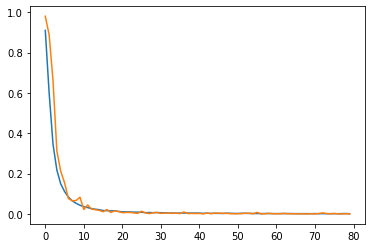

In [25]:
plt.plot(train_history["OptIterHistory"][["FitError","ValidError"]])

### Evaluate the Smaller EfficientNet Model <a name="evaluate-smaller-effb0"></a> 

In [26]:
s.dlScore(table=testImgTbl,
          modelTable=model.model_name,
          initWeights=model.model_weights.name,
          gpu=1, topprobs=5)

NOTE: Using dlgrd011.unx.sas.com: 2 out of 2 available GPU devices.


[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read         20622
 1        Number of Observations Used         20622
 2        Misclassification Error (%)      1.643875
 3  Top 5 Misclassification Error (%)      0.203666
 4                         Loss Error       0.06406

+ Elapsed: 19.9s, user: 41.7s, sys: 4.26s, mem: 338mb

We can see that the smaller EfficientNet model achieves similar accurracy as the EfficientNet-B0 model. And it is smaller and  can be trained faster

## 4. Deploy Model <a name="deployment"></a> 

In [27]:
#Save model as an ASTORE for deployment
#model = effnetb0_small
model.deploy(output_format='astore', path='/dlpy/data_dir/')

NOTE: Model astore file saved successfully.


## 5. Summary <a name="summary"></a> 

In this example, we can apply the  EfficientNet model for an end-to-end image classification example. We also show that how the EfficientNet model can be easily scaled down in an simple yet effecient way under resource constraints while maintain exellent accuracy.

## Reference
- [Fruits-360: A dataset of images containing fruits and vegetables](https://github.com/Horea94/Fruit-Images-Dataset)
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946.pdf)
- [Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning](https://www.researchgate.net/publication/321475443_Fruit_recognition_from_images_using_deep_learning)


### Close the Session to Free Resources

In [ ]:
s.endsession()